In [1]:
from skorch.utils import TeeGenerator
import torch
from sklearn.metrics import make_scorer
from skorch import NeuralNetRegressor
from skorch.callbacks import EpochScoring
from skorch.utils import to_tensor
from torch.nn import functional as F
import numpy as np
import sys
import os
from datetime import date
import torch
sys.path.insert(0, "../")
sys.path.insert(0, "../../")
from src.plots.plotting_trained_net_performance import plot_random_trials
from src.lca import *
import matplotlib.pyplot as plt
import pickle
from src.generate_CDDM_trials import *
from src.RNN_numpy import RNN_numpy
from src.RNN_torch import RNN_torch
np.set_printoptions(suppress=True)
from src.utils import get_project_root
import warnings
warnings.simplefilter("ignore", UserWarning)
import pickle
import scipy
from src.find_fp import *
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [2]:
# Callbacks
def r2_scorer(y_true, y_pred):
    y_true = to_tensor(y_true, device=device)
    y_pred = to_tensor(y_pred, device=device)
    var_y = torch.var(y_true, unbiased=False)

    return 1 - F.mse_loss(y_pred, y_true, reduction='mean') / var_y

r2 = EpochScoring(scoring=make_scorer(r2_scorer), on_train=False)

def r2_x(net, X, y):
    y = to_tensor(y, device=device)
    num_outputs = net.module_.output_layer.weight.shape[0]
    x = y[:, :, :-num_outputs]
    R = net.module_.R.detach()
    S = net.module_.S.detach()
    q = S @ R
    xqtq = x @ q.t() @ q
    var_x = torch.var(x, unbiased=False)
    return 1 - net.criterion_(x, xqtq) / var_x

def r2_xqt(net, X, y):
    xbar = net.predict(X)
    xbar = to_tensor(xbar, device=device)
    y = to_tensor(y, device=device)
    num_outputs = net.module_.output_layer.weight.shape[0]
    x = y[:, :, :-num_outputs]
    R = net.module_.R.detach()
    S = net.module_.S.detach()
    q = S @ R
    xqt = x @ q.t()
    var_xqt = torch.var(xqt, unbiased=False)
    return 1 - net.criterion_(xqt, xbar) / var_xqt

def r2_z(net, X, y):
    xbar = to_tensor(net.predict(X), device=device)
    zbar = to_tensor(net.module_.output_layer(xbar), device=device)
    y = to_tensor(y, device=device)
    num_outputs = net.module_.output_layer.weight.shape[0]
    z = y[:, :, :-num_outputs]
    return 1 - (net.criterion_(z, zbar) / torch.var(z, unbiased=False))

def rsquared(net, X, y):
    xbar = to_tensor(net.predict(X), device=device)
    zbar = to_tensor(net.module_.output_layer(xbar), device=device)
    R = net.module_.R.detach()
    S = net.module_.S.detach()
    q = S @ R
    x = torch.cat((xbar @ q, zbar), dim=2)
    y = to_tensor(y, device=device)
    return 1 - net.criterion_(y, x) / torch.var(y, unbiased=False)

def output_MSE(net, X, y):
    xbar = to_tensor(net.predict(X), device=device)
    predicted_output = to_tensor(net.module_.output_layer(xbar), device=device)
    num_outputs = net.module_.output_layer.weight.shape[0]
    target_output = to_tensor(y[:, :, -num_outputs], device=device).unsqueeze(-1)
    return torch.mean(torch.pow(predicted_output - target_output, 2))

def traces_MSE(net, X, y):
    xbar = to_tensor(net.predict(X), device=device)
    R = net.module_.R.detach()
    S = net.module_.S.detach()
    q = S @ R
    predicted_traces = xbar @ q
    num_outputs = net.module_.output_layer.weight.shape[0]
    target_traces = to_tensor(y[:, :, :-num_outputs], device=device)
    return torch.mean(torch.pow(predicted_traces - target_traces, 2))

def output_weight(net, X, y):
    return torch.sum(torch.abs(net.module_.output_layer.weight))

def input_weight(net, X, y):
    return torch.sum(torch.abs(net.module_.input_layer.weight))

def L2_weight_rec(net, X=None, y=None):
    return torch.mean(torch.pow(net.module_.recurrent_layer.weight, 2))

def L2_weight_out(net, X=None, y=None):
    return torch.mean(torch.pow(net.module_.output_layer.weight, 2))

def L1_weight_rec(net, X=None, y=None):
    return torch.mean(torch.abs(net.module_.recurrent_layer.weight))

def L1_weight_out(net, X=None, y=None):
    return torch.mean(torch.abs(net.module_.output_layer.weight))

def L2_ortho(net, X = None, y = None):
    b = torch.cat((net.module_.input_layer.weight, net.module_.output_layer.weight.t()), dim=1)
    b = b / torch.norm(b, dim=0)
    return torch.norm(b.t() @ b - torch.diag(torch.diag(b.t() @ b)), p=2)


In [3]:
class LatentModule(torch.nn.Module):
    def __init__(self,  input_mask, output_mask, recurrent_mask, n, N, alpha, sigma_rec, weight_decay, num_outputs=1, lambda_o = 0, lambda_w=0.2, torch_generator=None):
        super(LatentModule, self).__init__()

        self.input_mask = input_mask
        self.output_mask = output_mask
        self.recurrent_mask = recurrent_mask
        self.num_outputs = num_outputs
        self.N = N
        self.n = n
        self.alpha = torch.tensor(alpha).float()
        self.sigma_rec = torch.tensor(sigma_rec).float()
        self.weight_decay = weight_decay
        self.input_size = 6
        self.recurrent_layer = torch.nn.Linear(self.n, self.n, bias=False)
        self.recurrent_layer.weight.data = torch.zeros(self.n, self.n).float().to(device=device)
        self.lambda_o = lambda_o
        self.lambda_w = lambda_w
        if torch_generator is None:
            seed = np.random.randint(10000)
            self.rng = torch.Generator()
            self.rng.manual_seed(seed)
            torch.manual_seed(seed=seed)
            print("Using random seed!")
        else:
            self.rng = torch_generator
            torch.use_deterministic_algorithms(True)

        self.activation=torch.nn.ReLU(inplace=False)
        self.input_layer = torch.nn.Linear(6, self.n, bias=False)

        self.input_layer.weight.data = torch.randn(*self.input_layer.weight.data.shape, generator=self.rng)
        self.input_layer.weight.data = self.input_mask * self.input_layer.weight.data
        self.input_layer.weight.requires_grad = False
        
        self.output_layer = torch.nn.Linear(self.n, self.num_outputs, bias=False)
        self.output_layer.weight.data = torch.randn(*self.output_layer.weight.data.shape, generator=self.rng)
        self.output_layer.weight.data = self.output_mask * self.output_layer.weight.data
        self.output_layer.weight.requires_grad = True
        
        self.A = torch.nn.Parameter(torch.rand(self.N, self.N, device=device, generator=self.rng), requires_grad=True)
        self.R = ((torch.eye(self.N, device=device) - (self.A - self.A.t()) / 2) @ torch.inverse(torch.eye(self.N,device=device) + (self.A - self.A.t()) / 2)).to(device=device)
        self.R = self.R[:self.n, :]
        
    def forward(self, u):
        t = u.shape[1]
        states = torch.zeros(u.shape[0], 1, self.n, device=device)
        batch_size = states.shape[0]
        noise = torch.sqrt((2 / self.alpha) * self.sigma_rec ** 2) * torch.randn(batch_size, t, self.n, generator=self.rng).to(device=device)

        for i in range(t - 1):
            state_new = (1 - self.alpha) * states[:, i, :] + self.alpha * (
                self.activation(self.recurrent_layer(states[:, i, :]) + self.input_layer(u[:, i, :]) + noise[:, i, :]))
            states = torch.cat((states, state_new.unsqueeze_(1)), 1)

        rates = torch.relu(states)
        return rates, self.output_layer(rates), states

    def cayley_transform(self):
        skew = (self.A - self.A.t()) / 2
        skew = skew.to(device=device)
        eye = torch.eye(self.N).to(device=device)
        o = (eye - skew) @ torch.inverse(eye + skew)
        self.R = o[:self.n, :]


In [4]:
class LatentNet(NeuralNetRegressor):
    def __init__(self, constrained=True, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.constrained=constrained

    def get_loss(self, y_pred, y_true, X=None, training=False):
        y_true = to_tensor(y_true, device=self.device)
        num_outputs = self.module_.output_layer.weight.shape[0]

        if isinstance(self.criterion_, torch.nn.Module):
            self.criterion_.train(training)

        predicted_traces = y_pred[0] @ self.module_.R
        predicted_output = y_pred[1] #
#         predicted_output = y_pred[1][:, :, -num_outputs]
        target_traces = y_true[:, :, :-num_outputs] 
        target_output = y_true[:, :, -num_outputs:] 
#         predicted_output = (y_pred[1][:, :, 0] - y_pred[1][:, :, 1]).unsqueeze(-1) #
#         target_traces = y_true[:, :, :-1] #
#         target_output = y_true[:, :, -1:] #            
        return self.criterion_(target_traces, predicted_traces) + \
               self.criterion_(target_output, predicted_output) + \
               self.module_.lambda_w * (L1_weight_rec(self, None, None) + L2_weight_out(self, None, None))

    def train_step(self, batch, **fit_params):
        """Prepares a loss function callable and pass it to the optimizer,
        hence performing one optimization step.
        Loss function callable as required by some optimizers (and accepted by
        all of them):
        https://pytorch.org/docs/master/optim.html#optimizer-step-closure
        The module is set to be in train mode (e.g. dropout is
        applied).
        Parameters
        ----------
        batch
          A single batch returned by the data loader.
        **fit_params : dict
          Additional parameters passed to the ``forward`` method of
          the module and to the train_split call.
        Returns
        -------
        step : dict
          A dictionary ``{'loss': loss, 'y_pred': y_pred}``, where the
          float ``loss`` is the result of the loss function and
          ``y_pred`` the prediction generated by the PyTorch module.
        """
        step_accumulator = self.get_train_step_accumulator()

        def step_fn():
            self._zero_grad_optimizer()
            step = self.train_step_single(batch, **fit_params)
            step_accumulator.store_step(step)

            self.notify(
                'on_grad_computed',
                named_parameters=TeeGenerator(self.get_all_learnable_params()),
                batch=batch,
            )
            return step['loss']

        self._step_optimizer(step_fn)

        if self.constrained == True:
            # Apply constraints to input and output layer
            #positive weights only
            self.module_.input_layer.weight.data = self.module_.input_mask * torch.maximum(self.module_.input_layer.weight.data, torch.tensor(0))
            self.module_.output_layer.weight.data = self.module_.output_mask * torch.maximum(self.module_.output_layer.weight.data, torch.tensor(0))
            self.module_.recurrent_layer.weight.data = self.module_.recurrent_mask * self.module_.recurrent_layer.weight.data                
        # Apply cayley transform to A
        self.module_.cayley_transform()
        return step_accumulator.get_step()



In [5]:
file = "data_20102022_num_outputs=2_N=100_Nsteps=750_srec=0.03_sinp=0.03_date=2022-10-21_SGE_TASK_ID=3_MSEout=0.0171937.pkl"
RNN_file_name = os.path.join("./data", "RNNs",file)
RNN_tag = float(RNN_file_name.split(".pkl")[0].split("=")[-1])
RNN_data = pickle.load(open(RNN_file_name, "rb+"))
n_steps = RNN_data["n_steps"]
bias_rec = RNN_data["bias_rec"]
bias_out = RNN_data["bias_out"]
W_rec = RNN_data["W_rec"]
W_inp = RNN_data["W_inp"]
W_out = RNN_data["W_out"]
y_init = RNN_data["y_init"]
dt = RNN_data["dt"]
tau = RNN_data["tau"]
N = RNN_data["N"]
num_outputs = W_out.shape[0]
w_noise = RNN_data["w_noise"]
sigma_rec = RNN_data["sigma_rec"]
sigma_inp = RNN_data["sigma_inp"] 
alpha = (dt/tau)
train_mask = RNN_data["train_mask"]
protocol_dict = RNN_data["protocol_dict"]
coherences = RNN_data["coherences_train"]

RNN = RNN_numpy(N=N, dt=dt, tau=tau, W_inp=W_inp, W_rec=W_rec, W_out=W_out)

# Run multiple trajectories:
inp_traj_RNN_tuples = []
for ctx in ["motion", "color"]:
    for c1 in coherences:
        for c2 in coherences:
            relevant_coh = c1 if ctx == 'motion' else c2
            irrelevant_coh = c2 if ctx == 'motion' else c1
            coh_pair = (relevant_coh, irrelevant_coh)
            input_stream, target_stream = generate_input_target_stream(ctx,
                                                                       coh_pair[0], coh_pair[1],
                                                                       n_steps=n_steps, 
                                                                       protocol_dict=protocol_dict,
                                                                       num_outputs=2)
            inp_vect = input_stream[-1, :]
            RNN.clear_history()
            RNN.y = np.zeros(RNN.N)
            
            RNN.run(num_steps=n_steps, Inputs = input_stream, sigma_rec= 0.0, sigma_inp=0.0, save_history=True)
            
            trajectory = deepcopy(RNN.get_history())
            output = deepcopy(RNN.get_output())
            print(input_stream[-1, :])
            inp_traj_RNN_tuples.append((input_stream, trajectory, output))

[1.  0.  0.1 0.9 0.1 0.9]
[1.  0.  0.1 0.9 0.3 0.7]
[1.  0.  0.1 0.9 0.4 0.6]
[1.   0.   0.1  0.9  0.45 0.55]
[1.    0.    0.1   0.9   0.475 0.525]
[1.     0.     0.1    0.9    0.4875 0.5125]
[1.      0.      0.1     0.9     0.49375 0.50625]
[1.  0.  0.1 0.9 0.5 0.5]
[1.      0.      0.1     0.9     0.50625 0.49375]
[1.     0.     0.1    0.9    0.5125 0.4875]
[1.    0.    0.1   0.9   0.525 0.475]
[1.   0.   0.1  0.9  0.55 0.45]
[1.  0.  0.1 0.9 0.6 0.4]
[1.  0.  0.1 0.9 0.7 0.3]
[1.  0.  0.1 0.9 0.9 0.1]
[1.  0.  0.3 0.7 0.1 0.9]
[1.  0.  0.3 0.7 0.3 0.7]
[1.  0.  0.3 0.7 0.4 0.6]
[1.   0.   0.3  0.7  0.45 0.55]
[1.    0.    0.3   0.7   0.475 0.525]
[1.     0.     0.3    0.7    0.4875 0.5125]
[1.      0.      0.3     0.7     0.49375 0.50625]
[1.  0.  0.3 0.7 0.5 0.5]
[1.      0.      0.3     0.7     0.50625 0.49375]
[1.     0.     0.3    0.7    0.5125 0.4875]
[1.    0.    0.3   0.7   0.525 0.475]
[1.   0.   0.3  0.7  0.55 0.45]
[1.  0.  0.3 0.7 0.6 0.4]
[1.  0.  0.3 0.7 0.7 0.3]
[1.  0

[1.  0.  0.9 0.1 0.4 0.6]
[1.   0.   0.9  0.1  0.45 0.55]
[1.    0.    0.9   0.1   0.475 0.525]
[1.     0.     0.9    0.1    0.4875 0.5125]
[1.      0.      0.9     0.1     0.49375 0.50625]
[1.  0.  0.9 0.1 0.5 0.5]
[1.      0.      0.9     0.1     0.50625 0.49375]
[1.     0.     0.9    0.1    0.5125 0.4875]
[1.    0.    0.9   0.1   0.525 0.475]
[1.   0.   0.9  0.1  0.55 0.45]
[1.  0.  0.9 0.1 0.6 0.4]
[1.  0.  0.9 0.1 0.7 0.3]
[1.  0.  0.9 0.1 0.9 0.1]
[0.  1.  0.1 0.9 0.1 0.9]
[0.  1.  0.3 0.7 0.1 0.9]
[0.  1.  0.4 0.6 0.1 0.9]
[0.   1.   0.45 0.55 0.1  0.9 ]
[0.    1.    0.475 0.525 0.1   0.9  ]
[0.     1.     0.4875 0.5125 0.1    0.9   ]
[0.      1.      0.49375 0.50625 0.1     0.9    ]
[0.  1.  0.5 0.5 0.1 0.9]
[0.      1.      0.50625 0.49375 0.1     0.9    ]
[0.     1.     0.5125 0.4875 0.1    0.9   ]
[0.    1.    0.525 0.475 0.1   0.9  ]
[0.   1.   0.55 0.45 0.1  0.9 ]
[0.  1.  0.6 0.4 0.1 0.9]
[0.  1.  0.7 0.3 0.1 0.9]
[0.  1.  0.9 0.1 0.1 0.9]
[0.  1.  0.1 0.9 0.3 0.7]
[0.  1

[0.    1.    0.475 0.525 0.7   0.3  ]
[0.     1.     0.4875 0.5125 0.7    0.3   ]
[0.      1.      0.49375 0.50625 0.7     0.3    ]
[0.  1.  0.5 0.5 0.7 0.3]
[0.      1.      0.50625 0.49375 0.7     0.3    ]
[0.     1.     0.5125 0.4875 0.7    0.3   ]
[0.    1.    0.525 0.475 0.7   0.3  ]
[0.   1.   0.55 0.45 0.7  0.3 ]
[0.  1.  0.6 0.4 0.7 0.3]
[0.  1.  0.7 0.3 0.7 0.3]
[0.  1.  0.9 0.1 0.7 0.3]
[0.  1.  0.1 0.9 0.9 0.1]
[0.  1.  0.3 0.7 0.9 0.1]
[0.  1.  0.4 0.6 0.9 0.1]
[0.   1.   0.45 0.55 0.9  0.1 ]
[0.    1.    0.475 0.525 0.9   0.1  ]
[0.     1.     0.4875 0.5125 0.9    0.1   ]
[0.      1.      0.49375 0.50625 0.9     0.1    ]
[0.  1.  0.5 0.5 0.9 0.1]
[0.      1.      0.50625 0.49375 0.9     0.1    ]
[0.     1.     0.5125 0.4875 0.9    0.1   ]
[0.    1.    0.525 0.475 0.9   0.1  ]
[0.   1.   0.55 0.45 0.9  0.1 ]
[0.  1.  0.6 0.4 0.9 0.1]
[0.  1.  0.7 0.3 0.9 0.1]
[0.  1.  0.9 0.1 0.9 0.1]


In [6]:
Tr_RNN_array = np.vstack([inp_traj_RNN_tuples[i][1] for i in range(len(inp_traj_RNN_tuples))]).T
print(Tr_RNN_array.shape)

(100, 337500)


[0.325789   0.2116998  0.14253074 0.07857689 0.06766554 0.0481366
 0.02382641 0.02129592 0.01759605 0.01388507 0.01255648 0.00872965
 0.00806253 0.00758516 0.0063345  0.00572963]
(100, 16)


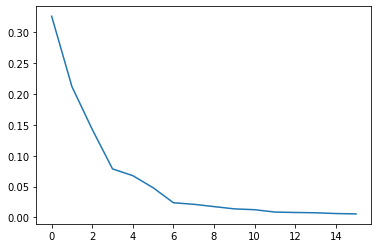

In [7]:
K = 16
U, sigma, V = scipy.sparse.linalg.svds(Tr_RNN_array, k=K)
U = U[:, ::-1]
sigma = sigma[::-1]
V = V[::-1, :]
print(sigma/(np.sum(sigma)))
print(U.shape)
fig_svd = plt.figure()
plt.plot(sigma/(np.sum(sigma)))
plt.show()

In [8]:
# Run multiple trajectories:
inp_trajPCA_tuples = []
i = 0
for ctx in ["motion", "color"]:
    for c1 in coherences:
        for c2 in coherences:
            inp, trajectory, output = inp_traj_RNN_tuples[i]
            trajectory_PCA = trajectory @ U
            inp_trajPCA_tuples.append((inp, trajectory_PCA, output))
            i+=1

In [10]:
inputs = torch.from_numpy(np.stack([inp_trajPCA_tuples[i][0] for i in range(len(inp_trajPCA_tuples))]).astype("float32")).detach().cpu()
traces = torch.from_numpy(np.stack([inp_trajPCA_tuples[i][1] for i in range(len(inp_trajPCA_tuples))]).astype("float32")).detach().cpu()
outputs = torch.from_numpy(np.stack([inp_trajPCA_tuples[i][2] for i in range(len(inp_trajPCA_tuples))]).astype("float32")).detach().cpu()
labels = torch.cat((traces, outputs), dim=2)


torch.Size([450, 750, 18])
torch.Size([450, 750, 6])


In [11]:
lr = 0.02 
lmbd_w = 0.2
weight_decay = 0.05
sigma_rec = 0.03
max_epochs = 300

num_outputs = 2
n = 8
input_mask = torch.zeros(n, 6)
input_mask[:6, :6] = torch.eye(6)
recurrent_mask = torch.ones(n, n)# - torch.eye(n)
output_mask = torch.zeros(num_outputs, n)
output_mask[0, 6] = 1
output_mask[1, 7] = 1

Module = LatentModule(input_mask=input_mask.to(device=device),
                      output_mask=output_mask.to(device=device),
                      recurrent_mask = recurrent_mask.to(device=device),
                      n=n,
                      N=K,
                      num_outputs=W_out.shape[0],
                      alpha=0.1,
                      sigma_rec=sigma_rec,
                      weight_decay=weight_decay,
                      lambda_w=lmbd_w)

W_inp_vals = np.zeros((n, 6))
W_inp_vals[:6, :6] = np.eye(6)
Module.input_layer.weight.data = torch.from_numpy(W_inp_vals.astype("float32"))
if num_outputs == 1:
    Module.output_layer.weight.data = torch.from_numpy(np.array([0,0,0,0,0,0,1,-1]).reshape(1, -1).astype("float32"))
elif num_outputs == 2:
    Module.output_layer.weight.data = torch.from_numpy(np.array([[0,0,0,0,0,0,1,0], [0,0,0,0,0,0,0,1]]).astype("float32"))

latent_net = LatentNet(
    module=Module,
    warm_start=True,
    lr=lr,
    train_split=None,
    batch_size=inputs.shape[0],
    max_epochs=max_epochs,
    constrained=True,
    optimizer=torch.optim.Adam,
    device=device,
    callbacks=[EpochScoring(rsquared, on_train=False),
               EpochScoring(output_MSE, on_train=False),
               EpochScoring(traces_MSE, on_train=False)]
)
latent_net.initialize()
# from src.connectivity import get_small_connectivity_np
# Module.recurrent_layer.weight.data = torch.from_numpy(get_small_connectivity_np()[1].astype("float32"))
latent_net.fit(torch.Tensor(inputs).to(device=device), torch.tensor(labels).to(device=device))

Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6867  1.7692
      2        0.6147  1.6498
      3        0.5482  1.6900
      4        0.4896  1.7501
      5        0.4398  1.6583
      6        0.4024  1.6277
      7        0.3836  1.6357
      8        0.3801  1.6725
      9        0.3722  1.7205
     10        0.3540  1.7422
     11        0.3393  1.7399
     12        0.3318  1.6216
     13        0.3273  1.6680
     14        0.3221  1.6920
     15        0.3161  1.6729
     16        0.3086  1.6686
     17        0.3031  1.6980
     18        0.3011  1.7053
     19        0.3008  1.6089
     20        0.2964  1.6306
     21        0.2911  1.6338
     22        0.2881  1.6423
     23        0.2871  1.6095
     24        0.2848  1.6381
     25        0.2808  1.6158
     26        0.2758  1.5475
     27        0.2714  1.6027
     28        0.2685  1.6673
     29        0.2658  1.5922
     30        0.2613  1.5975
     31        0.2575

    240        0.0782  1.6265
    241        0.0739  1.6126
    242        0.0795  1.7095
    243        0.0772  1.6447
    244        0.0787  1.8788
    245        0.0739  1.8314
    246        0.0738  1.8662
    247        0.0772  1.6035
    248        0.0728  1.8345
    249        0.0743  1.6646
    250        0.0744  1.6486
    251        0.0737  1.7273
    252        0.0742  1.6073
    253        0.0751  1.6793
    254        0.0734  1.6275
    255        0.0768  1.6187
    256        0.0781  1.6175
    257        0.0753  1.6373
    258        0.0734  1.6849
    259        0.0790  1.6852
    260        0.0758  1.8616
    261        0.0728  1.7401
    262        0.0758  1.5887
    263        0.0749  1.6088
    264        0.0753  1.8809
    265        0.0730  1.6873
    266        0.0730  1.6816
    267        0.0755  1.7230
    268        0.0729  1.6643
    269        0.0724  1.8465
    270        0.0734  1.8103
    271        0.0721  1.7869
    272        0.0734  1.8725
    273   

<class '__main__.LatentNet'>[initialized](
  module_=LatentModule(
    (recurrent_layer): Linear(in_features=8, out_features=8, bias=False)
    (activation): ReLU()
    (input_layer): Linear(in_features=6, out_features=8, bias=False)
    (output_layer): Linear(in_features=8, out_features=2, bias=False)
  ),
)

In [12]:
w_rec = latent_net.module_.recurrent_layer.weight.data.detach().numpy()
w_out = latent_net.module_.output_layer.weight.data.detach().numpy()
w_inp = latent_net.module_.input_layer.weight.data.detach().numpy()
R = latent_net.module_.R.detach().numpy()
print(R.shape)
Q_emb = R @ U.T  # 8 x N
Q_pr = U @ R.T  # N x 8

(8, 16)


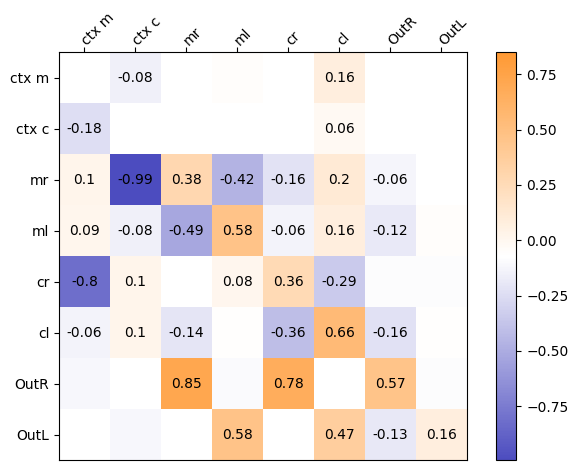

In [13]:
from src.plots.color_scheme import get_colormaps
plt.style.use('default')
colors, cmp_light, cmp_medium, cmp_dark = get_colormaps()
cmp = cmp_light
names = ["ctx m", "ctx c", "mr", "ml", "cr", "cl", "OutR", "OutL"]
n = 8
fig_w_rec = plt.figure()
ax = plt.gca()
im = ax.imshow(w_rec, interpolation='blackman', cmap=cmp)
fig_w_rec.colorbar(im)

ax.set_xticks(np.arange(n))
ax.set_xticklabels(names)
ax.set_yticks(np.arange(n))
ax.set_yticklabels(names)

# Set ticks on both sides of axes on
ax.tick_params(axis="x", bottom=False, top=True, labelbottom=False, labeltop=True)
# Rotate and align bottom ticklabels
plt.setp([tick.label1 for tick in ax.xaxis.get_major_ticks()], rotation=45,
         ha="right", va="center", rotation_mode="anchor")
# Rotate and align top ticklabels
plt.setp([tick.label2 for tick in ax.xaxis.get_major_ticks()], rotation=45,
         ha="left", va="center",rotation_mode="anchor")

for (i,j), z in np.ndenumerate(w_rec):
    if z < -0.05 or z > 0.05:
        if z >= -1:
            ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k')
        if z < -1:
            ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='w')
# ax.set_title("Connectivity matrix", fontsize = 16, pad=10)
im = ax.imshow(w_rec, interpolation='none', vmin=-np.max(np.abs(w_rec)), vmax = np.max(np.abs(w_rec)), cmap=cmp)
fig_w_rec.tight_layout()
plt.show()

# animating the circuit

In [14]:
from src.plots.latent_circuit_animation import *
from ipywidgets import interact, IntSlider
input_stream, target_stream = generate_input_target_stream(context="motion",
                                                           motion_coh=0.1, color_coh=-0.5,
                                                           n_steps=n_steps, 
                                                           protocol_dict=protocol_dict,
                                                           num_outputs=2)
lc = RNN_numpy(N=8, dt=dt, tau=tau, W_inp=w_inp, W_rec=w_rec, W_out=w_out)
lc.clear_history()
lc.y = np.zeros(lc.N)
lc.run(num_steps=n_steps, Inputs=input_stream, save_history=True, sigma_rec = 0, sigma_inp=0)

traces = lc.get_history()

def animate_trial(t):
    figure, axes = plt.subplots(figsize=(4, 4))
    plt.suptitle(f"time = {t} out of {n_steps}")
    draw_net(activity_vector=traces[t, :], w_rec=lc.W_rec, w_inp=lc.W_inp, I=input_stream[t, :], axes=axes, r=0.05)
    plt.draw()
    plt.show()

interact(animate_trial, t=IntSlider(min=0, max=n_steps-1, step=1, value=0.0));

interactive(children=(IntSlider(value=0, description='t', max=749), Output()), _dom_classes=('widget-interact'…

# calculating metrics over trials

In [15]:
sigma_rec = 0.02
lc = RNN_numpy(N=8, dt=dt, tau=tau, W_inp=w_inp, W_rec=w_rec, W_out=w_out)# Run multiple trajectories on the distilled lc:
inp_traj_lc_tuples = []
for ctx in ["motion", "color"]:
    for c1 in coherences:
        for c2 in coherences:
            relevant_coh = c1 if ctx == 'motion' else c2
            irrelevant_coh = c2 if ctx == 'motion' else c1
            coh_pair = (relevant_coh, irrelevant_coh)
            input_stream, target_stream = generate_input_target_stream(ctx,
                                                                       coh_pair[0], coh_pair[1],
                                                                       n_steps, 
                                                                       protocol_dict,
                                                                       num_outputs=2)
            inp_vect = input_stream[-1, :]
            lc.clear_history()
            lc.y = np.zeros(8)
            
            lc.run(num_steps=n_steps, Inputs = input_stream, sigma_rec = 0, save_history=True)
            
            trajectory_lc = deepcopy(lc.get_history())
            output_lc = deepcopy(lc.get_output())
            print(input_stream[-1, :])
            inp_traj_lc_tuples.append((input_stream, trajectory_lc, output_lc, target_stream))

[1.  0.  0.1 0.9 0.1 0.9]
[1.  0.  0.1 0.9 0.3 0.7]
[1.  0.  0.1 0.9 0.4 0.6]
[1.   0.   0.1  0.9  0.45 0.55]
[1.    0.    0.1   0.9   0.475 0.525]
[1.     0.     0.1    0.9    0.4875 0.5125]
[1.      0.      0.1     0.9     0.49375 0.50625]
[1.  0.  0.1 0.9 0.5 0.5]
[1.      0.      0.1     0.9     0.50625 0.49375]
[1.     0.     0.1    0.9    0.5125 0.4875]
[1.    0.    0.1   0.9   0.525 0.475]
[1.   0.   0.1  0.9  0.55 0.45]
[1.  0.  0.1 0.9 0.6 0.4]
[1.  0.  0.1 0.9 0.7 0.3]
[1.  0.  0.1 0.9 0.9 0.1]
[1.  0.  0.3 0.7 0.1 0.9]
[1.  0.  0.3 0.7 0.3 0.7]
[1.  0.  0.3 0.7 0.4 0.6]
[1.   0.   0.3  0.7  0.45 0.55]
[1.    0.    0.3   0.7   0.475 0.525]
[1.     0.     0.3    0.7    0.4875 0.5125]
[1.      0.      0.3     0.7     0.49375 0.50625]
[1.  0.  0.3 0.7 0.5 0.5]
[1.      0.      0.3     0.7     0.50625 0.49375]
[1.     0.     0.3    0.7    0.5125 0.4875]
[1.    0.    0.3   0.7   0.525 0.475]
[1.   0.   0.3  0.7  0.55 0.45]
[1.  0.  0.3 0.7 0.6 0.4]
[1.  0.  0.3 0.7 0.7 0.3]
[1.  0

[1.      0.      0.9     0.1     0.49375 0.50625]
[1.  0.  0.9 0.1 0.5 0.5]
[1.      0.      0.9     0.1     0.50625 0.49375]
[1.     0.     0.9    0.1    0.5125 0.4875]
[1.    0.    0.9   0.1   0.525 0.475]
[1.   0.   0.9  0.1  0.55 0.45]
[1.  0.  0.9 0.1 0.6 0.4]
[1.  0.  0.9 0.1 0.7 0.3]
[1.  0.  0.9 0.1 0.9 0.1]
[0.  1.  0.1 0.9 0.1 0.9]
[0.  1.  0.3 0.7 0.1 0.9]
[0.  1.  0.4 0.6 0.1 0.9]
[0.   1.   0.45 0.55 0.1  0.9 ]
[0.    1.    0.475 0.525 0.1   0.9  ]
[0.     1.     0.4875 0.5125 0.1    0.9   ]
[0.      1.      0.49375 0.50625 0.1     0.9    ]
[0.  1.  0.5 0.5 0.1 0.9]
[0.      1.      0.50625 0.49375 0.1     0.9    ]
[0.     1.     0.5125 0.4875 0.1    0.9   ]
[0.    1.    0.525 0.475 0.1   0.9  ]
[0.   1.   0.55 0.45 0.1  0.9 ]
[0.  1.  0.6 0.4 0.1 0.9]
[0.  1.  0.7 0.3 0.1 0.9]
[0.  1.  0.9 0.1 0.1 0.9]
[0.  1.  0.1 0.9 0.3 0.7]
[0.  1.  0.3 0.7 0.3 0.7]
[0.  1.  0.4 0.6 0.3 0.7]
[0.   1.   0.45 0.55 0.3  0.7 ]
[0.    1.    0.475 0.525 0.3   0.7  ]
[0.     1.     0.4875 0.

[0.  1.  0.6 0.4 0.7 0.3]
[0.  1.  0.7 0.3 0.7 0.3]
[0.  1.  0.9 0.1 0.7 0.3]
[0.  1.  0.1 0.9 0.9 0.1]
[0.  1.  0.3 0.7 0.9 0.1]
[0.  1.  0.4 0.6 0.9 0.1]
[0.   1.   0.45 0.55 0.9  0.1 ]
[0.    1.    0.475 0.525 0.9   0.1  ]
[0.     1.     0.4875 0.5125 0.9    0.1   ]
[0.      1.      0.49375 0.50625 0.9     0.1    ]
[0.  1.  0.5 0.5 0.9 0.1]
[0.      1.      0.50625 0.49375 0.9     0.1    ]
[0.     1.     0.5125 0.4875 0.9    0.1   ]
[0.    1.    0.525 0.475 0.9   0.1  ]
[0.   1.   0.55 0.45 0.9  0.1 ]
[0.  1.  0.6 0.4 0.9 0.1]
[0.  1.  0.7 0.3 0.9 0.1]
[0.  1.  0.9 0.1 0.9 0.1]


In [16]:
# %matplotlib inline
from scipy import *
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

fig_outputs_RNN = plt.figure(figsize=(10, 4))
def plot_outputs(num_trial):
    i = int(num_trial)
    plt.style.use("seaborn")
    plt.suptitle(f"input = {np.round(inp_traj_RNN_tuples[i][0][-1, :], 3)}")
    output_lc = inp_traj_lc_tuples[i][2]
    target_lc = inp_traj_lc_tuples[i][3]
    
    plt.plot(np.arange(output_lc.shape[0])*dt, output_lc[:, 0], color = 'r', label = 'lc OutR')
    plt.plot(np.arange(output_lc.shape[0])*dt, output_lc[:, 1], color = 'b', label = 'lc OutL')
    plt.plot(np.arange(output_lc.shape[0])*dt, target_lc[:, 0], linestyle = '--', color = 'r', label = 'target OutR')
    plt.plot(np.arange(output_lc.shape[0])*dt, target_lc[:, 1], linestyle = '--', color = 'b', label = 'target OutL')
    plt.ylim([-0.2, 1.3])
    plt.legend(fontsize = 16, loc = 2)
    plt.show()

print("Outputs of small circuit v")
## Generate our user interface.
interact(plot_outputs, num_trial=IntSlider(min=0, max=len(inp_traj_lc_tuples)-1, step=1, value=0.0));

Outputs of small circuit v


<Figure size 1000x400 with 0 Axes>

interactive(children=(IntSlider(value=0, description='num_trial', max=449), Output()), _dom_classes=('widget-i…

# projected recurrent connectivity

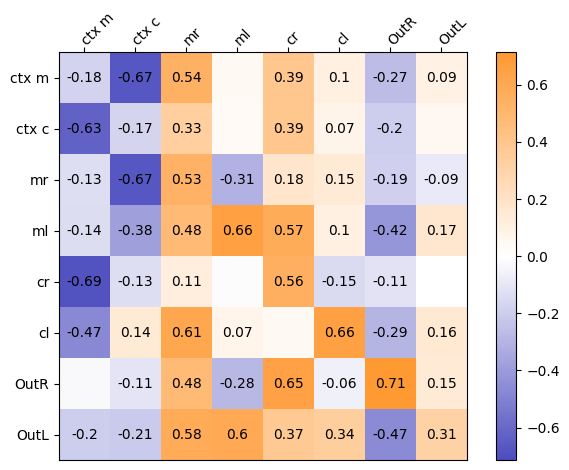

In [17]:
from src.plots.color_scheme import get_colormaps
plt.style.use("default")
colors, cmp_light, cmp_medium, cmp_dark = get_colormaps()
cmp = cmp_light
names = ["ctx m", "ctx c", "mr", "ml", "cr", "cl", "OutR", "OutL"]
n = 8
w_rec_bar = Q_emb @ W_rec @ Q_pr
fig_W_rec = plt.figure()
ax = plt.gca()

ax.set_xticks(np.arange(n))
ax.set_xticklabels(names)
ax.set_yticks(np.arange(n))
ax.set_yticklabels(names)

# Set ticks on both sides of axes on
ax.tick_params(axis="x", bottom=False, top=True, labelbottom=False, labeltop=True)
# Rotate and align bottom ticklabels
plt.setp([tick.label1 for tick in ax.xaxis.get_major_ticks()], rotation=45,
         ha="right", va="center", rotation_mode="anchor")
# Rotate and align top ticklabels
plt.setp([tick.label2 for tick in ax.xaxis.get_major_ticks()], rotation=45,
         ha="left", va="center",rotation_mode="anchor")

for (i,j), z in np.ndenumerate(w_rec_bar):
    if z < -0.05 or z > 0.05:
        if z >= -1:
            ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k')
        if z < -1:
            ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='w')
# ax.set_title("Connectivity matrix", fontsize = 16, pad=10)
im = ax.imshow(w_rec_bar, interpolation='none', vmin=-np.max(w_rec_bar), vmax = np.max(w_rec_bar), cmap=cmp)
fig_W_rec.colorbar(im)
fig_W_rec.tight_layout()
plt.show()

In [18]:
Tr_lc_array = np.vstack([inp_traj_lc_tuples[i][1] for i in range(len(inp_traj_lc_tuples))])
Tr_RNN_array = np.vstack([inp_traj_RNN_tuples[i][1] for i in range(len(inp_traj_RNN_tuples))])
Tr_PCA_array = np.vstack([inp_trajPCA_tuples[i][1] for i in range(len(inp_trajPCA_tuples))])
Out_lc_array = np.vstack([inp_traj_lc_tuples[i][2] for i in range(len(inp_traj_lc_tuples))])
Out_RNN_array = np.vstack([inp_traj_RNN_tuples[i][2] for i in range(len(inp_traj_RNN_tuples))])
Out_PCA_array = np.vstack([inp_trajPCA_tuples[i][2] for i in range(len(inp_trajPCA_tuples))])

# Out_lc_array = (Out_lc_array[:, 0] - Out_lc_array[:, 1]).reshape(-1, 1)
# Out_lc_array = Out_lc_array

In [19]:
#MSE and R2 on Tr and Out 
# on (lc_emb, RNN), (lc, RNN_pr), (lc_emb, PCA), (lc, PCA_emb)

#MSE:
print("MSE")

v1 = np.sum(Tr_lc_array @ Q_emb - Tr_RNN_array)**2 / np.sum(Tr_RNN_array)**2
v2 = np.sum(Tr_RNN_array @ Q_pr @ Q_emb - Tr_RNN_array)**2 / np.sum(Tr_RNN_array)**2
v3 = np.sum(Tr_lc_array - Tr_RNN_array @ Q_pr)**2 / np.sum(Tr_RNN_array)**2
print(v1)# full error (lc_emb, RNN)
print(v2)# orthogonal to the plane(RNN_pr_emb, RNN)
print(v3)# within the plane : (lc, RNN_pr)
print(v2 + v3)

print("MSE output:")
score = np.mean(Tr_lc_array @ w_out.T - Tr_RNN_array @ W_out.T)**2
print(score)


# R2:
print("R2")
print(1 - ((np.mean(Tr_lc_array @ Q_emb - Tr_RNN_array)**2)/(np.var(Tr_RNN_array))))# (lc_emb, RNN)
print(1 - ((np.mean(Tr_lc_array - Tr_RNN_array @ Q_pr)**2)/(np.var(Tr_RNN_array @ Q_pr))))# (lc, RNN_pr)
# print(1 - ((np.mean(Tr_lc_array @ R - Tr_PCA_array)**2)/(np.var(Tr_PCA_array))))# (lc_emb, PCA)
# print(1 - ((np.mean(Tr_lc_array - Tr_PCA_array @ R.T)**2)/(np.var(Tr_PCA_array @ R.T))))# (lc, PCA_pr)



MSE
1.6847267952522685e-05
1.7516062198370423e-05
1.2984836653131029e-05
3.0500898851501452e-05
MSE output:
2.314866440746351e-08
R2
0.9999955837949621
0.9999489177028007


In [20]:
# %matplotlib inline
from scipy import *
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
fig_outputs= plt.figure()

def plot_outputs(num_trial):
    i = int(num_trial)
    plt.style.use("seaborn")
    plt.suptitle(f"input = {np.round(inp_traj_RNN_tuples[i][0][-1, :], 3)}")
    output_RNN = inp_traj_RNN_tuples[i][2]
    output_lc = inp_traj_lc_tuples[i][2]
#     output_lc = output_lc[:, 0] - output_lc[:, 1]
    plt.plot(np.arange(output_lc.shape[0])*dt, output_lc[:, 0], color='r', linestyle='-', label = 'lc OutR')
    plt.plot(np.arange(output_lc.shape[0])*dt, output_lc[:, 1], color='r', linestyle='--', label = 'lc OutL')
    plt.plot(np.arange(output_RNN.shape[0])*dt, output_RNN[:, 0], color = 'b', label = 'RNN')
    plt.plot(np.arange(output_RNN.shape[0])*dt, output_RNN[:, 1], color = 'b',linestyle='--', label = 'RNN')
    plt.ylim([-1.2, 1.2])
    plt.legend(fontsize = 16, loc = 2)
    plt.show()

print("Outputs of small circuit vs RNN")
## Generate our user interface.
interact(plot_outputs, num_trial=IntSlider(min=0, max=len(inp_traj_RNN_tuples)-1, step=1, value=0.0));

Outputs of small circuit vs RNN


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=0, description='num_trial', max=449), Output()), _dom_classes=('widget-i…

In [21]:
# %matplotlib inline
from scipy import *
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, fixed

fig_traces= plt.figure()
def plot_traces(num_trial, j):
    i = int(num_trial)
    
    plt.style.use("seaborn")
    plt.suptitle(f"variable number {j}, input = {np.round(inp_traj_RNN_tuples[i][0][-1, :], 3)}")
    trace_RNN = (inp_traj_RNN_tuples[i][1] @ Q_pr)[:, j]
    trace_lc = (inp_traj_lc_tuples[i][1])[:, j]
    plt.plot(np.arange(trace_lc.shape[0])*dt, trace_lc, color='r', label = 'lc')
    plt.plot(np.arange(trace_RNN.shape[0])*dt, trace_RNN, color = 'b', label = 'RNN')
    plt.ylim([-0.2, 1.5])
    plt.legend(fontsize = 16, loc = 2)
    plt.show()

print("Variables of small circuit vs RNN")
## Generate our user interface

interact(plot_traces, num_trial=IntSlider(min=0, max=len(inp_traj_RNN_tuples)-1, step=1, value=0.0), j=fixed(5));

Variables of small circuit vs RNN


<Figure size 800x550 with 0 Axes>

interactive(children=(IntSlider(value=0, description='num_trial', max=449), Output()), _dom_classes=('widget-i…

In [22]:
N_points = 201

RNN = RNN_numpy(N=N, dt=dt, tau=tau, W_inp=W_inp, W_rec=W_rec, W_out=W_out,
               bias_rec = np.zeros(N), bias_out = 0, y_init = np.zeros(N))
lc = RNN_numpy(N=8, dt=dt, tau=tau, W_inp=w_inp, W_rec=w_rec, W_out=w_out,
               bias_rec = np.zeros(8), bias_out = 0, y_init = np.zeros(8))
RNN_slow_points_data = get_LA_analytics(RNN, N_points=N_points, nudge = 0.01)
lc_slow_points_data = get_LA_analytics(lc, N_points=N_points, nudge = 0.07)

/Users/tolmach/miniconda3/envs/python_3.8/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


  0%|          | 0/201 [00:00<?, ?it/s]

/Users/tolmach/miniconda3/envs/python_3.8/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

In [23]:
P_matrix = np.zeros((8, 3))
P_matrix[:, 0] = np.array([0, 0, 0, 0, 0, 0, 1, -1])
P_matrix[:, 1] = np.array([0.5, -0.5, 0, 0, 0, 0, 0, 0])
P_matrix[:, 2] = np.array([0, 0, 1, 1, 1, 1, 0, 0])

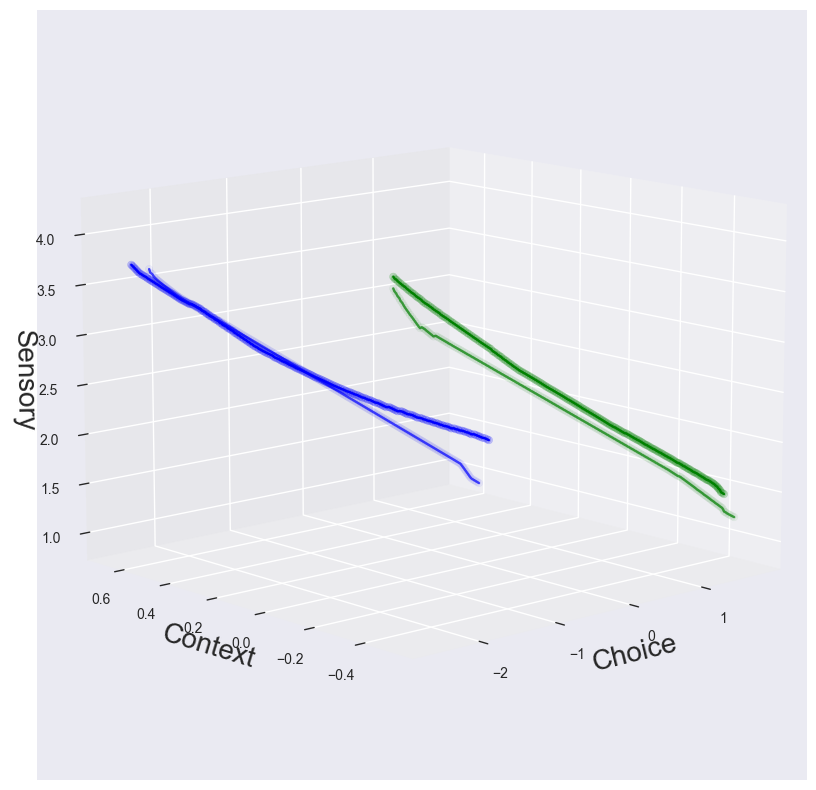

In [24]:
# %matplotlib notebook 

fig_3D = plt.figure(figsize=(8, 8))
ax = fig_3D.add_subplot(projection='3d')
ax.set_xlabel("Choice", fontsize=20)
ax.set_ylabel("Context", fontsize=20)
ax.set_zlabel("Sensory", fontsize=20)
for ctx in ["motion", "color"]:
    sp_RNN_Qprojected = np.vstack(RNN_slow_points_data[ctx]["slow_points"]) @ Q_pr
    sp_RNN_3dprojected =  sp_RNN_Qprojected @ P_matrix
    sp_lc_3dprojected = np.vstack(lc_slow_points_data[ctx]["slow_points"]) @ P_matrix
    
    clr = 'b' if ctx == 'motion' else 'g'
    ax.scatter(*(sp_RNN_3dprojected[:, k] for k in range(3)), color=clr, marker='o', s=30, alpha=0.2)
    ax.plot(*(sp_RNN_3dprojected[:, k] for k in range(3)), color=clr)
    
    ax.scatter(*(sp_lc_3dprojected[:, k] for k in range(3)), color=clr, marker='o', s=30, alpha=0.05)
    ax.plot(*(sp_lc_3dprojected[:, k] for k in range(3)), color=clr, alpha = 0.7)

fig_3D.subplots_adjust()
ax.view_init(12, 228)
fig_3D.subplots_adjust()
plt.tight_layout()
plt.show()

In [25]:
lc_data = {}
lc_data["W_out"] = deepcopy(lc.W_out)
lc_data["W_rec"] = deepcopy(lc.W_rec)
lc_data["W_inp"] = deepcopy(lc.W_inp)
lc_data["b_rec"] = deepcopy(np.zeros(lc.N))
lc_data["b_out"] = deepcopy(0)
lc_data["Q_emb"] = deepcopy(Q_emb)
lc_data["Q_pr"] = deepcopy(Q_pr)
lc_data["N"] = lc.N
lc_data["tau"] = lc.tau
lc_data["dt"] = lc.dt
lc_data["RNN_data"] = deepcopy(RNN_data)

pickle.dump(lc_data, open(os.path.join("./", "data", "LCs", f"LC_{RNN_tag}_{np.round(score, 5)}.pkl"), "wb+"))

# loop

[1.  0.  0.1 0.9 0.1 0.9]
[1.  0.  0.1 0.9 0.3 0.7]
[1.  0.  0.1 0.9 0.4 0.6]
[1.   0.   0.1  0.9  0.45 0.55]
[1.    0.    0.1   0.9   0.475 0.525]
[1.     0.     0.1    0.9    0.4875 0.5125]
[1.      0.      0.1     0.9     0.49375 0.50625]
[1.  0.  0.1 0.9 0.5 0.5]
[1.      0.      0.1     0.9     0.50625 0.49375]
[1.     0.     0.1    0.9    0.5125 0.4875]
[1.    0.    0.1   0.9   0.525 0.475]
[1.   0.   0.1  0.9  0.55 0.45]
[1.  0.  0.1 0.9 0.6 0.4]
[1.  0.  0.1 0.9 0.7 0.3]
[1.  0.  0.1 0.9 0.9 0.1]
[1.  0.  0.3 0.7 0.1 0.9]
[1.  0.  0.3 0.7 0.3 0.7]
[1.  0.  0.3 0.7 0.4 0.6]
[1.   0.   0.3  0.7  0.45 0.55]
[1.    0.    0.3   0.7   0.475 0.525]
[1.     0.     0.3    0.7    0.4875 0.5125]
[1.      0.      0.3     0.7     0.49375 0.50625]
[1.  0.  0.3 0.7 0.5 0.5]
[1.      0.      0.3     0.7     0.50625 0.49375]
[1.     0.     0.3    0.7    0.5125 0.4875]
[1.    0.    0.3   0.7   0.525 0.475]
[1.   0.   0.3  0.7  0.55 0.45]
[1.  0.  0.3 0.7 0.6 0.4]
[1.  0.  0.3 0.7 0.7 0.3]
[1.  0

[1.  0.  0.9 0.1 0.4 0.6]
[1.   0.   0.9  0.1  0.45 0.55]
[1.    0.    0.9   0.1   0.475 0.525]
[1.     0.     0.9    0.1    0.4875 0.5125]
[1.      0.      0.9     0.1     0.49375 0.50625]
[1.  0.  0.9 0.1 0.5 0.5]
[1.      0.      0.9     0.1     0.50625 0.49375]
[1.     0.     0.9    0.1    0.5125 0.4875]
[1.    0.    0.9   0.1   0.525 0.475]
[1.   0.   0.9  0.1  0.55 0.45]
[1.  0.  0.9 0.1 0.6 0.4]
[1.  0.  0.9 0.1 0.7 0.3]
[1.  0.  0.9 0.1 0.9 0.1]
[0.  1.  0.1 0.9 0.1 0.9]
[0.  1.  0.3 0.7 0.1 0.9]
[0.  1.  0.4 0.6 0.1 0.9]
[0.   1.   0.45 0.55 0.1  0.9 ]
[0.    1.    0.475 0.525 0.1   0.9  ]
[0.     1.     0.4875 0.5125 0.1    0.9   ]
[0.      1.      0.49375 0.50625 0.1     0.9    ]
[0.  1.  0.5 0.5 0.1 0.9]
[0.      1.      0.50625 0.49375 0.1     0.9    ]
[0.     1.     0.5125 0.4875 0.1    0.9   ]
[0.    1.    0.525 0.475 0.1   0.9  ]
[0.   1.   0.55 0.45 0.1  0.9 ]
[0.  1.  0.6 0.4 0.1 0.9]
[0.  1.  0.7 0.3 0.1 0.9]
[0.  1.  0.9 0.1 0.1 0.9]
[0.  1.  0.1 0.9 0.3 0.7]
[0.  1

[0.  1.  0.3 0.7 0.7 0.3]
[0.  1.  0.4 0.6 0.7 0.3]
[0.   1.   0.45 0.55 0.7  0.3 ]
[0.    1.    0.475 0.525 0.7   0.3  ]
[0.     1.     0.4875 0.5125 0.7    0.3   ]
[0.      1.      0.49375 0.50625 0.7     0.3    ]
[0.  1.  0.5 0.5 0.7 0.3]
[0.      1.      0.50625 0.49375 0.7     0.3    ]
[0.     1.     0.5125 0.4875 0.7    0.3   ]
[0.    1.    0.525 0.475 0.7   0.3  ]
[0.   1.   0.55 0.45 0.7  0.3 ]
[0.  1.  0.6 0.4 0.7 0.3]
[0.  1.  0.7 0.3 0.7 0.3]
[0.  1.  0.9 0.1 0.7 0.3]
[0.  1.  0.1 0.9 0.9 0.1]
[0.  1.  0.3 0.7 0.9 0.1]
[0.  1.  0.4 0.6 0.9 0.1]
[0.   1.   0.45 0.55 0.9  0.1 ]
[0.    1.    0.475 0.525 0.9   0.1  ]
[0.     1.     0.4875 0.5125 0.9    0.1   ]
[0.      1.      0.49375 0.50625 0.9     0.1    ]
[0.  1.  0.5 0.5 0.9 0.1]
[0.      1.      0.50625 0.49375 0.9     0.1    ]
[0.     1.     0.5125 0.4875 0.9    0.1   ]
[0.    1.    0.525 0.475 0.9   0.1  ]
[0.   1.   0.55 0.45 0.9  0.1 ]
[0.  1.  0.6 0.4 0.9 0.1]
[0.  1.  0.7 0.3 0.9 0.1]
[0.  1.  0.9 0.1 0.9 0.1]
[0.284

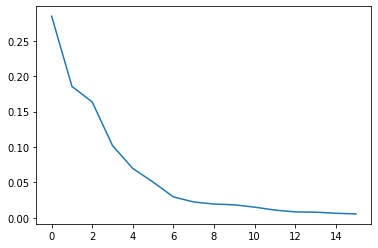

Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5603  1.7617
      2        0.5015  1.5569
      3        0.4513  1.6545
      4        0.4083  1.5882
      5        0.3713  1.5949
      6        0.3401  1.6805
      7        0.3150  1.6077
      8        0.2986  1.5651
      9        0.2912  1.5646
     10        0.2850  1.6115
     11        0.2749  1.6338
     12        0.2632  1.6034
     13        0.2533  1.7533
     14        0.2467  1.5854
     15        0.2416  1.6308
     16        0.2371  1.6543
     17        0.2324  1.6153
     18        0.2276  1.5968
     19        0.2230  1.6278
     20        0.2185  1.6021
     21        0.2151  1.6220
     22        0.2131  1.6828
     23        0.2117  1.5642
     24        0.2097  1.5767
     25        0.2068  1.6853
     26        0.2044  1.6110
     27        0.2025  1.6069
     28        0.2012  1.6265
     29        0.1994  1.6341
     30        0.1974  1.6062
     31        0.1952

    241        0.0703  1.5728
    242        0.0700  1.6643
    243        0.0718  1.6187
    244        0.0700  1.6667
    245        0.0716  1.6188
    246        0.0682  1.6381
    247        0.0697  1.5643
    248        0.0696  1.6595
    249        0.0709  1.6857
    250        0.0676  1.6715
    251        0.0682  1.6130
    252        0.0687  1.6463
    253        0.0700  1.6357
    254        0.0690  1.6556
    255        0.0690  1.6282
    256        0.0686  1.6677
    257        0.0687  1.6452
    258        0.0689  1.6315
    259        0.0705  1.6045
    260        0.0696  1.6146
    261        0.0693  1.6114
    262        0.0704  1.6383
    263        0.0693  1.5253
    264        0.0695  1.6315
    265        0.0683  1.5483
    266        0.0690  1.7799
    267        0.0699  1.6308
    268        0.0693  1.6652
    269        0.0699  1.6372
    270        0.0697  1.5999
    271        0.0707  1.6678
    272        0.0681  1.6052
    273        0.0709  1.6354
    274   

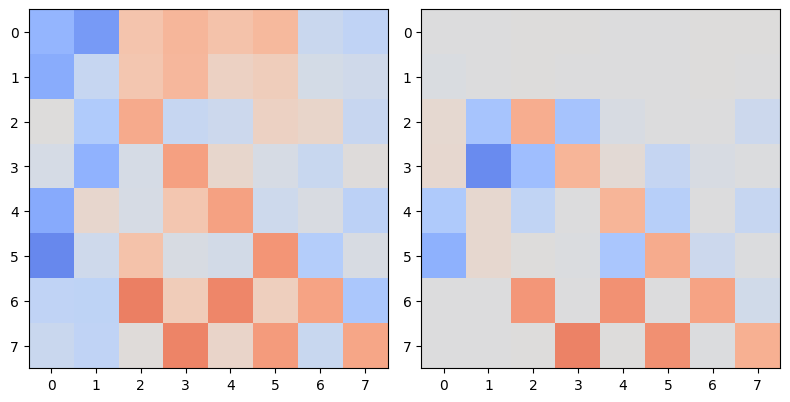

cosine_similarity measure: 0.76
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5590  1.6627
      2        0.5078  1.5631
      3        0.4664  1.6312
      4        0.4325  1.5820
      5        0.4047  1.5565
      6        0.3807  1.6020
      7        0.3613  1.6169
      8        0.3457  1.5994
      9        0.3335  1.5927
     10        0.3223  1.5556
     11        0.3111  1.5826
     12        0.3006  1.5977
     13        0.2909  1.5943
     14        0.2835  1.6151
     15        0.2766  1.5788
     16        0.2701  1.5840
     17        0.2633  1.6695
     18        0.2565  1.6355
     19        0.2502  1.6118
     20        0.2447  1.6053
     21        0.2401  1.6166
     22        0.2358  1.5814
     23        0.2316  1.5756
     24        0.2275  1.5771
     25        0.2240  1.5842
     26        0.2207  1.6470
     27        0.2175  1.6093
     28        0.2143  1.5740
     29        0.2111  1.6375
     30        0.20

    240        0.0700  1.6253
    241        0.0714  1.6430
    242        0.0712  1.6493
    243        0.0683  1.6161
    244        0.0702  1.6153
    245        0.0695  1.6070
    246        0.0707  1.6105
    247        0.0690  1.5873
    248        0.0686  1.6103
    249        0.0690  1.6301
    250        0.0689  1.5396
    251        0.0697  1.6509
    252        0.0689  1.5865
    253        0.0716  1.6181
    254        0.0696  1.6457
    255        0.0710  1.6593
    256        0.0719  1.6165
    257        0.0695  1.6174
    258        0.0723  1.6103
    259        0.0691  1.6507
    260        0.0726  1.6126
    261        0.0693  1.6170
    262        0.0734  1.5679
    263        0.0700  1.5947
    264        0.0709  1.5943
    265        0.0690  1.6368
    266        0.0699  1.6980
    267        0.0692  1.6076
    268        0.0699  1.6256
    269        0.0706  1.6964
    270        0.0687  1.7003
    271        0.0695  1.6105
    272        0.0692  1.5827
    273   

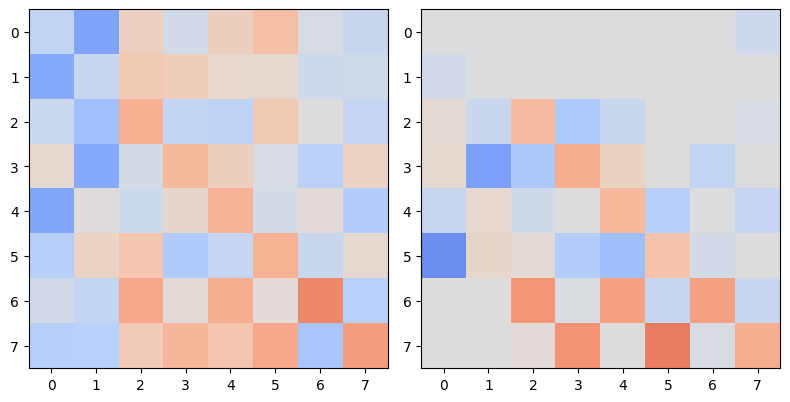

cosine_similarity measure: 0.739
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5711  1.6596
      2        0.5087  1.6523
      3        0.4532  1.6729
      4        0.4058  1.6364
      5        0.3666  1.5935
      6        0.3357  1.6525
      7        0.3131  1.6229
      8        0.2999  1.6601
      9        0.2957  1.5631
     10        0.2935  1.5656
     11        0.2857  1.6549
     12        0.2746  1.5798
     13        0.2652  1.5902
     14        0.2584  1.6690
     15        0.2543  1.5119
     16        0.2505  1.5599
     17        0.2472  1.5698
     18        0.2432  1.6103
     19        0.2388  1.6772
     20        0.2338  1.6663
     21        0.2288  1.5822
     22        0.2243  1.6020
     23        0.2211  1.6223
     24        0.2196  1.5911
     25        0.2185  1.6454
     26        0.2159  1.6626
     27        0.2122  1.5731
     28        0.2085  1.6210
     29        0.2058  1.6444
     30        0.2

    232        0.0728  1.6152
    233        0.0727  1.6649
    234        0.0732  1.6157
    235        0.0716  1.6862
    236        0.0768  1.6027
    237        0.0732  1.6273
    238        0.0739  1.5804
    239        0.0710  1.6931
    240        0.0734  1.6013
    241        0.0749  1.7230
    242        0.0736  1.6096
    243        0.0777  1.6884
    244        0.0715  1.6198
    245        0.0760  1.5997
    246        0.0718  1.5977
    247        0.0734  1.6475
    248        0.0702  1.6431
    249        0.0729  1.6295
    250        0.0721  1.6380
    251        0.0716  1.6072
    252        0.0719  1.6282
    253        0.0730  1.5826
    254        0.0727  1.6491
    255        0.0716  1.6159
    256        0.0738  1.6558
    257        0.0712  1.6184
    258        0.0712  1.6774
    259        0.0732  1.6228
    260        0.0762  1.6102
    261        0.0712  1.6185
    262        0.0723  1.7575
    263        0.0726  1.6018
    264        0.0708  1.6450
    265   

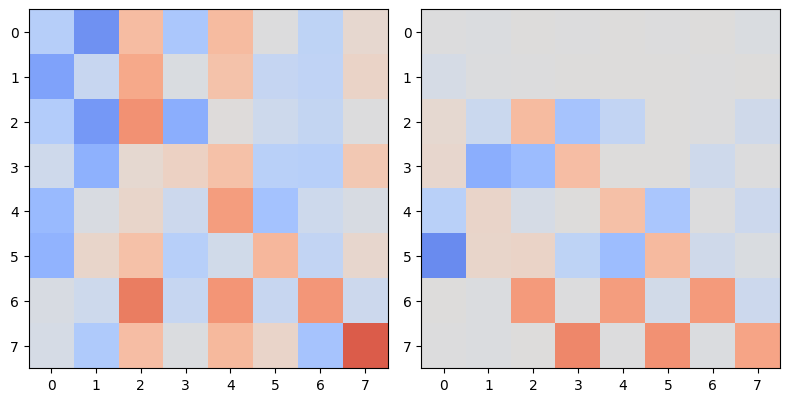

cosine_similarity measure: 0.625
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5357  1.6748
      2        0.4829  1.6300
      3        0.4370  1.6397
      4        0.3966  1.7198
      5        0.3631  1.7201
      6        0.3371  1.6617
      7        0.3199  1.5927
      8        0.3105  1.6514
      9        0.3016  1.6325
     10        0.2901  1.6569
     11        0.2789  1.6987
     12        0.2705  1.6206
     13        0.2644  1.6051
     14        0.2593  1.6216
     15        0.2542  1.5728
     16        0.2488  1.6617
     17        0.2432  1.6541
     18        0.2380  1.6955
     19        0.2334  1.6258
     20        0.2297  1.7058
     21        0.2265  1.6315
     22        0.2230  1.6669
     23        0.2193  1.6380
     24        0.2162  1.6118
     25        0.2135  1.5844
     26        0.2112  1.6483
     27        0.2084  1.6708
     28        0.2056  1.6333
     29        0.2027  1.5966
     30        0.2

    237        0.0734  1.7010
    238        0.0746  1.6354
    239        0.0707  1.6137
    240        0.0709  1.6996
    241        0.0720  1.6300
    242        0.0707  1.7030
    243        0.0725  1.6145
    244        0.0715  1.6048
    245        0.0722  1.6678
    246        0.0721  1.7071
    247        0.0720  1.6468
    248        0.0711  1.6485
    249        0.0715  1.6959
    250        0.0708  1.6530
    251        0.0716  1.5818
    252        0.0705  1.5691
    253        0.0710  1.5880
    254        0.0712  1.6149
    255        0.0708  1.5911
    256        0.0733  1.5660
    257        0.0717  1.6006
    258        0.0719  1.6329
    259        0.0747  1.6658
    260        0.0706  1.7233
    261        0.0745  1.6619
    262        0.0739  1.5944
    263        0.0726  1.7195
    264        0.0740  1.6505
    265        0.0717  1.6453
    266        0.0716  1.6468
    267        0.0733  1.6335
    268        0.0702  1.5796
    269        0.0743  1.6124
    270   

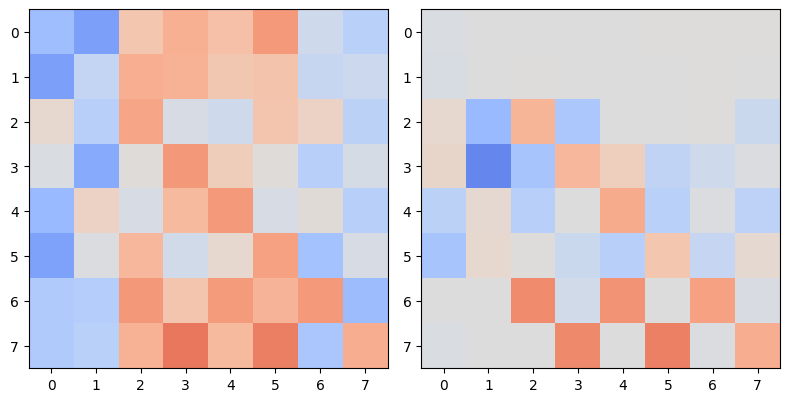

cosine_similarity measure: 0.664
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5802  1.6219
      2        0.5225  1.6888
      3        0.4730  1.6128
      4        0.4310  1.6509
      5        0.3957  1.6075
      6        0.3674  1.6190
      7        0.3454  1.6069
      8        0.3301  1.6361
      9        0.3194  1.6538
     10        0.3090  1.6033
     11        0.2976  1.6234
     12        0.2866  1.6636
     13        0.2770  1.6665
     14        0.2692  1.6376
     15        0.2628  1.6618
     16        0.2564  1.6073
     17        0.2500  1.6669
     18        0.2432  1.7900
     19        0.2366  1.7033
     20        0.2313  1.6213
     21        0.2273  1.6237
     22        0.2235  1.7283
     23        0.2190  1.6429
     24        0.2147  1.6149
     25        0.2114  1.6731
     26        0.2091  1.6491
     27        0.2069  1.6594
     28        0.2042  1.6309
     29        0.2014  1.6334
     30        0.1

    243        0.0708  1.6127
    244        0.0699  1.6015
    245        0.0701  1.5539
    246        0.0704  1.6103
    247        0.0705  1.6017
    248        0.0687  1.6599
    249        0.0722  1.6805
    250        0.0723  1.6090
    251        0.0696  1.6288
    252        0.0717  1.6879
    253        0.0701  1.6536
    254        0.0697  1.6276
    255        0.0709  1.5697
    256        0.0697  1.5703
    257        0.0687  1.6296
    258        0.0689  1.6888
    259        0.0695  1.6607
    260        0.0703  1.6292
    261        0.0699  1.7372
    262        0.0695  1.6216
    263        0.0697  1.6644
    264        0.0714  1.6987
    265        0.0717  1.5912
    266        0.0701  1.6055
    267        0.0701  1.6247
    268        0.0691  1.6491
    269        0.0692  1.5492
    270        0.0689  1.6290
    271        0.0689  1.6086
    272        0.0687  1.5886
    273        0.0684  1.7140
    274        0.0698  1.6192
    275        0.0683  1.6187
    276   

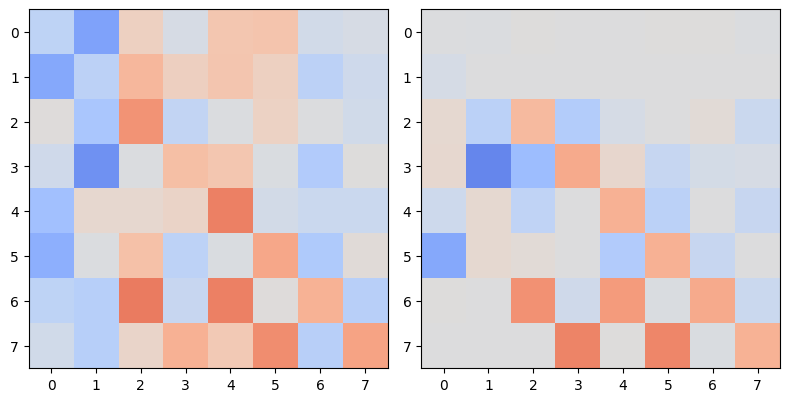

cosine_similarity measure: 0.765
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5300  1.5936
      2        0.4745  1.6205
      3        0.4266  1.5605
      4        0.3851  1.6662
      5        0.3494  1.6068
      6        0.3198  1.6743
      7        0.2974  1.5918
      8        0.2852  1.6401
      9        0.2804  1.6254
     10        0.2728  1.6444
     11        0.2606  1.6771
     12        0.2491  1.6299
     13        0.2415  1.6349
     14        0.2369  1.6506
     15        0.2341  1.6834
     16        0.2314  1.6327
     17        0.2277  1.5989
     18        0.2235  1.6952
     19        0.2190  1.6503
     20        0.2146  1.5950
     21        0.2111  1.6328
     22        0.2085  1.6853
     23        0.2062  1.6300
     24        0.2035  1.6360
     25        0.2000  1.6027
     26        0.1973  1.7072
     27        0.1953  1.6423
     28        0.1942  1.6675
     29        0.1927  1.5808
     30        0.1

    236        0.0701  1.7098
    237        0.0696  1.8789
    238        0.0684  1.9989
    239        0.0703  1.7983
    240        0.0712  1.7577
    241        0.0691  1.7288
    242        0.0696  1.6542
    243        0.0692  1.6963
    244        0.0690  1.7369
    245        0.0693  1.7856
    246        0.0697  1.7452
    247        0.0694  1.7051
    248        0.0702  1.7186
    249        0.0698  1.6861
    250        0.0693  1.7066
    251        0.0701  1.6411
    252        0.0683  1.6113
    253        0.0715  1.7230
    254        0.0694  1.7505
    255        0.0704  1.6654
    256        0.0700  2.0139
    257        0.0715  2.0944
    258        0.0710  1.9671
    259        0.0704  1.9075
    260        0.0720  1.9607
    261        0.0698  1.8399
    262        0.0715  2.0253
    263        0.0704  1.8998
    264        0.0715  1.7035
    265        0.0693  1.8781
    266        0.0705  1.7074
    267        0.0707  1.8637
    268        0.0701  1.9906
    269   

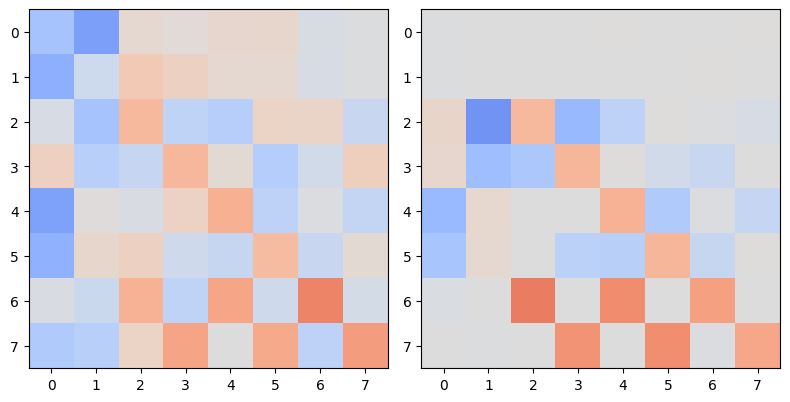

cosine_similarity measure: 0.79
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5304  1.7344
      2        0.4790  1.6737
      3        0.4371  1.7325
      4        0.4014  1.7954
      5        0.3709  1.6999
      6        0.3452  1.7030
      7        0.3257  1.7491
      8        0.3123  1.7271
      9        0.3014  1.7286
     10        0.2894  1.6737
     11        0.2766  1.6505
     12        0.2662  1.7574
     13        0.2580  1.7711
     14        0.2512  1.6926
     15        0.2448  1.7197
     16        0.2385  1.7532
     17        0.2325  1.6934
     18        0.2275  1.7705
     19        0.2241  1.7223
     20        0.2220  1.7157
     21        0.2190  1.7808
     22        0.2154  1.7592
     23        0.2126  1.6386
     24        0.2100  1.6891
     25        0.2078  1.6922
     26        0.2053  1.7289
     27        0.2022  1.8139
     28        0.1993  1.6813
     29        0.1964  1.6779
     30        0.19

    238        0.0717  1.6714
    239        0.0710  1.6945
    240        0.0724  1.6355
    241        0.0693  1.6829
    242        0.0746  1.6638
    243        0.0741  1.7264
    244        0.0742  1.6150
    245        0.0736  1.6554
    246        0.0738  1.6372
    247        0.0758  1.6148
    248        0.0720  1.6686
    249        0.0755  1.6543
    250        0.0712  1.5873
    251        0.0760  1.5579
    252        0.0764  1.6349
    253        0.0716  1.6635
    254        0.0795  1.6252
    255        0.0737  1.6341
    256        0.0739  1.6582
    257        0.0731  1.6415
    258        0.0733  1.6222
    259        0.0715  1.6202
    260        0.0744  1.5870
    261        0.0726  1.6555
    262        0.0732  1.5792
    263        0.0719  1.6970
    264        0.0729  1.6502
    265        0.0718  1.6005
    266        0.0689  1.6572
    267        0.0714  1.6960
    268        0.0688  1.6736
    269        0.0718  1.6818
    270        0.0694  1.6513
    271   

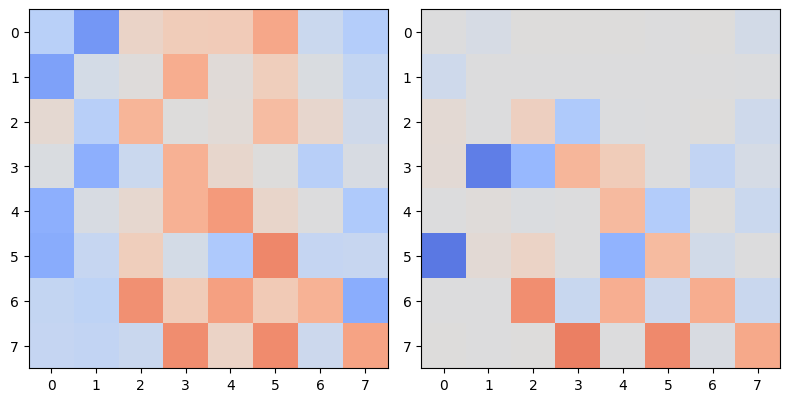

cosine_similarity measure: 0.696
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5521  1.6604
      2        0.4987  1.6694
      3        0.4527  1.6532
      4        0.4116  1.6967
      5        0.3762  1.5847
      6        0.3463  1.6733
      7        0.3235  1.5842
      8        0.3094  1.6393
      9        0.3015  1.6836
     10        0.2920  1.6592
     11        0.2806  1.6981
     12        0.2701  1.6177
     13        0.2637  1.6682
     14        0.2596  1.6406
     15        0.2566  1.6975
     16        0.2532  1.6385
     17        0.2495  1.6279
     18        0.2453  1.7380
     19        0.2405  1.6039
     20        0.2363  1.6945
     21        0.2329  1.6812
     22        0.2303  1.6112
     23        0.2276  1.7072
     24        0.2240  1.6021
     25        0.2204  1.6180
     26        0.2177  1.5951
     27        0.2156  1.6338
     28        0.2134  1.6196
     29        0.2107  1.6362
     30        0.2

    233        0.0713  1.6279
    234        0.0758  1.6568
    235        0.0713  1.6596
    236        0.0759  1.6521
    237        0.0723  1.6105
    238        0.0778  1.5888
    239        0.0707  1.7032
    240        0.0738  1.5933
    241        0.0714  1.6567
    242        0.0732  1.6414
    243        0.0704  1.6649
    244        0.0738  1.6602
    245        0.0703  1.6129
    246        0.0740  1.6727
    247        0.0738  1.5865
    248        0.0763  1.6057
    249        0.0740  1.6505
    250        0.0704  1.6782
    251        0.0729  1.5824
    252        0.0730  1.6770
    253        0.0710  1.6246
    254        0.0747  1.6723
    255        0.0712  1.5992
    256        0.0738  1.6777
    257        0.0762  1.6436
    258        0.0700  1.6275
    259        0.0741  1.6546
    260        0.0749  1.6315
    261        0.0709  1.7015
    262        0.0739  1.6766
    263        0.0728  1.6496
    264        0.0715  1.6417
    265        0.0746  1.6656
    266   

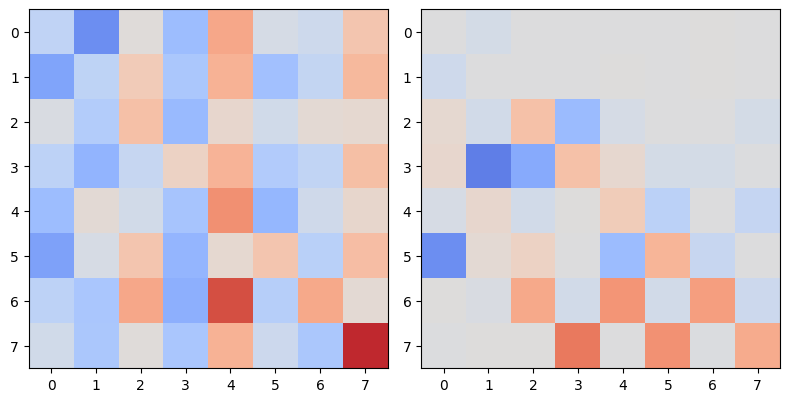

cosine_similarity measure: 0.498
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5172  1.6382
      2        0.4629  1.6390
      3        0.4154  1.6809
      4        0.3737  1.5780
      5        0.3383  1.6460
      6        0.3103  1.6825
      7        0.2934  1.5989
      8        0.2873  1.7009
      9        0.2803  1.6777
     10        0.2692  1.6277
     11        0.2587  1.6566
     12        0.2519  1.6421
     13        0.2481  1.6319
     14        0.2454  1.6373
     15        0.2425  1.6146
     16        0.2389  1.5866
     17        0.2345  1.7065
     18        0.2296  1.6600
     19        0.2251  1.6617
     20        0.2214  1.6356
     21        0.2189  1.6487
     22        0.2168  1.5673
     23        0.2143  1.7063
     24        0.2109  1.5819
     25        0.2078  1.7150
     26        0.2056  1.7090
     27        0.2040  1.5953
     28        0.2025  1.6980
     29        0.2004  1.5842
     30        0.1

    236        0.0720  1.6052
    237        0.0706  1.6685
    238        0.0710  1.6374
    239        0.0727  1.6432
    240        0.0698  1.5698
    241        0.0733  1.6388
    242        0.0690  1.7130
    243        0.0709  1.6012
    244        0.0691  1.6484
    245        0.0711  1.6656
    246        0.0689  1.6888
    247        0.0720  1.5916
    248        0.0706  1.8331
    249        0.0698  1.8539
    250        0.0708  2.0326
    251        0.0696  1.8787
    252        0.0697  1.8620
    253        0.0698  1.9518
    254        0.0705  1.7611
    255        0.0697  1.8241
    256        0.0713  1.8867
    257        0.0700  1.7065
    258        0.0710  2.0233
    259        0.0700  1.7871
    260        0.0718  1.9047
    261        0.0735  1.7119
    262        0.0694  1.7652
    263        0.0713  1.7854
    264        0.0701  1.8426
    265        0.0707  1.8740
    266        0.0695  1.8847
    267        0.0693  1.9296
    268        0.0686  1.8799
    269   

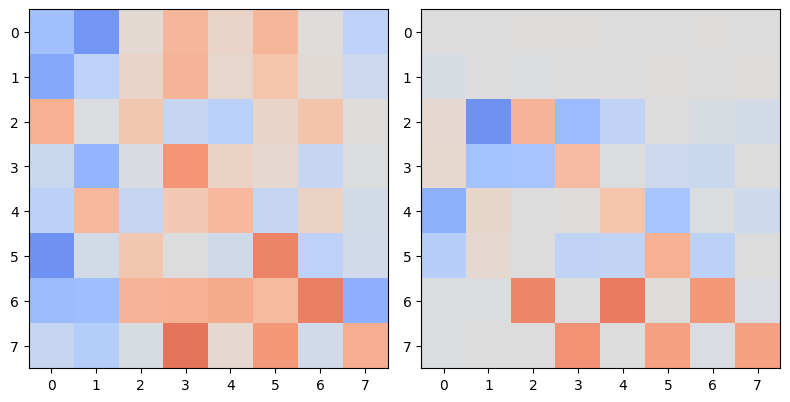

cosine_similarity measure: 0.616
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5318  1.8343
      2        0.4761  1.8945
      3        0.4286  1.9263
      4        0.3876  1.7154
      5        0.3528  1.5954
      6        0.3237  1.5162
      7        0.3035  1.6162
      8        0.2946  1.6132
      9        0.2900  1.6505
     10        0.2797  1.6510
     11        0.2669  1.7697
     12        0.2563  1.6008
     13        0.2494  1.6061
     14        0.2451  1.6242
     15        0.2415  1.8186
     16        0.2380  1.6719
     17        0.2343  1.5633
     18        0.2303  1.6281
     19        0.2268  1.5668
     20        0.2236  1.5774
     21        0.2212  1.6343
     22        0.2196  1.6097
     23        0.2171  1.7100
     24        0.2142  1.6094
     25        0.2116  1.6043
     26        0.2094  1.5738
     27        0.2078  1.5982
     28        0.2062  1.5516
     29        0.2042  1.6346
     30        0.2

    235        0.0723  1.5095
    236        0.0753  1.5920
    237        0.0716  1.5654
    238        0.0747  1.6566
    239        0.0718  1.5733
    240        0.0725  1.7636
    241        0.0750  1.6663
    242        0.0707  1.5931
    243        0.0743  1.6333
    244        0.0723  1.6010
    245        0.0718  1.6060
    246        0.0717  1.5930
    247        0.0736  1.6432
    248        0.0736  1.5831
    249        0.0739  1.6719
    250        0.0723  1.6201
    251        0.0715  1.6597
    252        0.0719  1.6163
    253        0.0707  1.6457
    254        0.0725  1.6192
    255        0.0721  1.6046
    256        0.0712  1.6444
    257        0.0716  1.6817
    258        0.0753  1.6725
    259        0.0736  1.6631
    260        0.0715  1.5983
    261        0.0743  1.5891
    262        0.0709  1.6160
    263        0.0778  1.6484
    264        0.0731  1.5846
    265        0.0748  1.6285
    266        0.0769  1.5886
    267        0.0714  1.5814
    268   

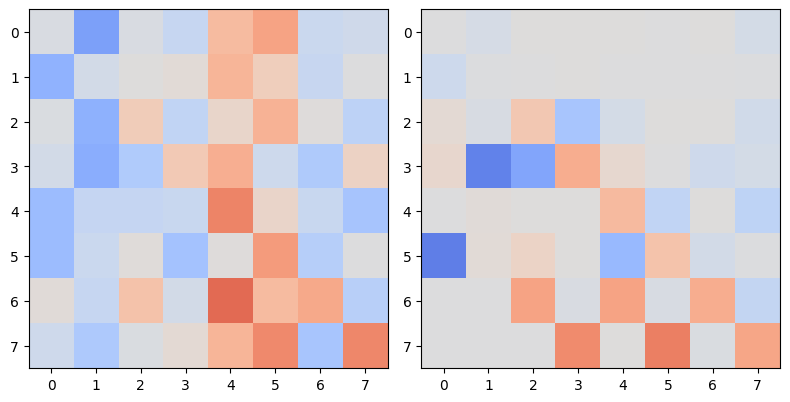

cosine_similarity measure: 0.624
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5645  1.6726
      2        0.5092  1.6563
      3        0.4608  1.6168
      4        0.4199  1.5750
      5        0.3858  1.5727
      6        0.3581  1.6079
      7        0.3386  1.6028
      8        0.3274  1.6692
      9        0.3197  1.6050
     10        0.3086  1.5346
     11        0.2952  1.6757
     12        0.2831  1.5491
     13        0.2736  1.6735
     14        0.2663  1.5624
     15        0.2597  1.5505
     16        0.2536  1.5808
     17        0.2471  1.6335
     18        0.2415  1.5720
     19        0.2373  1.5911
     20        0.2347  1.5406
     21        0.2319  1.5991
     22        0.2285  1.5353
     23        0.2245  1.5827
     24        0.2217  1.6058
     25        0.2194  1.6402
     26        0.2171  1.6636
     27        0.2143  1.5978
     28        0.2112  1.6828
     29        0.2090  1.6129
     30        0.2

    233        0.0845  1.6413
    234        0.0857  1.6041
    235        0.0843  1.6630
    236        0.0896  1.6538
    237        0.0917  1.5343
    238        0.0825  1.6437
    239        0.0837  1.6111
    240        0.0897  1.6156
    241        0.0858  1.5254
    242        0.0896  1.6502
    243        0.0878  1.5580
    244        0.0828  1.6466
    245        0.0842  1.5555
    246        0.0879  1.5654
    247        0.0814  1.6615
    248        0.0878  1.5619
    249        0.0837  1.5919
    250        0.0856  1.6032
    251        0.0819  1.5546
    252        0.0837  1.6598
    253        0.0823  1.5804
    254        0.0833  1.6890
    255        0.0819  1.5580
    256        0.0830  1.6503
    257        0.0844  1.5465
    258        0.0806  1.6301
    259        0.0852  1.6335
    260        0.0797  1.6433
    261        0.0850  1.6141
    262        0.0926  1.6509
    263        0.0884  1.5993
    264        0.0986  1.6376
    265        0.0870  1.5532
    266   

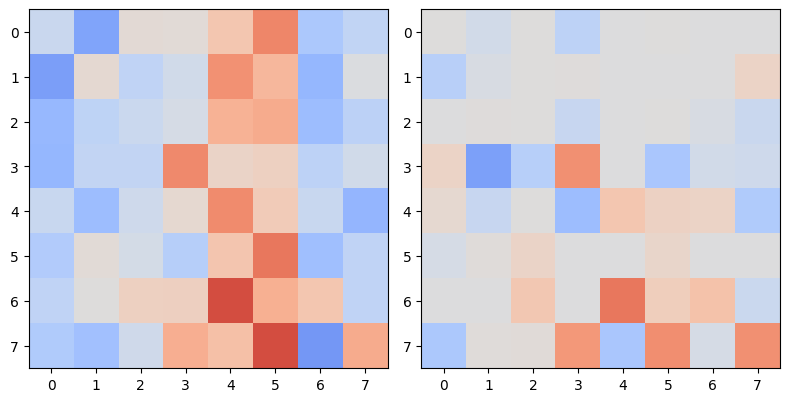

cosine_similarity measure: 0.538
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5089  1.5996
      2        0.4566  1.6133
      3        0.4095  1.6557
      4        0.3665  1.6087
      5        0.3284  1.5847
      6        0.2980  1.6557
      7        0.2813  1.6570
      8        0.2813  1.5761
      9        0.2758  1.6438
     10        0.2617  1.6597
     11        0.2496  1.5912
     12        0.2427  1.6262
     13        0.2394  1.5764
     14        0.2372  1.6365
     15        0.2352  1.6168
     16        0.2327  1.6606
     17        0.2298  1.6805
     18        0.2258  1.6263
     19        0.2217  1.6043
     20        0.2181  1.6458
     21        0.2155  1.6502
     22        0.2141  1.7170
     23        0.2124  1.6073
     24        0.2098  1.6611
     25        0.2065  1.5713
     26        0.2032  1.6158
     27        0.2008  1.5631
     28        0.1994  1.6547
     29        0.1979  1.6751
     30        0.1

    237        0.0714  1.5660
    238        0.0726  1.6676
    239        0.0696  1.5953
    240        0.0749  1.6115
    241        0.0711  1.6145
    242        0.0729  1.6477
    243        0.0702  1.7047
    244        0.0733  1.6503
    245        0.0718  1.6692
    246        0.0721  1.6523
    247        0.0717  1.6511
    248        0.0713  1.6724
    249        0.0710  1.6168
    250        0.0695  1.6555
    251        0.0714  1.6516
    252        0.0713  1.6834
    253        0.0695  1.6566
    254        0.0727  1.6872
    255        0.0689  1.5850
    256        0.0718  1.6108
    257        0.0704  1.5812
    258        0.0712  1.6371
    259        0.0705  1.6021
    260        0.0711  1.7103
    261        0.0706  1.6124
    262        0.0697  1.6015
    263        0.0708  1.7166
    264        0.0697  1.6212
    265        0.0704  1.5984
    266        0.0690  1.6343
    267        0.0701  1.6098
    268        0.0699  1.6097
    269        0.0693  1.6709
    270   

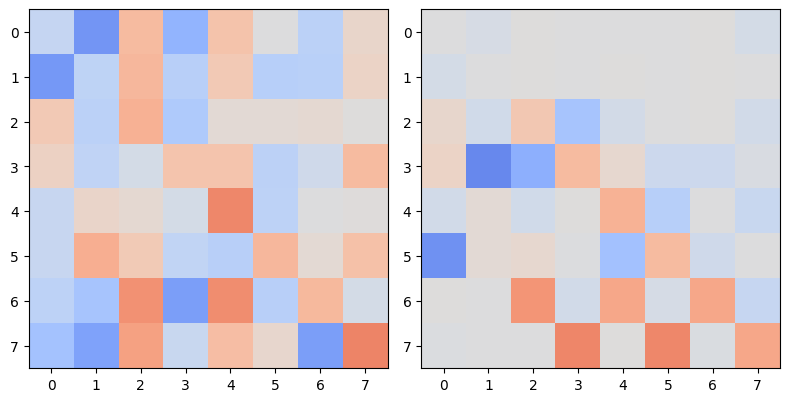

cosine_similarity measure: 0.469
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5765  1.6395
      2        0.5164  1.6436
      3        0.4649  1.6810
      4        0.4204  1.6938
      5        0.3822  1.6723
      6        0.3499  1.7735
      7        0.3238  1.5920
      8        0.3050  1.6238
      9        0.2938  1.7021
     10        0.2884  1.6913
     11        0.2837  1.7163
     12        0.2757  1.7303
     13        0.2664  1.6639
     14        0.2585  1.6309
     15        0.2526  1.6711
     16        0.2487  1.6178
     17        0.2456  1.6982
     18        0.2425  1.7368
     19        0.2393  1.6048
     20        0.2354  1.6521
     21        0.2313  1.7723
     22        0.2270  1.6648
     23        0.2234  1.5730
     24        0.2206  1.6588
     25        0.2187  1.7025
     26        0.2169  1.7332
     27        0.2137  1.6329
     28        0.2102  1.6551
     29        0.2070  1.5991
     30        0.2

    237        0.0760  1.6438
    238        0.0717  1.6872
    239        0.0754  1.6481
    240        0.0763  1.6897
    241        0.0735  1.6011
    242        0.0796  1.6668
    243        0.0741  1.6539
    244        0.0730  1.6482
    245        0.0747  1.5891
    246        0.0711  1.6811
    247        0.0751  1.6272
    248        0.0715  1.6417
    249        0.0736  1.6098
    250        0.0716  1.7495
    251        0.0727  1.6085
    252        0.0731  1.7375
    253        0.0726  1.7560
    254        0.0743  1.6424
    255        0.0727  1.7122
    256        0.0719  1.7054
    257        0.0736  1.7255
    258        0.0710  1.7100
    259        0.0710  1.6395
    260        0.0704  1.6737
    261        0.0714  1.5785
    262        0.0705  1.6880
    263        0.0706  1.6877
    264        0.0751  1.6004
    265        0.0752  1.6583
    266        0.0740  1.7495
    267        0.0701  1.6456
    268        0.0736  1.6864
    269        0.0754  1.6641
    270   

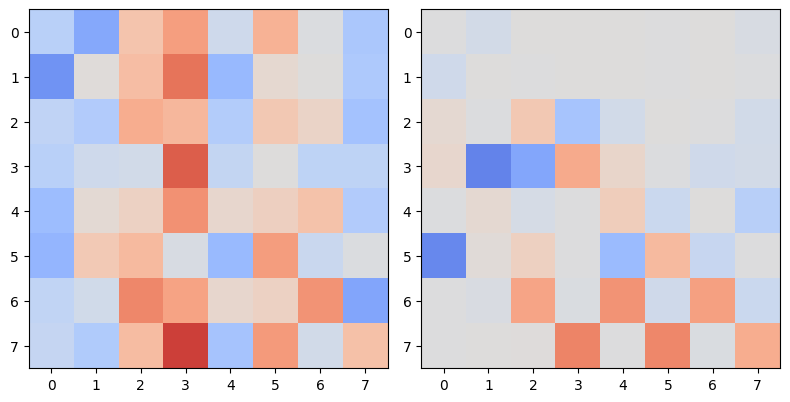

cosine_similarity measure: 0.536
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5667  1.7436
      2        0.5090  1.6375
      3        0.4575  1.5140
      4        0.4122  1.5994
      5        0.3748  1.7083
      6        0.3452  1.6177
      7        0.3253  1.6613
      8        0.3158  1.5546
      9        0.3102  1.6729
     10        0.2994  1.5601
     11        0.2869  1.6094
     12        0.2761  1.6981
     13        0.2690  1.6945
     14        0.2640  1.6242
     15        0.2601  1.6138
     16        0.2558  1.6467
     17        0.2511  1.7171
     18        0.2457  1.6400
     19        0.2402  1.6077
     20        0.2353  1.6561
     21        0.2316  1.6761
     22        0.2289  1.5808
     23        0.2264  1.7471
     24        0.2231  1.5962
     25        0.2194  1.6056
     26        0.2158  1.6430
     27        0.2132  1.6210
     28        0.2112  1.5902
     29        0.2094  1.7500
     30        0.2

    233        0.0724  1.5577
    234        0.0737  1.5651
    235        0.0719  1.5412
    236        0.0720  1.6092
    237        0.0724  1.4857
    238        0.0716  1.5424
    239        0.0746  1.6235
    240        0.0707  1.5579
    241        0.0723  1.6345
    242        0.0711  1.5823
    243        0.0712  1.5432
    244        0.0710  1.6252
    245        0.0708  1.6198
    246        0.0711  1.5585
    247        0.0708  1.5083
    248        0.0709  1.5805
    249        0.0718  1.6358
    250        0.0716  1.5307
    251        0.0706  1.7204
    252        0.0722  1.5427
    253        0.0701  1.5626
    254        0.0701  1.6155
    255        0.0740  1.5261
    256        0.0732  1.5832
    257        0.0718  1.6030
    258        0.0702  1.5600
    259        0.0732  1.6413
    260        0.0712  1.6165
    261        0.0708  1.6747
    262        0.0709  1.5443
    263        0.0721  1.5582
    264        0.0735  1.5420
    265        0.0707  1.5489
    266   

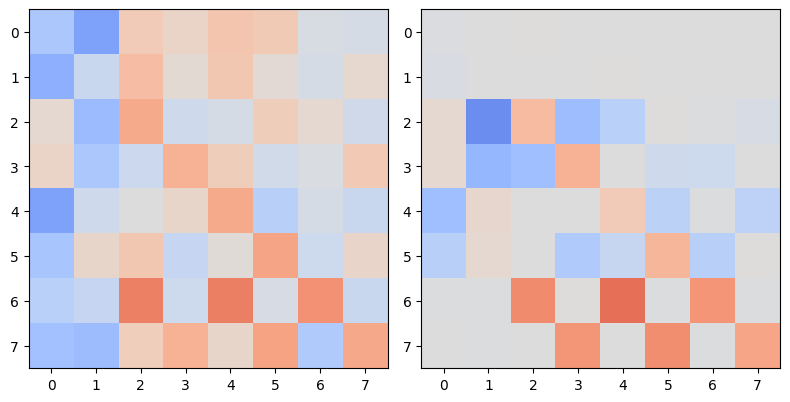

cosine_similarity measure: 0.75
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5885  1.5036
      2        0.5256  1.5780
      3        0.4724  1.6239
      4        0.4271  1.4849
      5        0.3879  1.6462
      6        0.3542  1.5551
      7        0.3261  1.6003
      8        0.3067  1.6214
      9        0.2971  1.6055
     10        0.2934  1.5271
     11        0.2857  1.5370
     12        0.2749  1.6766
     13        0.2647  1.4817
     14        0.2576  1.5611
     15        0.2533  1.5921
     16        0.2501  1.5638
     17        0.2470  1.5945
     18        0.2433  1.5714
     19        0.2394  1.4629
     20        0.2347  1.5764
     21        0.2300  1.6714
     22        0.2258  1.5302
     23        0.2218  1.5474
     24        0.2187  1.6279
     25        0.2163  1.6152
     26        0.2134  1.5604
     27        0.2096  1.6179
     28        0.2059  1.4996
     29        0.2030  1.6575
     30        0.20

    241        0.0699  1.6012
    242        0.0713  1.5863
    243        0.0712  1.6590
    244        0.0689  1.5799
    245        0.0699  1.5770
    246        0.0683  1.6795
    247        0.0703  1.6630
    248        0.0691  1.6409
    249        0.0683  1.6024
    250        0.0683  1.5954
    251        0.0705  1.6271
    252        0.0699  1.6912
    253        0.0687  1.5584
    254        0.0707  1.7195
    255        0.0696  1.5892
    256        0.0683  1.6098
    257        0.0706  1.5603
    258        0.0707  1.6553
    259        0.0692  1.6163
    260        0.0709  1.6657
    261        0.0709  1.6120
    262        0.0695  1.6835
    263        0.0691  1.6148
    264        0.0701  1.5372
    265        0.0707  1.7311
    266        0.0692  1.6690
    267        0.0714  1.6055
    268        0.0709  1.6209
    269        0.0697  1.6561
    270        0.0715  1.5895
    271        0.0691  1.6730
    272        0.0719  1.5684
    273        0.0687  1.6935
    274   

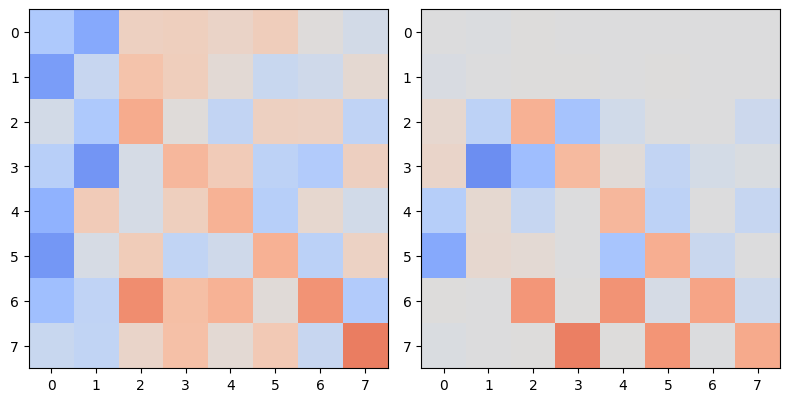

cosine_similarity measure: 0.724
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5748  1.5811
      2        0.5199  1.6467
      3        0.4741  1.6686
      4        0.4353  1.5988
      5        0.4011  1.5779
      6        0.3712  1.5927
      7        0.3472  1.6292
      8        0.3322  1.6995
      9        0.3222  1.6843
     10        0.3085  1.6601
     11        0.2929  1.5638
     12        0.2796  1.6437
     13        0.2705  1.6782
     14        0.2637  1.6069
     15        0.2581  1.6175
     16        0.2525  1.6192
     17        0.2465  1.6213
     18        0.2403  1.7338
     19        0.2345  1.6105
     20        0.2298  1.6789
     21        0.2262  1.5338
     22        0.2236  1.6162
     23        0.2203  1.6015
     24        0.2170  1.5616
     25        0.2140  1.5291
     26        0.2120  1.6063
     27        0.2104  1.5957
     28        0.2086  1.5627
     29        0.2065  1.6163
     30        0.2

    234        0.0776  1.6628
    235        0.0734  1.5393
    236        0.0754  1.6430
    237        0.0727  1.5611
    238        0.0740  1.5577
    239        0.0729  1.6744
    240        0.0731  1.6557
    241        0.0722  1.6022
    242        0.0725  1.7015
    243        0.0721  1.5794
    244        0.0729  1.6401
    245        0.0713  1.6566
    246        0.0732  1.5579
    247        0.0747  1.6075
    248        0.0717  1.6372
    249        0.0743  1.6726
    250        0.0734  1.6679
    251        0.0738  1.6403
    252        0.0757  1.6271
    253        0.0757  1.6120
    254        0.0784  1.5637
    255        0.0736  1.6139
    256        0.0771  1.5921
    257        0.0750  1.6537
    258        0.0747  1.5960
    259        0.0741  1.6963
    260        0.0763  1.5952
    261        0.0713  1.6016
    262        0.0748  1.6110
    263        0.0727  1.5991
    264        0.0776  1.6531
    265        0.0755  1.6285
    266        0.0756  1.6293
    267   

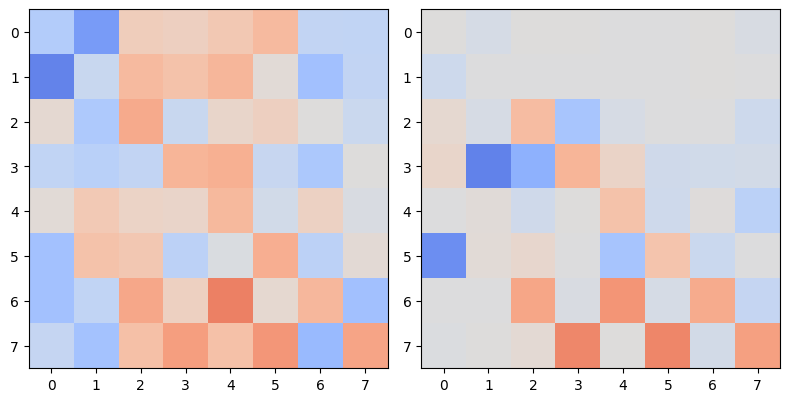

cosine_similarity measure: 0.635
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5270  1.6397
      2        0.4696  1.6506
      3        0.4220  1.5912
      4        0.3835  1.5937
      5        0.3523  1.5943
      6        0.3274  1.6053
      7        0.3091  1.6304
      8        0.2989  1.6186
      9        0.2937  1.5980
     10        0.2866  1.7190
     11        0.2758  1.6460
     12        0.2659  1.7010
     13        0.2590  1.6152
     14        0.2551  1.6533
     15        0.2522  1.6244
     16        0.2490  1.6528
     17        0.2458  1.5769
     18        0.2416  1.6227
     19        0.2373  1.5701
     20        0.2335  1.5983
     21        0.2302  1.5855
     22        0.2277  1.6005
     23        0.2246  1.6127
     24        0.2209  1.5604
     25        0.2174  1.6210
     26        0.2142  1.6043
     27        0.2119  1.5749
     28        0.2097  1.6864
     29        0.2074  1.6739
     30        0.2

    232        0.0762  1.6883
    233        0.0738  1.5898
    234        0.0758  1.7183
    235        0.0773  1.5598
    236        0.0728  1.6265
    237        0.0738  1.6269
    238        0.0743  1.5885
    239        0.0729  1.7201
    240        0.0727  1.5930
    241        0.0732  1.6201
    242        0.0734  1.6460
    243        0.0730  1.5562
    244        0.0726  1.6914
    245        0.0732  1.5416
    246        0.0723  1.6027
    247        0.0754  1.6139
    248        0.0735  1.7235
    249        0.0733  1.5849
    250        0.0738  1.5648
    251        0.0730  1.6508
    252        0.0731  1.5955
    253        0.0738  1.5848
    254        0.0737  1.6568
    255        0.0742  1.6798
    256        0.0773  1.6653
    257        0.0734  1.5417
    258        0.0742  1.6330
    259        0.0753  1.6412
    260        0.0740  1.6008
    261        0.0716  1.6143
    262        0.0735  1.6601
    263        0.0721  1.6187
    264        0.0745  1.6655
    265   

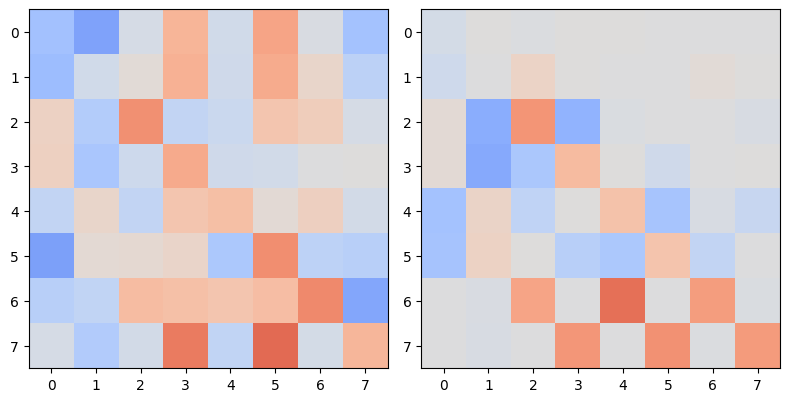

cosine_similarity measure: 0.666
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5107  1.5538
      2        0.4527  1.6515
      3        0.3989  1.5103
      4        0.3522  1.5328
      5        0.3152  1.6911
      6        0.2892  1.7162
      7        0.2770  1.6348
      8        0.2775  1.5911
      9        0.2748  1.6438
     10        0.2647  1.6536
     11        0.2543  1.5787
     12        0.2474  1.6511
     13        0.2435  1.4961
     14        0.2414  1.5411
     15        0.2398  1.6548
     16        0.2376  1.5764
     17        0.2349  1.6270
     18        0.2312  1.6550
     19        0.2269  1.6515
     20        0.2224  1.5432
     21        0.2181  1.6781
     22        0.2147  1.5863
     23        0.2122  1.5369
     24        0.2097  1.5057
     25        0.2063  1.6617
     26        0.2028  1.5591
     27        0.1995  1.5810
     28        0.1971  1.6234
     29        0.1953  1.6131
     30        0.1

    236        0.0692  1.6614
    237        0.0704  1.6938
    238        0.0699  1.6016
    239        0.0688  1.6888
    240        0.0709  1.6545
    241        0.0689  1.6396
    242        0.0712  1.6368
    243        0.0684  1.6856
    244        0.0703  1.5491
    245        0.0713  1.7332
    246        0.0701  1.6512
    247        0.0701  1.6980
    248        0.0716  1.6698
    249        0.0702  1.6261
    250        0.0715  1.5901
    251        0.0751  1.6251
    252        0.0698  1.6966
    253        0.0704  1.6245
    254        0.0711  1.5987
    255        0.0692  1.6786
    256        0.0725  1.5543
    257        0.0704  1.6101
    258        0.0692  1.6552
    259        0.0718  1.6689
    260        0.0701  1.5331
    261        0.0707  1.5758
    262        0.0702  1.4929
    263        0.0704  1.5442
    264        0.0689  1.5742
    265        0.0685  1.5534
    266        0.0681  1.6106
    267        0.0671  1.6442
    268        0.0684  1.5400
    269   

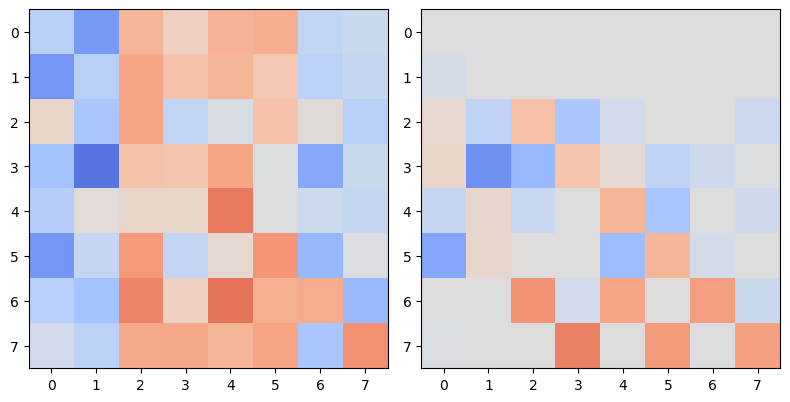

cosine_similarity measure: 0.611
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5657  1.5690
      2        0.5058  1.6227
      3        0.4559  1.6382
      4        0.4145  1.5953
      5        0.3799  1.6432
      6        0.3508  1.6125
      7        0.3279  1.6206
      8        0.3110  1.5719
      9        0.3007  1.7083
     10        0.2921  1.6257
     11        0.2815  1.5217
     12        0.2702  1.5646
     13        0.2606  1.6071
     14        0.2540  1.5564
     15        0.2492  1.5832
     16        0.2447  1.5947
     17        0.2401  1.6222
     18        0.2353  1.6835
     19        0.2306  1.6556
     20        0.2267  1.7281
     21        0.2237  1.5382
     22        0.2211  1.6034
     23        0.2180  1.6324
     24        0.2144  1.6829
     25        0.2117  1.6073
     26        0.2094  1.6034
     27        0.2078  1.6381
     28        0.2057  1.5778
     29        0.2034  1.5891
     30        0.2

    239        0.0720  1.7472
    240        0.0708  1.6559
    241        0.0698  1.6019
    242        0.0694  1.6938
    243        0.0719  1.6338
    244        0.0728  1.6229
    245        0.0697  1.6064
    246        0.0728  1.6207
    247        0.0726  1.6339
    248        0.0709  1.6596
    249        0.0722  1.6101
    250        0.0719  1.5542
    251        0.0702  1.6162
    252        0.0761  1.5923
    253        0.0696  1.5927
    254        0.0742  1.6264
    255        0.0716  1.6509
    256        0.0711  1.5865
    257        0.0710  1.5821
    258        0.0715  1.6222
    259        0.0695  1.6711
    260        0.0739  1.6435
    261        0.0685  1.6211
    262        0.0736  1.6261
    263        0.0698  1.5451
    264        0.0738  1.6015
    265        0.0697  1.6169
    266        0.0728  1.6661
    267        0.0708  1.5927
    268        0.0715  1.6005
    269        0.0717  1.5784
    270        0.0702  1.6276
    271        0.0710  1.5925
    272   

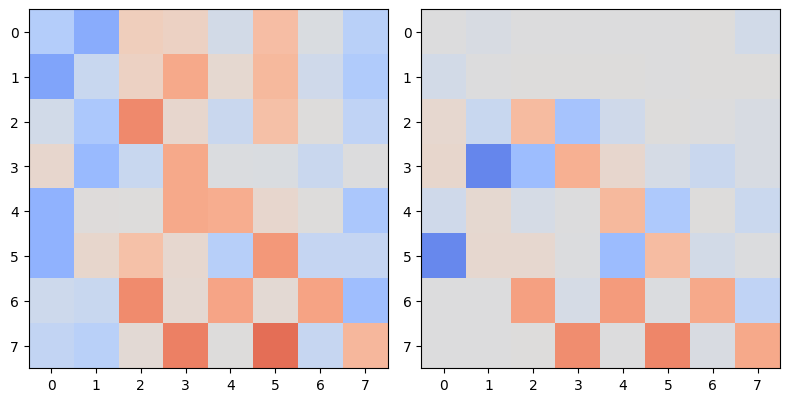

cosine_similarity measure: 0.73
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5529  1.6255
      2        0.4952  1.6068
      3        0.4479  1.5258
      4        0.4079  1.6513
      5        0.3741  1.6124
      6        0.3463  1.6015
      7        0.3249  1.6355
      8        0.3112  1.5529
      9        0.3037  1.6071
     10        0.2959  1.5822
     11        0.2854  1.6709
     12        0.2750  1.5801
     13        0.2668  1.6252
     14        0.2609  1.6010
     15        0.2560  1.6207
     16        0.2515  1.6364
     17        0.2467  1.6401
     18        0.2409  1.6226
     19        0.2354  1.6151
     20        0.2303  1.5463
     21        0.2264  1.7031
     22        0.2240  1.5920
     23        0.2217  1.5900
     24        0.2182  1.5850
     25        0.2143  1.6180
     26        0.2114  1.5780
     27        0.2095  1.5925
     28        0.2075  1.6185
     29        0.2053  1.5879
     30        0.20

    238        0.0772  1.5648
    239        0.0728  1.5869
    240        0.0727  1.5604
    241        0.0787  1.6141
    242        0.0732  1.5889
    243        0.0826  1.7028
    244        0.0765  1.5969
    245        0.0768  1.6840
    246        0.0765  1.6764
    247        0.0752  1.6401
    248        0.0792  1.5982
    249        0.0743  1.6845
    250        0.0769  1.5983
    251        0.0756  1.6072
    252        0.0776  1.5321
    253        0.0732  1.6662
    254        0.0765  1.5748
    255        0.0723  1.5618
    256        0.0744  1.6389
    257        0.0730  1.5995
    258        0.0743  1.7242
    259        0.0727  1.5720
    260        0.0729  1.6189
    261        0.0731  1.6257
    262        0.0713  1.6337
    263        0.0720  1.6732
    264        0.0714  1.6175
    265        0.0731  1.6025
    266        0.0767  1.6927
    267        0.0735  1.5721
    268        0.0773  1.6028
    269        0.0736  1.6340
    270        0.0790  1.6403
    271   

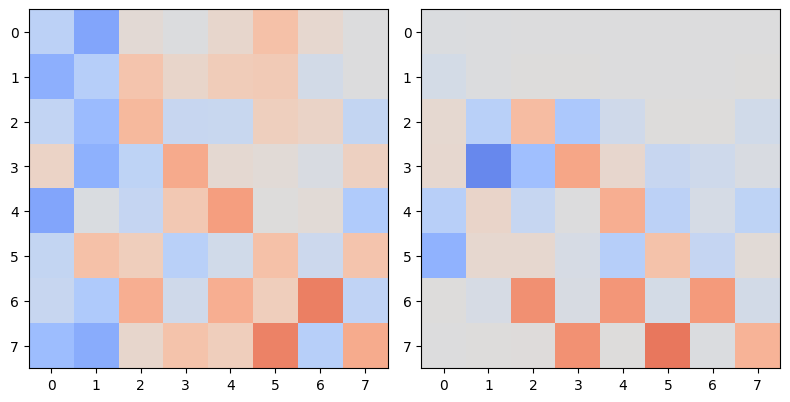

cosine_similarity measure: 0.717
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5444  1.6246
      2        0.4928  1.6572
      3        0.4507  1.5993
      4        0.4136  1.6064
      5        0.3805  1.5676
      6        0.3521  1.6282
      7        0.3307  1.5059
      8        0.3186  1.5687
      9        0.3098  1.6011
     10        0.2977  1.5725
     11        0.2845  1.5876
     12        0.2741  1.6016
     13        0.2680  1.6522
     14        0.2635  1.5766
     15        0.2594  1.5328
     16        0.2547  1.6495
     17        0.2494  1.5730
     18        0.2436  1.6804
     19        0.2385  1.6235
     20        0.2344  1.6971
     21        0.2312  1.5687
     22        0.2278  1.6109
     23        0.2239  1.5985
     24        0.2200  1.6737
     25        0.2164  1.5781
     26        0.2139  1.5781
     27        0.2112  1.5817
     28        0.2085  1.5846
     29        0.2049  1.5860
     30        0.2

    232        0.0779  1.5863
    233        0.0781  1.6199
    234        0.0792  1.7157
    235        0.0816  1.5744
    236        0.0914  1.5966
    237        0.0820  1.6780
    238        0.0829  1.6288
    239        0.0894  1.5218
    240        0.0802  1.7007
    241        0.0850  1.6124
    242        0.0862  1.5998
    243        0.0812  1.6309
    244        0.0888  1.5581
    245        0.0792  1.6647
    246        0.0816  1.6145
    247        0.0802  1.6640
    248        0.0797  1.5641
    249        0.0788  1.6439
    250        0.0786  1.5535
    251        0.0779  1.5796
    252        0.0794  1.6772
    253        0.0814  1.5821
    254        0.0815  1.6352
    255        0.0790  1.4821
    256        0.0797  1.5168
    257        0.0793  1.6083
    258        0.0781  1.5623
    259        0.0789  1.7049
    260        0.0787  1.5913
    261        0.0782  1.6178
    262        0.0777  1.6573
    263        0.0768  1.6322
    264        0.0766  1.5767
    265   

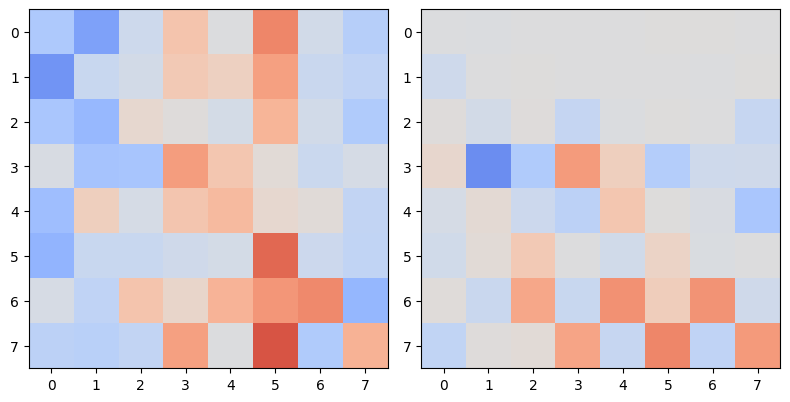

cosine_similarity measure: 0.618
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5649  1.5915
      2        0.5085  1.6477
      3        0.4598  1.5248
      4        0.4171  1.5578
      5        0.3793  1.6204
      6        0.3465  1.6596
      7        0.3198  1.5171
      8        0.3008  1.5430
      9        0.2907  1.6673
     10        0.2858  1.5708
     11        0.2792  1.5752
     12        0.2697  1.6375
     13        0.2601  1.6228
     14        0.2523  1.5771
     15        0.2463  1.6621
     16        0.2415  1.7065
     17        0.2368  1.6377
     18        0.2323  1.6168
     19        0.2278  1.6127
     20        0.2237  1.5367
     21        0.2206  1.6904
     22        0.2180  1.5836
     23        0.2153  1.6586
     24        0.2116  1.6868
     25        0.2079  1.6754
     26        0.2049  1.6173
     27        0.2030  1.5662
     28        0.2007  1.6133
     29        0.1985  1.5992
     30        0.1

    234        0.0730  1.6221
    235        0.0775  1.5244
    236        0.0721  1.6787
    237        0.0736  1.5859
    238        0.0737  1.6780
    239        0.0744  1.6209
    240        0.0734  1.6025
    241        0.0733  1.6187
    242        0.0763  1.6499
    243        0.0722  1.5980
    244        0.0848  1.6112
    245        0.0810  1.5941
    246        0.0787  1.6899
    247        0.0859  1.5239
    248        0.0745  1.5973
    249        0.0864  1.7510
    250        0.0775  1.6671
    251        0.0817  1.5892
    252        0.0772  1.5626
    253        0.0788  1.5631
    254        0.0771  1.6769
    255        0.0764  1.6322
    256        0.0749  1.5973
    257        0.0755  1.6329
    258        0.0727  1.6781
    259        0.0757  1.5961
    260        0.0740  1.7122
    261        0.0731  1.6189
    262        0.0749  1.5534
    263        0.0713  1.5449
    264        0.0754  1.5926
    265        0.0718  1.5976
    266        0.0722  1.5994
    267   

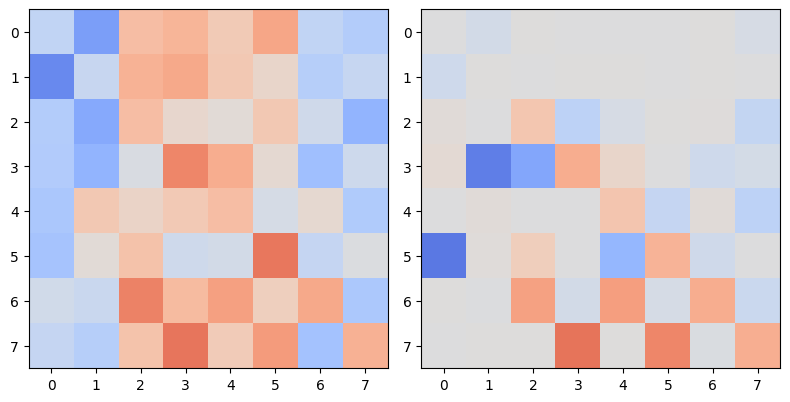

cosine_similarity measure: 0.628
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5398  1.5348
      2        0.4889  1.5523
      3        0.4470  1.5777
      4        0.4116  1.5945
      5        0.3819  1.5665
      6        0.3570  1.6066
      7        0.3377  1.6118
      8        0.3246  1.6390
      9        0.3157  1.5554
     10        0.3058  1.5992
     11        0.2948  1.7372
     12        0.2839  1.5522
     13        0.2753  1.5721
     14        0.2686  1.5944
     15        0.2628  1.6217
     16        0.2573  1.5490
     17        0.2521  1.5824
     18        0.2466  1.6065
     19        0.2419  1.6001
     20        0.2379  1.5753
     21        0.2344  1.5679
     22        0.2308  1.5964
     23        0.2269  1.6037
     24        0.2235  1.6262
     25        0.2212  1.5515
     26        0.2186  1.5620
     27        0.2161  1.6462
     28        0.2135  1.5380
     29        0.2114  1.5553
     30        0.2

    237        0.0745  1.5362
    238        0.0764  1.5882
    239        0.0772  1.5903
    240        0.0762  1.6767
    241        0.0783  1.5615
    242        0.0743  1.5932
    243        0.0761  1.6266
    244        0.0782  1.5670
    245        0.0820  1.7001
    246        0.0759  1.6640
    247        0.0797  1.5520
    248        0.0764  1.5742
    249        0.0762  1.6208
    250        0.0790  1.5864
    251        0.0785  1.6490
    252        0.0754  1.5718
    253        0.0776  1.6620
    254        0.0759  1.5568
    255        0.0758  1.5710
    256        0.0774  1.6053
    257        0.0737  1.6311
    258        0.0756  1.6502
    259        0.0735  1.5826
    260        0.0766  1.5938
    261        0.0742  1.6862
    262        0.0739  1.5806
    263        0.0740  1.6561
    264        0.0740  1.6475
    265        0.0731  1.6798
    266        0.0739  1.6155
    267        0.0765  1.6482
    268        0.0743  1.7055
    269        0.0729  1.6888
    270   

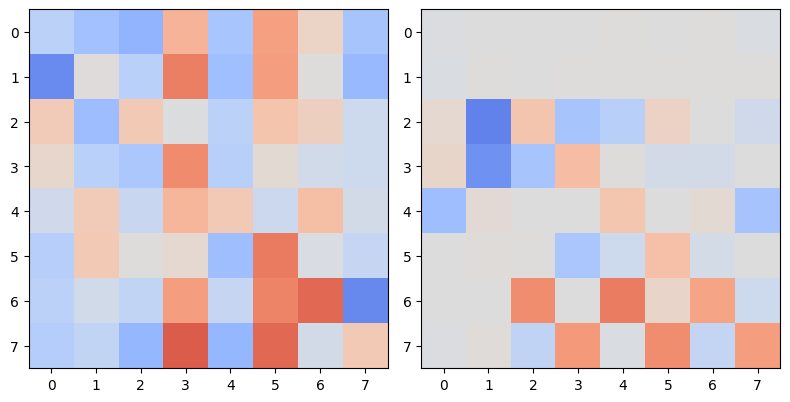

cosine_similarity measure: 0.459
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5450  1.5698
      2        0.4870  1.5725
      3        0.4365  1.7351
      4        0.3910  1.6375
      5        0.3498  1.6329
      6        0.3153  1.6941
      7        0.2914  1.6861
      8        0.2819  1.5936
      9        0.2833  1.5756
     10        0.2770  1.7059
     11        0.2651  1.6229
     12        0.2549  1.6087
     13        0.2487  1.5600
     14        0.2453  1.5213
     15        0.2432  1.6814
     16        0.2408  1.5671
     17        0.2383  1.5912
     18        0.2349  1.5830
     19        0.2311  1.6684
     20        0.2267  1.6405
     21        0.2225  1.6497
     22        0.2186  1.6310
     23        0.2157  1.5786
     24        0.2137  1.5955
     25        0.2117  1.6508
     26        0.2089  1.5832
     27        0.2053  1.6223
     28        0.2017  1.5754
     29        0.1992  1.5782
     30        0.1

    233        0.0716  1.6201
    234        0.0744  1.6300
    235        0.0723  1.5781
    236        0.0707  1.5820
    237        0.0785  1.6941
    238        0.0781  1.5950
    239        0.0739  1.5819
    240        0.0762  1.6012
    241        0.0738  1.5719
    242        0.0761  1.5598
    243        0.0739  1.5978
    244        0.0756  1.6425
    245        0.0718  1.6694
    246        0.0738  1.5777
    247        0.0748  1.6414
    248        0.0733  1.6561
    249        0.0746  1.6185
    250        0.0802  1.6823
    251        0.0713  1.6316
    252        0.0858  1.7402
    253        0.0731  1.6266
    254        0.0763  1.5923
    255        0.0727  1.5816
    256        0.0750  1.6606
    257        0.0748  1.5263
    258        0.0733  1.6611
    259        0.0786  1.5474
    260        0.0706  1.6855
    261        0.0749  1.6441
    262        0.0717  1.6412
    263        0.0734  1.5605
    264        0.0758  1.6277
    265        0.0719  1.6106
    266   

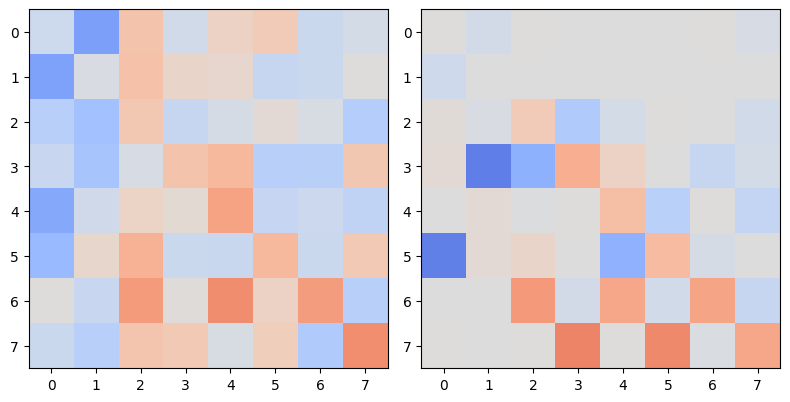

cosine_similarity measure: 0.635
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5984  1.5938
      2        0.5373  1.6185
      3        0.4816  1.6252
      4        0.4329  1.5103
      5        0.3913  1.6601
      6        0.3570  1.5674
      7        0.3304  1.5725
      8        0.3117  1.5262
      9        0.3012  1.6976
     10        0.2957  1.6039
     11        0.2891  1.6186
     12        0.2803  1.7072
     13        0.2717  1.7218
     14        0.2647  1.5496
     15        0.2597  1.6253
     16        0.2556  1.6057
     17        0.2515  1.6485
     18        0.2470  1.5598
     19        0.2422  1.6814
     20        0.2369  1.6172
     21        0.2312  1.6211
     22        0.2264  1.7112
     23        0.2225  1.6134
     24        0.2196  1.5872
     25        0.2168  1.6510
     26        0.2132  1.6136
     27        0.2098  1.6358
     28        0.2069  1.6158
     29        0.2047  1.6194
     30        0.2

    235        0.0736  1.6941
    236        0.0730  1.6003
    237        0.0735  1.6254
    238        0.0722  1.5591
    239        0.0750  1.5826
    240        0.0719  1.5792
    241        0.0744  1.7052
    242        0.0718  1.5550
    243        0.0732  1.5820
    244        0.0730  1.6289
    245        0.0733  1.5971
    246        0.0722  1.6802
    247        0.0720  1.6082
    248        0.0723  1.7192
    249        0.0716  1.5990
    250        0.0739  1.6225
    251        0.0729  1.6325
    252        0.0720  1.6480
    253        0.0729  1.5541
    254        0.0719  1.5588
    255        0.0732  1.5827
    256        0.0714  1.6482
    257        0.0745  1.5654
    258        0.0710  1.6976
    259        0.0737  1.6004
    260        0.0749  1.5267
    261        0.0716  1.5987
    262        0.0736  1.5791
    263        0.0716  1.5816
    264        0.0738  1.7161
    265        0.0716  1.5384
    266        0.0727  1.6253
    267        0.0726  1.5728
    268   

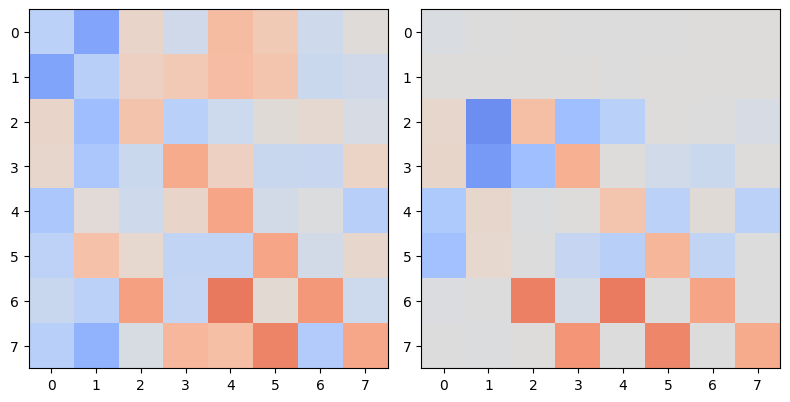

cosine_similarity measure: 0.743
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5547  1.5768
      2        0.4987  1.5877
      3        0.4492  1.6170
      4        0.4061  1.5689
      5        0.3691  1.6846
      6        0.3387  1.5735
      7        0.3170  1.5666
      8        0.3055  1.7126
      9        0.2989  1.5466
     10        0.2899  1.6395
     11        0.2787  1.6545
     12        0.2697  1.6180
     13        0.2637  1.5787
     14        0.2594  1.6073
     15        0.2554  1.5603
     16        0.2511  1.6497
     17        0.2466  1.6377
     18        0.2421  1.7062
     19        0.2377  1.5854
     20        0.2342  1.5894
     21        0.2312  1.6067
     22        0.2289  1.6178
     23        0.2259  1.5846
     24        0.2228  1.5925
     25        0.2198  1.5964
     26        0.2178  1.5745
     27        0.2160  1.6286
     28        0.2139  1.5582
     29        0.2115  1.6184
     30        0.2

    237        0.0727  1.6098
    238        0.0719  1.5658
    239        0.0751  1.6088
    240        0.0718  1.5808
    241        0.0734  1.5827
    242        0.0744  1.6331
    243        0.0727  1.5962
    244        0.0760  1.6642
    245        0.0749  1.5402
    246        0.0747  1.6306
    247        0.0744  1.6553
    248        0.0714  1.6762
    249        0.0756  1.6429
    250        0.0722  1.6008
    251        0.0743  1.6772
    252        0.0746  1.6114
    253        0.0724  1.6025
    254        0.0753  1.5846
    255        0.0736  1.7474
    256        0.0737  1.7078
    257        0.0739  1.5960
    258        0.0710  1.6473
    259        0.0755  1.6495
    260        0.0708  1.5767
    261        0.0752  1.5626
    262        0.0735  1.5852
    263        0.0711  1.5618
    264        0.0724  1.6244
    265        0.0708  1.6706
    266        0.0710  1.6048
    267        0.0715  1.5671
    268        0.0711  1.6769
    269        0.0701  1.5351
    270   

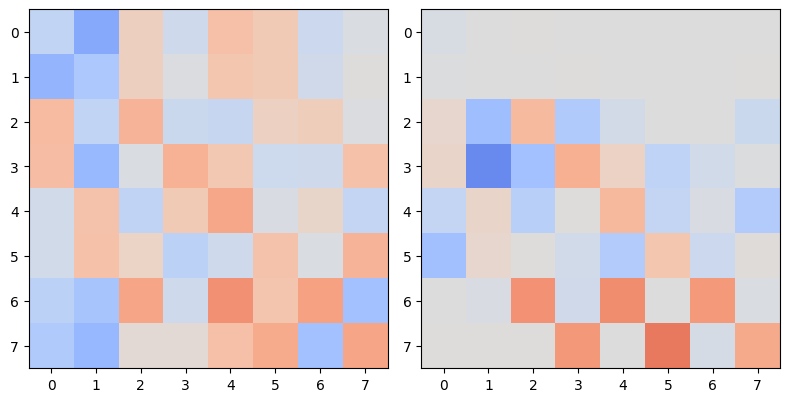

cosine_similarity measure: 0.64
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5400  1.6192
      2        0.4850  1.6391
      3        0.4360  1.5704
      4        0.3931  1.6085
      5        0.3569  1.6038
      6        0.3285  1.6565
      7        0.3124  1.6250
      8        0.3066  1.6699
      9        0.2977  1.6030
     10        0.2839  1.6682
     11        0.2710  1.6097
     12        0.2623  1.6017
     13        0.2561  1.5734
     14        0.2513  1.6041
     15        0.2470  1.5988
     16        0.2419  1.6137
     17        0.2369  1.6256
     18        0.2313  1.6134
     19        0.2269  1.5825
     20        0.2237  1.6654
     21        0.2218  1.6066
     22        0.2193  1.5895
     23        0.2159  1.6112
     24        0.2119  1.5964
     25        0.2089  1.5695
     26        0.2066  1.6093
     27        0.2048  1.6111
     28        0.2024  1.5984
     29        0.1994  1.5409
     30        0.19

    234        0.0745  1.6457
    235        0.0713  1.5554
    236        0.0727  1.6125
    237        0.0761  1.5856
    238        0.0706  1.6391
    239        0.0722  1.5137
    240        0.0729  1.6218
    241        0.0709  1.5902
    242        0.0714  1.6622
    243        0.0725  1.5941
    244        0.0711  1.5937
    245        0.0718  1.6130
    246        0.0721  1.5765
    247        0.0734  1.6329
    248        0.0712  1.6552
    249        0.0721  1.6150
    250        0.0719  1.6292
    251        0.0719  1.5468
    252        0.0756  1.5424
    253        0.0715  1.5427
    254        0.0720  1.5170
    255        0.0720  1.5800
    256        0.0734  1.6068
    257        0.0711  1.5515
    258        0.0712  1.6609
    259        0.0728  1.5706
    260        0.0703  1.6052
    261        0.0718  1.5942
    262        0.0695  1.6190
    263        0.0709  1.6161
    264        0.0699  1.5716
    265        0.0704  1.6065
    266        0.0697  1.5561
    267   

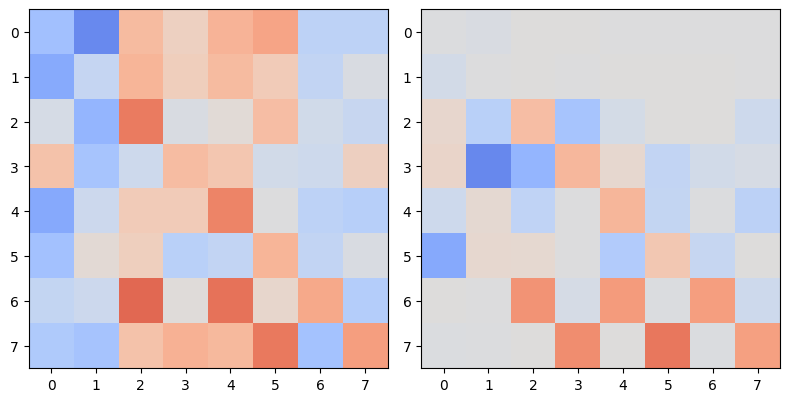

cosine_similarity measure: 0.669
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5806  1.5947
      2        0.5168  1.6052
      3        0.4609  1.6719
      4        0.4139  1.6622
      5        0.3738  1.5973
      6        0.3405  1.5926
      7        0.3147  1.6726
      8        0.2975  1.6163
      9        0.2899  1.5758
     10        0.2861  1.5912
     11        0.2779  1.5709
     12        0.2672  1.6474
     13        0.2581  1.6186
     14        0.2522  1.5959
     15        0.2488  1.6467
     16        0.2464  1.6273
     17        0.2440  1.6324
     18        0.2416  1.6576
     19        0.2384  1.5779
     20        0.2349  1.6121
     21        0.2311  1.5831
     22        0.2277  1.5435
     23        0.2247  1.5926
     24        0.2226  1.5706
     25        0.2202  1.6175
     26        0.2173  1.6096
     27        0.2138  1.6530
     28        0.2109  1.6134
     29        0.2081  1.5684
     30        0.2

    235        0.0732  1.6075
    236        0.0756  1.6566
    237        0.0712  1.6648
    238        0.0745  1.5246
    239        0.0746  1.6058
    240        0.0758  1.6401
    241        0.0724  1.5917
    242        0.0725  1.5802
    243        0.0729  1.5114
    244        0.0725  1.5638
    245        0.0724  1.6807
    246        0.0720  1.5866
    247        0.0728  1.5901
    248        0.0747  1.6223
    249        0.0725  1.5608
    250        0.0735  1.5937
    251        0.0748  1.7048
    252        0.0730  1.7249
    253        0.0742  1.6071
    254        0.0764  1.6521
    255        0.0747  1.6464
    256        0.0739  1.6365
    257        0.0769  1.6892
    258        0.0724  1.7141
    259        0.0747  1.5803
    260        0.0734  1.5043
    261        0.0752  1.5938
    262        0.0741  1.6050
    263        0.0740  1.5725
    264        0.0730  1.5682
    265        0.0738  1.6866
    266        0.0715  1.4937
    267        0.0715  1.5751
    268   

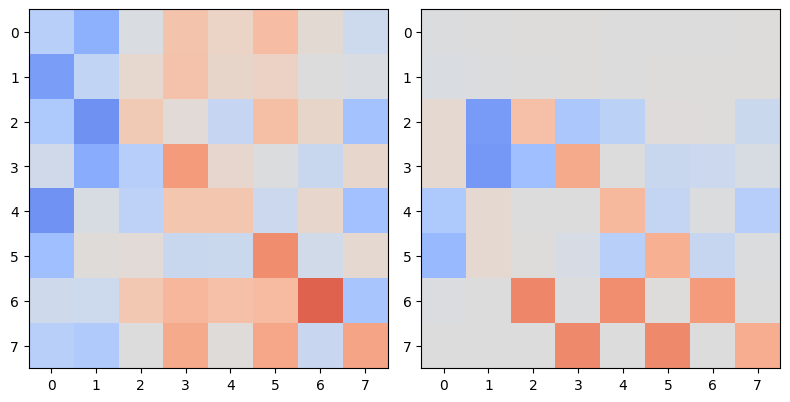

cosine_similarity measure: 0.726
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5751  1.5379
      2        0.5203  1.6303
      3        0.4744  1.7756
      4        0.4350  1.5982
      5        0.4017  1.6185
      6        0.3735  1.6142
      7        0.3526  1.6217
      8        0.3403  1.6217
      9        0.3305  1.6248
     10        0.3171  1.5579
     11        0.3028  1.6288
     12        0.2905  1.6503
     13        0.2813  1.6504
     14        0.2736  1.6306
     15        0.2671  1.5630
     16        0.2600  1.6265
     17        0.2529  1.6702
     18        0.2465  1.6244
     19        0.2413  1.5633
     20        0.2381  1.7217
     21        0.2349  1.5748
     22        0.2315  1.5531
     23        0.2272  1.6586
     24        0.2237  1.5905
     25        0.2207  1.5667
     26        0.2185  1.6691
     27        0.2158  1.5862
     28        0.2128  1.7285
     29        0.2096  1.6689
     30        0.2

    234        0.0751  1.6126
    235        0.0731  1.6092
    236        0.0703  1.5486
    237        0.0728  1.6156
    238        0.0716  1.6274
    239        0.0721  1.5987
    240        0.0766  1.6094
    241        0.0737  1.6092
    242        0.0725  1.6048
    243        0.0756  1.6054
    244        0.0744  1.5923
    245        0.0708  1.7378
    246        0.0752  1.5698
    247        0.0712  1.6050
    248        0.0727  1.6098
    249        0.0725  1.6482
    250        0.0750  1.6827
    251        0.0715  1.5712
    252        0.0724  1.6276
    253        0.0748  1.6613
    254        0.0706  1.5700
    255        0.0770  1.6856
    256        0.0708  1.6433
    257        0.0764  1.6020
    258        0.0706  1.6020
    259        0.0766  1.6001
    260        0.0716  1.6203
    261        0.0738  1.5675
    262        0.0714  1.6904
    263        0.0737  1.6483
    264        0.0707  1.6321
    265        0.0759  1.5830
    266        0.0717  1.5987
    267   

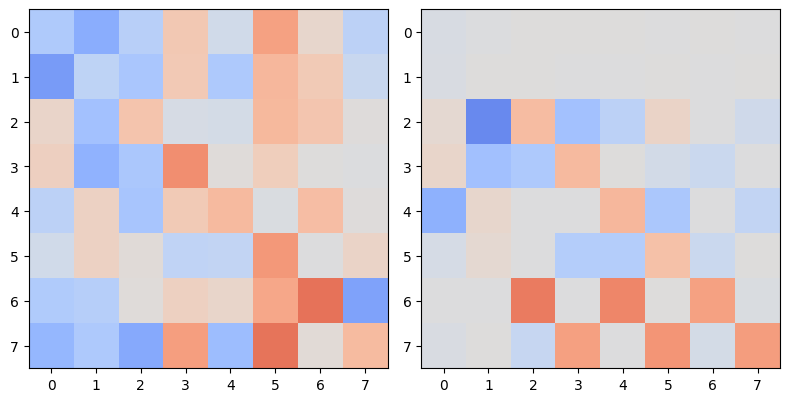

cosine_similarity measure: 0.555
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5326  1.5940
      2        0.4818  1.6129
      3        0.4409  1.6319
      4        0.4066  1.5538
      5        0.3766  1.6080
      6        0.3510  1.5677
      7        0.3298  1.5216
      8        0.3149  1.5119
      9        0.3032  1.5687
     10        0.2918  1.5481
     11        0.2798  1.6944
     12        0.2695  1.6547
     13        0.2615  1.6473
     14        0.2555  1.5967
     15        0.2505  1.6399
     16        0.2455  1.6467
     17        0.2401  1.5923
     18        0.2344  1.5725
     19        0.2292  1.5599
     20        0.2250  1.6456
     21        0.2219  1.6602
     22        0.2188  1.6346
     23        0.2151  1.6192
     24        0.2115  1.6861
     25        0.2085  1.6745
     26        0.2058  1.5751
     27        0.2033  1.6052
     28        0.2006  1.6664
     29        0.1977  1.6090
     30        0.1

    239        0.0732  1.6256
    240        0.0732  1.5976
    241        0.0717  1.5971
    242        0.0748  1.6386
    243        0.0719  1.7592
    244        0.0730  1.5431
    245        0.0723  1.5806
    246        0.0731  1.5996
    247        0.0717  1.7092
    248        0.0715  1.5247
    249        0.0715  1.6070
    250        0.0734  1.6576
    251        0.0708  1.6346
    252        0.0718  1.6737
    253        0.0716  1.6190
    254        0.0737  1.6019
    255        0.0714  1.6029
    256        0.0716  1.6087
    257        0.0741  1.5938
    258        0.0702  1.5746
    259        0.0734  1.5857
    260        0.0723  1.6767
    261        0.0732  1.5615
    262        0.0703  1.5908
    263        0.0726  1.7118
    264        0.0722  1.6335
    265        0.0748  1.6329
    266        0.0735  1.6587
    267        0.0746  1.6547
    268        0.0721  1.6754
    269        0.0776  1.5135
    270        0.0764  1.6006
    271        0.0725  1.7311
    272   

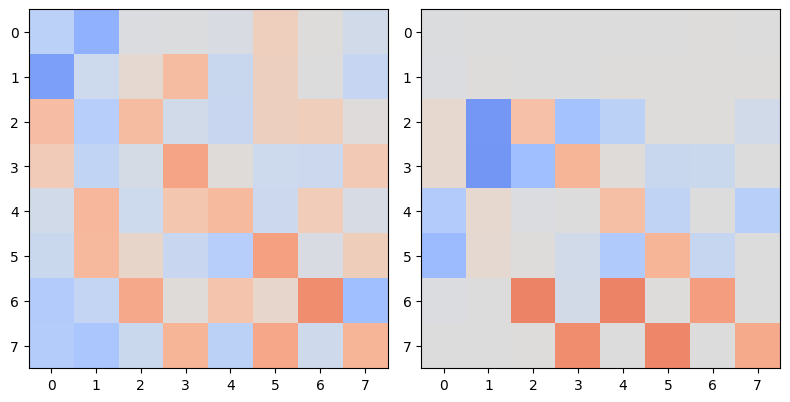

cosine_similarity measure: 0.639
[1.  0.  0.1 0.9 0.1 0.9]
[1.  0.  0.1 0.9 0.3 0.7]
[1.  0.  0.1 0.9 0.4 0.6]
[1.   0.   0.1  0.9  0.45 0.55]
[1.    0.    0.1   0.9   0.475 0.525]
[1.     0.     0.1    0.9    0.4875 0.5125]
[1.      0.      0.1     0.9     0.49375 0.50625]
[1.  0.  0.1 0.9 0.5 0.5]
[1.      0.      0.1     0.9     0.50625 0.49375]
[1.     0.     0.1    0.9    0.5125 0.4875]
[1.    0.    0.1   0.9   0.525 0.475]
[1.   0.   0.1  0.9  0.55 0.45]
[1.  0.  0.1 0.9 0.6 0.4]
[1.  0.  0.1 0.9 0.7 0.3]
[1.  0.  0.1 0.9 0.9 0.1]
[1.  0.  0.3 0.7 0.1 0.9]
[1.  0.  0.3 0.7 0.3 0.7]
[1.  0.  0.3 0.7 0.4 0.6]
[1.   0.   0.3  0.7  0.45 0.55]
[1.    0.    0.3   0.7   0.475 0.525]
[1.     0.     0.3    0.7    0.4875 0.5125]
[1.      0.      0.3     0.7     0.49375 0.50625]
[1.  0.  0.3 0.7 0.5 0.5]
[1.      0.      0.3     0.7     0.50625 0.49375]
[1.     0.     0.3    0.7    0.5125 0.4875]
[1.    0.    0.3   0.7   0.525 0.475]
[1.   0.   0.3  0.7  0.55 0.45]
[1.  0.  0.3 0.7 0.6 0.4]

[1.  0.  0.7 0.3 0.7 0.3]
[1.  0.  0.7 0.3 0.9 0.1]
[1.  0.  0.9 0.1 0.1 0.9]
[1.  0.  0.9 0.1 0.3 0.7]
[1.  0.  0.9 0.1 0.4 0.6]
[1.   0.   0.9  0.1  0.45 0.55]
[1.    0.    0.9   0.1   0.475 0.525]
[1.     0.     0.9    0.1    0.4875 0.5125]
[1.      0.      0.9     0.1     0.49375 0.50625]
[1.  0.  0.9 0.1 0.5 0.5]
[1.      0.      0.9     0.1     0.50625 0.49375]
[1.     0.     0.9    0.1    0.5125 0.4875]
[1.    0.    0.9   0.1   0.525 0.475]
[1.   0.   0.9  0.1  0.55 0.45]
[1.  0.  0.9 0.1 0.6 0.4]
[1.  0.  0.9 0.1 0.7 0.3]
[1.  0.  0.9 0.1 0.9 0.1]
[0.  1.  0.1 0.9 0.1 0.9]
[0.  1.  0.3 0.7 0.1 0.9]
[0.  1.  0.4 0.6 0.1 0.9]
[0.   1.   0.45 0.55 0.1  0.9 ]
[0.    1.    0.475 0.525 0.1   0.9  ]
[0.     1.     0.4875 0.5125 0.1    0.9   ]
[0.      1.      0.49375 0.50625 0.1     0.9    ]
[0.  1.  0.5 0.5 0.1 0.9]
[0.      1.      0.50625 0.49375 0.1     0.9    ]
[0.     1.     0.5125 0.4875 0.1    0.9   ]
[0.    1.    0.525 0.475 0.1   0.9  ]
[0.   1.   0.55 0.45 0.1  0.9 ]
[0.  1

[0.  1.  0.7 0.3 0.6 0.4]
[0.  1.  0.9 0.1 0.6 0.4]
[0.  1.  0.1 0.9 0.7 0.3]
[0.  1.  0.3 0.7 0.7 0.3]
[0.  1.  0.4 0.6 0.7 0.3]
[0.   1.   0.45 0.55 0.7  0.3 ]
[0.    1.    0.475 0.525 0.7   0.3  ]
[0.     1.     0.4875 0.5125 0.7    0.3   ]
[0.      1.      0.49375 0.50625 0.7     0.3    ]
[0.  1.  0.5 0.5 0.7 0.3]
[0.      1.      0.50625 0.49375 0.7     0.3    ]
[0.     1.     0.5125 0.4875 0.7    0.3   ]
[0.    1.    0.525 0.475 0.7   0.3  ]
[0.   1.   0.55 0.45 0.7  0.3 ]
[0.  1.  0.6 0.4 0.7 0.3]
[0.  1.  0.7 0.3 0.7 0.3]
[0.  1.  0.9 0.1 0.7 0.3]
[0.  1.  0.1 0.9 0.9 0.1]
[0.  1.  0.3 0.7 0.9 0.1]
[0.  1.  0.4 0.6 0.9 0.1]
[0.   1.   0.45 0.55 0.9  0.1 ]
[0.    1.    0.475 0.525 0.9   0.1  ]
[0.     1.     0.4875 0.5125 0.9    0.1   ]
[0.      1.      0.49375 0.50625 0.9     0.1    ]
[0.  1.  0.5 0.5 0.9 0.1]
[0.      1.      0.50625 0.49375 0.9     0.1    ]
[0.     1.     0.5125 0.4875 0.9    0.1   ]
[0.    1.    0.525 0.475 0.9   0.1  ]
[0.   1.   0.55 0.45 0.9  0.1 ]
[0.  1

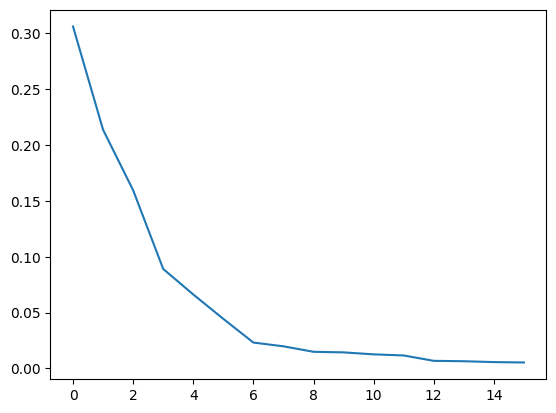

Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5548  1.7163
      2        0.5004  1.6168
      3        0.4550  1.6543
      4        0.4166  1.6647
      5        0.3827  1.5664
      6        0.3539  1.6070
      7        0.3332  1.5826
      8        0.3227  1.6395
      9        0.3110  1.5902
     10        0.2947  1.6403
     11        0.2810  1.6979
     12        0.2725  1.5876
     13        0.2674  1.5903
     14        0.2630  1.5839
     15        0.2583  1.5858
     16        0.2533  1.5628
     17        0.2480  1.6385
     18        0.2436  1.6416
     19        0.2397  1.6268
     20        0.2353  1.7013
     21        0.2301  1.5813
     22        0.2250  1.6129
     23        0.2206  1.6126
     24        0.2169  1.6205
     25        0.2131  1.5743
     26        0.2085  1.6643
     27        0.2042  1.6647
     28        0.2001  1.5676
     29        0.1962  1.5854
     30        0.1927  1.6533
     31        0.1891

    239        0.0627  1.6475
    240        0.0620  1.5948
    241        0.0646  1.5647
    242        0.0624  1.5467
    243        0.0654  1.5966
    244        0.0638  1.6192
    245        0.0637  1.6406
    246        0.0634  1.5455
    247        0.0626  1.5759
    248        0.0620  1.5787
    249        0.0627  1.7201
    250        0.0644  1.6078
    251        0.0625  1.6164
    252        0.0648  1.5802
    253        0.0625  1.5998
    254        0.0640  1.6131
    255        0.0654  1.6500
    256        0.0616  1.5847
    257        0.0633  1.5796
    258        0.0615  1.6542
    259        0.0619  1.5695
    260        0.0630  1.6230
    261        0.0622  1.6488
    262        0.0633  1.5573
    263        0.0636  1.6433
    264        0.0617  1.5435
    265        0.0621  1.6501
    266        0.0636  1.5891
    267        0.0626  1.6378
    268        0.0623  1.5851
    269        0.0621  1.6482
    270        0.0624  1.6131
    271        0.0616  1.5888
    272   

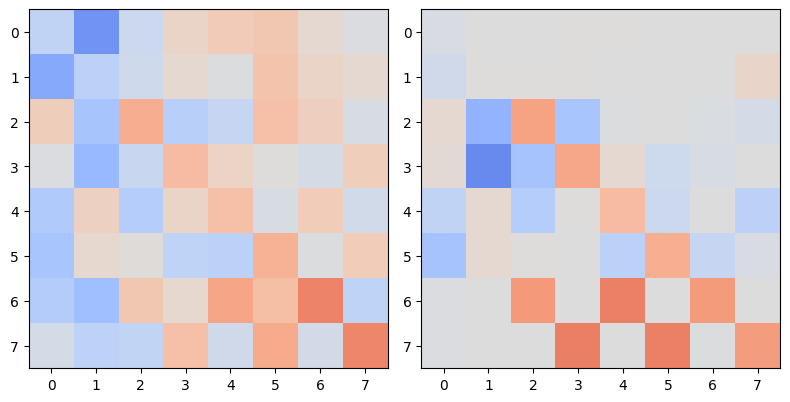

cosine_similarity measure: 0.729
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5595  1.4903
      2        0.4999  1.6305
      3        0.4475  1.6002
      4        0.4021  1.5642
      5        0.3636  1.5494
      6        0.3335  1.5266
      7        0.3130  1.6846
      8        0.3038  1.6320
      9        0.2975  1.6121
     10        0.2870  1.6335
     11        0.2757  1.6011
     12        0.2671  1.6423
     13        0.2619  1.5667
     14        0.2582  1.6018
     15        0.2548  1.5963
     16        0.2507  1.5476
     17        0.2455  1.5146
     18        0.2404  1.6588
     19        0.2360  1.5915
     20        0.2339  1.5950
     21        0.2326  1.6694
     22        0.2302  1.6364
     23        0.2262  1.5944
     24        0.2227  1.6522
     25        0.2203  1.5404
     26        0.2186  1.6542
     27        0.2164  1.6795
     28        0.2135  1.6319
     29        0.2106  1.6167
     30        0.2

    236        0.0707  1.6300
    237        0.0673  1.6155
    238        0.0689  1.5824
    239        0.0664  1.5966
    240        0.0709  1.6181
    241        0.0655  1.7095
    242        0.0703  1.6611
    243        0.0676  1.6434
    244        0.0665  1.6484
    245        0.0684  1.6691
    246        0.0670  1.6050
    247        0.0669  1.5933
    248        0.0674  1.6085
    249        0.0673  1.6411
    250        0.0670  1.5730
    251        0.0710  1.5573
    252        0.0659  1.6047
    253        0.0681  1.5452
    254        0.0650  1.5947
    255        0.0678  1.6401
    256        0.0674  1.6194
    257        0.0672  1.7191
    258        0.0666  1.5924
    259        0.0664  1.6271
    260        0.0663  1.6156
    261        0.0673  1.5768
    262        0.0647  1.5690
    263        0.0684  1.6391
    264        0.0655  1.6393
    265        0.0650  1.6085
    266        0.0650  1.6761
    267        0.0648  1.6079
    268        0.0651  1.6277
    269   

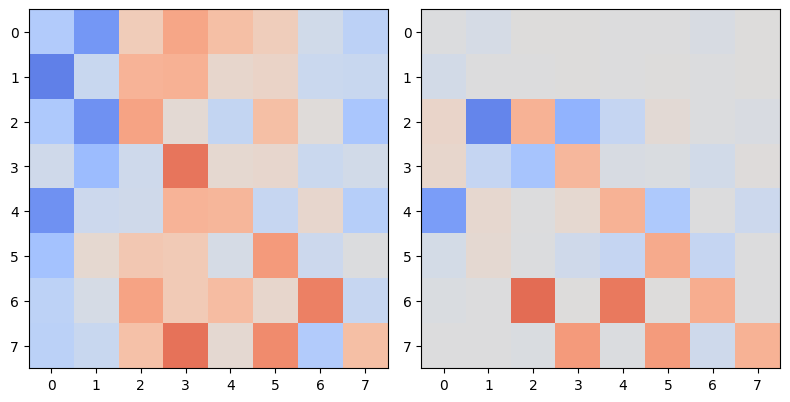

cosine_similarity measure: 0.687
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5348  1.6690
      2        0.4782  1.6573
      3        0.4263  1.5273
      4        0.3787  1.6185
      5        0.3362  1.6101
      6        0.3026  1.5933
      7        0.2852  1.6345
      8        0.2850  1.6717
      9        0.2771  1.5985
     10        0.2639  1.6076
     11        0.2544  1.5829
     12        0.2503  1.5830
     13        0.2485  1.6203
     14        0.2468  1.6049
     15        0.2444  1.6166
     16        0.2403  1.6264
     17        0.2351  1.6079
     18        0.2299  1.6130
     19        0.2251  1.6299
     20        0.2218  1.5921
     21        0.2196  1.6738
     22        0.2174  1.6349
     23        0.2132  1.6247
     24        0.2084  1.5929
     25        0.2046  1.6086
     26        0.2024  1.5978
     27        0.2009  1.6007
     28        0.1991  1.6676
     29        0.1965  1.5918
     30        0.1

    241        0.0650  1.6092
    242        0.0642  1.5592
    243        0.0649  1.5647
    244        0.0641  1.6692
    245        0.0624  1.5670
    246        0.0658  1.6218
    247        0.0631  1.6660
    248        0.0637  1.6197
    249        0.0636  1.5782
    250        0.0642  1.5739
    251        0.0645  1.5309
    252        0.0620  1.5526
    253        0.0635  1.6180
    254        0.0626  1.5130
    255        0.0644  1.5552
    256        0.0620  1.5401
    257        0.0656  1.6208
    258        0.0629  1.5719
    259        0.0632  1.5957
    260        0.0646  1.6865
    261        0.0641  1.5804
    262        0.0636  1.5923
    263        0.0629  1.6416
    264        0.0632  1.6063
    265        0.0658  1.6590
    266        0.0626  1.6089
    267        0.0628  1.6219
    268        0.0639  1.5495
    269        0.0618  1.5770
    270        0.0642  1.6612
    271        0.0649  1.6220
    272        0.0645  1.7367
    273        0.0625  1.5916
    274   

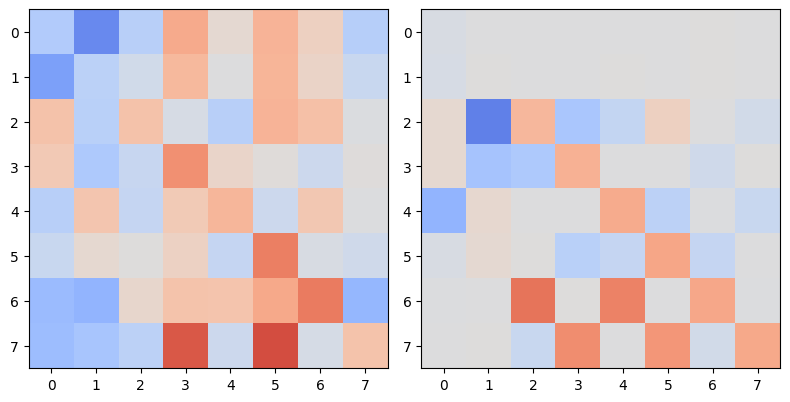

cosine_similarity measure: 0.587
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.4756  1.5007
      2        0.4229  1.5999
      3        0.3765  1.5764
      4        0.3382  1.5342
      5        0.3073  1.5716
      6        0.2878  1.5584
      7        0.2834  1.6095
      8        0.2754  1.6034
      9        0.2601  1.6357
     10        0.2474  1.6602
     11        0.2404  1.6260
     12        0.2369  1.5207
     13        0.2343  1.6354
     14        0.2313  1.6134
     15        0.2270  1.5899
     16        0.2229  1.6442
     17        0.2194  1.5720
     18        0.2181  1.5847
     19        0.2177  1.5393
     20        0.2157  1.6361
     21        0.2124  1.6081
     22        0.2097  1.5352
     23        0.2079  1.5915
     24        0.2067  1.5530
     25        0.2049  1.5456
     26        0.2023  1.5443
     27        0.1992  1.5456
     28        0.1964  1.6227
     29        0.1944  1.5844
     30        0.1

    239        0.0655  1.5828
    240        0.0636  1.5721
    241        0.0635  1.6035
    242        0.0648  1.5845
    243        0.0650  1.6572
    244        0.0643  1.5564
    245        0.0647  1.8908
    246        0.0634  1.5611
    247        0.0643  1.6111
    248        0.0639  1.5945
    249        0.0648  1.5414
    250        0.0657  1.6443
    251        0.0655  1.6071
    252        0.0634  1.6434
    253        0.0634  1.5875
    254        0.0641  1.6561
    255        0.0636  1.6393
    256        0.0629  1.5075
    257        0.0643  1.6229
    258        0.0654  1.6536
    259        0.0638  1.6253
    260        0.0635  1.6358
    261        0.0636  1.6207
    262        0.0651  1.5684
    263        0.0646  1.5307
    264        0.0630  1.5696
    265        0.0648  1.5865
    266        0.0654  1.6799
    267        0.0636  1.5995
    268        0.0631  1.6483
    269        0.0639  1.6413
    270        0.0632  1.6349
    271        0.0638  1.5998
    272   

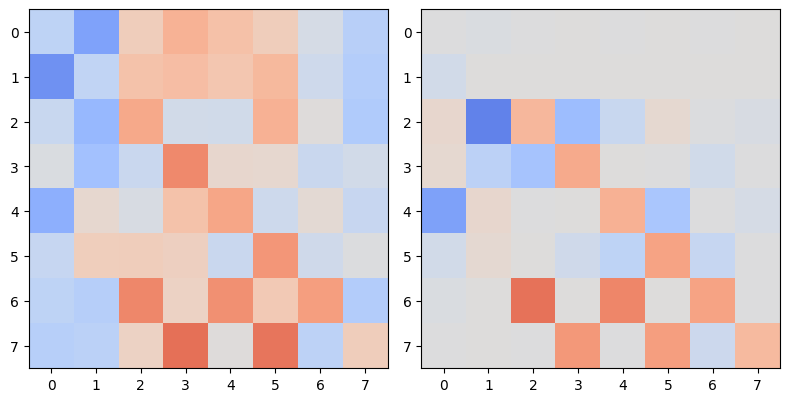

cosine_similarity measure: 0.736
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.4960  1.5530
      2        0.4408  1.6987
      3        0.3933  1.5998
      4        0.3519  1.6687
      5        0.3174  1.6365
      6        0.2929  1.5499
      7        0.2888  1.5540
      8        0.2893  1.6649
      9        0.2759  1.5923
     10        0.2613  1.6193
     11        0.2528  1.5397
     12        0.2487  1.5156
     13        0.2460  1.7190
     14        0.2434  1.5235
     15        0.2394  1.5506
     16        0.2343  1.6154
     17        0.2290  1.5711
     18        0.2243  1.6086
     19        0.2208  1.5956
     20        0.2189  1.5981
     21        0.2174  1.5801
     22        0.2144  1.5508
     23        0.2107  1.6437
     24        0.2080  1.6083
     25        0.2065  1.5530
     26        0.2054  1.6099
     27        0.2039  1.6230
     28        0.2018  1.5914
     29        0.1994  1.6446
     30        0.1

    237        0.0678  1.6121
    238        0.0654  1.6521
    239        0.0688  1.5885
    240        0.0653  1.6129
    241        0.0702  1.6024
    242        0.0668  1.6463
    243        0.0678  1.6154
    244        0.0681  1.4798
    245        0.0667  1.6410
    246        0.0692  1.6027
    247        0.0664  1.6326
    248        0.0693  1.6144
    249        0.0689  1.5345
    250        0.0663  1.6886
    251        0.0686  1.6289
    252        0.0692  1.5444
    253        0.0682  1.6351
    254        0.0671  1.5705
    255        0.0698  1.6246
    256        0.0656  1.6287
    257        0.0670  1.7034
    258        0.0657  1.5263
    259        0.0671  1.6449
    260        0.0654  1.6144
    261        0.0673  1.6778
    262        0.0666  1.6154
    263        0.0653  1.6033
    264        0.0679  1.6828
    265        0.0672  1.6255
    266        0.0674  1.6157
    267        0.0650  1.6597
    268        0.0704  1.5831
    269        0.0659  1.5860
    270   

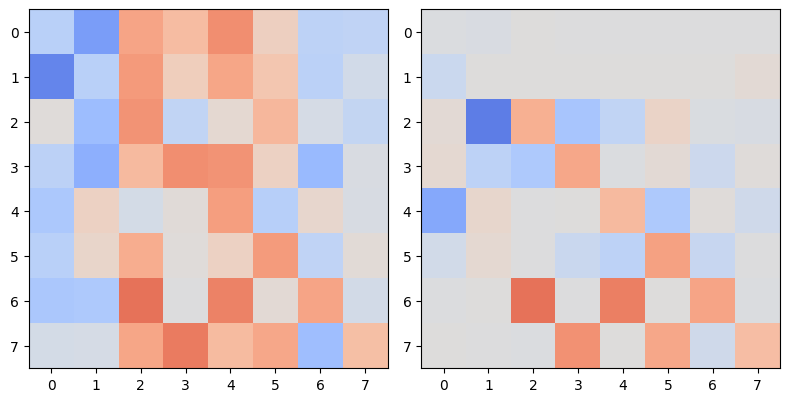

cosine_similarity measure: 0.64
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.4816  1.6136
      2        0.4262  1.5845
      3        0.3756  1.6361
      4        0.3317  1.5361
      5        0.2962  1.6534
      6        0.2757  1.6080
      7        0.2774  1.5271
      8        0.2731  1.5651
      9        0.2598  1.5816
     10        0.2499  1.6173
     11        0.2455  1.6153
     12        0.2447  1.7231
     13        0.2442  1.6163
     14        0.2423  1.5609
     15        0.2388  1.6002
     16        0.2342  1.5616
     17        0.2294  1.6653
     18        0.2248  1.5968
     19        0.2219  1.5661
     20        0.2208  1.5454
     21        0.2194  1.6500
     22        0.2161  1.6715
     23        0.2124  1.6145
     24        0.2094  1.6736
     25        0.2075  1.6305
     26        0.2065  1.5445
     27        0.2053  1.5528
     28        0.2033  1.6819
     29        0.2011  1.5795
     30        0.19

    238        0.0666  1.5746
    239        0.0649  1.5863
    240        0.0656  1.5767
    241        0.0649  1.5940
    242        0.0644  1.7303
    243        0.0664  1.6513
    244        0.0636  1.6052
    245        0.0644  1.5502
    246        0.0637  1.6214
    247        0.0664  1.6039
    248        0.0650  1.6285
    249        0.0653  1.6346
    250        0.0650  1.5664
    251        0.0628  1.6785
    252        0.0636  1.6573
    253        0.0649  1.6017
    254        0.0629  1.6507
    255        0.0652  1.6175
    256        0.0677  1.6011
    257        0.0619  1.6885
    258        0.0694  1.6278
    259        0.0704  1.5768
    260        0.0672  1.6313
    261        0.0660  1.7093
    262        0.0653  1.6081
    263        0.0646  1.6265
    264        0.0657  1.6254
    265        0.0658  1.6021
    266        0.0648  1.5878
    267        0.0687  1.5749
    268        0.0673  1.6798
    269        0.0674  1.5832
    270        0.0654  1.6895
    271   

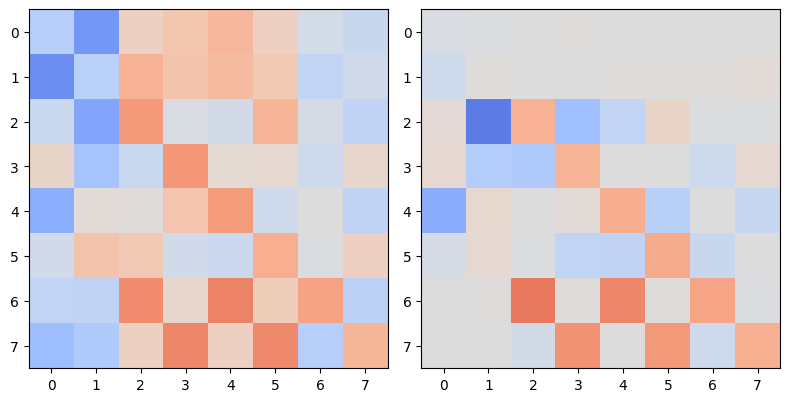

cosine_similarity measure: 0.754
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6374  1.6160
      2        0.5744  1.6227
      3        0.5195  1.5468
      4        0.4733  1.5571
      5        0.4348  1.6196
      6        0.4042  1.5748
      7        0.3804  1.5506
      8        0.3643  1.5752
      9        0.3508  1.6353
     10        0.3350  1.6767
     11        0.3190  1.6071
     12        0.3056  1.6418
     13        0.2957  1.6275
     14        0.2882  1.6674
     15        0.2816  1.6521
     16        0.2753  1.6290
     17        0.2686  1.6412
     18        0.2631  1.5771
     19        0.2591  1.5762
     20        0.2562  1.5852
     21        0.2523  1.6399
     22        0.2476  1.6470
     23        0.2438  1.5192
     24        0.2409  1.5969
     25        0.2382  1.5307
     26        0.2345  1.5672
     27        0.2310  1.6059
     28        0.2275  1.5681
     29        0.2248  1.7500
     30        0.2

    238        0.0669  1.6097
    239        0.0771  1.5649
    240        0.0690  1.6130
    241        0.0719  1.7124
    242        0.0692  1.6336
    243        0.0720  1.5325
    244        0.0695  1.5776
    245        0.0698  1.5641
    246        0.0693  1.5982
    247        0.0704  1.5957
    248        0.0672  1.6255
    249        0.0698  1.5607
    250        0.0664  1.6471
    251        0.0695  1.5458
    252        0.0657  1.6011
    253        0.0704  1.5692
    254        0.0645  1.6232
    255        0.0685  1.6118
    256        0.0648  1.5838
    257        0.0679  1.6371
    258        0.0684  1.6128
    259        0.0651  1.5251
    260        0.0678  1.6667
    261        0.0652  1.5553
    262        0.0669  1.6364
    263        0.0651  1.6671
    264        0.0674  1.5152
    265        0.0650  1.5890
    266        0.0651  1.5405
    267        0.0687  1.6040
    268        0.0659  1.5526
    269        0.0650  1.5159
    270        0.0671  1.5274
    271   

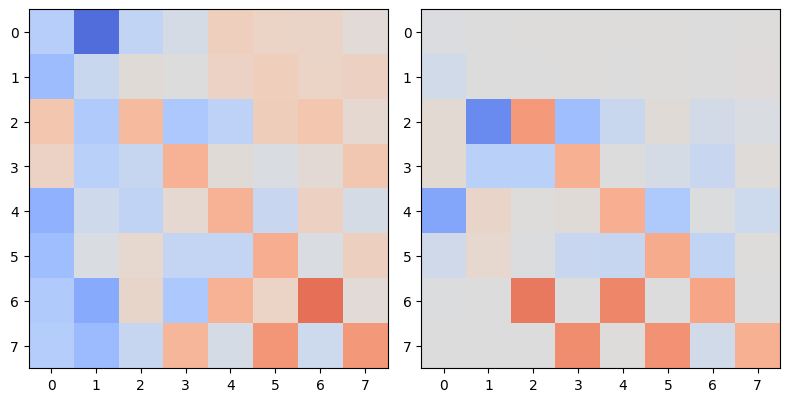

cosine_similarity measure: 0.649
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.4597  1.5250
      2        0.4142  1.5934
      3        0.3697  1.5298
      4        0.3264  1.5707
      5        0.2897  1.5887
      6        0.2704  1.5699
      7        0.2793  1.5904
      8        0.2727  1.5508
      9        0.2556  1.5810
     10        0.2446  1.6312
     11        0.2407  1.6572
     12        0.2400  1.6220
     13        0.2392  1.5641
     14        0.2369  1.6144
     15        0.2333  1.5282
     16        0.2283  1.6385
     17        0.2230  1.6561
     18        0.2182  1.6041
     19        0.2152  1.5420
     20        0.2144  1.6085
     21        0.2139  1.5931
     22        0.2118  1.6011
     23        0.2077  1.6173
     24        0.2041  1.5492
     25        0.2020  1.5680
     26        0.2010  1.6039
     27        0.2001  1.5820
     28        0.1991  1.6461
     29        0.1969  1.6009
     30        0.1

    237        0.0674  1.6080
    238        0.0638  1.6957
    239        0.0670  1.5927
    240        0.0645  1.5365
    241        0.0663  1.5852
    242        0.0691  1.5334
    243        0.0649  1.5342
    244        0.0681  1.5475
    245        0.0634  1.6139
    246        0.0667  1.6611
    247        0.0641  1.6644
    248        0.0658  1.6489
    249        0.0639  1.6159
    250        0.0656  1.6088
    251        0.0630  1.6007
    252        0.0638  1.5520
    253        0.0635  1.6510
    254        0.0643  1.5634
    255        0.0646  1.6203
    256        0.0633  1.6214
    257        0.0638  1.5499
    258        0.0652  1.5991
    259        0.0649  1.6494
    260        0.0623  1.6221
    261        0.0638  1.6284
    262        0.0632  1.6110
    263        0.0640  1.6705
    264        0.0644  1.5470
    265        0.0631  1.6560
    266        0.0623  1.5868
    267        0.0651  1.6022
    268        0.0641  1.6028
    269        0.0629  1.5596
    270   

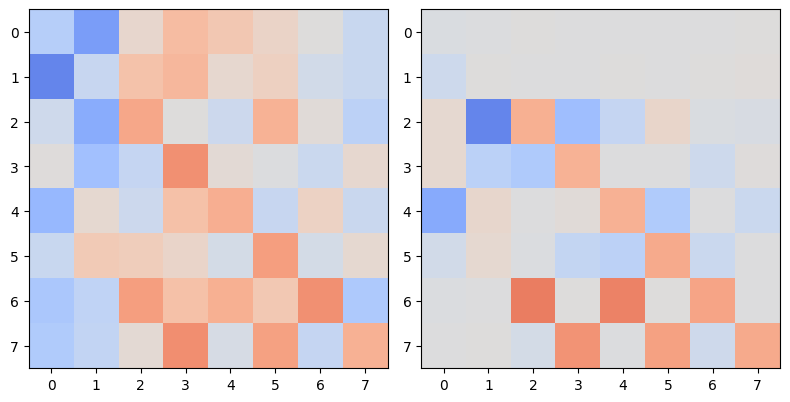

cosine_similarity measure: 0.726
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5706  1.5995
      2        0.5106  1.6218
      3        0.4557  1.5288
      4        0.4060  1.5661
      5        0.3625  1.6656
      6        0.3276  1.5670
      7        0.3054  1.5352
      8        0.3017  1.5447
      9        0.3047  1.5403
     10        0.2947  1.6836
     11        0.2805  1.5325
     12        0.2713  1.6385
     13        0.2668  1.6253
     14        0.2650  1.6145
     15        0.2635  1.5796
     16        0.2608  1.5139
     17        0.2569  1.6488
     18        0.2519  1.5889
     19        0.2463  1.5605
     20        0.2405  1.6222
     21        0.2357  1.6111
     22        0.2326  1.5743
     23        0.2301  1.6017
     24        0.2274  1.6342
     25        0.2229  1.6410
     26        0.2183  1.5538
     27        0.2151  1.6016
     28        0.2132  1.6321
     29        0.2117  1.5790
     30        0.2

    236        0.0680  1.5740
    237        0.0666  1.7426
    238        0.0709  1.6602
    239        0.0680  1.6152
    240        0.0676  1.6133
    241        0.0703  1.5415
    242        0.0674  1.5947
    243        0.0686  1.6388
    244        0.0690  1.6057
    245        0.0644  1.5533
    246        0.0681  1.5987
    247        0.0646  1.6350
    248        0.0692  1.6228
    249        0.0644  1.5570
    250        0.0670  1.6712
    251        0.0651  1.6558
    252        0.0677  1.5855
    253        0.0650  1.6629
    254        0.0648  1.5848
    255        0.0649  1.5284
    256        0.0672  1.6615
    257        0.0635  1.6170
    258        0.0658  1.5875
    259        0.0659  1.6382
    260        0.0628  1.5959
    261        0.0666  1.5585
    262        0.0634  1.6856
    263        0.0638  1.5614
    264        0.0640  1.6064
    265        0.0639  1.6412
    266        0.0649  1.6301
    267        0.0643  1.6132
    268        0.0626  1.6434
    269   

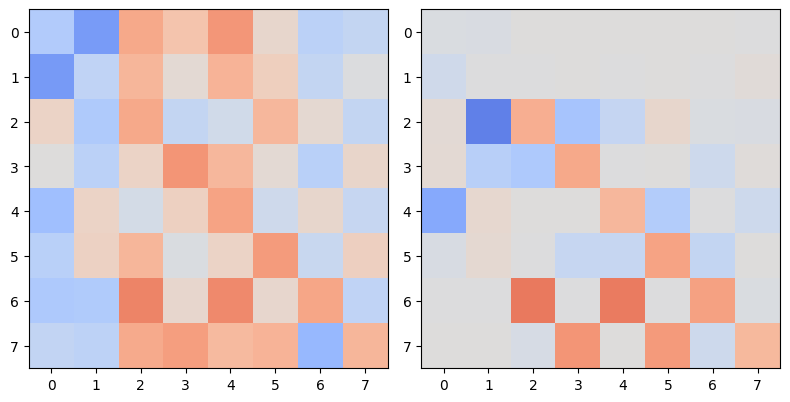

cosine_similarity measure: 0.658
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5300  1.5991
      2        0.4727  1.5414
      3        0.4231  1.6438
      4        0.3790  1.6001
      5        0.3405  1.6026
      6        0.3089  1.6103
      7        0.2899  1.6444
      8        0.2891  1.6198
      9        0.2859  1.6548
     10        0.2726  1.5448
     11        0.2605  1.6200
     12        0.2540  1.6960
     13        0.2517  1.6874
     14        0.2500  1.6693
     15        0.2475  1.5853
     16        0.2435  1.5994
     17        0.2380  1.6295
     18        0.2321  1.5701
     19        0.2261  1.6338
     20        0.2217  1.6538
     21        0.2194  1.6417
     22        0.2173  1.6652
     23        0.2138  1.5799
     24        0.2093  1.6500
     25        0.2055  1.6291
     26        0.2033  1.5739
     27        0.2017  1.6425
     28        0.2000  1.6224
     29        0.1978  1.5842
     30        0.1

    240        0.0648  1.6162
    241        0.0679  1.6690
    242        0.0657  1.6087
    243        0.0668  1.5849
    244        0.0655  1.6149
    245        0.0649  1.6839
    246        0.0643  1.6359
    247        0.0645  1.5708
    248        0.0650  1.6710
    249        0.0648  1.6236
    250        0.0650  1.6960
    251        0.0656  1.6825
    252        0.0645  1.5714
    253        0.0642  1.5870
    254        0.0646  1.5693
    255        0.0646  1.6572
    256        0.0649  1.6128
    257        0.0655  1.6325
    258        0.0646  1.6099
    259        0.0650  1.6727
    260        0.0657  1.6972
    261        0.0640  1.6439
    262        0.0659  1.6305
    263        0.0659  1.6538
    264        0.0637  1.6283
    265        0.0644  1.5651
    266        0.0649  1.6781
    267        0.0648  1.7063
    268        0.0647  1.5940
    269        0.0661  1.6416
    270        0.0652  1.6656
    271        0.0642  1.6227
    272        0.0682  1.6169
    273   

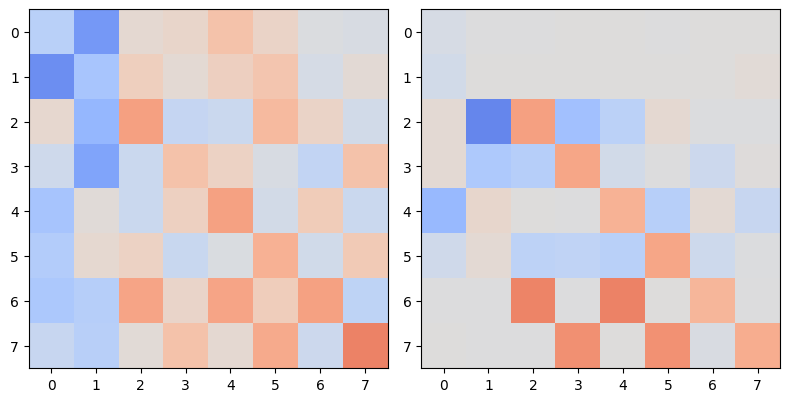

cosine_similarity measure: 0.709
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5876  1.6311
      2        0.5251  1.5971
      3        0.4692  1.5909
      4        0.4199  1.5514
      5        0.3778  1.5975
      6        0.3428  1.5797
      7        0.3164  1.6434
      8        0.3018  1.6003
      9        0.2999  1.6508
     10        0.2966  1.6307
     11        0.2862  1.5902
     12        0.2754  1.6286
     13        0.2689  1.6525
     14        0.2658  1.5710
     15        0.2633  1.6287
     16        0.2607  1.6359
     17        0.2575  1.6345
     18        0.2535  1.6537
     19        0.2490  1.6337
     20        0.2440  1.5397
     21        0.2400  1.6017
     22        0.2374  1.6451
     23        0.2352  1.6137
     24        0.2323  1.5842
     25        0.2286  1.7107
     26        0.2254  1.6601
     27        0.2230  1.6802
     28        0.2208  1.6285
     29        0.2187  1.6460
     30        0.2

    235        0.0651  1.6356
    236        0.0631  1.6269
    237        0.0678  1.5652
    238        0.0672  1.6535
    239        0.0702  1.6184
    240        0.0649  1.6083
    241        0.0652  1.5336
    242        0.0660  1.5846
    243        0.0650  1.6148
    244        0.0682  1.6173
    245        0.0651  1.5498
    246        0.0685  1.5870
    247        0.0648  1.6390
    248        0.0668  1.6331
    249        0.0630  1.6468
    250        0.0660  1.6904
    251        0.0643  1.6218
    252        0.0663  1.6241
    253        0.0630  1.6889
    254        0.0659  1.6115
    255        0.0680  1.5718
    256        0.0623  1.5810
    257        0.0659  1.6062
    258        0.0657  1.6063
    259        0.0638  1.7019
    260        0.0642  1.6133
    261        0.0652  1.5914
    262        0.0633  1.6196
    263        0.0630  1.6578
    264        0.0646  1.6878
    265        0.0629  1.6021
    266        0.0653  1.6150
    267        0.0630  1.6355
    268   

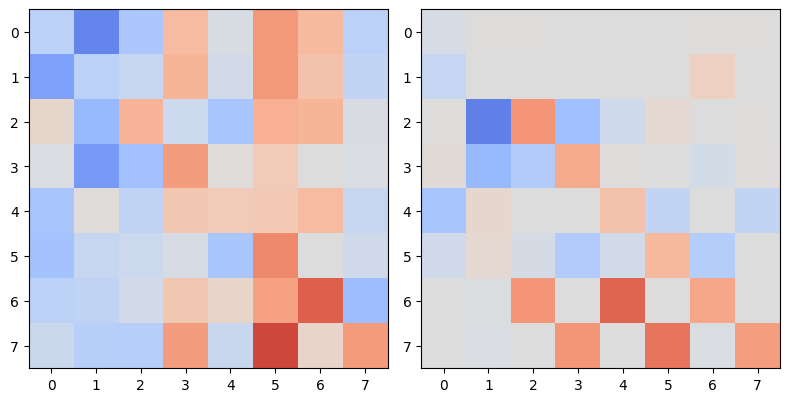

cosine_similarity measure: 0.595
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.4871  1.6078
      2        0.4374  1.5648
      3        0.3943  1.5984
      4        0.3554  1.6346
      5        0.3216  1.6012
      6        0.2978  1.6556
      7        0.2933  1.6190
      8        0.2873  1.5400
      9        0.2707  1.6565
     10        0.2566  1.6222
     11        0.2492  1.5512
     12        0.2455  1.5541
     13        0.2429  1.6380
     14        0.2390  1.5855
     15        0.2341  1.6254
     16        0.2284  1.6159
     17        0.2228  1.6001
     18        0.2188  1.5988
     19        0.2167  1.5721
     20        0.2152  1.6163
     21        0.2125  1.5340
     22        0.2083  1.6409
     23        0.2049  1.7085
     24        0.2026  1.5835
     25        0.2006  1.6169
     26        0.1981  1.5863
     27        0.1957  1.5744
     28        0.1926  1.5526
     29        0.1900  1.6291
     30        0.1

    241        0.0659  1.6092
    242        0.0648  1.6743
    243        0.0644  1.6626
    244        0.0648  1.5689
    245        0.0647  1.6084
    246        0.0673  1.6477
    247        0.0673  1.5673
    248        0.0651  1.5842
    249        0.0702  1.5810
    250        0.0667  1.5763
    251        0.0663  1.6191
    252        0.0668  1.5533
    253        0.0647  1.5859
    254        0.0661  1.6475
    255        0.0640  1.5977
    256        0.0665  1.5677
    257        0.0643  1.5638
    258        0.0652  1.5902
    259        0.0681  1.5410
    260        0.0639  1.5161
    261        0.0647  1.5786
    262        0.0673  1.5989
    263        0.0643  1.6214
    264        0.0662  1.6575
    265        0.0662  1.5650
    266        0.0645  1.6545
    267        0.0670  1.5605
    268        0.0648  1.5832
    269        0.0654  1.6575
    270        0.0637  1.6607
    271        0.0646  1.6116
    272        0.0638  1.6263
    273        0.0673  1.5687
    274   

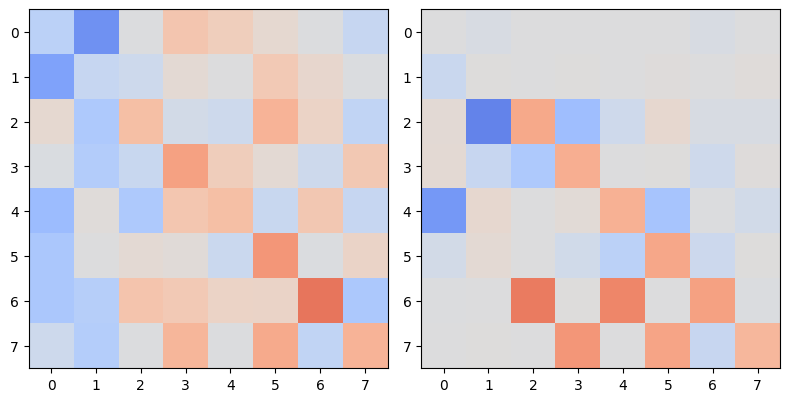

cosine_similarity measure: 0.659
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.4817  1.6616
      2        0.4305  1.6742
      3        0.3859  1.5939
      4        0.3479  1.5610
      5        0.3160  1.5939
      6        0.2948  1.6147
      7        0.2926  1.6045
      8        0.2895  1.6478
      9        0.2752  1.5731
     10        0.2620  1.5658
     11        0.2550  1.5804
     12        0.2509  1.5834
     13        0.2468  1.5396
     14        0.2420  1.5987
     15        0.2363  1.6750
     16        0.2301  1.5998
     17        0.2246  1.6432
     18        0.2211  1.6287
     19        0.2197  1.6077
     20        0.2188  1.5490
     21        0.2158  1.5800
     22        0.2118  1.5162
     23        0.2085  1.5424
     24        0.2063  1.7514
     25        0.2042  1.5731
     26        0.2018  1.6103
     27        0.1988  1.5699
     28        0.1961  1.6015
     29        0.1941  1.6389
     30        0.1

    238        0.0672  1.6115
    239        0.0646  1.6656
    240        0.0666  1.5817
    241        0.0644  1.5730
    242        0.0653  1.6172
    243        0.0660  1.6233
    244        0.0643  1.5414
    245        0.0641  1.6213
    246        0.0642  1.5901
    247        0.0639  1.6022
    248        0.0640  1.6185
    249        0.0673  1.5452
    250        0.0685  1.5503
    251        0.0640  1.5784
    252        0.0669  1.5997
    253        0.0668  1.5607
    254        0.0648  1.6092
    255        0.0692  1.7220
    256        0.0651  1.6311
    257        0.0659  1.6246
    258        0.0687  1.6089
    259        0.0640  1.5686
    260        0.0696  1.6021
    261        0.0661  1.6048
    262        0.0664  1.5771
    263        0.0672  1.5796
    264        0.0648  1.5995
    265        0.0667  1.6211
    266        0.0677  1.5859
    267        0.0647  1.5823
    268        0.0687  1.6105
    269        0.0644  1.6637
    270        0.0665  1.5899
    271   

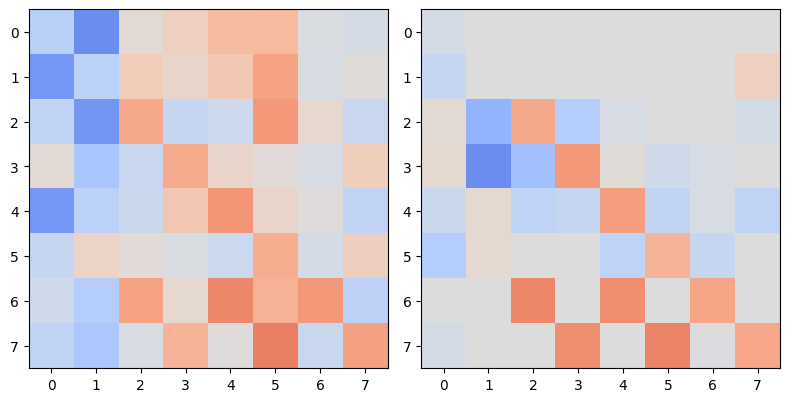

cosine_similarity measure: 0.701
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6028  1.6528
      2        0.5435  1.5757
      3        0.4896  1.5714
      4        0.4421  1.5860
      5        0.4019  1.7669
      6        0.3689  1.8713
      7        0.3440  1.5967
      8        0.3283  1.5669
      9        0.3184  1.6293
     10        0.3068  1.5468
     11        0.2927  1.5153
     12        0.2796  1.5955
     13        0.2696  1.6141
     14        0.2621  1.5564
     15        0.2558  1.6006
     16        0.2499  1.5305
     17        0.2440  1.6442
     18        0.2385  1.5855
     19        0.2348  1.5937
     20        0.2324  1.5601
     21        0.2295  1.5564
     22        0.2255  1.6615
     23        0.2222  1.6554
     24        0.2201  1.6388
     25        0.2177  1.5783
     26        0.2148  1.5222
     27        0.2117  1.6166
     28        0.2095  1.5520
     29        0.2078  1.5807
     30        0.2

    244        0.0643  1.6484
    245        0.0648  1.6484
    246        0.0650  1.5750
    247        0.0670  1.6121
    248        0.0667  1.6242
    249        0.0648  1.5882
    250        0.0690  1.5922
    251        0.0669  1.6143
    252        0.0653  1.5726
    253        0.0687  1.6210
    254        0.0648  1.6261
    255        0.0674  1.5525
    256        0.0655  1.6192
    257        0.0658  1.6613
    258        0.0671  1.5714
    259        0.0640  1.6021
    260        0.0677  1.6114
    261        0.0679  1.6033
    262        0.0641  1.6089
    263        0.0651  1.6504
    264        0.0641  1.6038
    265        0.0645  1.6355
    266        0.0656  1.5948
    267        0.0651  1.7045
    268        0.0641  1.5894
    269        0.0641  1.6310
    270        0.0650  1.5989
    271        0.0643  1.6131
    272        0.0644  1.5788
    273        0.0642  1.6200
    274        0.0653  1.5893
    275        0.0674  1.6362
    276        0.0638  1.6113
    277   

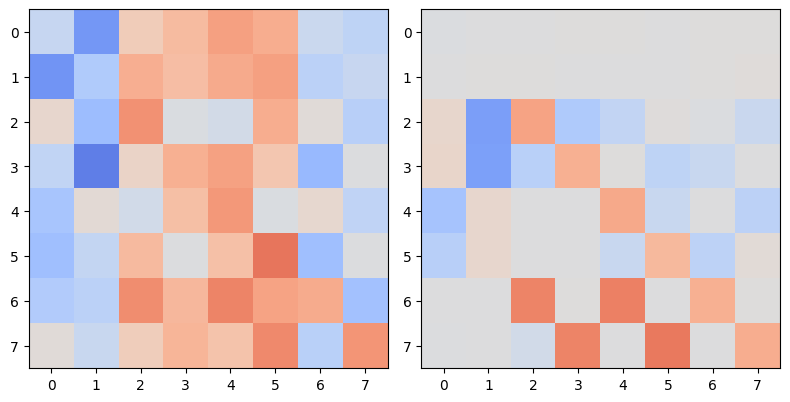

cosine_similarity measure: 0.636
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5198  1.5943
      2        0.4648  1.5957
      3        0.4165  1.4984
      4        0.3740  1.5783
      5        0.3375  1.6162
      6        0.3089  1.6254
      7        0.2935  1.6386
      8        0.2955  1.5463
      9        0.2923  1.6428
     10        0.2789  1.6539
     11        0.2671  1.6258
     12        0.2602  1.5728
     13        0.2568  1.7089
     14        0.2542  1.5647
     15        0.2510  1.5885
     16        0.2467  1.6465
     17        0.2415  1.5560
     18        0.2362  1.6050
     19        0.2313  1.6015
     20        0.2278  1.6293
     21        0.2255  1.6055
     22        0.2232  1.6394
     23        0.2197  1.6023
     24        0.2157  1.5994
     25        0.2123  1.6370
     26        0.2102  1.5798
     27        0.2083  1.5661
     28        0.2061  1.5766
     29        0.2033  1.7492
     30        0.2

    239        0.0633  1.5457
    240        0.0660  1.5312
    241        0.0637  1.4929
    242        0.0638  1.5658
    243        0.0637  1.5592
    244        0.0635  1.5895
    245        0.0640  1.6182
    246        0.0635  1.5453
    247        0.0662  1.5594
    248        0.0644  1.5923
    249        0.0653  1.5913
    250        0.0630  1.5100
    251        0.0652  1.6271
    252        0.0658  1.5278
    253        0.0646  1.6616
    254        0.0667  1.6663
    255        0.0638  1.5500
    256        0.0669  1.6058
    257        0.0661  1.6572
    258        0.0657  1.5638
    259        0.0655  1.5843
    260        0.0679  1.6050
    261        0.0655  1.5348
    262        0.0661  1.6596
    263        0.0681  1.6008
    264        0.0636  1.5618
    265        0.0660  1.5799
    266        0.0632  1.5870
    267        0.0648  1.6086
    268        0.0668  1.5970
    269        0.0626  1.5599
    270        0.0659  1.6382
    271        0.0645  1.5666
    272   

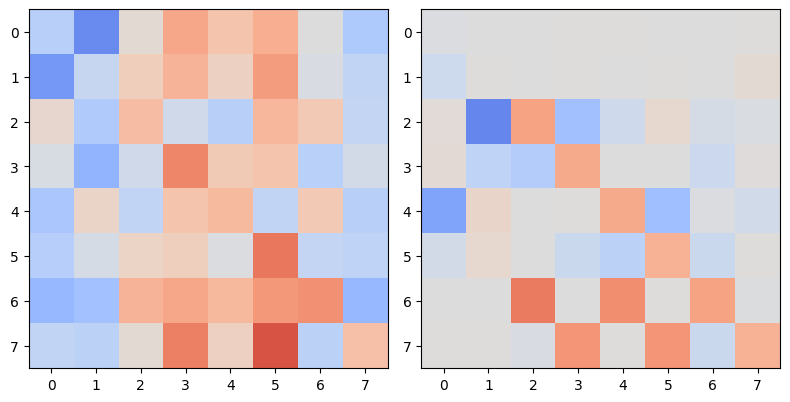

cosine_similarity measure: 0.613
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5332  1.6448
      2        0.4789  1.5858
      3        0.4339  1.6134
      4        0.3955  1.4914
      5        0.3634  1.5704
      6        0.3376  1.4955
      7        0.3212  1.6029
      8        0.3124  1.5440
      9        0.3007  1.5749
     10        0.2859  1.5497
     11        0.2729  1.5791
     12        0.2639  1.5774
     13        0.2580  1.5708
     14        0.2529  1.5189
     15        0.2471  1.5615
     16        0.2404  1.6234
     17        0.2335  1.5616
     18        0.2277  1.5672
     19        0.2246  1.6305
     20        0.2210  1.5575
     21        0.2161  1.5880
     22        0.2115  1.5672
     23        0.2085  1.5954
     24        0.2063  1.5848
     25        0.2038  1.5647
     26        0.2007  1.5644
     27        0.1972  1.5908
     28        0.1944  1.5991
     29        0.1919  1.5688
     30        0.1

    240        0.0656  1.5597
    241        0.0651  1.5751
    242        0.0640  1.6453
    243        0.0642  1.5360
    244        0.0637  1.5678
    245        0.0636  1.5358
    246        0.0644  1.5227
    247        0.0636  1.5166
    248        0.0648  1.5294
    249        0.0659  1.6456
    250        0.0635  1.5129
    251        0.0650  1.5429
    252        0.0657  1.5112
    253        0.0644  1.5295
    254        0.0635  1.5852
    255        0.0645  1.5961
    256        0.0640  1.5838
    257        0.0646  1.5130
    258        0.0656  1.5830
    259        0.0657  1.5869
    260        0.0628  1.5321
    261        0.0663  1.5855
    262        0.0663  1.5961
    263        0.0633  1.5856
    264        0.0635  1.5493
    265        0.0645  1.5438
    266        0.0642  1.5687
    267        0.0640  1.5657
    268        0.0664  1.5798
    269        0.0642  1.5633
    270        0.0661  1.6952
    271        0.0714  1.6010
    272        0.0644  1.6154
    273   

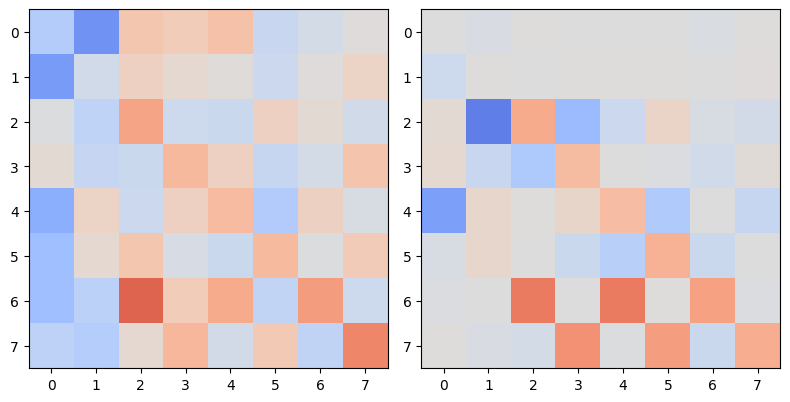

cosine_similarity measure: 0.705
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5552  1.5800
      2        0.4954  1.5943
      3        0.4445  1.5784
      4        0.4016  1.5627
      5        0.3643  1.6378
      6        0.3334  1.6021
      7        0.3108  1.5285
      8        0.2988  1.5222
      9        0.2928  1.5611
     10        0.2836  1.5582
     11        0.2726  1.5296
     12        0.2645  1.5717
     13        0.2598  1.5095
     14        0.2572  1.5352
     15        0.2547  1.6244
     16        0.2519  1.5903
     17        0.2481  1.5630
     18        0.2446  1.6558
     19        0.2418  1.5599
     20        0.2402  1.5407
     21        0.2379  1.5805
     22        0.2344  1.6115
     23        0.2306  1.5415
     24        0.2277  1.5043
     25        0.2253  1.6122
     26        0.2226  1.5210
     27        0.2194  1.5762
     28        0.2160  1.5716
     29        0.2130  1.5852
     30        0.2

    238        0.0650  1.6181
    239        0.0649  1.5930
    240        0.0654  1.6487
    241        0.0657  1.6248
    242        0.0666  1.5833
    243        0.0668  1.6873
    244        0.0650  1.7119
    245        0.0645  1.5431
    246        0.0660  1.5581
    247        0.0669  1.6153
    248        0.0644  1.6496
    249        0.0652  1.5718
    250        0.0670  1.6201
    251        0.0641  1.5384
    252        0.0661  1.6070
    253        0.0680  1.6402
    254        0.0648  1.6108
    255        0.0678  1.5661
    256        0.0673  1.6385
    257        0.0663  1.6722
    258        0.0708  1.6387
    259        0.0682  1.6320
    260        0.0665  1.5705
    261        0.0685  1.6107
    262        0.0673  1.6180
    263        0.0653  1.6481
    264        0.0677  1.5764
    265        0.0652  1.5875
    266        0.0669  1.6002
    267        0.0650  1.5762
    268        0.0654  1.6209
    269        0.0654  1.6313
    270        0.0653  1.5964
    271   

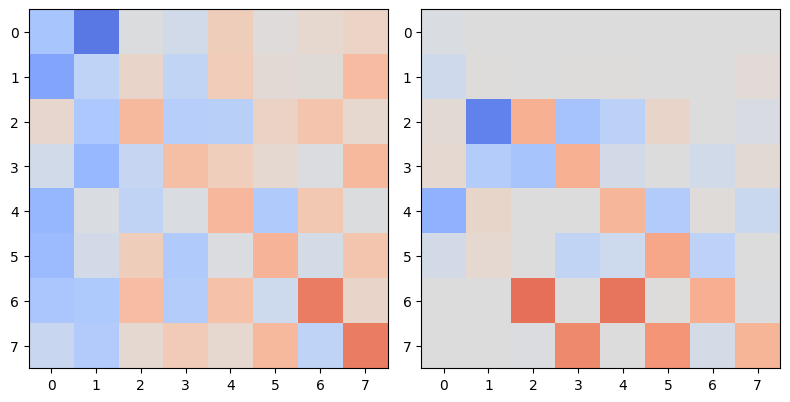

cosine_similarity measure: 0.637
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5033  1.6789
      2        0.4459  1.5127
      3        0.3944  1.5871
      4        0.3499  1.5506
      5        0.3138  1.5838
      6        0.2902  1.6066
      7        0.2857  1.5932
      8        0.2873  1.5558
      9        0.2766  1.5994
     10        0.2637  1.6912
     11        0.2566  1.5832
     12        0.2539  1.5919
     13        0.2529  1.6426
     14        0.2511  1.5476
     15        0.2478  1.5792
     16        0.2424  1.6124
     17        0.2368  1.6230
     18        0.2314  1.6026
     19        0.2278  1.5854
     20        0.2263  1.6120
     21        0.2253  1.6150
     22        0.2223  1.6360
     23        0.2178  1.5604
     24        0.2142  1.6419
     25        0.2118  1.5935
     26        0.2103  1.5541
     27        0.2083  1.6153
     28        0.2061  1.5516
     29        0.2038  1.6159
     30        0.2

    239        0.0668  1.4981
    240        0.0720  1.5211
    241        0.0655  1.6051
    242        0.0731  1.5469
    243        0.0669  1.6019
    244        0.0697  1.6059
    245        0.0667  1.5280
    246        0.0676  1.5659
    247        0.0675  1.5671
    248        0.0653  1.5746
    249        0.0682  1.5727
    250        0.0654  1.5681
    251        0.0673  1.5637
    252        0.0644  1.6157
    253        0.0659  1.5896
    254        0.0664  1.6035
    255        0.0641  1.6274
    256        0.0658  1.5751
    257        0.0658  1.6044
    258        0.0664  1.5939
    259        0.0664  1.6174
    260        0.0652  1.5420
    261        0.0716  1.5671
    262        0.0682  1.5949
    263        0.0681  1.6446
    264        0.0736  1.6385
    265        0.0673  1.5606
    266        0.0684  1.6161
    267        0.0674  1.6407
    268        0.0663  1.6091
    269        0.0667  1.6098
    270        0.0669  1.5425
    271        0.0657  1.5443
    272   

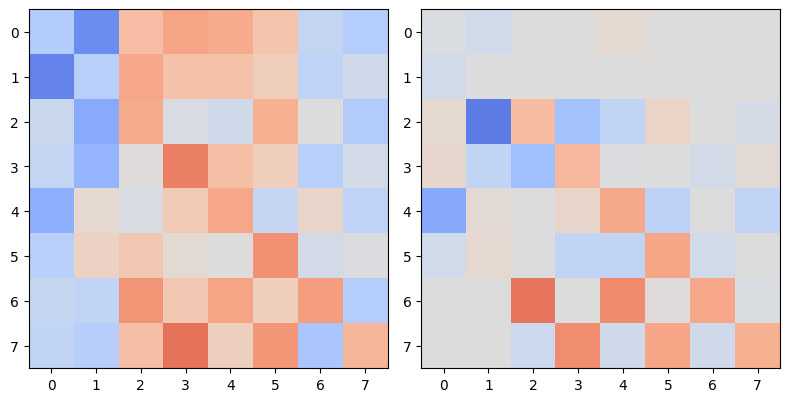

cosine_similarity measure: 0.68
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.4890  1.5911
      2        0.4341  1.5580
      3        0.3844  1.5486
      4        0.3403  1.6869
      5        0.3036  1.5983
      6        0.2789  1.6418
      7        0.2756  1.5717
      8        0.2782  1.5491
      9        0.2684  1.5945
     10        0.2565  1.6353
     11        0.2496  1.5733
     12        0.2464  1.5760
     13        0.2443  1.5889
     14        0.2412  1.6002
     15        0.2371  1.6431
     16        0.2321  1.5446
     17        0.2271  1.6340
     18        0.2226  1.5420
     19        0.2198  1.5957
     20        0.2178  1.6814
     21        0.2148  1.6488
     22        0.2101  1.6763
     23        0.2059  1.5925
     24        0.2035  1.6113
     25        0.2016  1.6207
     26        0.1999  1.5427
     27        0.1976  1.6522
     28        0.1949  1.5735
     29        0.1926  1.6431
     30        0.19

    240        0.0649  1.5655
    241        0.0637  1.6086
    242        0.0670  1.6101
    243        0.0667  1.5491
    244        0.0656  1.5586
    245        0.0695  1.6621
    246        0.0694  1.5784
    247        0.0643  1.6076
    248        0.0661  1.6410
    249        0.0647  1.5714
    250        0.0641  1.6458
    251        0.0658  1.6523
    252        0.0625  1.5871
    253        0.0644  1.5481
    254        0.0646  1.5210
    255        0.0672  1.6410
    256        0.0625  1.6704
    257        0.0633  1.6465
    258        0.0634  1.5974
    259        0.0623  1.6587
    260        0.0631  1.6288
    261        0.0616  1.6418
    262        0.0635  1.6521
    263        0.0623  1.6519
    264        0.0629  1.6113
    265        0.0641  1.6226
    266        0.0621  1.6056
    267        0.0637  1.6050
    268        0.0634  1.5592
    269        0.0648  1.6772
    270        0.0688  1.5616
    271        0.0636  1.6706
    272        0.0646  1.6256
    273   

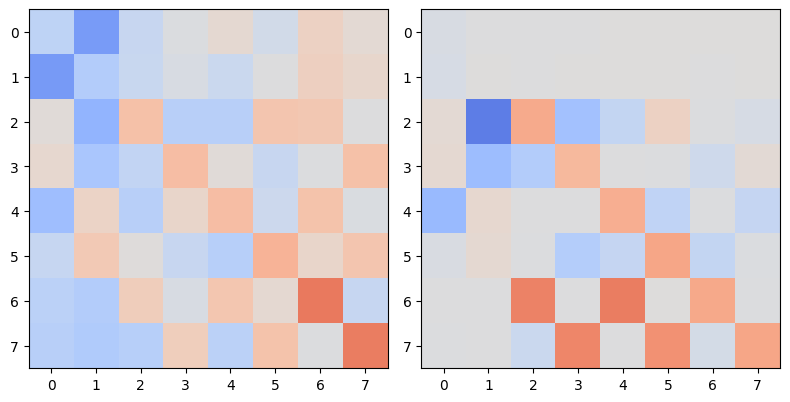

cosine_similarity measure: 0.661
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5436  1.6020
      2        0.4831  1.5730
      3        0.4327  1.5858
      4        0.3906  1.5186
      5        0.3551  1.5286
      6        0.3242  1.5508
      7        0.3002  1.5750
      8        0.2873  1.5261
      9        0.2839  1.6191
     10        0.2758  1.6288
     11        0.2625  1.5734
     12        0.2517  1.6182
     13        0.2457  1.6188
     14        0.2427  1.6262
     15        0.2400  1.5207
     16        0.2371  1.6292
     17        0.2331  1.6625
     18        0.2287  1.5904
     19        0.2242  1.6292
     20        0.2206  1.5713
     21        0.2188  1.5365
     22        0.2177  1.6764
     23        0.2156  1.5551
     24        0.2120  1.6204
     25        0.2085  1.5871
     26        0.2067  1.5549
     27        0.2053  1.6056
     28        0.2036  1.5165
     29        0.2015  1.5673
     30        0.1

    239        0.0667  1.5848
    240        0.0645  1.5804
    241        0.0646  1.5580
    242        0.0651  1.5968
    243        0.0672  1.5926
    244        0.0646  1.6227
    245        0.0653  1.5702
    246        0.0642  1.5247
    247        0.0640  1.6133
    248        0.0641  1.5738
    249        0.0642  1.5790
    250        0.0641  1.5703
    251        0.0647  1.6313
    252        0.0660  1.6238
    253        0.0655  1.5542
    254        0.0670  1.5852
    255        0.0662  1.5673
    256        0.0641  1.5280
    257        0.0673  1.5188
    258        0.0634  1.6505
    259        0.0665  1.5751
    260        0.0645  1.5713
    261        0.0642  1.6329
    262        0.0649  1.6293
    263        0.0641  1.5428
    264        0.0658  1.6891
    265        0.0640  1.6018
    266        0.0652  1.5954
    267        0.0644  1.6567
    268        0.0645  1.5903
    269        0.0639  1.5774
    270        0.0656  1.6222
    271        0.0672  1.5497
    272   

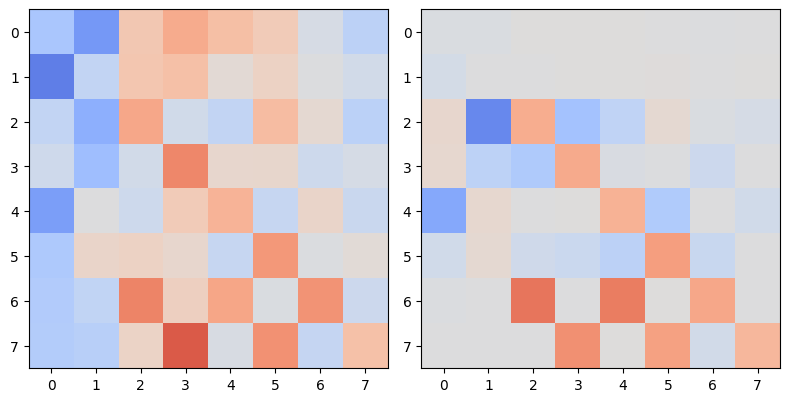

cosine_similarity measure: 0.748
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.4986  1.4944
      2        0.4482  1.5716
      3        0.4040  1.5395
      4        0.3648  1.5621
      5        0.3313  1.5289
      6        0.3100  1.5821
      7        0.3126  1.5078
      8        0.3120  1.6148
      9        0.2962  1.5952
     10        0.2819  1.5386
     11        0.2748  1.6351
     12        0.2712  1.5315
     13        0.2675  1.6219
     14        0.2624  1.5934
     15        0.2558  1.5438
     16        0.2478  1.5495
     17        0.2399  1.6573
     18        0.2333  1.5655
     19        0.2293  1.5487
     20        0.2278  1.5813
     21        0.2257  1.5455
     22        0.2218  1.6111
     23        0.2171  1.6139
     24        0.2138  1.6343
     25        0.2122  1.6204
     26        0.2109  1.5660
     27        0.2095  1.6442
     28        0.2074  1.5206
     29        0.2046  1.6292
     30        0.2

    236        0.0707  1.6076
    237        0.0679  1.6541
    238        0.0696  1.5827
    239        0.0686  1.6170
    240        0.0660  1.5785
    241        0.0690  1.5998
    242        0.0664  1.5980
    243        0.0726  1.5427
    244        0.0679  1.5992
    245        0.0660  1.5922
    246        0.0679  1.6160
    247        0.0644  1.5770
    248        0.0676  1.6833
    249        0.0657  1.5936
    250        0.0672  1.6139
    251        0.0662  1.5420
    252        0.0669  1.5370
    253        0.0699  1.6098
    254        0.0650  1.6073
    255        0.0693  1.6395
    256        0.0645  1.6333
    257        0.0712  1.5780
    258        0.0637  1.5169
    259        0.0697  1.5507
    260        0.0648  1.6053
    261        0.0689  1.6249
    262        0.0643  1.5454
    263        0.0672  1.6591
    264        0.0632  1.5865
    265        0.0680  1.5621
    266        0.0644  1.5744
    267        0.0667  1.6262
    268        0.0651  1.5695
    269   

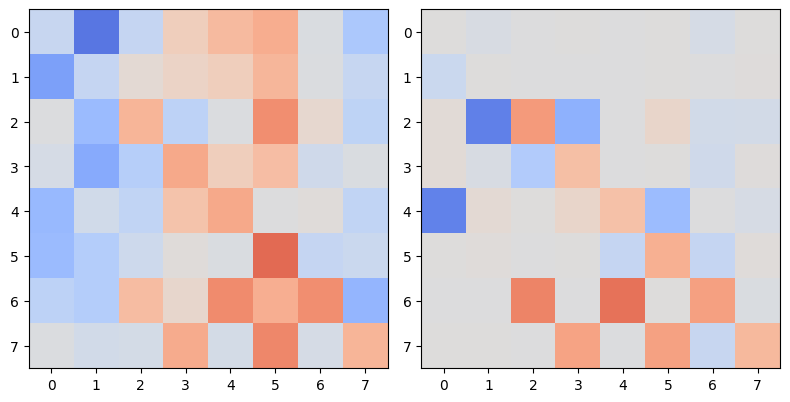

cosine_similarity measure: 0.648
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.4844  1.5842
      2        0.4342  1.8186
      3        0.3890  1.6312
      4        0.3491  1.6172
      5        0.3168  1.5337
      6        0.2966  1.5735
      7        0.2947  1.6744
      8        0.2896  1.5957
      9        0.2747  1.6219
     10        0.2620  1.6163
     11        0.2554  1.6830
     12        0.2516  1.5408
     13        0.2478  1.7008
     14        0.2432  1.6131
     15        0.2377  1.5635
     16        0.2322  1.6712
     17        0.2284  1.6639
     18        0.2273  1.6066
     19        0.2261  1.6614
     20        0.2229  1.6550
     21        0.2189  1.6075
     22        0.2168  1.6964
     23        0.2154  1.6046
     24        0.2139  1.6543
     25        0.2115  1.6363
     26        0.2085  1.6247
     27        0.2053  1.5765
     28        0.2031  1.6022
     29        0.2021  1.5781
     30        0.2

    238        0.0667  1.6403
    239        0.0688  1.5498
    240        0.0695  1.5848
    241        0.0663  1.5546
    242        0.0669  1.5587
    243        0.0690  1.6550
    244        0.0659  1.5734
    245        0.0662  1.6117
    246        0.0637  1.6015
    247        0.0649  1.5587
    248        0.0656  1.5630
    249        0.0640  1.5654
    250        0.0651  1.6323
    251        0.0649  1.5506
    252        0.0690  1.5390
    253        0.0673  1.6118
    254        0.0649  1.5673
    255        0.0670  1.5092
    256        0.0659  1.5435
    257        0.0657  1.5480
    258        0.0667  1.5502
    259        0.0642  1.5985
    260        0.0677  1.6008
    261        0.0651  1.6008
    262        0.0644  1.6136
    263        0.0653  1.6010
    264        0.0648  1.6162
    265        0.0685  1.5903
    266        0.0667  1.5656
    267        0.0638  1.5751
    268        0.0678  1.6144
    269        0.0665  1.6206
    270        0.0639  1.6390
    271   

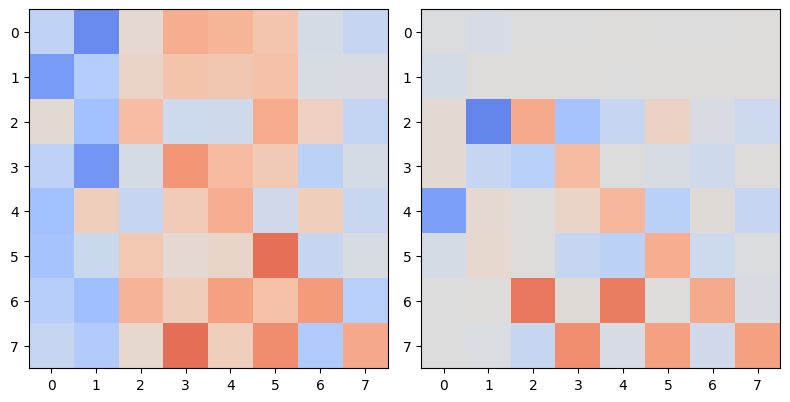

cosine_similarity measure: 0.663
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5103  1.5573
      2        0.4572  1.6658
      3        0.4087  1.5484
      4        0.3644  1.5419
      5        0.3252  1.5521
      6        0.2955  1.5592
      7        0.2864  1.5028
      8        0.2885  1.5435
      9        0.2762  1.6381
     10        0.2615  1.6263
     11        0.2532  1.5981
     12        0.2497  1.6016
     13        0.2484  1.5050
     14        0.2464  1.5629
     15        0.2431  1.5814
     16        0.2385  1.5528
     17        0.2329  1.5225
     18        0.2275  1.5773
     19        0.2230  1.6164
     20        0.2198  1.6008
     21        0.2184  1.6059
     22        0.2165  1.5873
     23        0.2122  1.6031
     24        0.2077  1.5627
     25        0.2041  1.5728
     26        0.2021  1.5627
     27        0.2007  1.6122
     28        0.1985  1.5544
     29        0.1957  1.5493
     30        0.1

    241        0.0682  1.5965
    242        0.0663  1.5520
    243        0.0687  1.6282
    244        0.0657  1.6022
    245        0.0663  1.6338
    246        0.0667  1.5356
    247        0.0649  1.5767
    248        0.0672  1.5602
    249        0.0634  1.5214
    250        0.0669  1.6438
    251        0.0632  1.5649
    252        0.0653  1.6021
    253        0.0649  1.6203
    254        0.0638  1.5783
    255        0.0651  1.6535
    256        0.0644  1.5961
    257        0.0629  1.6209
    258        0.0656  1.5887
    259        0.0642  1.5974
    260        0.0646  1.6965
    261        0.0658  1.5840
    262        0.0628  1.6132
    263        0.0652  1.5704
    264        0.0625  1.5846
    265        0.0623  1.6775
    266        0.0647  1.6079
    267        0.0621  1.6433
    268        0.0635  1.5483
    269        0.0652  1.5971
    270        0.0620  1.6033
    271        0.0630  1.5359
    272        0.0623  1.5657
    273        0.0623  1.5517
    274   

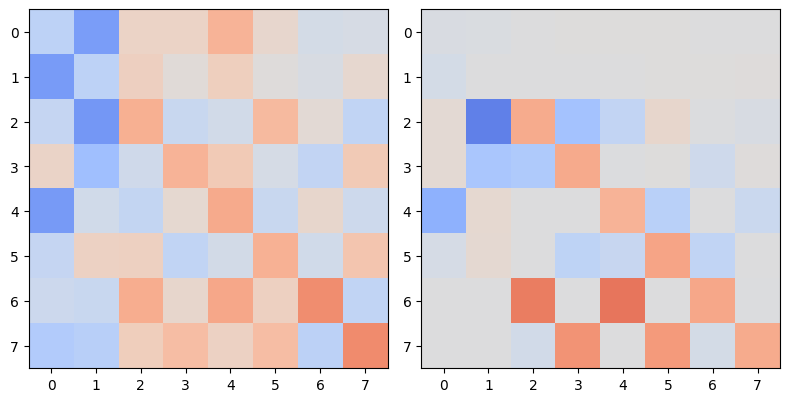

cosine_similarity measure: 0.757
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5416  1.5451
      2        0.4805  1.5605
      3        0.4259  1.5556
      4        0.3787  1.5817
      5        0.3405  1.5770
      6        0.3119  1.6488
      7        0.2965  1.5450
      8        0.2909  1.5285
      9        0.2815  1.6157
     10        0.2683  1.6936
     11        0.2576  1.5651
     12        0.2508  1.5423
     13        0.2465  1.5266
     14        0.2431  1.6146
     15        0.2392  1.6191
     16        0.2347  1.5732
     17        0.2305  1.6274
     18        0.2265  1.6096
     19        0.2241  1.5840
     20        0.2227  1.5241
     21        0.2203  1.6456
     22        0.2167  1.5451
     23        0.2133  1.6079
     24        0.2109  1.5893
     25        0.2088  1.6381
     26        0.2067  1.6390
     27        0.2038  1.5801
     28        0.2009  1.6168
     29        0.1990  1.5056
     30        0.1

    242        0.0655  1.6105
    243        0.0656  1.5617
    244        0.0674  1.6053
    245        0.0662  1.5575
    246        0.0666  1.6250
    247        0.0681  1.6146
    248        0.0665  1.6235
    249        0.0641  1.6497
    250        0.0671  1.5830
    251        0.0655  1.5468
    252        0.0643  1.5932
    253        0.0651  1.5228
    254        0.0641  1.6316
    255        0.0660  1.6131
    256        0.0642  1.5727
    257        0.0645  1.6462
    258        0.0671  1.6232
    259        0.0676  1.5917
    260        0.0653  1.6242
    261        0.0652  1.5208
    262        0.0636  1.6352
    263        0.0641  1.5996
    264        0.0640  1.6175
    265        0.0642  1.5529
    266        0.0646  1.6485
    267        0.0645  1.6250
    268        0.0648  1.6076
    269        0.0654  1.5624
    270        0.0664  1.6274
    271        0.0684  1.6049
    272        0.0673  1.6244
    273        0.0642  1.6036
    274        0.0644  1.6689
    275   

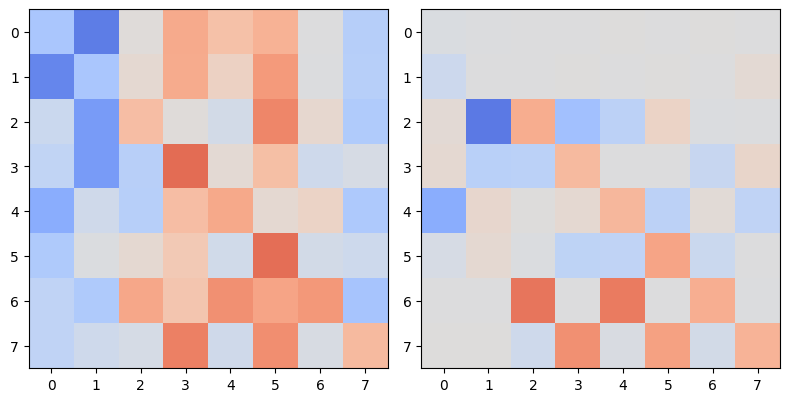

cosine_similarity measure: 0.661
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5114  1.5940
      2        0.4540  1.6759
      3        0.4041  1.5221
      4        0.3617  1.5657
      5        0.3264  1.6173
      6        0.3008  1.5823
      7        0.2908  1.6559
      8        0.2902  1.6415
      9        0.2804  1.5749
     10        0.2662  1.5979
     11        0.2561  1.5510
     12        0.2516  1.5477
     13        0.2489  1.5965
     14        0.2465  1.5154
     15        0.2427  1.5379
     16        0.2381  1.5318
     17        0.2325  1.6233
     18        0.2273  1.5820
     19        0.2233  1.5392
     20        0.2206  1.5873
     21        0.2186  1.6564
     22        0.2153  1.5440
     23        0.2112  1.6448
     24        0.2081  1.5218
     25        0.2063  1.5750
     26        0.2048  1.6440
     27        0.2034  1.6057
     28        0.2009  1.5255
     29        0.1981  1.6239
     30        0.1

    237        0.0709  1.6422
    238        0.0675  1.5095
    239        0.0766  1.5688
    240        0.0652  1.5430
    241        0.0705  1.6498
    242        0.0670  1.6576
    243        0.0667  1.6148
    244        0.0687  1.6154
    245        0.0663  1.5463
    246        0.0687  1.5689
    247        0.0658  1.5986
    248        0.0696  1.6080
    249        0.0704  1.6211
    250        0.0683  1.6311
    251        0.0731  1.7136
    252        0.0661  1.5948
    253        0.0710  1.6775
    254        0.0678  1.5089
    255        0.0692  1.5529
    256        0.0660  1.5548
    257        0.0655  1.5845
    258        0.0675  1.6808
    259        0.0659  1.5555
    260        0.0664  1.6184
    261        0.0656  1.6671
    262        0.0644  1.6266
    263        0.0650  1.6224
    264        0.0645  1.6843
    265        0.0665  1.5585
    266        0.0636  1.5511
    267        0.0644  1.6572
    268        0.0634  1.6564
    269        0.0654  1.6218
    270   

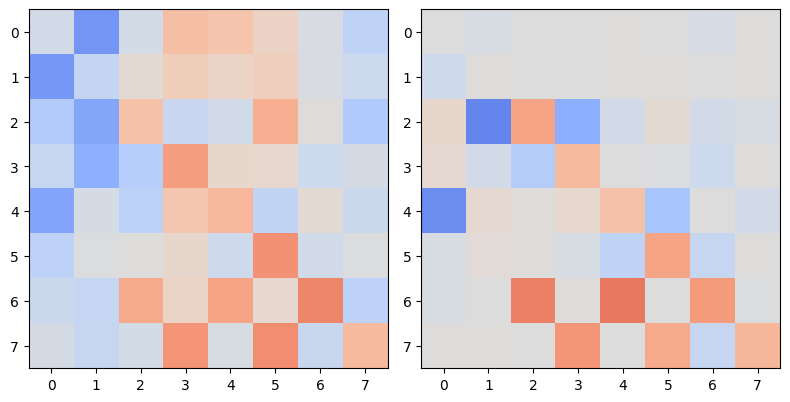

cosine_similarity measure: 0.751
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5115  1.6846
      2        0.4545  1.6551
      3        0.4058  1.5865
      4        0.3636  1.6225
      5        0.3277  1.5671
      6        0.2997  1.5827
      7        0.2854  1.5709
      8        0.2895  1.6477
      9        0.2852  1.6603
     10        0.2711  1.5901
     11        0.2596  1.6809
     12        0.2544  1.5784
     13        0.2522  1.6098
     14        0.2508  1.6421
     15        0.2487  1.5956
     16        0.2451  1.5735
     17        0.2405  1.6404
     18        0.2356  1.6600
     19        0.2307  1.5907
     20        0.2275  1.6413
     21        0.2264  1.6358
     22        0.2253  1.6038
     23        0.2219  1.6345
     24        0.2176  1.6185
     25        0.2144  1.6036
     26        0.2126  1.6419
     27        0.2116  1.5542
     28        0.2104  1.6010
     29        0.2084  1.6584
     30        0.2

    238        0.0639  1.6209
    239        0.0643  1.6465
    240        0.0673  1.5949
    241        0.0632  1.5370
    242        0.0669  1.6192
    243        0.0650  1.6568
    244        0.0652  1.5627
    245        0.0649  1.6174
    246        0.0648  1.5803
    247        0.0653  1.6300
    248        0.0638  1.5511
    249        0.0655  1.5612
    250        0.0634  1.6085
    251        0.0635  1.6062
    252        0.0628  1.5916
    253        0.0632  1.6308
    254        0.0649  1.5837
    255        0.0641  1.6101
    256        0.0629  1.5486
    257        0.0639  1.6142
    258        0.0645  1.6239
    259        0.0651  1.5663
    260        0.0635  1.6549
    261        0.0634  1.6476
    262        0.0638  1.6022
    263        0.0634  1.5762
    264        0.0630  1.6210
    265        0.0639  1.5641
    266        0.0646  1.5991
    267        0.0626  1.6604
    268        0.0640  1.6413
    269        0.0632  1.6178
    270        0.0638  1.5633
    271   

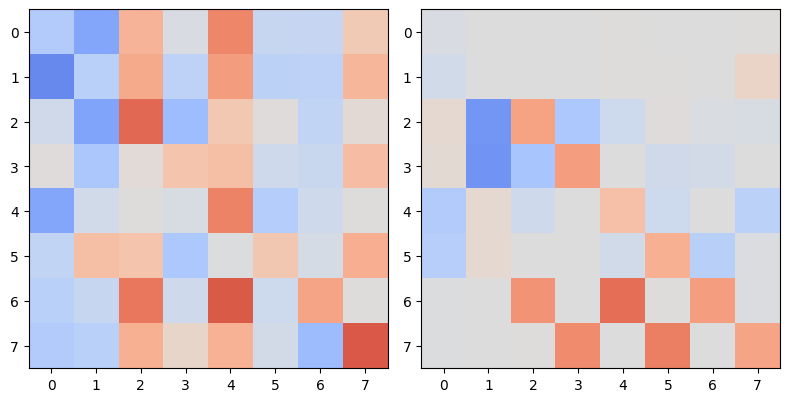

cosine_similarity measure: 0.593
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5380  1.6125
      2        0.4825  1.6886
      3        0.4324  1.5779
      4        0.3896  1.5788
      5        0.3529  1.5985
      6        0.3263  1.6145
      7        0.3126  1.5961
      8        0.3060  1.6292
      9        0.2914  1.6214
     10        0.2759  1.5614
     11        0.2650  1.6220
     12        0.2588  1.6065
     13        0.2548  1.6184
     14        0.2512  1.6706
     15        0.2466  1.5328
     16        0.2419  1.5819
     17        0.2376  1.5777
     18        0.2344  1.5379
     19        0.2322  1.5620
     20        0.2293  1.6199
     21        0.2252  1.5457
     22        0.2207  1.6443
     23        0.2177  1.5585
     24        0.2151  1.5528
     25        0.2125  1.6163
     26        0.2093  1.6222
     27        0.2058  1.5094
     28        0.2025  1.6272
     29        0.2000  1.5378
     30        0.1

    238        0.0686  1.5865
    239        0.0661  1.6157
    240        0.0660  1.5858
    241        0.0681  1.5103
    242        0.0656  1.5748
    243        0.0721  1.7099
    244        0.0649  1.5861
    245        0.0662  1.6063
    246        0.0660  1.5961
    247        0.0651  1.6126
    248        0.0671  1.5918
    249        0.0639  1.6379
    250        0.0692  1.5334
    251        0.0644  1.6269
    252        0.0655  1.6371
    253        0.0649  1.6071
    254        0.0644  1.6270
    255        0.0657  1.6390
    256        0.0678  1.6326
    257        0.0667  1.6022
    258        0.0647  1.6280
    259        0.0652  1.6276
    260        0.0645  1.5786
    261        0.0665  1.6208
    262        0.0667  1.5157
    263        0.0643  1.5726
    264        0.0649  1.5920
    265        0.0643  1.5908
    266        0.0639  1.5836
    267        0.0646  1.5804
    268        0.0645  1.6427
    269        0.0642  1.6428
    270        0.0667  1.5414
    271   

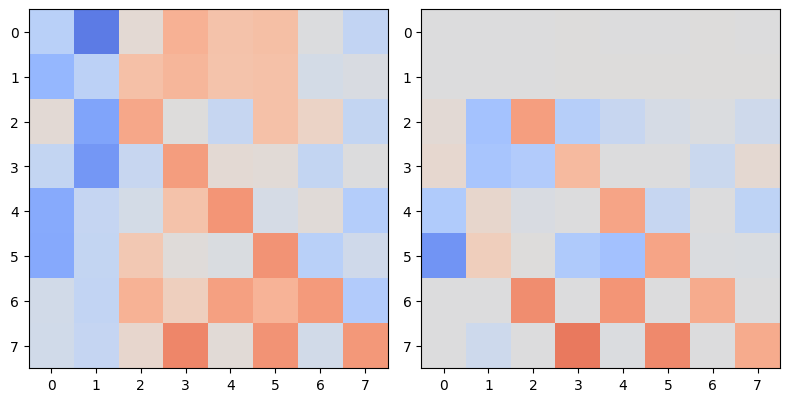

cosine_similarity measure: 0.714
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.4499  1.5777
      2        0.3957  1.6075
      3        0.3480  1.5897
      4        0.3073  1.6009
      5        0.2761  1.5949
      6        0.2637  1.5558
      7        0.2730  1.6017
      8        0.2654  1.5745
      9        0.2493  1.5851
     10        0.2394  1.6431
     11        0.2357  1.6574
     12        0.2349  1.6436
     13        0.2342  1.6215
     14        0.2323  1.6813
     15        0.2289  1.6808
     16        0.2243  1.5302
     17        0.2195  1.6566
     18        0.2153  1.5911
     19        0.2122  1.5875
     20        0.2106  1.6027
     21        0.2086  1.6290
     22        0.2052  1.5690
     23        0.2019  1.5595
     24        0.1997  1.6156
     25        0.1981  1.5857
     26        0.1972  1.6113
     27        0.1954  1.6330
     28        0.1929  1.5266
     29        0.1906  1.6118
     30        0.1

    237        0.0640  1.5360
    238        0.0637  1.5942
    239        0.0645  1.6214
    240        0.0628  1.6292
    241        0.0631  1.6191
    242        0.0652  1.5992
    243        0.0636  1.6513
    244        0.0628  1.5822
    245        0.0661  1.6062
    246        0.0645  1.5824
    247        0.0628  1.6599
    248        0.0675  1.6190
    249        0.0665  1.6408
    250        0.0640  1.6020
    251        0.0663  1.5939
    252        0.0643  1.5852
    253        0.0648  1.5497
    254        0.0665  1.6692
    255        0.0637  1.6663
    256        0.0649  1.6511
    257        0.0673  1.5920
    258        0.0627  1.6652
    259        0.0659  1.6884
    260        0.0642  1.6245
    261        0.0642  1.6223
    262        0.0663  1.6062
    263        0.0648  1.6472
    264        0.0665  1.6583
    265        0.0618  1.5424
    266        0.0660  1.6038
    267        0.0620  1.7045
    268        0.0644  1.6073
    269        0.0624  1.7007
    270   

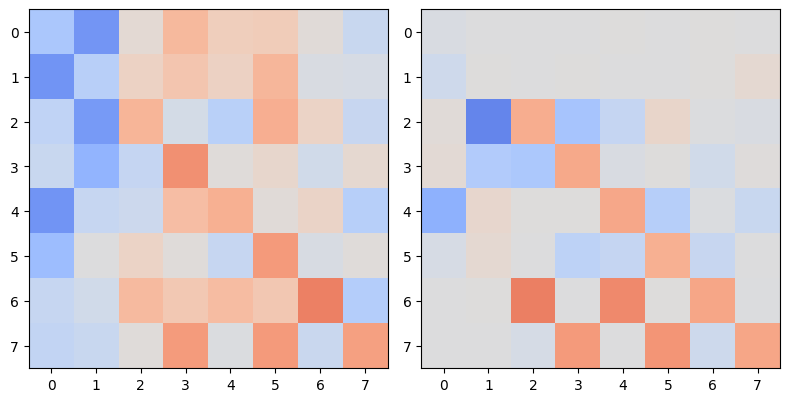

cosine_similarity measure: 0.73
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5558  1.5536
      2        0.4957  1.5882
      3        0.4456  1.6979
      4        0.4028  1.6109
      5        0.3646  1.6542
      6        0.3313  1.7300
      7        0.3056  1.5869
      8        0.2935  1.5936
      9        0.2915  1.6028
     10        0.2838  1.5694
     11        0.2705  1.5613
     12        0.2600  1.6173
     13        0.2546  1.6195
     14        0.2519  1.6201
     15        0.2497  1.5810
     16        0.2473  1.5998
     17        0.2437  1.5727
     18        0.2391  1.6467
     19        0.2344  1.6630
     20        0.2301  1.6184
     21        0.2274  1.6148
     22        0.2259  1.6054
     23        0.2236  1.6142
     24        0.2201  1.5400
     25        0.2159  1.5221
     26        0.2131  1.6277
     27        0.2107  1.6359
     28        0.2088  1.5879
     29        0.2068  1.6073
     30        0.20

    238        0.0654  1.5313
    239        0.0681  1.5764
    240        0.0663  1.5803
    241        0.0650  1.6637
    242        0.0688  1.6288
    243        0.0706  1.6293
    244        0.0656  1.5148
    245        0.0671  1.6237
    246        0.0663  1.6909
    247        0.0660  1.6336
    248        0.0663  1.5506
    249        0.0663  1.6354
    250        0.0670  1.5749
    251        0.0673  1.5328
    252        0.0686  1.5298
    253        0.0713  1.5782
    254        0.0708  1.5673
    255        0.0661  1.5912
    256        0.0700  1.5816
    257        0.0663  1.5952
    258        0.0709  1.5921
    259        0.0676  1.5712
    260        0.0662  1.6620
    261        0.0721  1.5603
    262        0.0658  1.5564
    263        0.0671  1.5278
    264        0.0674  1.5941
    265        0.0651  1.6943
    266        0.0667  1.6332
    267        0.0695  1.6191
    268        0.0656  1.6530
    269        0.0683  1.5806
    270        0.0649  1.5802
    271   

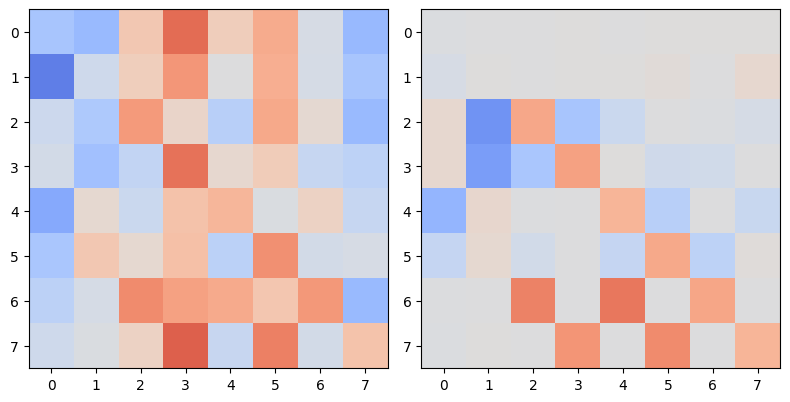

cosine_similarity measure: 0.645
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5441  1.5736
      2        0.4910  1.5911
      3        0.4422  1.6367
      4        0.3970  1.6853
      5        0.3562  1.6500
      6        0.3233  1.6921
      7        0.3050  1.5958
      8        0.3012  1.6065
      9        0.2917  1.6354
     10        0.2773  1.5712
     11        0.2668  1.5713
     12        0.2619  1.6084
     13        0.2596  1.6640
     14        0.2575  1.6307
     15        0.2545  1.6814
     16        0.2500  1.5967
     17        0.2450  1.5682
     18        0.2401  1.6802
     19        0.2363  1.7050
     20        0.2347  1.5709
     21        0.2327  1.5390
     22        0.2291  1.5806
     23        0.2247  1.5867
     24        0.2214  1.5231
     25        0.2197  1.6336
     26        0.2179  1.6589
     27        0.2155  1.4994
     28        0.2126  1.6410
     29        0.2096  1.6378
     30        0.2

    235        0.0678  1.6673
    236        0.0708  1.5526
    237        0.0667  1.5657
    238        0.0701  1.5771
    239        0.0681  1.6064
    240        0.0691  1.6259
    241        0.0667  1.6526
    242        0.0688  1.5535
    243        0.0661  1.6632
    244        0.0659  1.6308
    245        0.0665  1.6663
    246        0.0669  1.5625
    247        0.0666  1.5329
    248        0.0669  1.5980
    249        0.0662  1.6272
    250        0.0654  1.6177
    251        0.0649  1.6017
    252        0.0658  1.5967
    253        0.0663  1.5920
    254        0.0650  1.5906
    255        0.0656  1.5962
    256        0.0655  1.5924
    257        0.0647  1.4653
    258        0.0661  1.5952
    259        0.0653  1.6012
    260        0.0653  1.5811
    261        0.0682  1.6015
    262        0.0651  1.5430
    263        0.0645  1.6200
    264        0.0661  1.6388
    265        0.0646  1.6199
    266        0.0655  1.5966
    267        0.0646  1.5007
    268   

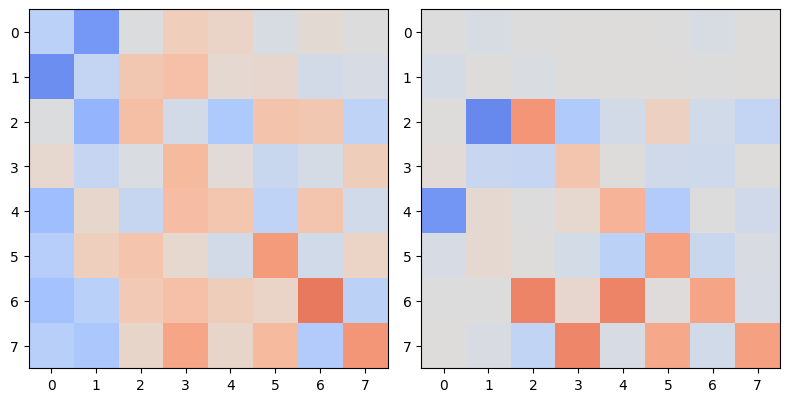

cosine_similarity measure: 0.656
[1.  0.  0.1 0.9 0.1 0.9]
[1.  0.  0.1 0.9 0.3 0.7]
[1.  0.  0.1 0.9 0.4 0.6]
[1.   0.   0.1  0.9  0.45 0.55]
[1.    0.    0.1   0.9   0.475 0.525]
[1.     0.     0.1    0.9    0.4875 0.5125]
[1.      0.      0.1     0.9     0.49375 0.50625]
[1.  0.  0.1 0.9 0.5 0.5]
[1.      0.      0.1     0.9     0.50625 0.49375]
[1.     0.     0.1    0.9    0.5125 0.4875]
[1.    0.    0.1   0.9   0.525 0.475]
[1.   0.   0.1  0.9  0.55 0.45]
[1.  0.  0.1 0.9 0.6 0.4]
[1.  0.  0.1 0.9 0.7 0.3]
[1.  0.  0.1 0.9 0.9 0.1]
[1.  0.  0.3 0.7 0.1 0.9]
[1.  0.  0.3 0.7 0.3 0.7]
[1.  0.  0.3 0.7 0.4 0.6]
[1.   0.   0.3  0.7  0.45 0.55]
[1.    0.    0.3   0.7   0.475 0.525]
[1.     0.     0.3    0.7    0.4875 0.5125]
[1.      0.      0.3     0.7     0.49375 0.50625]
[1.  0.  0.3 0.7 0.5 0.5]
[1.      0.      0.3     0.7     0.50625 0.49375]
[1.     0.     0.3    0.7    0.5125 0.4875]
[1.    0.    0.3   0.7   0.525 0.475]
[1.   0.   0.3  0.7  0.55 0.45]
[1.  0.  0.3 0.7 0.6 0.4]

[1.  0.  0.7 0.3 0.9 0.1]
[1.  0.  0.9 0.1 0.1 0.9]
[1.  0.  0.9 0.1 0.3 0.7]
[1.  0.  0.9 0.1 0.4 0.6]
[1.   0.   0.9  0.1  0.45 0.55]
[1.    0.    0.9   0.1   0.475 0.525]
[1.     0.     0.9    0.1    0.4875 0.5125]
[1.      0.      0.9     0.1     0.49375 0.50625]
[1.  0.  0.9 0.1 0.5 0.5]
[1.      0.      0.9     0.1     0.50625 0.49375]
[1.     0.     0.9    0.1    0.5125 0.4875]
[1.    0.    0.9   0.1   0.525 0.475]
[1.   0.   0.9  0.1  0.55 0.45]
[1.  0.  0.9 0.1 0.6 0.4]
[1.  0.  0.9 0.1 0.7 0.3]
[1.  0.  0.9 0.1 0.9 0.1]
[0.  1.  0.1 0.9 0.1 0.9]
[0.  1.  0.3 0.7 0.1 0.9]
[0.  1.  0.4 0.6 0.1 0.9]
[0.   1.   0.45 0.55 0.1  0.9 ]
[0.    1.    0.475 0.525 0.1   0.9  ]
[0.     1.     0.4875 0.5125 0.1    0.9   ]
[0.      1.      0.49375 0.50625 0.1     0.9    ]
[0.  1.  0.5 0.5 0.1 0.9]
[0.      1.      0.50625 0.49375 0.1     0.9    ]
[0.     1.     0.5125 0.4875 0.1    0.9   ]
[0.    1.    0.525 0.475 0.1   0.9  ]
[0.   1.   0.55 0.45 0.1  0.9 ]
[0.  1.  0.6 0.4 0.1 0.9]
[0.  1

[0.  1.  0.7 0.3 0.6 0.4]
[0.  1.  0.9 0.1 0.6 0.4]
[0.  1.  0.1 0.9 0.7 0.3]
[0.  1.  0.3 0.7 0.7 0.3]
[0.  1.  0.4 0.6 0.7 0.3]
[0.   1.   0.45 0.55 0.7  0.3 ]
[0.    1.    0.475 0.525 0.7   0.3  ]
[0.     1.     0.4875 0.5125 0.7    0.3   ]
[0.      1.      0.49375 0.50625 0.7     0.3    ]
[0.  1.  0.5 0.5 0.7 0.3]
[0.      1.      0.50625 0.49375 0.7     0.3    ]
[0.     1.     0.5125 0.4875 0.7    0.3   ]
[0.    1.    0.525 0.475 0.7   0.3  ]
[0.   1.   0.55 0.45 0.7  0.3 ]
[0.  1.  0.6 0.4 0.7 0.3]
[0.  1.  0.7 0.3 0.7 0.3]
[0.  1.  0.9 0.1 0.7 0.3]
[0.  1.  0.1 0.9 0.9 0.1]
[0.  1.  0.3 0.7 0.9 0.1]
[0.  1.  0.4 0.6 0.9 0.1]
[0.   1.   0.45 0.55 0.9  0.1 ]
[0.    1.    0.475 0.525 0.9   0.1  ]
[0.     1.     0.4875 0.5125 0.9    0.1   ]
[0.      1.      0.49375 0.50625 0.9     0.1    ]
[0.  1.  0.5 0.5 0.9 0.1]
[0.      1.      0.50625 0.49375 0.9     0.1    ]
[0.     1.     0.5125 0.4875 0.9    0.1   ]
[0.    1.    0.525 0.475 0.9   0.1  ]
[0.   1.   0.55 0.45 0.9  0.1 ]
[0.  1

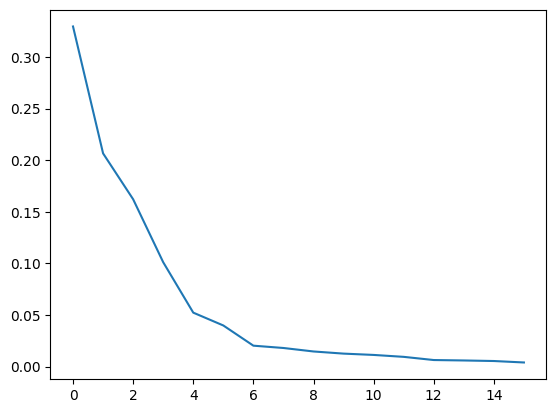

Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6310  1.7534
      2        0.5708  1.5969
      3        0.5146  1.6830
      4        0.4618  1.6060
      5        0.4153  1.6142
      6        0.3889  1.6722
      7        0.3869  1.6747
      8        0.3655  1.6098
      9        0.3453  1.6622
     10        0.3378  1.6011
     11        0.3349  1.6529
     12        0.3304  1.5823
     13        0.3228  1.6902
     14        0.3151  1.6139
     15        0.3107  1.6295
     16        0.3088  1.6316
     17        0.3012  1.5923
     18        0.2930  1.6415
     19        0.2888  1.6255
     20        0.2869  1.5755
     21        0.2837  1.6794
     22        0.2793  1.6762
     23        0.2747  1.5385
     24        0.2715  1.6910
     25        0.2699  1.6606
     26        0.2669  1.6489
     27        0.2636  1.7104
     28        0.2609  1.6277
     29        0.2601  1.6176
     30        0.2587  1.6880
     31        0.2566

    235        0.1244  1.6557
    236        0.1370  1.6573
    237        0.1341  1.6913
    238        0.1380  1.6306
    239        0.1200  1.6921
    240        0.1333  1.6169
    241        0.1375  1.6651
    242        0.1214  1.6427
    243        0.1353  1.6637
    244        0.1322  1.5872
    245        0.1211  1.6366
    246        0.1353  1.6739
    247        0.1390  1.6730
    248        0.1194  1.6377
    249        0.1199  1.6196
    250        0.1333  1.6088
    251        0.1299  1.6635
    252        0.1225  1.7171
    253        0.1163  1.6810
    254        0.1189  1.6807
    255        0.1235  1.6757
    256        0.1289  1.7234
    257        0.1529  1.6547
    258        0.1293  1.6060
    259        0.1181  1.6497
    260        0.1278  1.7247
    261        0.1246  1.6149
    262        0.1178  1.6423
    263        0.1268  1.6938
    264        0.1306  1.6028
    265        0.1359  1.6147
    266        0.1289  1.7024
    267        0.1212  1.6149
    268   

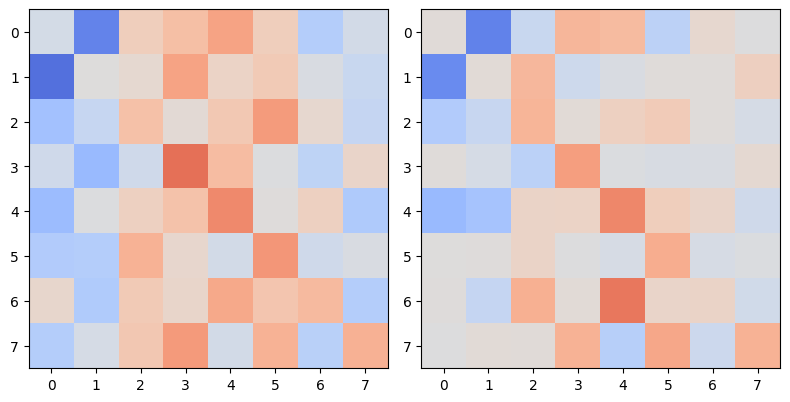

cosine_similarity measure: 0.784
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8162  1.6630
      2        0.7332  1.6593
      3        0.6630  1.6913
      4        0.6019  1.6971
      5        0.5480  1.6233
      6        0.5005  1.5478
      7        0.4621  1.5372
      8        0.4385  1.6064
      9        0.4303  1.6207
     10        0.4197  1.6511
     11        0.4000  1.5796
     12        0.3825  1.6807
     13        0.3725  1.6484
     14        0.3674  1.6600
     15        0.3633  1.6733
     16        0.3577  1.6327
     17        0.3501  1.6537
     18        0.3423  1.6743
     19        0.3369  1.5557
     20        0.3353  1.6470
     21        0.3314  1.6544
     22        0.3245  1.6171
     23        0.3203  1.5780
     24        0.3192  1.7068
     25        0.3181  1.6825
     26        0.3155  1.6427
     27        0.3117  1.6498
     28        0.3084  1.6650
     29        0.3066  1.6385
     30        0.3

    230        0.1003  1.6342
    231        0.1038  1.6440
    232        0.0932  1.6730
    233        0.1024  1.6757
    234        0.0954  1.6185
    235        0.0965  1.5934
    236        0.0960  1.5887
    237        0.0975  1.6812
    238        0.1178  1.6245
    239        0.1062  1.6171
    240        0.1038  1.5999
    241        0.0899  1.5669
    242        0.1085  1.6424
    243        0.0920  1.5344
    244        0.0982  1.6006
    245        0.0977  1.6368
    246        0.0891  1.5870
    247        0.0972  1.6051
    248        0.0874  1.5746
    249        0.0967  1.6725
    250        0.0927  1.5942
    251        0.0900  1.6097
    252        0.0867  1.6538
    253        0.0937  1.6699
    254        0.0854  1.6396
    255        0.0855  1.6293
    256        0.0852  1.6350
    257        0.0863  1.6221
    258        0.0905  1.6375
    259        0.0941  1.6541
    260        0.0964  1.6457
    261        0.0854  1.5953
    262        0.0875  1.6579
    263   

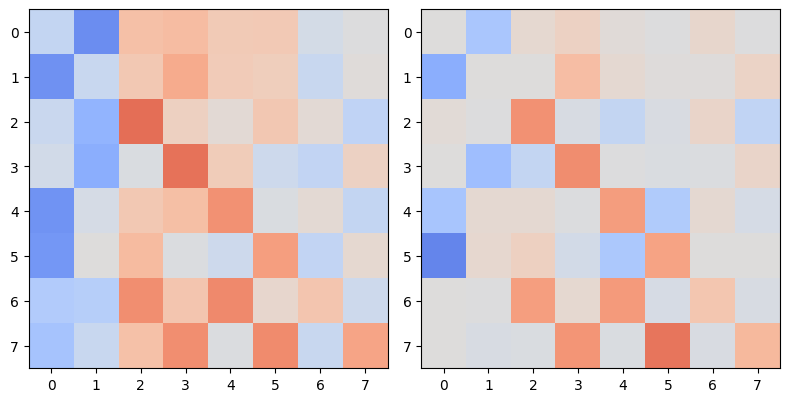

cosine_similarity measure: 0.845
MSE output:
2.2071587077872518e-05
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7600  1.8348
      2        0.6979  1.5814
      3        0.6435  1.7345
      4        0.5961  1.4858
      5        0.5557  1.5913
      6        0.5217  1.6014
      7        0.4934  1.5801
      8        0.4671  1.5087
      9        0.4379  1.6017
     10        0.4080  1.5729
     11        0.3817  1.6415
     12        0.3611  1.6429
     13        0.3469  1.5589
     14        0.3380  1.5465
     15        0.3330  1.5514
     16        0.3279  1.5327
     17        0.3231  1.5878
     18        0.3187  1.5461
     19        0.3140  1.6150
     20        0.3103  1.5667
     21        0.3063  1.5697
     22        0.3018  1.6350
     23        0.2977  1.5813
     24        0.2932  1.6242
     25        0.2887  1.5906
     26        0.2843  1.5185
     27        0.2804  1.6055
     28        0.2769  1.6322
     29      

    239        0.1089  1.5738
    240        0.0992  1.5901
    241        0.1081  1.5201
    242        0.0982  1.5627
    243        0.0991  1.5583
    244        0.1018  1.5789
    245        0.0922  1.6665
    246        0.0966  1.5214
    247        0.1013  1.5683
    248        0.0970  1.6825
    249        0.0949  1.5603
    250        0.0930  1.6212
    251        0.1026  1.6030
    252        0.1044  1.5451
    253        0.0928  1.5722
    254        0.0956  1.6055
    255        0.0955  1.5379
    256        0.0964  1.5269
    257        0.0924  1.5661
    258        0.0908  1.5412
    259        0.0893  1.5632
    260        0.0941  1.5922
    261        0.0943  1.5494
    262        0.1084  1.5385
    263        0.1151  1.5711
    264        0.1026  1.5783
    265        0.0908  1.5712
    266        0.1060  1.5634
    267        0.0972  1.6068
    268        0.0965  1.5581
    269        0.1044  1.6019
    270        0.0919  1.5381
    271        0.1011  1.5498
    272   

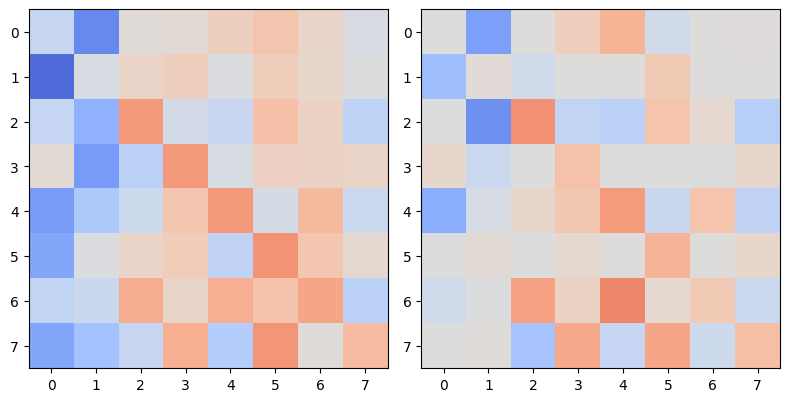

cosine_similarity measure: 0.796
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7383  1.5574
      2        0.6695  1.5429
      3        0.6072  1.5279
      4        0.5515  1.5416
      5        0.5034  1.6339
      6        0.4648  1.5555
      7        0.4401  1.5658
      8        0.4211  1.5386
      9        0.3980  1.5276
     10        0.3748  1.4877
     11        0.3574  1.6223
     12        0.3468  1.5621
     13        0.3397  1.5621
     14        0.3344  1.5446
     15        0.3307  1.5266
     16        0.3273  1.5463
     17        0.3222  1.5775
     18        0.3156  1.6140
     19        0.3084  1.6505
     20        0.3025  1.5480
     21        0.2976  1.6431
     22        0.2930  1.5565
     23        0.2887  1.4831
     24        0.2839  1.6385
     25        0.2793  1.5290
     26        0.2751  1.6525
     27        0.2714  1.6303
     28        0.2680  1.6011
     29        0.2647  1.5248
     30        0.2

    240        0.1382  1.5570
    241        0.1163  1.5891
    242        0.1297  1.5018
    243        0.1250  1.5959
    244        0.1255  1.5361
    245        0.1245  1.6434
    246        0.1135  1.5290
    247        0.1245  1.5730
    248        0.1119  1.6260
    249        0.1103  1.5053
    250        0.1167  1.5846
    251        0.1036  1.5846
    252        0.1109  1.6361
    253        0.0989  1.5019
    254        0.1076  1.5859
    255        0.0967  1.4966
    256        0.1123  1.6619
    257        0.1202  1.5848
    258        0.0949  1.4676
    259        0.1348  1.5777
    260        0.0982  1.5385
    261        0.1230  1.6342
    262        0.0991  1.6086
    263        0.1186  1.6200
    264        0.0980  1.5777
    265        0.1093  1.5229
    266        0.0977  1.6063
    267        0.1045  1.6607
    268        0.1040  1.6225
    269        0.0961  1.6390
    270        0.1061  1.5823
    271        0.1041  1.5317
    272        0.1009  1.5223
    273   

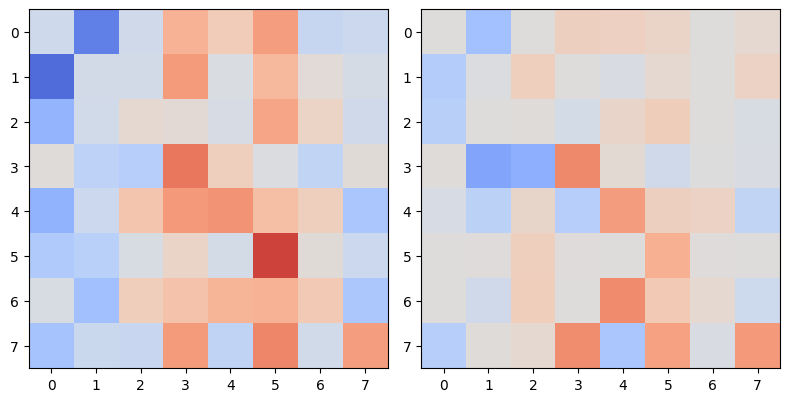

cosine_similarity measure: 0.723
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6536  1.5784
      2        0.5846  1.5538
      3        0.5253  1.5160
      4        0.4733  1.5647
      5        0.4282  1.6083
      6        0.3969  1.6492
      7        0.3936  1.6274
      8        0.3854  1.5172
      9        0.3610  1.6677
     10        0.3437  1.7427
     11        0.3366  1.5950
     12        0.3329  1.6067
     13        0.3285  1.5413
     14        0.3224  1.5994
     15        0.3155  1.5206
     16        0.3106  1.5687
     17        0.3091  1.6923
     18        0.3063  1.5832
     19        0.2983  1.5754
     20        0.2913  1.5429
     21        0.2881  1.5549
     22        0.2863  1.4619
     23        0.2839  1.5752
     24        0.2804  1.5901
     25        0.2769  1.5699
     26        0.2743  1.5848
     27        0.2729  1.6482
     28        0.2704  1.6454
     29        0.2672  1.5266
     30        0.2

    240        0.0842  1.5882
    241        0.0818  1.5953
    242        0.0831  1.5343
    243        0.0890  1.5393
    244        0.0839  1.5347
    245        0.0880  1.6492
    246        0.0801  1.5203
    247        0.0856  1.5869
    248        0.0829  1.6065
    249        0.0837  1.5255
    250        0.0858  1.6094
    251        0.0807  1.5597
    252        0.0862  1.5767
    253        0.0842  1.5102
    254        0.0848  1.6010
    255        0.0794  1.4928
    256        0.0886  1.5245
    257        0.0834  1.5341
    258        0.0805  1.5697
    259        0.0917  1.5154
    260        0.0823  1.6387
    261        0.0856  1.6170
    262        0.0859  1.4713
    263        0.0821  1.5524
    264        0.0866  1.6251
    265        0.0828  1.5289
    266        0.0821  1.5679
    267        0.0833  1.5997
    268        0.0803  1.6064
    269        0.0835  1.5900
    270        0.0855  1.5976
    271        0.0808  1.5755
    272        0.0881  1.6663
    273   

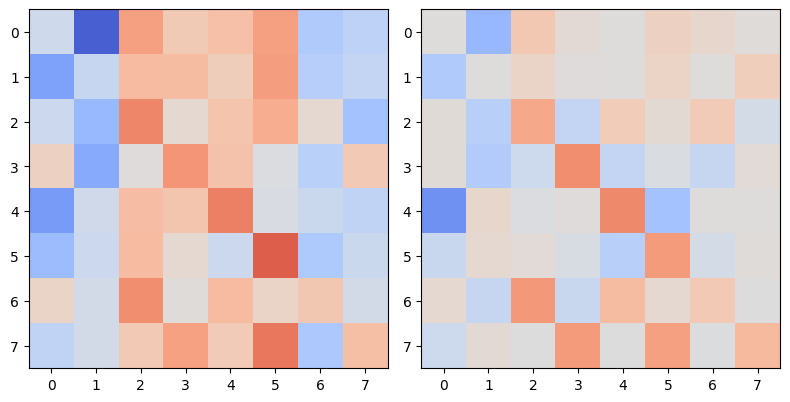

cosine_similarity measure: 0.784
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7397  1.6365
      2        0.6682  1.5570
      3        0.6044  1.5133
      4        0.5466  1.5325
      5        0.4966  1.5519
      6        0.4603  1.5943
      7        0.4429  1.7158
      8        0.4283  1.5929
      9        0.4032  1.5918
     10        0.3835  1.6397
     11        0.3742  1.7188
     12        0.3704  1.5911
     13        0.3670  1.5422
     14        0.3626  1.5642
     15        0.3586  1.5504
     16        0.3556  1.6085
     17        0.3508  1.6245
     18        0.3414  1.5368
     19        0.3327  1.6639
     20        0.3263  1.5674
     21        0.3213  1.5756
     22        0.3158  1.6318
     23        0.3104  1.6429
     24        0.3062  1.6198
     25        0.3027  1.6004
     26        0.2986  1.6684
     27        0.2943  1.5999
     28        0.2913  1.5983
     29        0.2888  1.5814
     30        0.2

    238        0.1379  1.5767
    239        0.1481  1.5666
    240        0.1338  1.6544
    241        0.1448  1.7146
    242        0.1299  1.5917
    243        0.1460  1.5356
    244        0.1524  1.5239
    245        0.1273  1.6235
    246        0.1344  1.5112
    247        0.1307  1.6051
    248        0.1325  1.5939
    249        0.1358  1.5145
    250        0.1253  1.5368
    251        0.1339  1.5096
    252        0.1357  1.6057
    253        0.1298  1.5826
    254        0.1268  1.6273
    255        0.1289  1.6626
    256        0.1264  1.6391
    257        0.1279  1.6825
    258        0.1247  1.6367
    259        0.1234  1.7044
    260        0.1225  1.6254
    261        0.1232  1.6108
    262        0.1314  1.5338
    263        0.1481  1.5366
    264        0.1574  1.6042
    265        0.1280  1.6188
    266        0.1491  1.6364
    267        0.1428  1.5552
    268        0.1399  1.6339
    269        0.1412  1.6125
    270        0.1392  1.6313
    271   

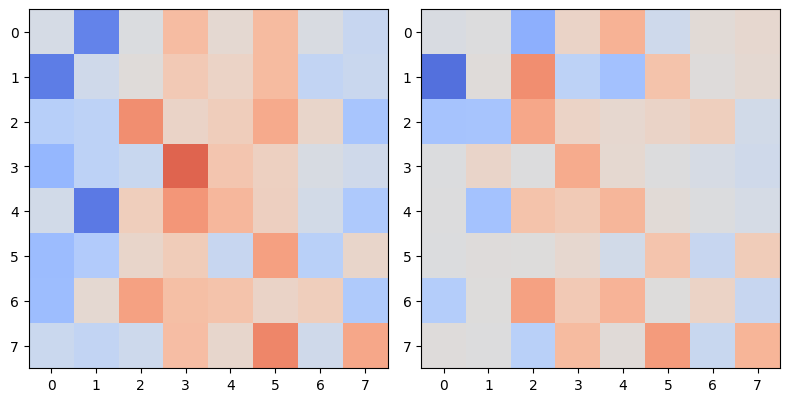

cosine_similarity measure: 0.677
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8213  1.5877
      2        0.7390  1.6094
      3        0.6652  1.5728
      4        0.6011  1.5471
      5        0.5474  1.5447
      6        0.5035  1.5445
      7        0.4709  1.6363
      8        0.4510  1.5504
      9        0.4387  1.6721
     10        0.4234  1.5847
     11        0.4034  1.5988
     12        0.3855  1.6482
     13        0.3729  1.5581
     14        0.3647  1.6023
     15        0.3583  1.5801
     16        0.3510  1.6752
     17        0.3442  1.6164
     18        0.3389  1.5803
     19        0.3341  1.5930
     20        0.3258  1.5159
     21        0.3171  1.5744
     22        0.3105  1.6931
     23        0.3058  1.6684
     24        0.3019  1.6083
     25        0.2988  1.7136
     26        0.2975  1.6177
     27        0.2957  1.6407
     28        0.2932  1.6556
     29        0.2906  1.5545
     30        0.2

    233        0.0860  1.5779
    234        0.0903  1.5936
    235        0.0936  1.5653
    236        0.0955  1.5634
    237        0.0906  1.5220
    238        0.0841  1.5863
    239        0.0897  1.5449
    240        0.0838  1.5917
    241        0.0856  1.5133
    242        0.0868  1.5772
    243        0.0844  1.5394
    244        0.0854  1.5775
    245        0.0824  1.6022
    246        0.0813  1.5523
    247        0.0831  1.5586
    248        0.0853  1.5222
    249        0.0835  1.6248
    250        0.0926  1.6698
    251        0.0817  1.5775
    252        0.0862  1.6319
    253        0.0878  1.5472
    254        0.0848  1.5223
    255        0.0954  1.6258
    256        0.0914  1.5521
    257        0.0915  1.6075
    258        0.0806  1.5027
    259        0.0862  1.6943
    260        0.0931  1.5666
    261        0.0815  1.5754
    262        0.0867  1.6157
    263        0.0866  1.5733
    264        0.0851  1.6355
    265        0.0824  1.6258
    266   

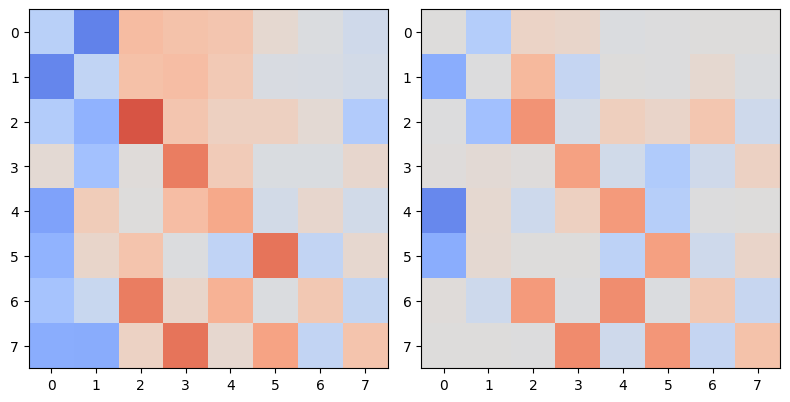

cosine_similarity measure: 0.797
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8396  1.5530
      2        0.7583  1.5171
      3        0.6847  1.6723
      4        0.6179  1.6161
      5        0.5586  1.4961
      6        0.5087  1.5469
      7        0.4713  1.6381
      8        0.4508  1.5615
      9        0.4414  1.5117
     10        0.4229  1.5203
     11        0.4014  1.5821
     12        0.3873  1.5338
     13        0.3796  1.6133
     14        0.3739  1.6239
     15        0.3675  1.5876
     16        0.3591  1.6072
     17        0.3516  1.5262
     18        0.3468  1.5959
     19        0.3459  1.6424
     20        0.3419  1.5544
     21        0.3362  1.5843
     22        0.3327  1.5421
     23        0.3307  1.5716
     24        0.3279  1.5396
     25        0.3231  1.5282
     26        0.3185  1.6301
     27        0.3152  1.5927
     28        0.3120  1.5758
     29        0.3075  1.6353
     30        0.3

    236        0.0939  1.5461
    237        0.0961  1.5485
    238        0.1023  1.5562
    239        0.1051  1.4792
    240        0.0973  1.5119
    241        0.0959  1.5288
    242        0.1010  1.5780
    243        0.0950  1.6266
    244        0.0962  1.5163
    245        0.1011  1.6634
    246        0.0988  1.4735
    247        0.0935  1.5127
    248        0.0930  1.6480
    249        0.0944  1.5752
    250        0.0963  1.5684
    251        0.1010  1.6242
    252        0.1033  1.5541
    253        0.0958  1.6282
    254        0.0946  1.5662
    255        0.0990  1.4854
    256        0.1008  1.5845
    257        0.0941  1.6447
    258        0.0960  1.5136
    259        0.1068  1.6649
    260        0.1013  1.7109
    261        0.0928  1.6539
    262        0.0958  1.5442
    263        0.1061  1.6034
    264        0.0930  1.6117
    265        0.0960  1.5647
    266        0.0953  1.5407
    267        0.0970  1.5764
    268        0.0973  1.5695
    269   

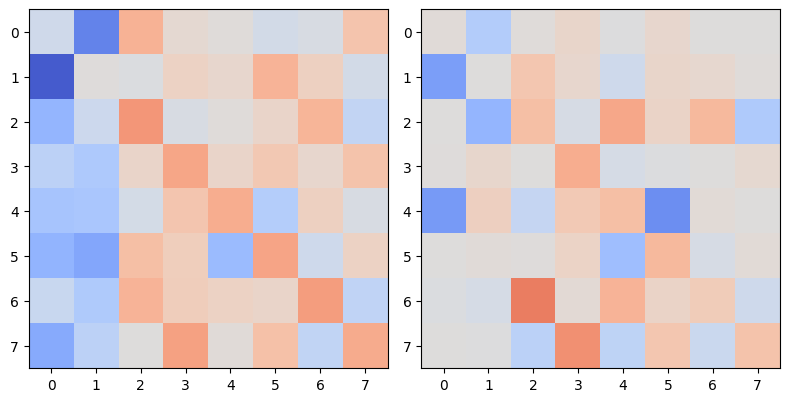

cosine_similarity measure: 0.646
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7739  1.5797
      2        0.6970  1.6670
      3        0.6292  1.5565
      4        0.5719  1.6470
      5        0.5225  1.5493
      6        0.4803  1.6044
      7        0.4506  1.6136
      8        0.4378  1.5344
      9        0.4305  1.6648
     10        0.4130  1.4929
     11        0.3926  1.6163
     12        0.3786  1.5367
     13        0.3701  1.4918
     14        0.3645  1.5449
     15        0.3592  1.5360
     16        0.3525  1.5675
     17        0.3447  1.6299
     18        0.3373  1.5581
     19        0.3327  1.5900
     20        0.3314  1.5344
     21        0.3267  1.6382
     22        0.3180  1.4855
     23        0.3113  1.5850
     24        0.3070  1.5339
     25        0.3030  1.6099
     26        0.2989  1.6153
     27        0.2946  1.6106
     28        0.2917  1.6158
     29        0.2903  1.5893
     30        0.2

    238        0.0836  1.6093
    239        0.0871  1.5441
    240        0.0805  1.6400
    241        0.0838  1.4756
    242        0.0854  1.6227
    243        0.0839  1.6064
    244        0.0849  1.5989
    245        0.0803  1.6727
    246        0.0825  1.6025
    247        0.0827  1.5603
    248        0.0815  1.5960
    249        0.0851  1.5174
    250        0.0832  1.6674
    251        0.0869  1.6568
    252        0.0815  1.5341
    253        0.0801  1.6068
    254        0.0800  1.5979
    255        0.0792  1.5591
    256        0.0861  1.5582
    257        0.0854  1.5635
    258        0.0820  1.6553
    259        0.0778  1.6803
    260        0.0795  1.5125
    261        0.0807  1.5860
    262        0.0790  1.7329
    263        0.0806  1.6116
    264        0.0814  1.6184
    265        0.0807  1.5929
    266        0.0828  1.5267
    267        0.0859  1.6624
    268        0.0916  1.5560
    269        0.0808  1.5429
    270        0.0775  1.5889
    271   

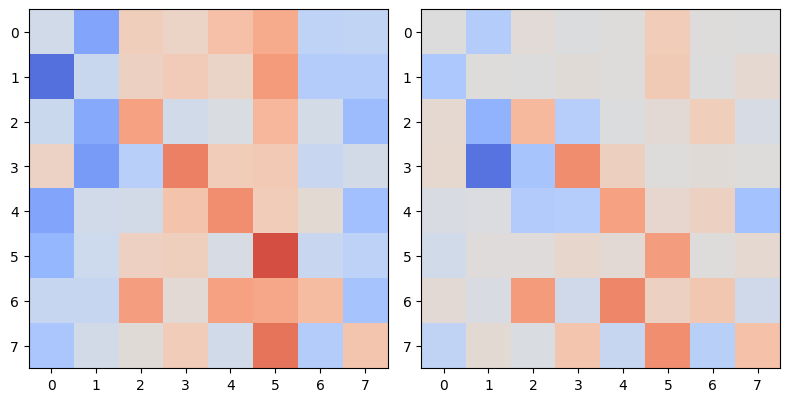

cosine_similarity measure: 0.782
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6682  1.5543
      2        0.5937  1.6114
      3        0.5280  1.7495
      4        0.4708  1.6105
      5        0.4236  1.6002
      6        0.3957  1.5814
      7        0.3925  1.5603
      8        0.3797  1.6656
      9        0.3577  1.5290
     10        0.3464  1.5861
     11        0.3437  1.6951
     12        0.3423  1.5806
     13        0.3382  1.5766
     14        0.3305  1.6226
     15        0.3213  1.6130
     16        0.3145  1.5855
     17        0.3123  1.5292
     18        0.3096  1.6660
     19        0.3018  1.5653
     20        0.2952  1.6125
     21        0.2920  1.5550
     22        0.2897  1.5075
     23        0.2863  1.5657
     24        0.2816  1.6160
     25        0.2767  1.6019
     26        0.2736  1.6494
     27        0.2726  1.6397
     28        0.2705  1.5338
     29        0.2669  1.5744
     30        0.2

    234        0.1314  1.6544
    235        0.1321  1.6190
    236        0.1473  1.6407
    237        0.1252  1.6430
    238        0.1275  1.5523
    239        0.1367  1.6529
    240        0.1211  1.5917
    241        0.1337  1.6555
    242        0.1185  1.5608
    243        0.1305  1.5896
    244        0.1290  1.5613
    245        0.1717  1.7009
    246        0.1421  1.5843
    247        0.1252  1.5880
    248        0.1286  1.5768
    249        0.1302  1.5894
    250        0.1271  1.5293
    251        0.1277  1.6051
    252        0.1267  1.5133
    253        0.1252  1.5796
    254        0.1195  1.5491
    255        0.1271  1.6990
    256        0.1491  1.6712
    257        0.1564  1.6073
    258        0.1478  1.6274
    259        0.1371  1.5916
    260        0.1476  1.5565
    261        0.1469  1.6325
    262        0.1399  1.5267
    263        0.1486  1.5733
    264        0.1346  1.5884
    265        0.1348  1.5840
    266        0.1340  1.6553
    267   

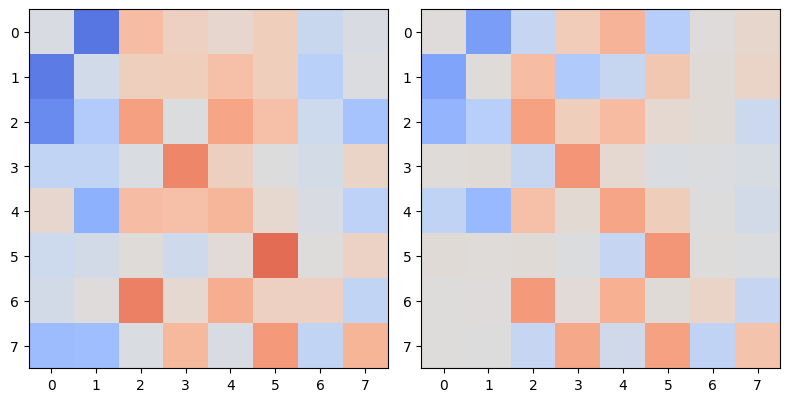

cosine_similarity measure: 0.789
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8085  1.5893
      2        0.7238  1.5233
      3        0.6500  1.5940
      4        0.5872  1.6286
      5        0.5352  1.7241
      6        0.4921  1.6006
      7        0.4603  1.5451
      8        0.4441  1.6431
      9        0.4363  1.6395
     10        0.4194  1.6241
     11        0.3980  1.6419
     12        0.3814  1.6058
     13        0.3711  1.6054
     14        0.3641  1.6127
     15        0.3569  1.5852
     16        0.3484  1.5672
     17        0.3392  1.6104
     18        0.3312  1.5489
     19        0.3262  1.6027
     20        0.3225  1.5929
     21        0.3170  1.6281
     22        0.3110  1.6102
     23        0.3081  1.6023
     24        0.3062  1.6008
     25        0.3033  1.5757
     26        0.2985  1.5769
     27        0.2935  1.6553
     28        0.2898  1.5440
     29        0.2868  1.6150
     30        0.2

    238        0.0924  1.5485
    239        0.0843  1.5857
    240        0.0867  1.5434
    241        0.0877  1.5356
    242        0.0843  1.5629
    243        0.0878  1.5532
    244        0.0895  1.5697
    245        0.0820  1.6219
    246        0.0868  1.5438
    247        0.0863  1.5001
    248        0.0834  1.6528
    249        0.0868  1.4670
    250        0.0851  1.5473
    251        0.0871  1.5753
    252        0.0812  1.5967
    253        0.0875  1.5950
    254        0.0862  1.5687
    255        0.0823  1.5297
    256        0.0876  1.5548
    257        0.0811  1.5938
    258        0.0842  1.5776
    259        0.0849  1.5439
    260        0.0811  1.5639
    261        0.0823  1.5919
    262        0.0832  1.4971
    263        0.0819  1.5896
    264        0.0813  1.5352
    265        0.0844  1.5477
    266        0.0813  1.5631
    267        0.0821  1.6052
    268        0.0851  1.6400
    269        0.0814  1.5527
    270        0.0830  1.6702
    271   

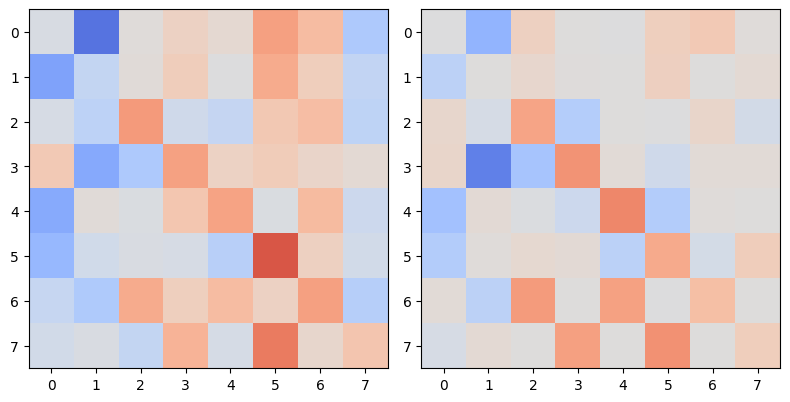

cosine_similarity measure: 0.808
MSE output:
3.052092419603013e-05
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7879  1.8886
      2        0.7138  1.5903
      3        0.6411  1.6265
      4        0.5709  1.4989
      5        0.5081  1.5446
      6        0.4586  1.5051
      7        0.4320  1.4550
      8        0.4345  1.4761
      9        0.4275  1.5586
     10        0.4061  1.5282
     11        0.3908  1.5232
     12        0.3836  1.5059
     13        0.3801  1.5961
     14        0.3761  1.6527
     15        0.3692  1.5423
     16        0.3606  1.4983
     17        0.3508  1.5229
     18        0.3422  1.5321
     19        0.3375  1.5113
     20        0.3349  1.5496
     21        0.3277  1.6312
     22        0.3174  1.5391
     23        0.3091  1.5847
     24        0.3043  1.4699
     25        0.3010  1.5125
     26        0.2978  1.5664
     27        0.2942  1.4599
     28        0.2911  1.6081
     29       

    233        0.1538  1.4902
    234        0.1666  1.4401
    235        0.1273  1.9743
    236        0.1371  1.5913
    237        0.1409  1.5191
    238        0.1343  1.4854
    239        0.1399  1.5817
    240        0.1360  1.5216
    241        0.1341  1.5526
    242        0.1299  1.6454
    243        0.1347  1.4859
    244        0.1307  1.4768
    245        0.1213  1.5238
    246        0.1352  1.6725
    247        0.1453  1.6331
    248        0.1373  1.5447
    249        0.1237  1.5522
    250        0.1453  1.4575
    251        0.1229  1.4592
    252        0.1347  1.4854
    253        0.1276  1.5690
    254        0.1208  1.4696
    255        0.1243  1.5277
    256        0.1365  1.5169
    257        0.1389  1.4706
    258        0.1354  1.5422
    259        0.1191  1.5617
    260        0.1255  1.4673
    261        0.1262  1.5310
    262        0.1216  1.5599
    263        0.1209  1.5019
    264        0.1255  1.4959
    265        0.1257  1.5797
    266   

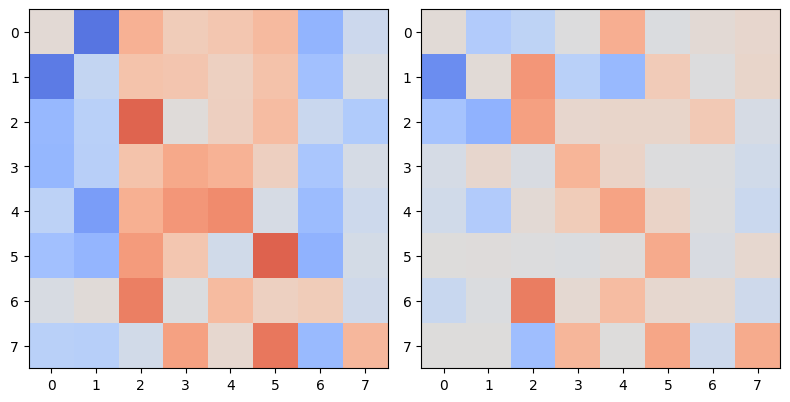

cosine_similarity measure: 0.65
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6211  1.6326
      2        0.5591  1.4798
      3        0.5031  1.5156
      4        0.4535  1.5450
      5        0.4157  1.6096
      6        0.4096  1.6070
      7        0.3970  1.5639
      8        0.3693  1.5396
      9        0.3521  1.6474
     10        0.3442  1.5683
     11        0.3383  1.5459
     12        0.3299  1.6079
     13        0.3199  1.5010
     14        0.3126  1.5120
     15        0.3119  1.5742
     16        0.3124  1.6547
     17        0.3060  1.5699
     18        0.3000  1.5617
     19        0.2975  1.5577
     20        0.2959  1.5734
     21        0.2928  1.5497
     22        0.2880  1.5070
     23        0.2829  1.5303
     24        0.2797  1.5759
     25        0.2780  1.5187
     26        0.2755  1.6011
     27        0.2716  1.5647
     28        0.2688  1.5643
     29        0.2673  1.5853
     30        0.26

    234        0.0803  1.5748
    235        0.0896  1.5342
    236        0.0957  1.5356
    237        0.0875  1.5228
    238        0.0802  1.5627
    239        0.0832  1.5729
    240        0.0829  1.5782
    241        0.0799  1.6191
    242        0.0850  1.6554
    243        0.0908  1.5704
    244        0.0773  1.6644
    245        0.0856  1.5205
    246        0.0899  1.5191
    247        0.0956  1.5278
    248        0.0887  1.6280
    249        0.0815  1.5153
    250        0.0849  1.5532
    251        0.0802  1.5228
    252        0.0830  1.5384
    253        0.0793  1.5182
    254        0.0875  1.5738
    255        0.0841  1.5485
    256        0.0834  1.5594
    257        0.0798  1.4806
    258        0.0771  1.5388
    259        0.0787  1.5159
    260        0.0775  1.5215
    261        0.0805  1.4934
    262        0.0817  1.5524
    263        0.0776  1.5143
    264        0.0765  1.6164
    265        0.0778  1.5334
    266        0.0770  1.5683
    267   

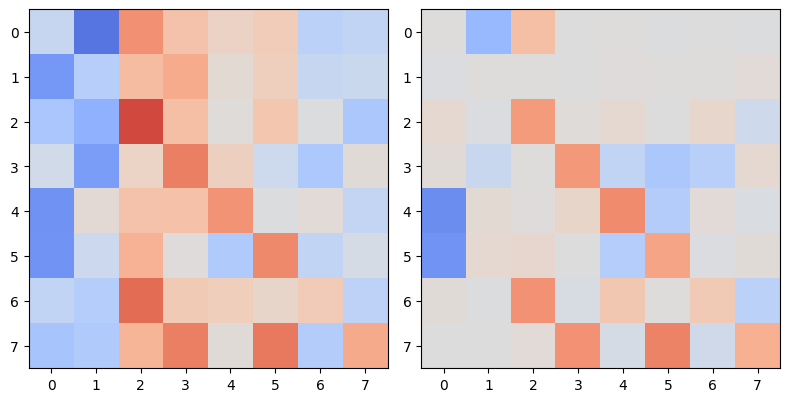

cosine_similarity measure: 0.783
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6173  1.5757
      2        0.5577  1.5165
      3        0.5004  1.5435
      4        0.4448  1.5868
      5        0.3977  1.6273
      6        0.3816  1.7080
      7        0.3820  1.5556
      8        0.3564  1.6224
      9        0.3394  1.5474
     10        0.3357  1.5232
     11        0.3343  1.5756
     12        0.3297  1.5969
     13        0.3217  1.6144
     14        0.3125  1.5399
     15        0.3075  1.5714
     16        0.3071  1.5168
     17        0.3024  1.5228
     18        0.2933  1.6136
     19        0.2873  1.5752
     20        0.2849  1.5254
     21        0.2826  1.5728
     22        0.2791  1.5656
     23        0.2747  1.5213
     24        0.2705  1.5667
     25        0.2683  1.5516
     26        0.2672  1.5108
     27        0.2646  1.5196
     28        0.2613  1.6394
     29        0.2592  1.5029
     30        0.2

    234        0.1561  1.5920
    235        0.1346  1.5732
    236        0.1414  1.5371
    237        0.1365  1.5911
    238        0.1247  1.4773
    239        0.1387  1.5343
    240        0.1273  1.4928
    241        0.1268  1.5344
    242        0.1388  1.6263
    243        0.1202  1.4644
    244        0.1291  1.5084
    245        0.1273  1.5724
    246        0.1216  1.5156
    247        0.1228  1.5676
    248        0.1167  1.4871
    249        0.1189  1.6250
    250        0.1308  1.5053
    251        0.1423  1.4888
    252        0.1147  1.6137
    253        0.1326  1.5555
    254        0.1191  1.5219
    255        0.1284  1.5867
    256        0.1127  1.5854
    257        0.1258  1.5198
    258        0.1103  1.5711
    259        0.1210  1.5154
    260        0.1219  1.4901
    261        0.1176  1.4671
    262        0.1071  1.6255
    263        0.1195  1.5137
    264        0.1068  1.6106
    265        0.1152  1.4907
    266        0.1042  1.5627
    267   

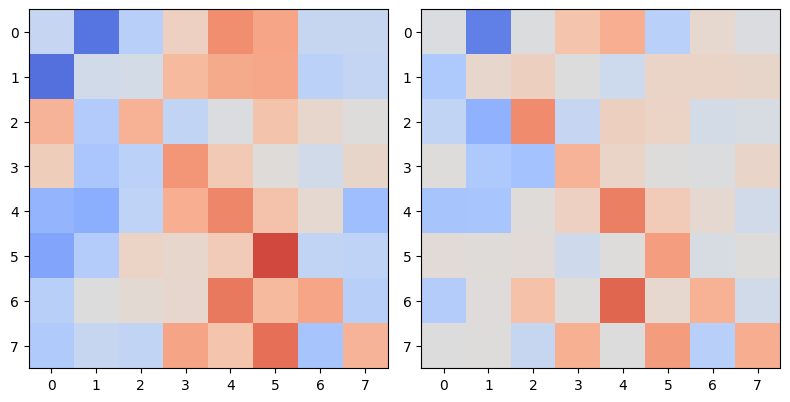

cosine_similarity measure: 0.743
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6486  1.5917
      2        0.5842  1.4735
      3        0.5270  1.5178
      4        0.4746  1.6662
      5        0.4298  1.5626
      6        0.4049  1.4917
      7        0.3997  1.5454
      8        0.3760  1.4674
      9        0.3535  1.5288
     10        0.3439  1.5473
     11        0.3401  1.5903
     12        0.3363  1.5771
     13        0.3294  1.6043
     14        0.3214  1.5874
     15        0.3157  1.6339
     16        0.3142  1.5697
     17        0.3110  1.5741
     18        0.3039  1.4963
     19        0.2968  1.4996
     20        0.2930  1.5055
     21        0.2895  1.5672
     22        0.2852  1.5547
     23        0.2795  1.5965
     24        0.2749  1.5048
     25        0.2723  1.5801
     26        0.2702  1.5179
     27        0.2672  1.5599
     28        0.2637  1.5416
     29        0.2616  1.5841
     30        0.2

    236        0.1030  1.6236
    237        0.0970  1.5260
    238        0.1021  1.4647
    239        0.0954  1.5118
    240        0.0988  1.4879
    241        0.1039  1.6270
    242        0.0934  1.5673
    243        0.1011  1.5655
    244        0.0979  1.4904
    245        0.0924  1.5613
    246        0.1004  1.4961
    247        0.0998  1.5145
    248        0.0973  1.6031
    249        0.0951  1.6314
    250        0.0932  1.6067
    251        0.0950  1.5737
    252        0.0953  1.5918
    253        0.0929  1.6087
    254        0.0939  1.5211
    255        0.0997  1.6352
    256        0.1097  1.4959
    257        0.0978  1.5594
    258        0.0912  1.6087
    259        0.0940  1.5478
    260        0.0942  1.6025
    261        0.0923  1.5244
    262        0.0909  1.4766
    263        0.0922  1.5336
    264        0.0926  1.5093
    265        0.0911  1.4919
    266        0.0919  1.6132
    267        0.0973  1.5358
    268        0.1065  1.5249
    269   

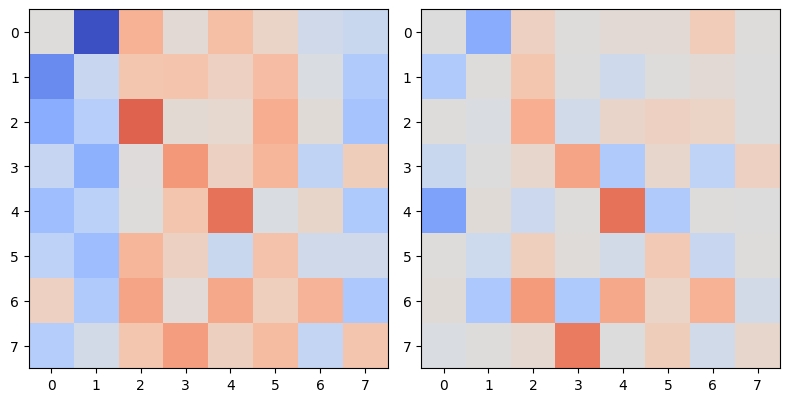

cosine_similarity measure: 0.736
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6691  1.5160
      2        0.5967  1.5377
      3        0.5362  1.6992
      4        0.4829  1.5228
      5        0.4349  1.5807
      6        0.3964  1.5589
      7        0.3814  1.5175
      8        0.3749  1.6282
      9        0.3520  1.4971
     10        0.3317  1.5846
     11        0.3239  1.5639
     12        0.3218  1.5467
     13        0.3192  1.5459
     14        0.3138  1.4811
     15        0.3061  1.5186
     16        0.2995  1.4890
     17        0.2960  1.5087
     18        0.2916  1.5755
     19        0.2839  1.5913
     20        0.2779  1.5418
     21        0.2748  1.5133
     22        0.2728  1.5621
     23        0.2699  1.6432
     24        0.2661  1.5564
     25        0.2632  1.6225
     26        0.2616  1.5779
     27        0.2604  1.5237
     28        0.2570  1.4770
     29        0.2538  1.5123
     30        0.2

    235        0.0742  1.4766
    236        0.0767  1.5574
    237        0.0810  1.5588
    238        0.0779  1.5359
    239        0.0771  1.5143
    240        0.0807  1.4605
    241        0.0758  1.5490
    242        0.0748  1.5624
    243        0.0789  1.5098
    244        0.0746  1.5701
    245        0.0761  1.5621
    246        0.0761  1.5750
    247        0.0733  1.4882
    248        0.0753  1.5783
    249        0.0754  1.4985
    250        0.0736  1.5843
    251        0.0755  1.5761
    252        0.0764  1.5249
    253        0.0742  1.5535
    254        0.0734  1.5653
    255        0.0727  1.5442
    256        0.0728  1.6489
    257        0.0782  1.6274
    258        0.0765  1.5406
    259        0.0727  1.6103
    260        0.0769  1.5813
    261        0.0757  1.5662
    262        0.0741  1.4894
    263        0.0774  1.5622
    264        0.0753  1.5528
    265        0.0739  1.6092
    266        0.0764  1.5258
    267        0.0752  1.5840
    268   

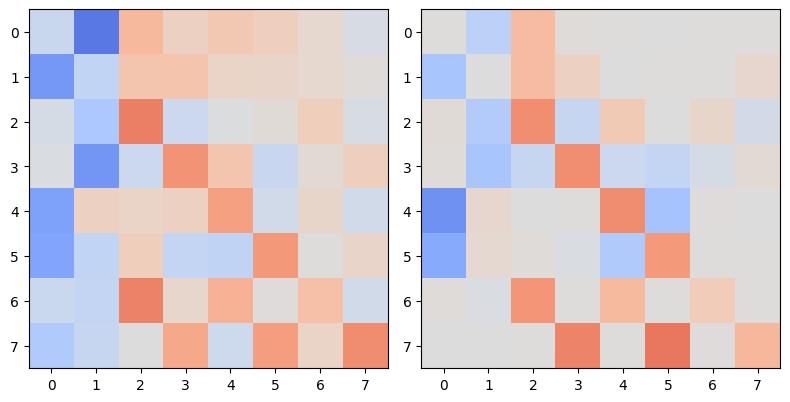

cosine_similarity measure: 0.856
MSE output:
1.3151062250883652e-05
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7487  1.8056
      2        0.6784  1.5733
      3        0.6131  1.5100
      4        0.5527  1.4789
      5        0.4971  1.5521
      6        0.4483  1.5638
      7        0.4122  1.6874
      8        0.3999  1.4756
      9        0.3995  1.6548
     10        0.3814  1.5243
     11        0.3621  1.5424
     12        0.3522  1.5088
     13        0.3477  1.5619
     14        0.3439  1.5255
     15        0.3376  1.4800
     16        0.3292  1.6083
     17        0.3195  1.5626
     18        0.3108  1.4994
     19        0.3058  1.6063
     20        0.3042  1.5143
     21        0.2993  1.5138
     22        0.2925  1.5514
     23        0.2896  1.5582
     24        0.2894  1.5173
     25        0.2882  1.5450
     26        0.2855  1.6085
     27        0.2822  1.5477
     28        0.2805  1.5227
     29      

    233        0.0866  1.5317
    234        0.0867  1.5727
    235        0.0912  1.5635
    236        0.0859  1.5940
    237        0.0911  1.5781
    238        0.0923  1.5756
    239        0.0894  1.6525
    240        0.0838  1.4908
    241        0.0895  1.5485
    242        0.0947  1.6201
    243        0.0821  1.5595
    244        0.0911  1.5947
    245        0.0908  1.5319
    246        0.0825  1.6088
    247        0.0960  1.5093
    248        0.0932  1.5966
    249        0.0860  1.5803
    250        0.0938  1.6315
    251        0.0890  1.5620
    252        0.0874  1.5644
    253        0.0882  1.5976
    254        0.0889  1.5349
    255        0.0824  1.5789
    256        0.0840  1.5391
    257        0.0844  1.5650
    258        0.0866  1.5078
    259        0.0874  1.5354
    260        0.0832  1.5097
    261        0.0844  1.5170
    262        0.0859  1.5249
    263        0.0794  1.5060
    264        0.0826  1.4900
    265        0.0823  1.6150
    266   

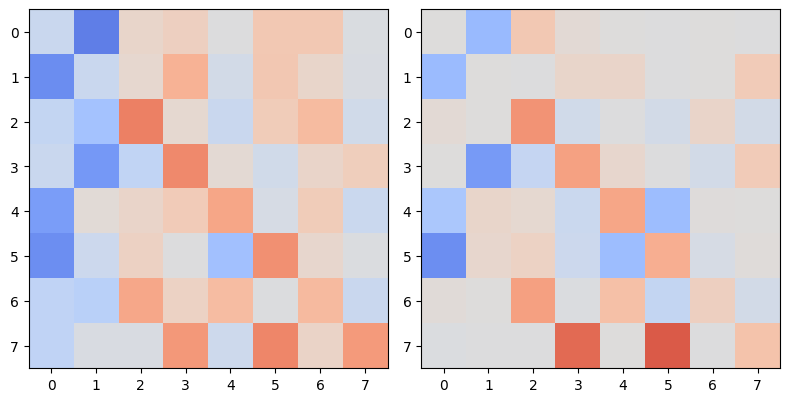

cosine_similarity measure: 0.834
MSE output:
3.0302435061862406e-09
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7601  1.7922
      2        0.6835  1.5720
      3        0.6116  1.6629
      4        0.5456  1.5490
      5        0.4860  1.5524
      6        0.4363  1.4665
      7        0.4029  1.4967
      8        0.3983  1.5309
      9        0.3975  1.5285
     10        0.3793  1.5348
     11        0.3626  1.5415
     12        0.3549  1.4998
     13        0.3524  1.4895
     14        0.3502  1.4782
     15        0.3456  1.6747
     16        0.3392  1.5617
     17        0.3308  1.5178
     18        0.3225  1.5514
     19        0.3158  1.6044
     20        0.3137  1.5011
     21        0.3131  1.5556
     22        0.3064  1.4884
     23        0.2988  1.5538
     24        0.2955  1.5416
     25        0.2945  1.5914
     26        0.2928  1.4907
     27        0.2896  1.4518
     28        0.2854  1.5726
     29      

    232        0.0851  1.5226
    233        0.0904  1.5883
    234        0.0912  1.5308
    235        0.0858  1.5922
    236        0.0929  1.6029
    237        0.0883  1.5896
    238        0.0893  1.4855
    239        0.0855  1.5548
    240        0.0854  1.5966
    241        0.0849  1.6067
    242        0.0851  1.5383
    243        0.0879  1.6081
    244        0.0858  1.5692
    245        0.0870  1.5544
    246        0.0852  1.5072
    247        0.0837  1.6125
    248        0.0857  1.5923
    249        0.0895  1.5420
    250        0.0850  1.5889
    251        0.0842  1.5792
    252        0.0835  1.4973
    253        0.0836  1.5065
    254        0.0856  1.5454
    255        0.0877  1.5669
    256        0.0872  1.5716
    257        0.0857  1.4967
    258        0.0861  1.5287
    259        0.0874  1.6726
    260        0.0852  1.5251
    261        0.0839  1.5108
    262        0.0863  1.6484
    263        0.0864  1.6213
    264        0.0840  1.5747
    265   

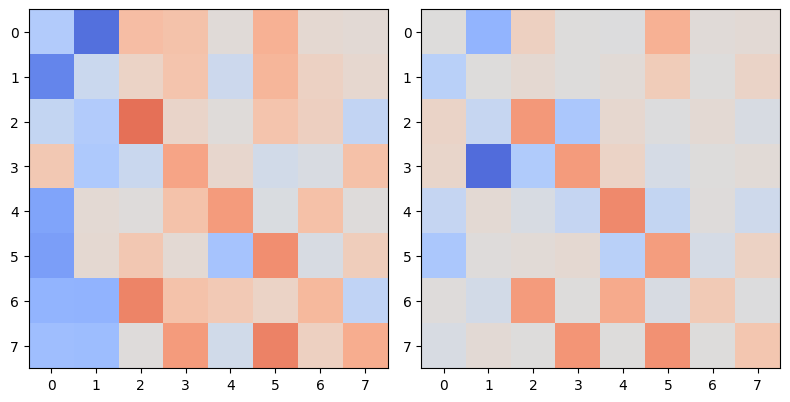

cosine_similarity measure: 0.74
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7680  1.5287
      2        0.6974  1.5151
      3        0.6328  1.5127
      4        0.5755  1.6320
      5        0.5276  1.5509
      6        0.4898  1.4939
      7        0.4639  1.5597
      8        0.4466  1.5541
      9        0.4245  1.5136
     10        0.3989  1.5996
     11        0.3765  1.6183
     12        0.3600  1.5466
     13        0.3476  1.4786
     14        0.3377  1.6154
     15        0.3316  1.5519
     16        0.3308  1.5370
     17        0.3289  1.5585
     18        0.3240  1.4950
     19        0.3202  1.5183
     20        0.3168  1.5372
     21        0.3121  1.5534
     22        0.3072  1.5279
     23        0.3029  1.5806
     24        0.2980  1.5938
     25        0.2923  1.5102
     26        0.2867  1.5295
     27        0.2819  1.5352
     28        0.2774  1.5481
     29        0.2735  1.5994
     30        0.27

    235        0.0942  1.6247
    236        0.0921  1.6224
    237        0.0950  1.5542
    238        0.0943  1.4994
    239        0.0918  1.6143
    240        0.0922  1.5532
    241        0.0892  1.5193
    242        0.0936  1.5862
    243        0.0986  1.6207
    244        0.0877  1.7106
    245        0.0974  1.6559
    246        0.0876  1.5066
    247        0.1028  1.6544
    248        0.0985  1.5074
    249        0.0955  1.6067
    250        0.0978  1.5124
    251        0.0987  1.6249
    252        0.0897  1.4783
    253        0.0885  1.5977
    254        0.0936  1.6000
    255        0.0899  1.6514
    256        0.0935  1.6695
    257        0.0891  1.6091
    258        0.0937  1.6056
    259        0.0945  1.4936
    260        0.0908  1.5745
    261        0.0962  1.5784
    262        0.0873  1.5923
    263        0.0980  1.6137
    264        0.0855  1.6292
    265        0.0936  1.5862
    266        0.0877  1.5169
    267        0.0878  1.6001
    268   

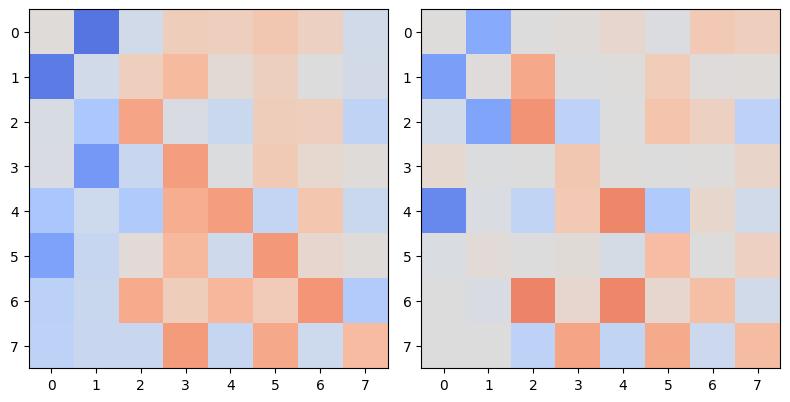

cosine_similarity measure: 0.778
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8225  1.5552
      2        0.7426  1.4804
      3        0.6676  1.4886
      4        0.6004  1.5208
      5        0.5421  1.6074
      6        0.4958  1.5466
      7        0.4667  1.5743
      8        0.4587  1.5876
      9        0.4501  1.5713
     10        0.4297  1.6056
     11        0.4105  1.6704
     12        0.3981  1.4940
     13        0.3904  1.5200
     14        0.3844  1.6251
     15        0.3778  1.6888
     16        0.3703  1.5505
     17        0.3625  1.5538
     18        0.3561  1.5851
     19        0.3533  1.5705
     20        0.3515  1.5240
     21        0.3451  1.6275
     22        0.3360  1.5466
     23        0.3291  1.6330
     24        0.3245  1.6262
     25        0.3205  1.5703
     26        0.3154  1.5336
     27        0.3102  1.5575
     28        0.3064  1.5954
     29        0.3044  1.6127
     30        0.3

    234        0.1375  1.5930
    235        0.1418  1.5717
    236        0.1264  1.5363
    237        0.1164  1.5672
    238        0.1229  1.5598
    239        0.1280  1.5165
    240        0.1231  1.5721
    241        0.1161  1.6032
    242        0.1137  1.6507
    243        0.1179  1.5775
    244        0.1374  1.5280
    245        0.1662  1.4870
    246        0.1186  1.6416
    247        0.1318  1.6263
    248        0.1347  1.5884
    249        0.1261  1.5880
    250        0.1331  1.6413
    251        0.1171  1.6287
    252        0.1276  1.5739
    253        0.1244  1.6686
    254        0.1167  1.5192
    255        0.1142  1.5285
    256        0.1150  1.6266
    257        0.1193  1.6696
    258        0.1251  1.6601
    259        0.1264  1.6066
    260        0.1234  1.6019
    261        0.1167  1.5899
    262        0.1132  1.6073
    263        0.1101  1.6481
    264        0.1144  1.6145
    265        0.1401  1.5143
    266        0.1504  1.6164
    267   

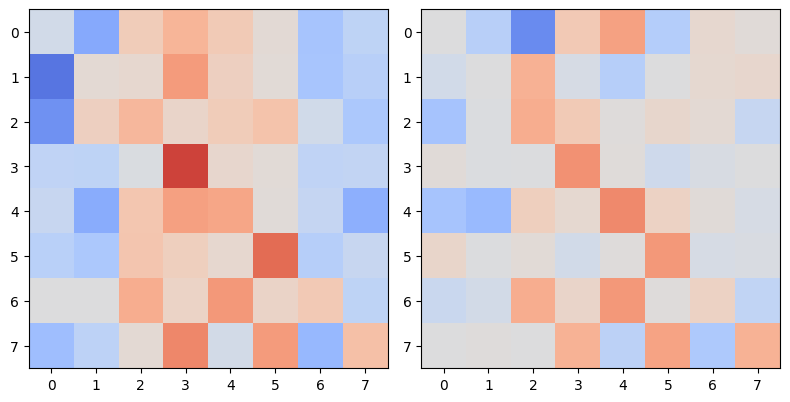

cosine_similarity measure: 0.618
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6916  1.5521
      2        0.6312  1.6028
      3        0.5728  1.5711
      4        0.5159  1.6484
      5        0.4628  1.5839
      6        0.4210  1.6179
      7        0.4049  1.6325
      8        0.3977  1.6250
      9        0.3792  1.6460
     10        0.3680  1.6402
     11        0.3645  1.5888
     12        0.3614  1.5208
     13        0.3542  1.5658
     14        0.3438  1.5363
     15        0.3321  1.5298
     16        0.3237  1.6361
     17        0.3208  1.6010
     18        0.3176  1.5406
     19        0.3110  1.6023
     20        0.3051  1.6001
     21        0.3015  1.5116
     22        0.2982  1.5911
     23        0.2943  1.6594
     24        0.2896  1.6105
     25        0.2859  1.5511
     26        0.2839  1.6151
     27        0.2819  1.5514
     28        0.2774  1.4872
     29        0.2736  1.6977
     30        0.2

    235        0.1338  1.5300
    236        0.1310  1.5656
    237        0.1269  1.6114
    238        0.1280  1.5337
    239        0.1349  1.5380
    240        0.1396  1.6084
    241        0.1579  1.5978
    242        0.1431  1.5868
    243        0.1259  1.5657
    244        0.1448  1.6045
    245        0.1306  1.5396
    246        0.1363  1.5525
    247        0.1357  1.5464
    248        0.1248  1.5239
    249        0.1352  1.5890
    250        0.1423  1.5418
    251        0.1436  1.5342
    252        0.1289  1.6221
    253        0.1282  1.4971
    254        0.1297  1.5870
    255        0.1290  1.5021
    256        0.1252  1.6600
    257        0.1276  1.6278
    258        0.1231  1.6072
    259        0.1267  1.5498
    260        0.1373  1.5168
    261        0.1808  1.5076
    262        0.1359  1.5231
    263        0.1413  1.5460
    264        0.1449  1.5885
    265        0.1457  1.6487
    266        0.1406  1.5043
    267        0.1458  1.4727
    268   

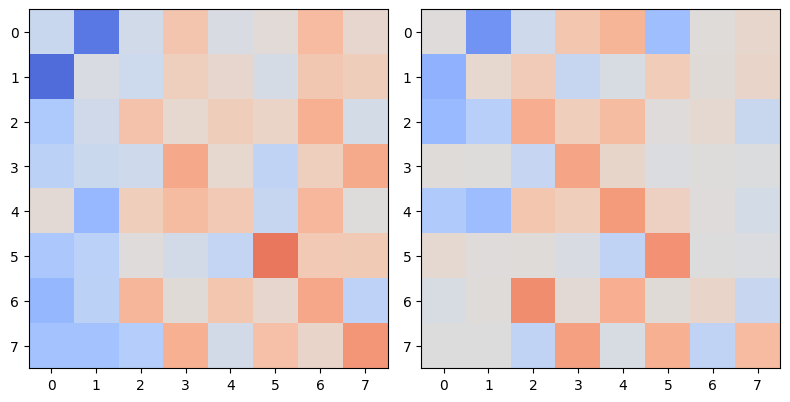

cosine_similarity measure: 0.679
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7498  1.5460
      2        0.6693  1.6002
      3        0.5946  1.5449
      4        0.5283  1.5769
      5        0.4732  1.6263
      6        0.4320  1.6122
      7        0.4091  1.6487
      8        0.4113  1.4859
      9        0.4153  1.5121
     10        0.3985  1.5966
     11        0.3792  1.5339
     12        0.3676  1.5694
     13        0.3621  1.5616
     14        0.3569  1.5447
     15        0.3507  1.5038
     16        0.3421  1.6014
     17        0.3317  1.4926
     18        0.3213  1.5873
     19        0.3148  1.5868
     20        0.3137  1.6004
     21        0.3092  1.6379
     22        0.2986  1.5508
     23        0.2915  1.6045
     24        0.2895  1.5258
     25        0.2889  1.5668
     26        0.2870  1.5897
     27        0.2830  1.5419
     28        0.2794  1.5023
     29        0.2780  1.5547
     30        0.2

    230        0.1499  1.5560
    231        0.1482  1.5878
    232        0.1300  1.5559
    233        0.1214  1.6281
    234        0.1367  1.5282
    235        0.1736  1.5194
    236        0.2072  1.5563
    237        0.2230  1.5342
    238        0.2025  1.5312
    239        0.1700  1.6134
    240        0.1560  1.5200
    241        0.1783  1.5392
    242        0.1888  1.5801
    243        0.1759  1.5831
    244        0.1625  1.5335
    245        0.1613  1.5636
    246        0.1643  1.6188
    247        0.1636  1.5844
    248        0.1583  1.5577
    249        0.1526  1.6006
    250        0.1448  1.5656
    251        0.1404  1.5995
    252        0.1391  1.6359
    253        0.1343  1.4846
    254        0.1301  1.5486
    255        0.1293  1.6161
    256        0.1251  1.5176
    257        0.1247  2.1462
    258        0.1182  1.7349
    259        0.1180  1.5522
    260        0.1311  1.4879
    261        0.1392  1.5712
    262        0.1104  1.6101
    263   

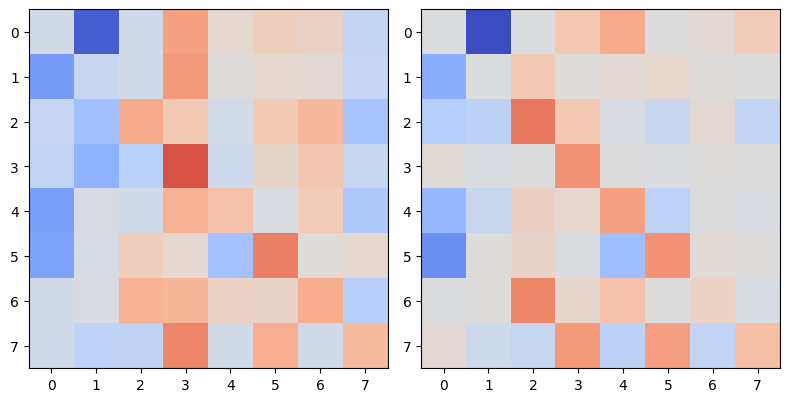

cosine_similarity measure: 0.807
MSE output:
7.162737894818853e-06
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7555  1.7938
      2        0.6798  1.4612
      3        0.6110  1.4972
      4        0.5495  1.6179
      5        0.4954  1.5338
      6        0.4502  1.5097
      7        0.4203  1.5064
      8        0.4103  1.5997
      9        0.4014  1.5490
     10        0.3830  1.5452
     11        0.3669  1.5472
     12        0.3582  1.5547
     13        0.3533  1.5250
     14        0.3479  1.5254
     15        0.3400  1.6571
     16        0.3298  1.5280
     17        0.3195  1.5561
     18        0.3124  1.5788
     19        0.3095  1.5190
     20        0.3049  1.5521
     21        0.2982  1.5045
     22        0.2936  1.5430
     23        0.2913  1.5855
     24        0.2885  1.5038
     25        0.2843  1.4945
     26        0.2796  1.5117
     27        0.2768  1.5499
     28        0.2755  1.5534
     29       

    236        0.1249  1.5407
    237        0.1176  1.6169
    238        0.1157  1.5709
    239        0.1265  1.5716
    240        0.1288  1.5201
    241        0.1334  1.5692
    242        0.1211  1.5012
    243        0.1370  1.4576
    244        0.1364  1.5230
    245        0.1366  1.5898
    246        0.1175  1.5626
    247        0.1320  1.5337
    248        0.1200  1.5600
    249        0.1306  1.5386
    250        0.1179  1.6413
    251        0.1320  1.5382
    252        0.1253  1.5307
    253        0.1254  1.5015
    254        0.1199  1.5664
    255        0.1206  1.5463
    256        0.1212  1.5139
    257        0.1240  1.5020
    258        0.1182  1.5180
    259        0.1218  1.5871
    260        0.1157  1.5204
    261        0.1299  1.5171
    262        0.1194  1.4921
    263        0.1257  1.5346
    264        0.1343  1.5281
    265        0.1283  1.4582
    266        0.1182  1.5890
    267        0.1439  1.5603
    268        0.1195  1.4394
    269   

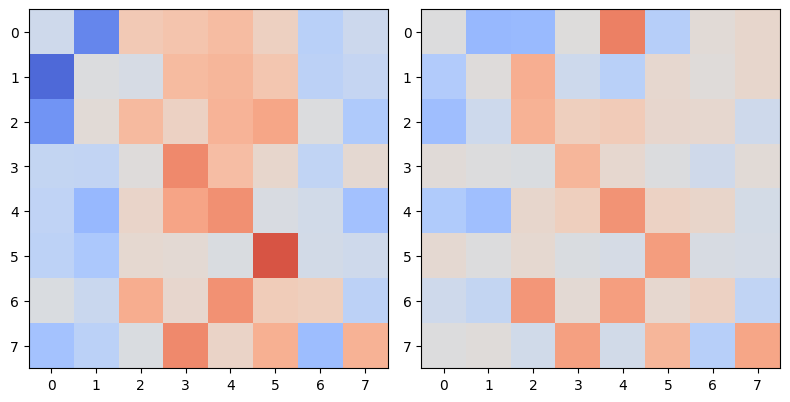

cosine_similarity measure: 0.695
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8213  1.5857
      2        0.7484  1.5638
      3        0.6834  1.5411
      4        0.6272  1.4939
      5        0.5800  1.5580
      6        0.5411  1.5230
      7        0.5117  1.4937
      8        0.4883  1.5835
      9        0.4661  1.5004
     10        0.4438  1.5214
     11        0.4224  1.5890
     12        0.4023  1.5548
     13        0.3840  1.4993
     14        0.3667  1.5458
     15        0.3519  1.5266
     16        0.3421  1.5494
     17        0.3373  1.5242
     18        0.3325  1.5215
     19        0.3301  1.5052
     20        0.3293  1.5515
     21        0.3271  1.6306
     22        0.3236  1.5239
     23        0.3201  1.5237
     24        0.3156  1.5444
     25        0.3103  1.5182
     26        0.3054  1.4946
     27        0.3012  1.5666
     28        0.2969  1.6008
     29        0.2930  1.5665
     30        0.2

    234        0.1479  1.5762
    235        0.1376  1.5793
    236        0.1326  1.6541
    237        0.1375  1.5626
    238        0.1669  1.5166
    239        0.2080  1.5498
    240        0.1458  1.5752
    241        0.1798  1.4984
    242        0.1806  1.4909
    243        0.1662  1.6105
    244        0.1757  1.6463
    245        0.1756  1.5224
    246        0.1548  1.5752
    247        0.1593  1.6145
    248        0.1645  1.5972
    249        0.1485  1.5489
    250        0.1665  1.5267
    251        0.1428  1.5359
    252        0.1522  1.5632
    253        0.1372  1.5921
    254        0.1533  1.6094
    255        0.1438  1.4928
    256        0.1428  1.6618
    257        0.1531  1.5125
    258        0.1364  1.5668
    259        0.1387  1.5956
    260        0.1512  1.5331
    261        0.1453  1.6051
    262        0.1340  1.5613
    263        0.1304  1.5548
    264        0.1343  1.4335
    265        0.1381  1.6253
    266        0.1318  1.4802
    267   

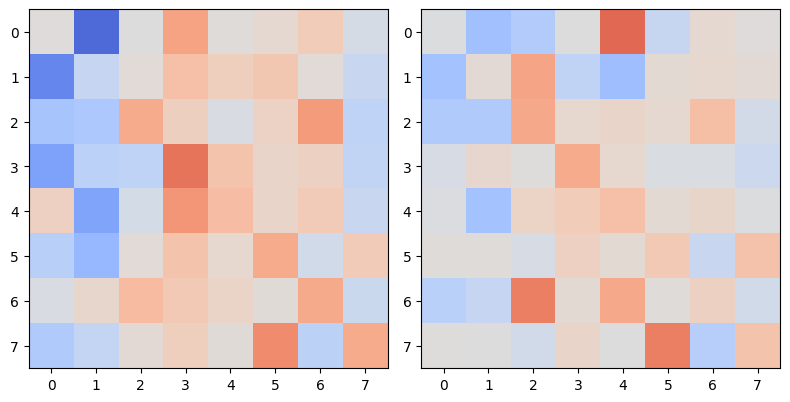

cosine_similarity measure: 0.607
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6781  1.5339
      2        0.6137  1.5390
      3        0.5561  1.6532
      4        0.5044  1.6336
      5        0.4597  1.5437
      6        0.4287  1.5915
      7        0.4114  1.6616
      8        0.3874  1.5982
      9        0.3625  1.5918
     10        0.3485  1.6278
     11        0.3417  1.5726
     12        0.3369  1.5626
     13        0.3307  1.6700
     14        0.3257  1.6439
     15        0.3238  1.5314
     16        0.3201  1.5868
     17        0.3127  1.5168
     18        0.3070  1.5275
     19        0.3027  1.6763
     20        0.2978  1.5751
     21        0.2920  1.6237
     22        0.2868  1.5852
     23        0.2836  1.5889
     24        0.2803  1.5023
     25        0.2765  1.6444
     26        0.2735  1.5980
     27        0.2717  1.6631
     28        0.2695  1.5557
     29        0.2666  1.5808
     30        0.2

    239        0.1170  1.5763
    240        0.1104  1.5542
    241        0.1083  1.6252
    242        0.1138  1.6379
    243        0.1052  1.5410
    244        0.1055  1.5863
    245        0.1041  1.5760
    246        0.1117  1.5208
    247        0.0995  1.5965
    248        0.1098  1.5530
    249        0.1025  1.5517
    250        0.1131  1.6905
    251        0.1000  1.4916
    252        0.1089  1.5737
    253        0.0973  1.6579
    254        0.1016  1.5477
    255        0.1040  1.5834
    256        0.1050  1.5132
    257        0.1008  1.6013
    258        0.0967  1.5487
    259        0.1017  1.5868
    260        0.1051  1.5754
    261        0.0964  1.6096
    262        0.1083  1.6468
    263        0.1040  1.6610
    264        0.0969  1.5282
    265        0.1022  1.5383
    266        0.1022  1.5090
    267        0.0957  1.5050
    268        0.1051  1.5615
    269        0.0944  1.6353
    270        0.0972  1.5307
    271        0.0979  1.6297
    272   

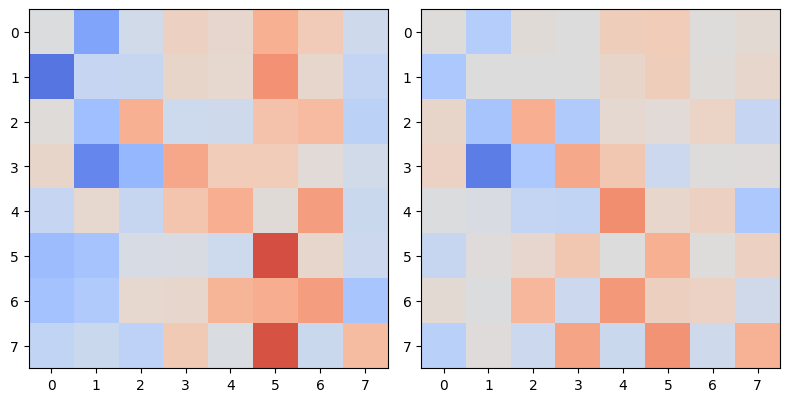

cosine_similarity measure: 0.75
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7254  1.5967
      2        0.6451  1.5662
      3        0.5709  1.5988
      4        0.5053  1.6249
      5        0.4517  1.4937
      6        0.4146  1.5455
      7        0.4047  1.5863
      8        0.4157  1.5221
      9        0.4022  1.5553
     10        0.3804  1.5911
     11        0.3680  1.6164
     12        0.3642  1.5753
     13        0.3628  1.6682
     14        0.3596  1.5936
     15        0.3533  1.5027
     16        0.3436  1.5336
     17        0.3323  1.4581
     18        0.3217  1.5243
     19        0.3155  1.5202
     20        0.3135  1.6495
     21        0.3099  1.5186
     22        0.3024  1.6211
     23        0.2963  1.5997
     24        0.2941  1.6019
     25        0.2936  1.6337
     26        0.2916  1.5616
     27        0.2884  1.5666
     28        0.2840  1.6302
     29        0.2805  1.5899
     30        0.27

    235        0.0854  1.4862
    236        0.0802  1.5793
    237        0.0772  1.5258
    238        0.0826  1.5901
    239        0.0802  1.6583
    240        0.0786  1.6352
    241        0.0814  1.5667
    242        0.0770  1.5683
    243        0.0797  1.5875
    244        0.0809  1.5070
    245        0.0811  1.5572
    246        0.0812  1.5065
    247        0.0751  1.6185
    248        0.0864  1.5614
    249        0.0812  1.5644
    250        0.0794  1.7176
    251        0.0855  1.5445
    252        0.0775  1.6010
    253        0.0860  1.6047
    254        0.0772  1.4925
    255        0.0899  1.6015
    256        0.0849  1.6328
    257        0.0928  1.5144
    258        0.0780  1.5920
    259        0.0896  1.5024
    260        0.0813  1.5788
    261        0.0875  1.4992
    262        0.0788  1.5926
    263        0.0922  1.7094
    264        0.0759  1.5346
    265        0.0854  1.5482
    266        0.0831  1.5926
    267        0.0828  1.6007
    268   

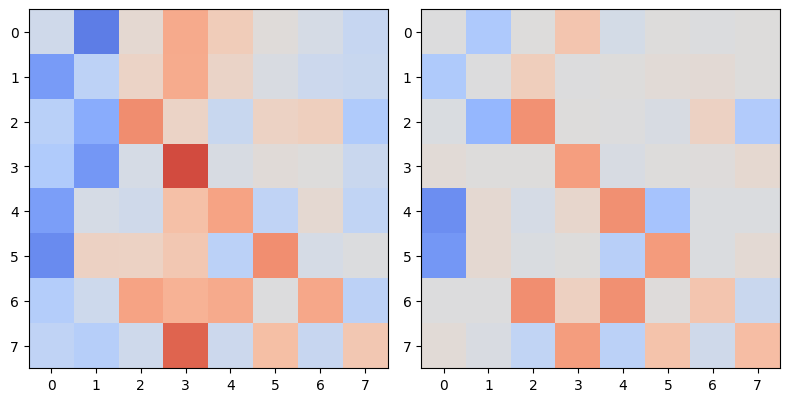

cosine_similarity measure: 0.83
MSE output:
8.041297214291693e-06
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7055  1.7673
      2        0.6324  1.5795
      3        0.5703  1.4738
      4        0.5193  1.5051
      5        0.4779  1.6131
      6        0.4484  1.4545
      7        0.4332  1.4687
      8        0.4195  1.5470
      9        0.3949  1.5163
     10        0.3706  1.4468
     11        0.3548  1.5370
     12        0.3459  1.6327
     13        0.3387  1.5599
     14        0.3314  1.6461
     15        0.3247  1.5785
     16        0.3210  1.5449
     17        0.3169  1.5617
     18        0.3087  1.6359
     19        0.3019  1.5150
     20        0.2978  1.5801
     21        0.2948  1.6794
     22        0.2918  1.6871
     23        0.2884  1.4878
     24        0.2869  1.5341
     25        0.2851  1.5667
     26        0.2823  1.5144
     27        0.2790  1.5580
     28        0.2764  1.5395
     29        

    235        0.1524  1.5557
    236        0.1433  1.4679
    237        0.1578  1.4849
    238        0.1530  1.5244
    239        0.1481  1.5915
    240        0.1396  1.5570
    241        0.1420  1.4804
    242        0.1578  1.5348
    243        0.1572  1.5293
    244        0.1564  1.6493
    245        0.1349  1.4274
    246        0.1397  1.6962
    247        0.1313  1.5380
    248        0.1366  1.5546
    249        0.1324  1.5487
    250        0.1287  1.5361
    251        0.1367  1.4747
    252        0.1424  1.5161
    253        0.1301  1.5861
    254        0.1241  1.5672
    255        0.1234  1.5536
    256        0.1227  1.5484
    257        0.1218  1.5602
    258        0.1191  1.5825
    259        0.1196  1.5695
    260        0.1174  1.5357
    261        0.1289  1.5026
    262        0.1893  1.5076
    263        0.1504  1.5472
    264        0.1328  1.6074
    265        0.1489  1.5384
    266        0.1418  1.5215
    267        0.1471  1.5375
    268   

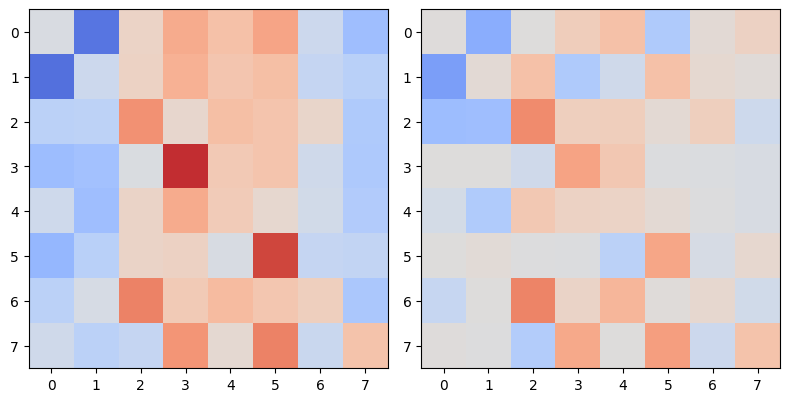

cosine_similarity measure: 0.714
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7048  1.7051
      2        0.6310  1.5441
      3        0.5658  1.4780
      4        0.5079  1.5789
      5        0.4568  1.5679
      6        0.4166  1.5684
      7        0.3970  1.5185
      8        0.4002  1.5310
      9        0.3892  1.4933
     10        0.3677  1.4738
     11        0.3549  1.5022
     12        0.3503  1.6273
     13        0.3475  1.4793
     14        0.3431  1.5872
     15        0.3356  1.5715
     16        0.3262  1.5685
     17        0.3168  1.5804
     18        0.3108  1.4495
     19        0.3094  1.5934
     20        0.3050  1.4968
     21        0.2957  1.5442
     22        0.2891  1.5909
     23        0.2865  1.5791
     24        0.2853  1.5014
     25        0.2830  1.6020
     26        0.2793  1.5776
     27        0.2761  1.5532
     28        0.2745  1.6138
     29        0.2735  1.4864
     30        0.2

    238        0.1182  1.5126
    239        0.1280  1.5841
    240        0.1122  1.5177
    241        0.1239  1.4994
    242        0.1266  1.4806
    243        0.1126  1.5112
    244        0.1219  1.5914
    245        0.1322  1.6226
    246        0.1123  1.4837
    247        0.1168  1.4512
    248        0.1259  1.5270
    249        0.1133  1.6202
    250        0.1156  1.5618
    251        0.1244  1.5478
    252        0.1149  1.5819
    253        0.1118  1.5335
    254        0.1190  1.5832
    255        0.1262  1.5242
    256        0.1199  1.6910
    257        0.1117  1.4882
    258        0.1089  1.6363
    259        0.1113  1.5424
    260        0.1137  1.5956
    261        0.1143  1.5444
    262        0.1197  1.4570
    263        0.1362  1.5227
    264        0.1218  1.5035
    265        0.1079  1.5884
    266        0.1137  1.7310
    267        0.1169  1.4554
    268        0.1088  1.6882
    269        0.1108  1.5295
    270        0.1150  1.5476
    271   

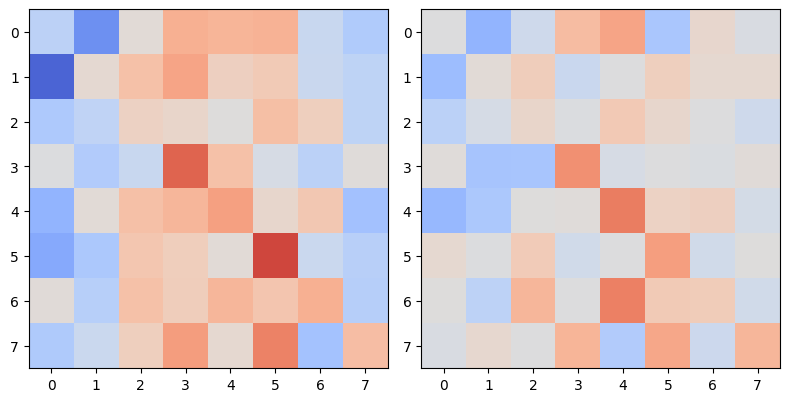

cosine_similarity measure: 0.697
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6530  1.5354
      2        0.5873  1.5859
      3        0.5243  1.5604
      4        0.4658  1.5289
      5        0.4163  1.5437
      6        0.3923  1.5720
      7        0.3823  1.5424
      8        0.3566  1.5405
      9        0.3418  1.6265
     10        0.3380  1.5507
     11        0.3362  1.5678
     12        0.3317  1.6423
     13        0.3253  1.5371
     14        0.3208  1.6061
     15        0.3199  1.5943
     16        0.3166  1.6232
     17        0.3088  1.5301
     18        0.3023  1.4654
     19        0.2983  1.5669
     20        0.2947  1.4980
     21        0.2904  1.5344
     22        0.2856  1.5208
     23        0.2820  1.5989
     24        0.2800  1.6444
     25        0.2771  1.5895
     26        0.2732  1.5593
     27        0.2703  1.5261
     28        0.2688  1.5189
     29        0.2672  1.4715
     30        0.2

    236        0.1300  1.4949
    237        0.1186  1.5133
    238        0.1352  1.5808
    239        0.1196  1.4730
    240        0.1279  1.5415
    241        0.1217  1.5556
    242        0.1172  1.5886
    243        0.1194  1.5256
    244        0.1312  1.5260
    245        0.1378  1.5777
    246        0.1369  1.5938
    247        0.1180  1.5221
    248        0.1173  1.5377
    249        0.1263  1.6032
    250        0.1174  1.5952
    251        0.1241  1.5168
    252        0.1170  1.5179
    253        0.1158  1.4598
    254        0.1223  1.5376
    255        0.1273  1.6170
    256        0.1250  1.6569
    257        0.1241  1.5173
    258        0.1185  1.5139
    259        0.1132  1.5551
    260        0.1149  1.5433
    261        0.1162  1.6070
    262        0.1130  1.5229
    263        0.1104  1.5298
    264        0.1123  1.4835
    265        0.1180  1.4883
    266        0.1458  1.8206
    267        0.1717  1.5204
    268        0.1188  1.5185
    269   

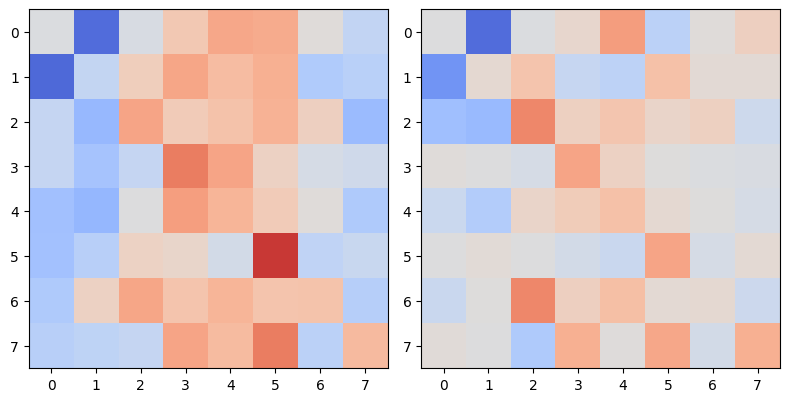

cosine_similarity measure: 0.757
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7645  1.6364
      2        0.6823  1.5180
      3        0.6091  1.5358
      4        0.5457  1.5648
      5        0.4918  1.6047
      6        0.4472  1.5173
      7        0.4164  1.5369
      8        0.4106  1.6198
      9        0.4169  1.5066
     10        0.4024  1.5423
     11        0.3844  1.5196
     12        0.3750  1.5405
     13        0.3712  1.5041
     14        0.3685  1.4847
     15        0.3637  1.5441
     16        0.3561  1.5582
     17        0.3462  1.5761
     18        0.3354  1.5842
     19        0.3254  1.5908
     20        0.3192  1.5659
     21        0.3176  1.6690
     22        0.3156  1.5767
     23        0.3074  1.6030
     24        0.2991  1.5644
     25        0.2955  1.5512
     26        0.2945  1.5204
     27        0.2932  1.5078
     28        0.2900  1.5659
     29        0.2857  1.5542
     30        0.2

    231        0.1051  1.6420
    232        0.0953  1.5522
    233        0.1011  1.5402
    234        0.0965  1.5688
    235        0.0980  1.5427
    236        0.0957  1.6079
    237        0.0944  1.5216
    238        0.0887  1.5369
    239        0.0959  1.5492
    240        0.0864  1.5197
    241        0.0885  1.5478
    242        0.0976  1.6190
    243        0.0911  1.6059
    244        0.0842  1.5556
    245        0.0822  1.6284
    246        0.0878  1.4859
    247        0.0916  1.4829
    248        0.1028  1.5603
    249        0.0958  1.6875
    250        0.0835  1.5703
    251        0.0868  1.4681
    252        0.0850  1.5844
    253        0.0853  1.5220
    254        0.0898  1.4990
    255        0.0823  1.6127
    256        0.0814  1.6166
    257        0.0862  1.5339
    258        0.0911  1.6359
    259        0.0940  1.5887
    260        0.0915  1.5386
    261        0.0825  1.6194
    262        0.0833  1.5986
    263        0.0831  1.5156
    264   

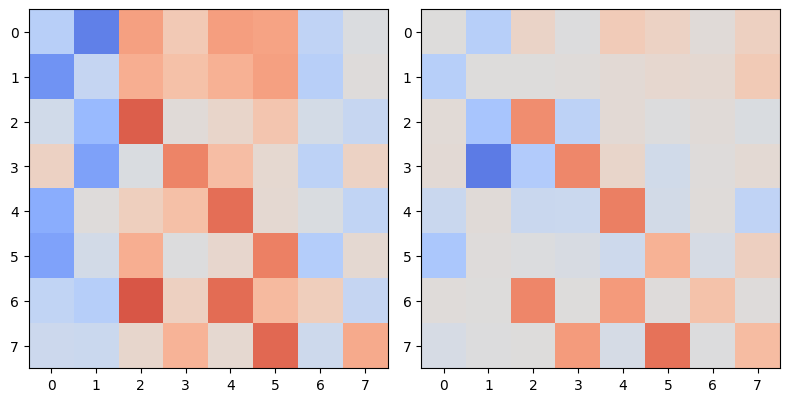

cosine_similarity measure: 0.784
[1.  0.  0.1 0.9 0.1 0.9]
[1.  0.  0.1 0.9 0.3 0.7]
[1.  0.  0.1 0.9 0.4 0.6]
[1.   0.   0.1  0.9  0.45 0.55]
[1.    0.    0.1   0.9   0.475 0.525]
[1.     0.     0.1    0.9    0.4875 0.5125]
[1.      0.      0.1     0.9     0.49375 0.50625]
[1.  0.  0.1 0.9 0.5 0.5]
[1.      0.      0.1     0.9     0.50625 0.49375]
[1.     0.     0.1    0.9    0.5125 0.4875]
[1.    0.    0.1   0.9   0.525 0.475]
[1.   0.   0.1  0.9  0.55 0.45]
[1.  0.  0.1 0.9 0.6 0.4]
[1.  0.  0.1 0.9 0.7 0.3]
[1.  0.  0.1 0.9 0.9 0.1]
[1.  0.  0.3 0.7 0.1 0.9]
[1.  0.  0.3 0.7 0.3 0.7]
[1.  0.  0.3 0.7 0.4 0.6]
[1.   0.   0.3  0.7  0.45 0.55]
[1.    0.    0.3   0.7   0.475 0.525]
[1.     0.     0.3    0.7    0.4875 0.5125]
[1.      0.      0.3     0.7     0.49375 0.50625]
[1.  0.  0.3 0.7 0.5 0.5]
[1.      0.      0.3     0.7     0.50625 0.49375]
[1.     0.     0.3    0.7    0.5125 0.4875]
[1.    0.    0.3   0.7   0.525 0.475]
[1.   0.   0.3  0.7  0.55 0.45]
[1.  0.  0.3 0.7 0.6 0.4]

[1.  0.  0.7 0.3 0.7 0.3]
[1.  0.  0.7 0.3 0.9 0.1]
[1.  0.  0.9 0.1 0.1 0.9]
[1.  0.  0.9 0.1 0.3 0.7]
[1.  0.  0.9 0.1 0.4 0.6]
[1.   0.   0.9  0.1  0.45 0.55]
[1.    0.    0.9   0.1   0.475 0.525]
[1.     0.     0.9    0.1    0.4875 0.5125]
[1.      0.      0.9     0.1     0.49375 0.50625]
[1.  0.  0.9 0.1 0.5 0.5]
[1.      0.      0.9     0.1     0.50625 0.49375]
[1.     0.     0.9    0.1    0.5125 0.4875]
[1.    0.    0.9   0.1   0.525 0.475]
[1.   0.   0.9  0.1  0.55 0.45]
[1.  0.  0.9 0.1 0.6 0.4]
[1.  0.  0.9 0.1 0.7 0.3]
[1.  0.  0.9 0.1 0.9 0.1]
[0.  1.  0.1 0.9 0.1 0.9]
[0.  1.  0.3 0.7 0.1 0.9]
[0.  1.  0.4 0.6 0.1 0.9]
[0.   1.   0.45 0.55 0.1  0.9 ]
[0.    1.    0.475 0.525 0.1   0.9  ]
[0.     1.     0.4875 0.5125 0.1    0.9   ]
[0.      1.      0.49375 0.50625 0.1     0.9    ]
[0.  1.  0.5 0.5 0.1 0.9]
[0.      1.      0.50625 0.49375 0.1     0.9    ]
[0.     1.     0.5125 0.4875 0.1    0.9   ]
[0.    1.    0.525 0.475 0.1   0.9  ]
[0.   1.   0.55 0.45 0.1  0.9 ]
[0.  1

[0.  1.  0.6 0.4 0.6 0.4]
[0.  1.  0.7 0.3 0.6 0.4]
[0.  1.  0.9 0.1 0.6 0.4]
[0.  1.  0.1 0.9 0.7 0.3]
[0.  1.  0.3 0.7 0.7 0.3]
[0.  1.  0.4 0.6 0.7 0.3]
[0.   1.   0.45 0.55 0.7  0.3 ]
[0.    1.    0.475 0.525 0.7   0.3  ]
[0.     1.     0.4875 0.5125 0.7    0.3   ]
[0.      1.      0.49375 0.50625 0.7     0.3    ]
[0.  1.  0.5 0.5 0.7 0.3]
[0.      1.      0.50625 0.49375 0.7     0.3    ]
[0.     1.     0.5125 0.4875 0.7    0.3   ]
[0.    1.    0.525 0.475 0.7   0.3  ]
[0.   1.   0.55 0.45 0.7  0.3 ]
[0.  1.  0.6 0.4 0.7 0.3]
[0.  1.  0.7 0.3 0.7 0.3]
[0.  1.  0.9 0.1 0.7 0.3]
[0.  1.  0.1 0.9 0.9 0.1]
[0.  1.  0.3 0.7 0.9 0.1]
[0.  1.  0.4 0.6 0.9 0.1]
[0.   1.   0.45 0.55 0.9  0.1 ]
[0.    1.    0.475 0.525 0.9   0.1  ]
[0.     1.     0.4875 0.5125 0.9    0.1   ]
[0.      1.      0.49375 0.50625 0.9     0.1    ]
[0.  1.  0.5 0.5 0.9 0.1]
[0.      1.      0.50625 0.49375 0.9     0.1    ]
[0.     1.     0.5125 0.4875 0.9    0.1   ]
[0.    1.    0.525 0.475 0.9   0.1  ]
[0.   1.   0

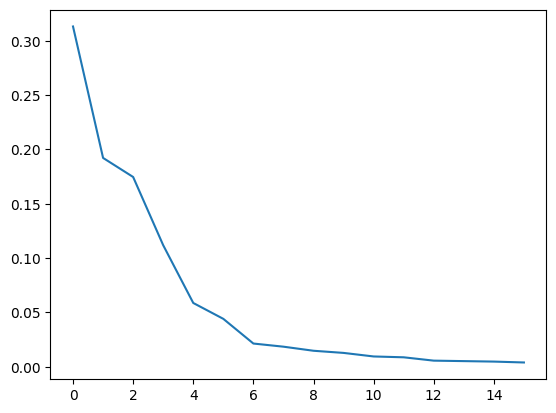

Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7134  1.7254
      2        0.6427  1.7016
      3        0.5768  1.5184
      4        0.5167  1.5040
      5        0.4646  1.5211
      6        0.4233  1.4862
      7        0.3985  1.4874
      8        0.3908  1.5342
      9        0.3787  1.5120
     10        0.3577  1.5370
     11        0.3403  1.4829
     12        0.3303  1.4958
     13        0.3235  1.5341
     14        0.3172  1.4863
     15        0.3098  1.5429
     16        0.3018  1.5315
     17        0.2936  1.5515
     18        0.2876  1.7318
     19        0.2849  1.6378
     20        0.2814  1.5737
     21        0.2750  1.5860
     22        0.2707  1.5843
     23        0.2694  1.5350
     24        0.2687  1.6055
     25        0.2665  1.5307
     26        0.2630  1.5864
     27        0.2595  1.5441
     28        0.2579  1.5260
     29        0.2569  1.6693
     30        0.2543  1.4983
     31        0.2513

    240        0.1045  1.4732
    241        0.0957  1.5194
    242        0.0951  1.4932
    243        0.0926  1.5849
    244        0.0931  1.5429
    245        0.1028  1.5564
    246        0.0940  1.4618
    247        0.0975  1.5164
    248        0.0958  1.5136
    249        0.0908  1.4826
    250        0.0949  1.4736
    251        0.0919  1.5064
    252        0.0911  1.4669
    253        0.0941  1.5838
    254        0.0907  1.5477
    255        0.0910  1.5482
    256        0.0937  1.5960
    257        0.0937  1.4975
    258        0.1076  1.5456
    259        0.1077  1.4623
    260        0.1048  1.4937
    261        0.0947  1.6692
    262        0.0928  1.5257
    263        0.0937  1.5061
    264        0.0932  1.5865
    265        0.0927  1.5357
    266        0.0915  1.5275
    267        0.0914  1.5703
    268        0.0968  1.4847
    269        0.1056  1.5199
    270        0.0925  1.5825
    271        0.1111  1.4647
    272        0.0912  1.4991
    273   

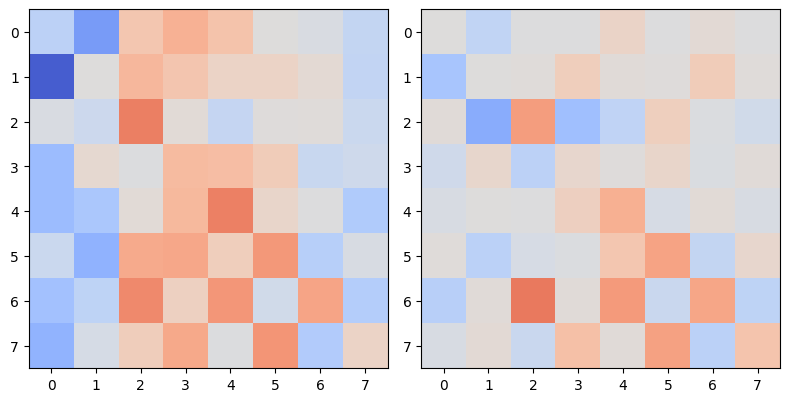

cosine_similarity measure: 0.719
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7437  1.5063
      2        0.6688  1.4613
      3        0.6027  1.5746
      4        0.5420  1.4732
      5        0.4873  1.5551
      6        0.4389  1.4546
      7        0.4008  1.5733
      8        0.3774  1.6026
      9        0.3714  1.5425
     10        0.3640  1.6149
     11        0.3454  1.5748
     12        0.3269  1.5915
     13        0.3158  1.5419
     14        0.3105  1.5581
     15        0.3067  1.5082
     16        0.3027  1.5458
     17        0.2973  1.6358
     18        0.2904  1.5572
     19        0.2824  1.5524
     20        0.2746  1.5599
     21        0.2699  1.5145
     22        0.2695  1.5860
     23        0.2675  1.5332
     24        0.2615  1.5292
     25        0.2574  1.5274
     26        0.2562  1.5102
     27        0.2555  1.5749
     28        0.2536  1.5030
     29        0.2504  1.5609
     30        0.2

    239        0.0739  1.6606
    240        0.0743  1.5525
    241        0.0730  1.5919
    242        0.0731  1.5897
    243        0.0703  1.5549
    244        0.0735  1.5451
    245        0.0715  1.6211
    246        0.0716  1.5640
    247        0.0710  1.4978
    248        0.0711  1.5700
    249        0.0716  1.4975
    250        0.0696  1.5196
    251        0.0708  1.6149
    252        0.0746  1.5013
    253        0.0721  1.5145
    254        0.0712  1.4845
    255        0.0717  1.5385
    256        0.0714  1.5640
    257        0.0721  1.4990
    258        0.0703  1.5527
    259        0.0711  1.5680
    260        0.0708  1.5727
    261        0.0697  1.6264
    262        0.0736  1.7007
    263        0.0727  1.6125
    264        0.0706  1.6266
    265        0.0727  1.5849
    266        0.0729  1.5367
    267        0.0710  1.5522
    268        0.0739  1.6444
    269        0.0750  1.5042
    270        0.0709  1.5464
    271        0.0706  1.5861
    272   

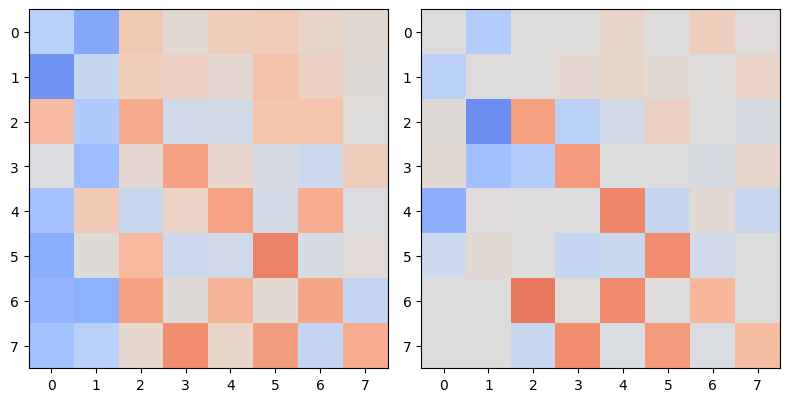

cosine_similarity measure: 0.749
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7117  1.5058
      2        0.6362  1.5799
      3        0.5713  1.6210
      4        0.5171  1.5300
      5        0.4723  1.6150
      6        0.4366  1.5857
      7        0.4117  1.5373
      8        0.3966  1.5350
      9        0.3840  1.5659
     10        0.3676  1.6025
     11        0.3495  1.6276
     12        0.3358  1.6971
     13        0.3258  1.5808
     14        0.3171  1.5447
     15        0.3085  1.6099
     16        0.3005  1.5059
     17        0.2950  1.5710
     18        0.2915  1.5831
     19        0.2863  1.6282
     20        0.2821  1.6373
     21        0.2795  1.6360
     22        0.2765  1.6229
     23        0.2725  1.5203
     24        0.2679  1.5711
     25        0.2645  1.5029
     26        0.2614  1.5559
     27        0.2576  1.5936
     28        0.2540  1.5909
     29        0.2512  1.5174
     30        0.2

    240        0.0799  1.4453
    241        0.0837  1.5825
    242        0.0786  1.5240
    243        0.0817  1.5494
    244        0.0801  1.5501
    245        0.0811  1.6119
    246        0.0781  1.5636
    247        0.0788  1.5924
    248        0.0848  1.5246
    249        0.0777  1.5447
    250        0.0795  1.5090
    251        0.0811  1.5548
    252        0.0817  1.5344
    253        0.0765  1.5740
    254        0.0802  1.5289
    255        0.0779  1.5177
    256        0.0772  1.4962
    257        0.0793  1.4874
    258        0.0767  1.6120
    259        0.0789  1.5031
    260        0.0770  1.6651
    261        0.0763  1.4969
    262        0.0771  1.4413
    263        0.0752  1.5202
    264        0.0769  1.6531
    265        0.0767  1.5828
    266        0.0757  1.5705
    267        0.0778  1.5877
    268        0.0780  1.5907
    269        0.0771  1.5200
    270        0.0782  1.5582
    271        0.0811  1.5808
    272        0.0783  1.5758
    273   

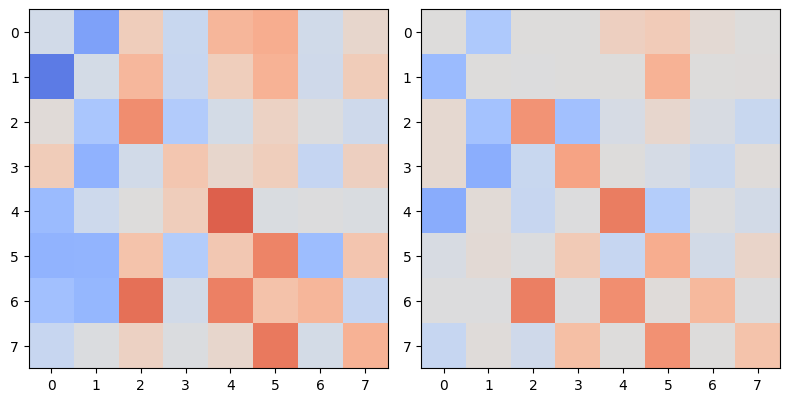

cosine_similarity measure: 0.78
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8152  1.5524
      2        0.7483  1.5561
      3        0.6911  1.5397
      4        0.6417  1.6066
      5        0.5988  1.6348
      6        0.5616  1.5601
      7        0.5301  1.6097
      8        0.5026  1.5947
      9        0.4777  1.6212
     10        0.4541  1.5642
     11        0.4322  1.5925
     12        0.4128  1.6554
     13        0.3956  1.5873
     14        0.3803  1.5528
     15        0.3666  1.5964
     16        0.3553  1.5895
     17        0.3463  1.5753
     18        0.3388  1.5930
     19        0.3318  1.5379
     20        0.3266  1.5107
     21        0.3217  1.5731
     22        0.3165  1.6374
     23        0.3121  1.6220
     24        0.3075  1.6196
     25        0.3023  1.5727
     26        0.2986  1.5849
     27        0.2954  1.6063
     28        0.2921  1.5918
     29        0.2890  1.5925
     30        0.28

    240        0.0804  1.5715
    241        0.0836  1.5581
    242        0.0779  1.6483
    243        0.0754  1.4946
    244        0.0805  1.7332
    245        0.0768  1.5335
    246        0.0778  1.5152
    247        0.0782  1.5482
    248        0.0747  1.4975
    249        0.0808  1.5144
    250        0.0772  1.5401
    251        0.0755  1.5833
    252        0.0793  1.4447
    253        0.0764  1.5175
    254        0.0765  1.5708
    255        0.0805  1.5337
    256        0.0789  1.5505
    257        0.0753  1.6376
    258        0.0774  1.5983
    259        0.0762  1.5238
    260        0.0771  1.5247
    261        0.0760  1.5329
    262        0.0754  1.6047
    263        0.0768  1.6086
    264        0.0743  1.5617
    265        0.0778  1.5312
    266        0.0769  1.5364
    267        0.0754  1.5568
    268        0.0830  1.6169
    269        0.0852  1.5820
    270        0.0863  1.5232
    271        0.0778  1.6483
    272        0.0939  1.5408
    273   

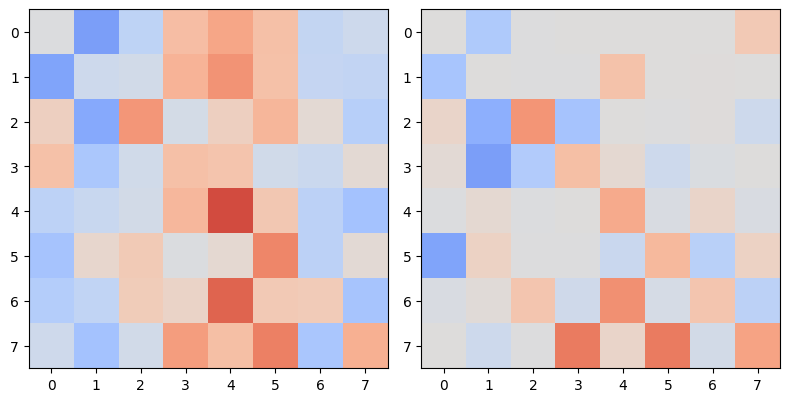

cosine_similarity measure: 0.751
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7092  1.5406
      2        0.6379  1.5625
      3        0.5774  1.5166
      4        0.5268  1.6143
      5        0.4849  1.6011
      6        0.4509  1.5708
      7        0.4267  1.5677
      8        0.4097  1.5644
      9        0.3941  1.6008
     10        0.3756  1.5083
     11        0.3572  1.6587
     12        0.3408  1.5718
     13        0.3273  1.5382
     14        0.3160  1.6662
     15        0.3056  1.5503
     16        0.2972  1.5742
     17        0.2911  1.6380
     18        0.2877  1.6203
     19        0.2829  1.5725
     20        0.2782  1.5924
     21        0.2749  1.6238
     22        0.2723  1.6720
     23        0.2694  1.5818
     24        0.2664  1.6170
     25        0.2641  1.6817
     26        0.2612  1.5350
     27        0.2575  1.6104
     28        0.2537  1.5969
     29        0.2505  1.5622
     30        0.2

    235        0.0928  1.5439
    236        0.1026  1.4623
    237        0.0899  1.6476
    238        0.0848  1.5118
    239        0.0868  1.5630
    240        0.0876  1.5372
    241        0.0849  1.5088
    242        0.0839  1.5164
    243        0.0841  1.4639
    244        0.0861  1.6054
    245        0.0965  1.5701
    246        0.1187  1.5675
    247        0.0841  1.6375
    248        0.0970  1.4331
    249        0.0974  1.5770
    250        0.0889  1.5353
    251        0.0999  1.5439
    252        0.0867  1.4750
    253        0.0959  1.6184
    254        0.0880  1.6413
    255        0.0920  1.5064
    256        0.0968  1.5087
    257        0.0846  1.6436
    258        0.0951  1.5505
    259        0.0896  1.5462
    260        0.0874  1.5925
    261        0.0984  1.5035
    262        0.0956  1.5503
    263        0.0868  1.5197
    264        0.1046  1.5438
    265        0.0852  1.4988
    266        0.0943  1.5139
    267        0.0878  1.5402
    268   

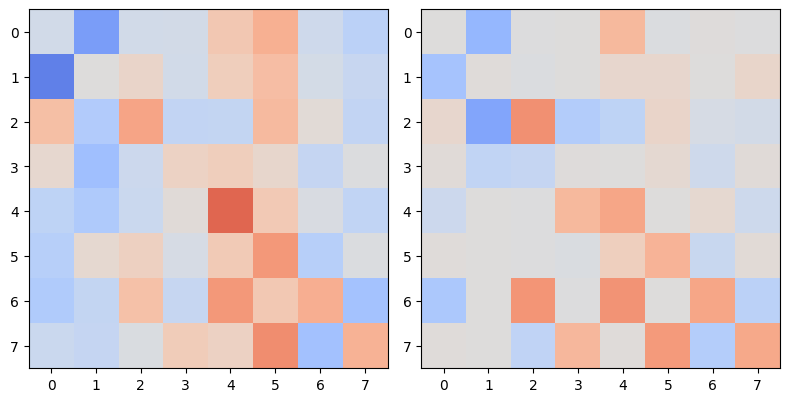

cosine_similarity measure: 0.811
MSE output:
9.626842015989893e-05
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7789  1.9372
      2        0.6949  1.5525
      3        0.6198  1.5948
      4        0.5547  1.5781
      5        0.5000  1.5089
      6        0.4554  1.5595
      7        0.4206  1.5710
      8        0.3977  1.5303
      9        0.3878  1.6010
     10        0.3830  1.5758
     11        0.3707  1.5621
     12        0.3542  1.5349
     13        0.3416  1.5482
     14        0.3333  1.5486
     15        0.3278  1.5905
     16        0.3226  1.4976
     17        0.3164  1.5306
     18        0.3092  1.5425
     19        0.3011  1.5511
     20        0.2928  1.4950
     21        0.2856  1.4986
     22        0.2809  1.6294
     23        0.2783  1.5266
     24        0.2733  1.6123
     25        0.2664  1.6008
     26        0.2606  1.5430
     27        0.2577  1.5941
     28        0.2551  1.5923
     29       

    238        0.0762  1.5186
    239        0.0786  1.5144
    240        0.0735  1.5706
    241        0.0756  1.5960
    242        0.0730  1.6113
    243        0.0751  1.5836
    244        0.0760  1.6140
    245        0.0737  1.5625
    246        0.0731  1.6044
    247        0.0748  1.6150
    248        0.0743  1.4697
    249        0.0736  1.5809
    250        0.0751  1.5591
    251        0.0722  1.5688
    252        0.0747  1.5440
    253        0.0741  1.5569
    254        0.0720  1.5527
    255        0.0739  1.5795
    256        0.0747  1.5674
    257        0.0736  1.5622
    258        0.0760  1.5061
    259        0.0754  1.4930
    260        0.0732  1.5974
    261        0.0749  1.5493
    262        0.0748  1.5792
    263        0.0741  1.5526
    264        0.0736  1.5964
    265        0.0730  1.5577
    266        0.0737  1.5775
    267        0.0727  1.6478
    268        0.0725  1.4812
    269        0.0725  1.5447
    270        0.0719  1.5477
    271   

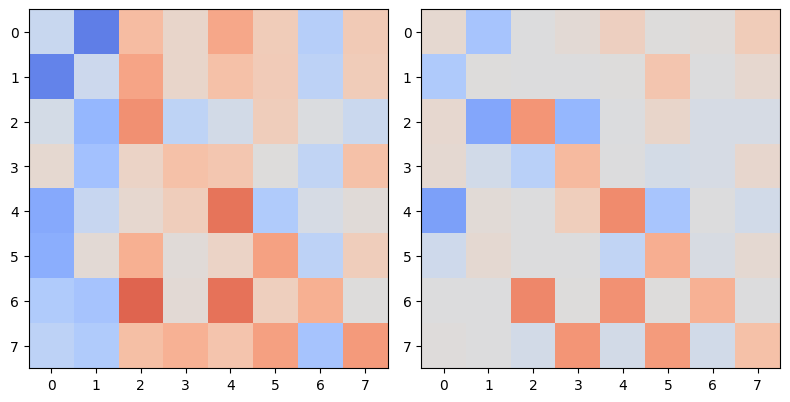

cosine_similarity measure: 0.774
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6823  1.5589
      2        0.6127  1.5047
      3        0.5495  1.5934
      4        0.4918  1.5619
      5        0.4403  1.6192
      6        0.3984  1.5047
      7        0.3737  1.4780
      8        0.3703  1.5603
      9        0.3632  1.6495
     10        0.3445  1.6092
     11        0.3309  1.5449
     12        0.3242  1.6605
     13        0.3213  1.5046
     14        0.3178  1.7399
     15        0.3132  1.5383
     16        0.3069  1.5171
     17        0.2997  1.5234
     18        0.2935  1.5334
     19        0.2893  1.5524
     20        0.2871  1.4893
     21        0.2829  1.5759
     22        0.2766  1.5074
     23        0.2711  1.5180
     24        0.2673  1.6522
     25        0.2642  1.5794
     26        0.2608  1.6192
     27        0.2568  1.5839
     28        0.2526  1.5389
     29        0.2495  1.5309
     30        0.2

    235        0.1141  1.5626
    236        0.1291  1.5945
    237        0.1184  1.6063
    238        0.1184  1.6111
    239        0.1213  1.6246
    240        0.1124  1.6182
    241        0.1204  1.5889
    242        0.1105  1.6088
    243        0.1202  1.5976
    244        0.1230  1.4964
    245        0.1081  1.5342
    246        0.1323  1.6106
    247        0.1318  1.5732
    248        0.1152  1.5773
    249        0.1293  1.6883
    250        0.1177  1.6807
    251        0.1222  1.6196
    252        0.1165  1.5751
    253        0.1205  1.4803
    254        0.1130  1.5597
    255        0.1169  1.4787
    256        0.1093  1.5051
    257        0.1162  1.5567
    258        0.1087  1.4829
    259        0.1154  1.5023
    260        0.1103  1.6366
    261        0.1165  1.5920
    262        0.1219  1.6294
    263        0.1251  1.5753
    264        0.1206  1.6421
    265        0.1187  1.6560
    266        0.1211  1.6195
    267        0.1165  1.5884
    268   

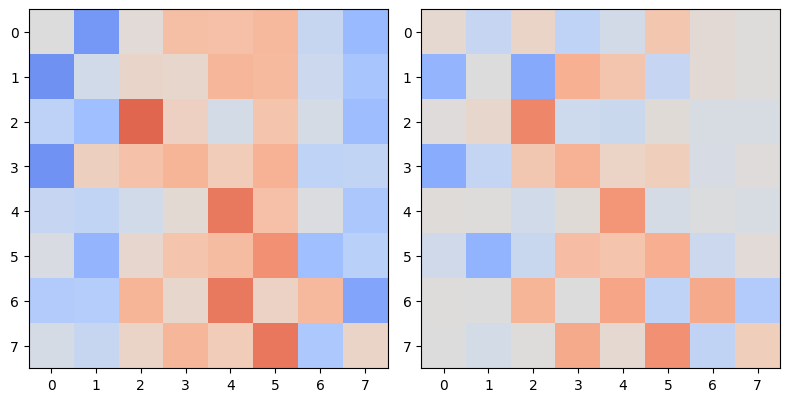

cosine_similarity measure: 0.703
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7624  1.5890
      2        0.6887  1.6271
      3        0.6220  1.5523
      4        0.5639  1.5397
      5        0.5134  1.5002
      6        0.4688  1.6476
      7        0.4315  1.6264
      8        0.4038  1.5327
      9        0.3892  1.4956
     10        0.3842  1.6390
     11        0.3723  1.5690
     12        0.3550  1.5706
     13        0.3409  1.5584
     14        0.3314  1.5618
     15        0.3250  1.5524
     16        0.3191  1.6197
     17        0.3127  1.5613
     18        0.3051  1.5312
     19        0.2967  1.5971
     20        0.2887  1.5840
     21        0.2828  1.5888
     22        0.2799  1.5566
     23        0.2778  1.6040
     24        0.2728  1.5500
     25        0.2674  1.5520
     26        0.2645  1.5650
     27        0.2630  1.6032
     28        0.2607  1.5894
     29        0.2573  1.6100
     30        0.2

    236        0.0742  1.5886
    237        0.0736  1.5639
    238        0.0735  1.5672
    239        0.0747  1.5101
    240        0.0734  1.5343
    241        0.0723  1.4931
    242        0.0741  1.5348
    243        0.0707  1.6128
    244        0.0744  1.5711
    245        0.0737  1.5762
    246        0.0716  1.6307
    247        0.0738  1.5773
    248        0.0716  1.5689
    249        0.0751  1.5351
    250        0.0708  1.5935
    251        0.0721  1.5641
    252        0.0762  1.6121
    253        0.0709  1.5339
    254        0.0768  1.5640
    255        0.0717  1.4911
    256        0.0744  1.6124
    257        0.0723  1.5485
    258        0.0739  1.5902
    259        0.0724  1.5811
    260        0.0727  1.6120
    261        0.0730  1.5408
    262        0.0724  1.5169
    263        0.0738  1.5748
    264        0.0699  1.6884
    265        0.0738  1.7625
    266        0.0704  1.6045
    267        0.0710  1.5238
    268        0.0706  1.5536
    269   

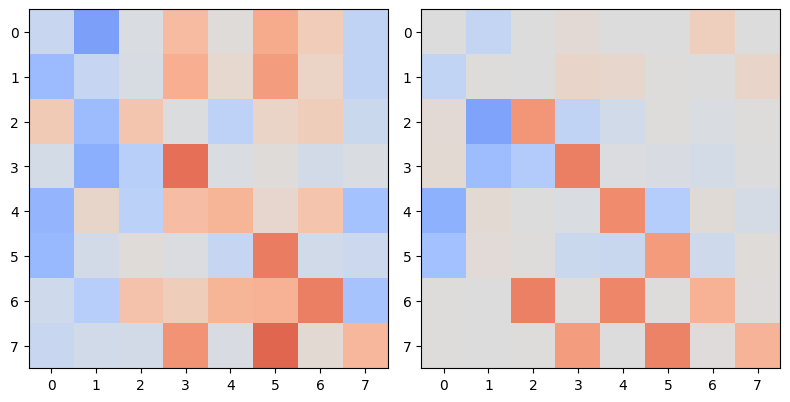

cosine_similarity measure: 0.759
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8072  1.5727
      2        0.7404  1.5575
      3        0.6847  1.5975
      4        0.6378  1.5418
      5        0.5980  1.5687
      6        0.5642  1.5931
      7        0.5367  1.5367
      8        0.5141  1.4921
      9        0.4944  1.6243
     10        0.4754  1.5993
     11        0.4563  1.6349
     12        0.4379  1.5332
     13        0.4203  1.7026
     14        0.4034  1.5966
     15        0.3871  1.6174
     16        0.3720  1.6225
     17        0.3580  1.5487
     18        0.3456  1.5085
     19        0.3358  1.6396
     20        0.3266  1.5362
     21        0.3184  1.6013
     22        0.3123  1.7030
     23        0.3065  1.5436
     24        0.3005  1.6650
     25        0.2952  1.6549
     26        0.2900  1.6073
     27        0.2841  1.6080
     28        0.2786  1.5725
     29        0.2734  1.6115
     30        0.2

    241        0.0790  1.4889
    242        0.0766  1.6731
    243        0.0798  1.6899
    244        0.0814  1.5623
    245        0.0764  1.5455
    246        0.0762  1.5502
    247        0.0756  1.5940
    248        0.0741  1.6075
    249        0.0755  1.5386
    250        0.0768  1.5767
    251        0.0764  1.5691
    252        0.0744  1.6414
    253        0.0751  1.5955
    254        0.0759  1.6156
    255        0.0778  1.5608
    256        0.0773  1.6437
    257        0.0776  1.5236
    258        0.0754  1.5419
    259        0.0756  1.6503
    260        0.0782  1.5884
    261        0.0776  1.6613
    262        0.0761  1.5771
    263        0.0758  1.6601
    264        0.0766  1.5698
    265        0.0804  1.5616
    266        0.0775  1.5505
    267        0.0743  1.5014
    268        0.0778  1.6613
    269        0.0772  1.6156
    270        0.0761  1.5839
    271        0.0747  1.5880
    272        0.0733  1.5917
    273        0.0741  1.5659
    274   

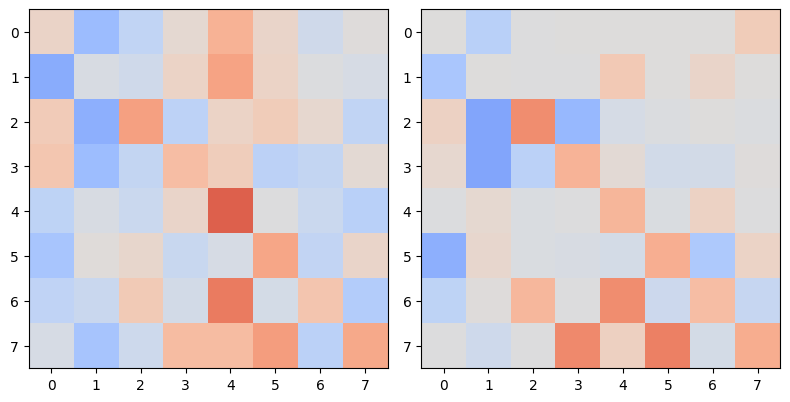

cosine_similarity measure: 0.833
MSE output:
2.1382281418676875e-05
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7894  1.7835
      2        0.7181  1.6401
      3        0.6577  1.5657
      4        0.6047  1.5115
      5        0.5566  1.5203
      6        0.5143  1.4708
      7        0.4783  1.5477
      8        0.4522  1.5736
      9        0.4350  1.5567
     10        0.4191  1.5311
     11        0.3989  1.5236
     12        0.3802  1.4894
     13        0.3660  1.5988
     14        0.3555  1.5652
     15        0.3466  1.5280
     16        0.3371  1.5631
     17        0.3271  1.5546
     18        0.3174  1.5571
     19        0.3102  1.5095
     20        0.3057  1.5263
     21        0.2989  1.5828
     22        0.2906  1.6107
     23        0.2852  1.5832
     24        0.2808  1.6319
     25        0.2761  1.6026
     26        0.2704  1.5751
     27        0.2655  1.5164
     28        0.2625  1.5291
     29      

    233        0.0855  1.4875
    234        0.0844  1.4534
    235        0.0808  1.5310
    236        0.0809  1.6045
    237        0.0823  1.5443
    238        0.0818  1.6348
    239        0.0801  1.5278
    240        0.0814  1.5237
    241        0.0822  1.5251
    242        0.0804  1.4967
    243        0.0795  1.5086
    244        0.0820  1.5164
    245        0.0825  1.4859
    246        0.0802  1.5646
    247        0.0803  1.4890
    248        0.0827  1.5498
    249        0.0794  1.5504
    250        0.0804  1.5787
    251        0.0832  1.6430
    252        0.0821  1.5393
    253        0.0830  1.4822
    254        0.0837  1.5171
    255        0.0805  1.5669
    256        0.0823  1.5563
    257        0.0832  1.5641
    258        0.0832  1.6184
    259        0.0818  1.5078
    260        0.0801  1.5281
    261        0.0822  1.6040
    262        0.0803  1.6091
    263        0.0816  1.5548
    264        0.0832  1.5414
    265        0.0784  1.5568
    266   

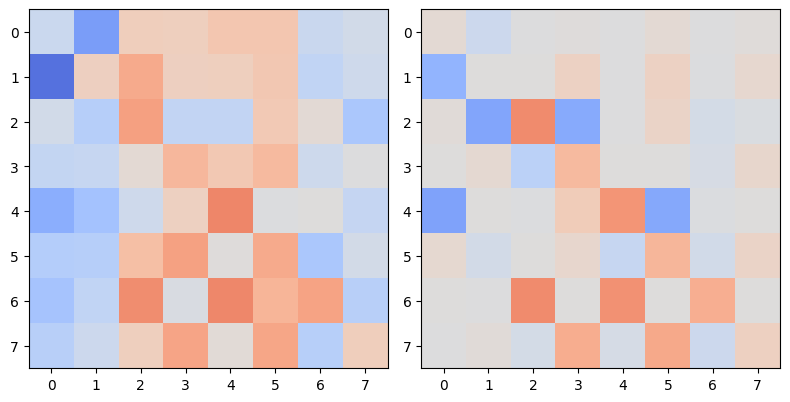

cosine_similarity measure: 0.695
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7944  1.5332
      2        0.7144  1.4990
      3        0.6405  1.5177
      4        0.5733  1.5333
      5        0.5133  1.6139
      6        0.4622  1.5036
      7        0.4225  1.5964
      8        0.3976  1.5911
      9        0.3900  1.5884
     10        0.3863  1.6365
     11        0.3730  1.4951
     12        0.3559  1.5619
     13        0.3438  1.5224
     14        0.3370  1.5999
     15        0.3326  1.5679
     16        0.3282  1.6084
     17        0.3222  1.5927
     18        0.3152  1.5641
     19        0.3072  1.5446
     20        0.2995  1.5482
     21        0.2942  1.5894
     22        0.2920  1.5244
     23        0.2888  1.5380
     24        0.2829  1.5626
     25        0.2785  1.6150
     26        0.2770  1.5823
     27        0.2760  1.5175
     28        0.2740  1.5665
     29        0.2708  1.6061
     30        0.2

    233        0.0712  1.6247
    234        0.0693  1.6828
    235        0.0698  1.5999
    236        0.0720  1.5736
    237        0.0705  1.5819
    238        0.0716  1.4958
    239        0.0727  1.5571
    240        0.0698  1.6350
    241        0.0702  1.5362
    242        0.0727  1.6031
    243        0.0695  1.6142
    244        0.0722  1.5404
    245        0.0706  1.5733
    246        0.0713  1.5341
    247        0.0722  1.5284
    248        0.0690  1.6536
    249        0.0737  1.5951
    250        0.0707  1.5757
    251        0.0714  1.6242
    252        0.0708  1.5606
    253        0.0700  1.6294
    254        0.0722  1.6190
    255        0.0696  1.5823
    256        0.0699  1.5970
    257        0.0691  1.5748
    258        0.0699  1.4797
    259        0.0724  1.5467
    260        0.0730  1.5092
    261        0.0694  1.5465
    262        0.0711  1.5090
    263        0.0754  1.4845
    264        0.0714  1.6392
    265        0.0698  1.6054
    266   

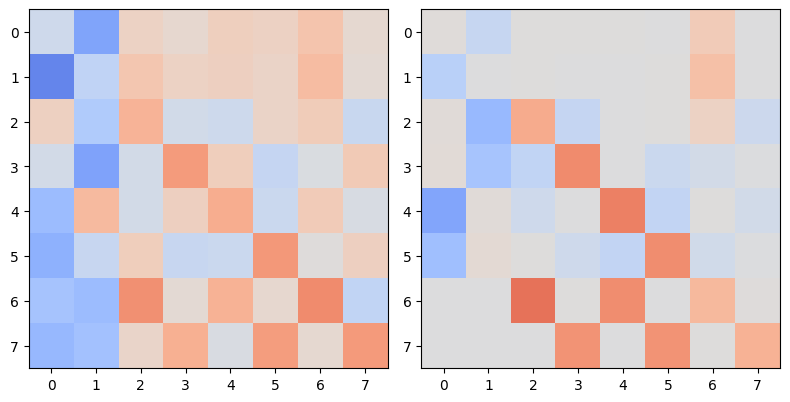

cosine_similarity measure: 0.788
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6744  1.5957
      2        0.6026  1.5988
      3        0.5360  1.5277
      4        0.4738  1.5279
      5        0.4183  1.5478
      6        0.3780  1.5970
      7        0.3653  1.6167
      8        0.3615  1.4963
      9        0.3418  1.4626
     10        0.3255  1.5262
     11        0.3199  1.5131
     12        0.3192  1.5484
     13        0.3188  1.8169
     14        0.3163  1.5668
     15        0.3110  1.5857
     16        0.3041  1.4922
     17        0.2969  1.5922
     18        0.2909  1.5547
     19        0.2867  1.5512
     20        0.2823  1.5758
     21        0.2768  1.5678
     22        0.2702  1.5623
     23        0.2645  1.5516
     24        0.2604  1.4660
     25        0.2567  1.5174
     26        0.2522  1.5323
     27        0.2474  1.5609
     28        0.2427  1.5805
     29        0.2399  1.5219
     30        0.2

    236        0.0732  1.5081
    237        0.0767  1.7476
    238        0.0781  1.7874
    239        0.0751  1.8310
    240        0.0734  1.7153
    241        0.0737  1.6499
    242        0.0731  1.6679
    243        0.0724  1.5967
    244        0.0739  1.6323
    245        0.0733  1.5892
    246        0.0725  1.8365
    247        0.0737  1.7275
    248        0.0745  1.5701
    249        0.0741  1.8720
    250        0.0781  1.9766
    251        0.0746  1.6063
    252        0.0720  1.7756
    253        0.0747  1.7381
    254        0.0714  1.6977
    255        0.0728  1.7566
    256        0.0722  1.5781
    257        0.0741  1.5907
    258        0.0777  1.6599
    259        0.0746  1.8233
    260        0.0725  1.7758
    261        0.0776  1.6562
    262        0.0739  1.5957
    263        0.0748  1.7785
    264        0.0751  1.6383
    265        0.0751  1.8948
    266        0.0717  1.6643
    267        0.0723  1.8172
    268        0.0722  1.8792
    269   

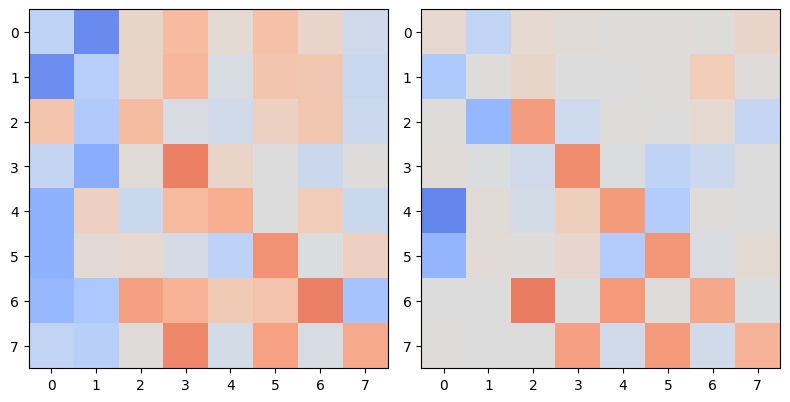

cosine_similarity measure: 0.741
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7339  1.4960
      2        0.6600  1.5001
      3        0.5961  1.4914
      4        0.5395  1.5439
      5        0.4915  1.5656
      6        0.4525  1.6710
      7        0.4237  1.5089
      8        0.4061  1.5061
      9        0.3935  1.5438
     10        0.3800  1.5738
     11        0.3650  1.9618
     12        0.3518  1.8609
     13        0.3421  1.9679
     14        0.3351  1.9119
     15        0.3283  1.8447
     16        0.3216  1.9384
     17        0.3158  1.8524
     18        0.3107  1.8505
     19        0.3059  1.9360
     20        0.2999  1.9031
     21        0.2940  1.9005
     22        0.2898  1.8809
     23        0.2858  1.9339
     24        0.2819  2.0286
     25        0.2780  1.9056
     26        0.2748  1.8920
     27        0.2718  1.9027
     28        0.2685  1.9278
     29        0.2650  1.9410
     30        0.2

    238        0.0820  1.9331
    239        0.0788  1.9552
    240        0.0803  1.9869
    241        0.0747  1.9105
    242        0.0762  1.9094
    243        0.0758  1.9401
    244        0.0745  1.9063
    245        0.0748  1.9107
    246        0.0744  1.9706
    247        0.0740  1.9033
    248        0.0737  1.8654
    249        0.0756  1.9694
    250        0.0769  1.8922
    251        0.0758  1.9090
    252        0.0756  1.9170
    253        0.0778  1.8764
    254        0.0750  1.9266
    255        0.0732  1.8694
    256        0.0807  1.8947
    257        0.0818  1.8808
    258        0.0742  1.8433
    259        0.0744  1.9106
    260        0.0749  1.8328
    261        0.0744  1.9071
    262        0.0791  1.8876
    263        0.0752  1.8158
    264        0.0733  1.9841
    265        0.0775  1.8913
    266        0.0800  1.8884
    267        0.0754  1.8020
    268        0.0731  1.5726
    269        0.0763  1.5655
    270        0.0738  1.6008
    271   

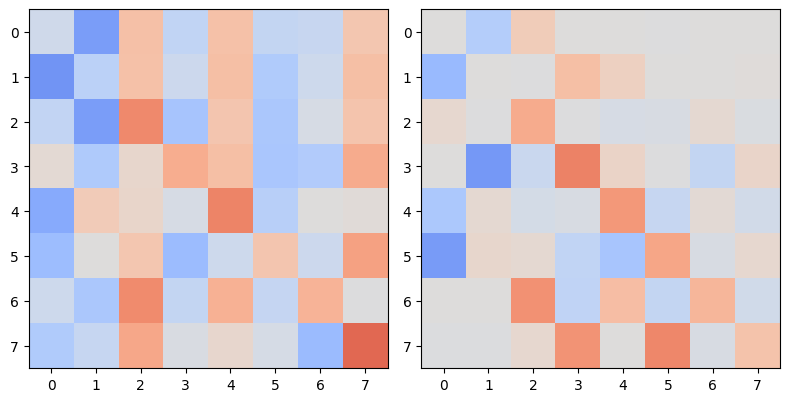

cosine_similarity measure: 0.621
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7040  1.6168
      2        0.6323  1.5275
      3        0.5708  1.5676
      4        0.5200  1.5320
      5        0.4787  1.6173
      6        0.4456  1.5466
      7        0.4223  1.6691
      8        0.4040  1.5641
      9        0.3836  1.5888
     10        0.3631  1.6329
     11        0.3464  1.5618
     12        0.3345  1.6605
     13        0.3246  1.6630
     14        0.3155  1.5841
     15        0.3067  1.5556
     16        0.3000  1.6135
     17        0.2950  1.5597
     18        0.2900  1.6076
     19        0.2859  1.5505
     20        0.2833  1.5975
     21        0.2806  1.5090
     22        0.2770  1.5257
     23        0.2731  1.5594
     24        0.2694  1.6111
     25        0.2650  1.5349
     26        0.2604  1.6366
     27        0.2560  1.5927
     28        0.2525  1.7123
     29        0.2488  1.6302
     30        0.2

    237        0.0794  1.7282
    238        0.0809  1.8189
    239        0.0778  1.7692
    240        0.0824  1.8912
    241        0.0773  1.8480
    242        0.0782  1.7635
    243        0.0819  1.7809
    244        0.0754  1.7168
    245        0.0796  1.6711
    246        0.0756  1.7969
    247        0.0795  1.7649
    248        0.0749  1.6494
    249        0.0778  1.5391
    250        0.0759  1.6068
    251        0.0776  1.5523
    252        0.0826  1.4654
    253        0.0754  1.4889
    254        0.0774  1.5382
    255        0.0766  1.5738
    256        0.0751  1.6042
    257        0.0765  1.5587
    258        0.0764  1.5047
    259        0.0746  1.5131
    260        0.0771  1.4221
    261        0.0774  1.5544
    262        0.0736  1.4608
    263        0.0738  1.5649
    264        0.0798  1.5320
    265        0.0752  1.4658
    266        0.0727  1.4540
    267        0.0755  1.5159
    268        0.0749  1.5229
    269        0.0737  1.6048
    270   

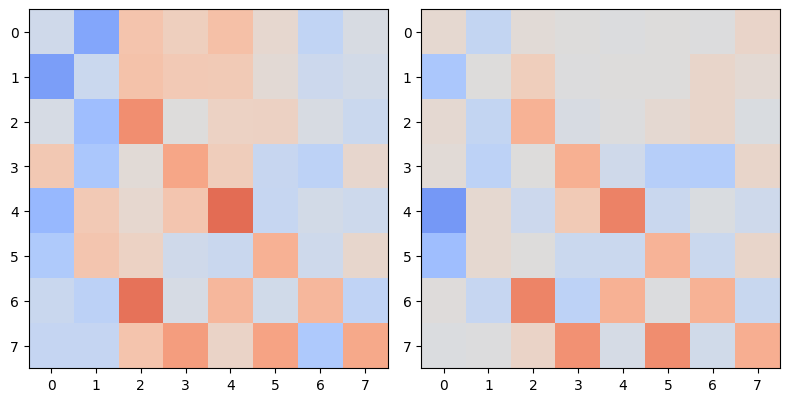

cosine_similarity measure: 0.855
MSE output:
3.819802216037799e-05
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6885  1.8257
      2        0.6257  1.5723
      3        0.5716  1.5947
      4        0.5240  1.5369
      5        0.4812  1.5736
      6        0.4432  1.5482
      7        0.4128  1.5503
      8        0.3935  1.5639
      9        0.3791  1.5597
     10        0.3618  1.5256
     11        0.3450  1.6512
     12        0.3324  1.6916
     13        0.3239  1.8814
     14        0.3165  1.7488
     15        0.3086  1.6765
     16        0.3000  1.9763
     17        0.2912  1.6576
     18        0.2839  1.6894
     19        0.2778  1.7893
     20        0.2707  1.7271
     21        0.2639  1.7877
     22        0.2589  1.9929
     23        0.2555  1.7290
     24        0.2521  1.5718
     25        0.2483  1.6536
     26        0.2446  1.6061
     27        0.2418  1.8049
     28        0.2389  1.7995
     29       

    241        0.0773  1.7821
    242        0.0725  1.9704
    243        0.0719  1.8403
    244        0.0719  1.8678
    245        0.0707  1.7259
    246        0.0714  1.7585
    247        0.0723  1.9052
    248        0.0711  1.6547
    249        0.0719  1.7586
    250        0.0718  1.6613
    251        0.0707  1.6470
    252        0.0705  1.7786
    253        0.0708  1.7875
    254        0.0726  1.8054
    255        0.0722  1.7926
    256        0.0712  1.7049
    257        0.0746  1.7592
    258        0.0716  1.7851
    259        0.0701  1.6089
    260        0.0703  1.6514
    261        0.0718  1.8132
    262        0.0702  1.7199
    263        0.0709  1.7617
    264        0.0712  1.7488
    265        0.0719  1.8332
    266        0.0732  1.8137
    267        0.0733  1.7550
    268        0.0704  1.6222
    269        0.0720  1.7206
    270        0.0760  1.7048
    271        0.0705  1.6986
    272        0.0731  1.6767
    273        0.0724  1.6724
    274   

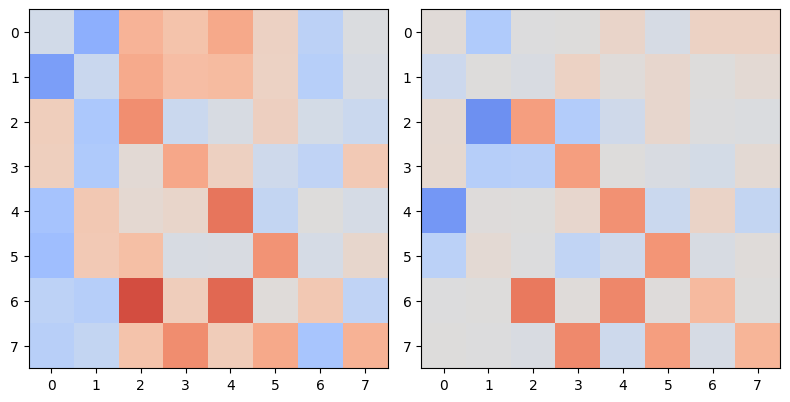

cosine_similarity measure: 0.771
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7330  1.7597
      2        0.6631  1.5724
      3        0.5960  1.6851
      4        0.5342  1.7509
      5        0.4788  1.7896
      6        0.4338  1.6056
      7        0.4078  1.8154
      8        0.4036  1.8264
      9        0.3872  1.7492
     10        0.3632  1.7027
     11        0.3471  1.7705
     12        0.3392  1.8030
     13        0.3346  1.7670
     14        0.3301  1.7032
     15        0.3249  1.6097
     16        0.3184  1.6145
     17        0.3110  1.6298
     18        0.3045  1.6911
     19        0.3000  1.8051
     20        0.2983  2.0134
     21        0.2967  1.6951
     22        0.2917  1.8134
     23        0.2862  1.8850
     24        0.2823  1.7260
     25        0.2800  1.7801
     26        0.2780  1.7376
     27        0.2754  1.5812
     28        0.2720  1.6862
     29        0.2684  1.8609
     30        0.2

    236        0.0813  1.5905
    237        0.0810  1.6212
    238        0.0818  1.5932
    239        0.0837  1.6036
    240        0.0792  1.6285
    241        0.0803  1.5929
    242        0.0813  1.5789
    243        0.0792  1.6126
    244        0.0782  1.5672
    245        0.0805  1.5321
    246        0.0923  1.5473
    247        0.1074  1.5781
    248        0.0862  1.5900
    249        0.1130  1.5951
    250        0.1026  1.5871
    251        0.0962  1.6631
    252        0.1171  1.5398
    253        0.0958  1.5756
    254        0.0948  1.5994
    255        0.1009  1.5928
    256        0.0962  1.5886
    257        0.0915  1.6573
    258        0.0913  1.5867
    259        0.0991  1.6195
    260        0.0891  1.6038
    261        0.0894  1.5643
    262        0.0959  1.6066
    263        0.0892  1.5063
    264        0.0866  1.6359
    265        0.0898  1.6328
    266        0.0863  1.5632
    267        0.0835  1.5934
    268        0.0871  1.6125
    269   

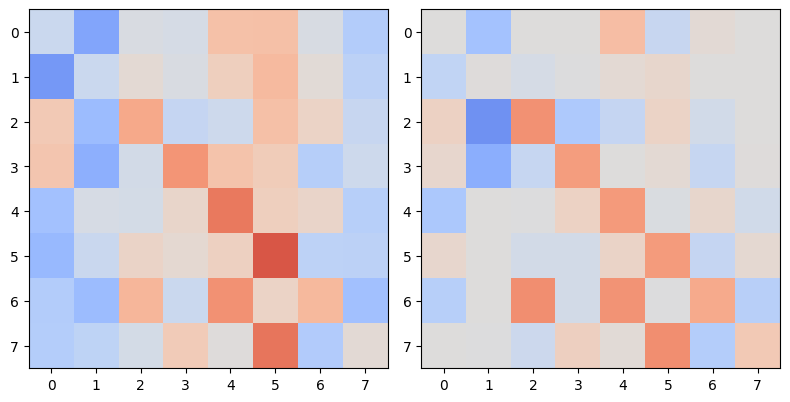

cosine_similarity measure: 0.803
MSE output:
0.0003572248456351504
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7675  1.7948
      2        0.6948  1.6155
      3        0.6267  1.5763
      4        0.5629  1.5491
      5        0.5061  1.6236
      6        0.4592  1.5338
      7        0.4251  1.5631
      8        0.4058  1.5795
      9        0.3956  1.5450
     10        0.3803  1.6315
     11        0.3618  1.6098
     12        0.3469  1.6139
     13        0.3373  1.6435
     14        0.3301  1.5781
     15        0.3228  1.5944
     16        0.3145  1.6671
     17        0.3048  1.5741
     18        0.2957  1.6081
     19        0.2897  1.6194
     20        0.2878  1.5814
     21        0.2844  1.6074
     22        0.2790  1.5546
     23        0.2762  1.5696
     24        0.2753  1.6120
     25        0.2735  1.5781
     26        0.2696  1.6439
     27        0.2651  1.5943
     28        0.2616  1.6818
     29       

    240        0.0885  1.6532
    241        0.0884  1.6437
    242        0.0876  1.6037
    243        0.0875  1.6204
    244        0.0862  1.6026
    245        0.0886  1.5940
    246        0.0893  1.6331
    247        0.0899  1.5565
    248        0.0901  1.5481
    249        0.0898  1.5495
    250        0.0953  1.6187
    251        0.0880  1.5893
    252        0.0979  1.6732
    253        0.0856  1.6179
    254        0.0965  1.6549
    255        0.0891  1.6027
    256        0.1051  1.6486
    257        0.0977  1.6204
    258        0.0983  1.6336
    259        0.1062  1.6677
    260        0.0946  1.6242
    261        0.0965  1.6125
    262        0.1020  1.6477
    263        0.0920  1.6004
    264        0.0951  1.6522
    265        0.0984  1.6472
    266        0.0943  1.6182
    267        0.0896  1.5750
    268        0.0955  1.6498
    269        0.0901  1.5931
    270        0.0922  1.6251
    271        0.1014  1.6762
    272        0.0884  1.6570
    273   

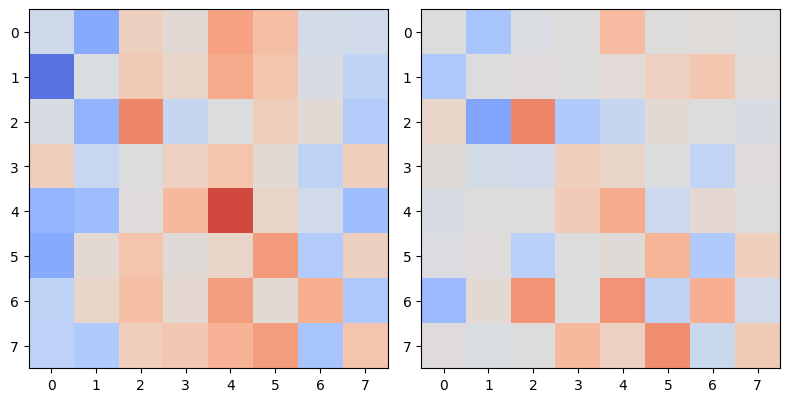

cosine_similarity measure: 0.729
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7926  1.9530
      2        0.7126  1.6520
      3        0.6397  1.6011
      4        0.5752  1.6147
      5        0.5198  1.6885
      6        0.4737  1.5752
      7        0.4388  1.5577
      8        0.4158  1.6235
      9        0.4022  1.5361
     10        0.3885  1.5645
     11        0.3696  1.6520
     12        0.3508  1.5951
     13        0.3370  1.6012
     14        0.3280  1.5973
     15        0.3220  1.6178
     16        0.3170  1.6047
     17        0.3112  1.5920
     18        0.3049  1.5189
     19        0.2994  1.5865
     20        0.2953  1.5707
     21        0.2908  1.6306
     22        0.2850  1.5743
     23        0.2806  1.5261
     24        0.2779  1.5830
     25        0.2758  1.5525
     26        0.2729  1.6376
     27        0.2700  1.5846
     28        0.2676  1.6124
     29        0.2660  1.5426
     30        0.2

    237        0.0771  1.8381
    238        0.0784  1.5882
    239        0.0750  1.5745
    240        0.0749  1.4986
    241        0.0760  1.5815
    242        0.0740  1.5834
    243        0.0755  1.5689
    244        0.0761  1.6018
    245        0.0776  1.5689
    246        0.0865  1.5661
    247        0.0877  1.5422
    248        0.0747  1.5694
    249        0.0857  1.5292
    250        0.0777  1.5168
    251        0.0798  1.6353
    252        0.0764  1.8409
    253        0.0793  1.6591
    254        0.0772  1.7430
    255        0.0754  1.6775
    256        0.0793  1.6681
    257        0.0750  1.8263
    258        0.0746  1.6405
    259        0.0805  1.7009
    260        0.0858  1.6294
    261        0.0731  1.6116
    262        0.0867  1.6072
    263        0.0788  1.5602
    264        0.0795  1.5383
    265        0.0799  1.6492
    266        0.0768  1.5566
    267        0.0777  1.5892
    268        0.0762  1.6160
    269        0.0750  1.5813
    270   

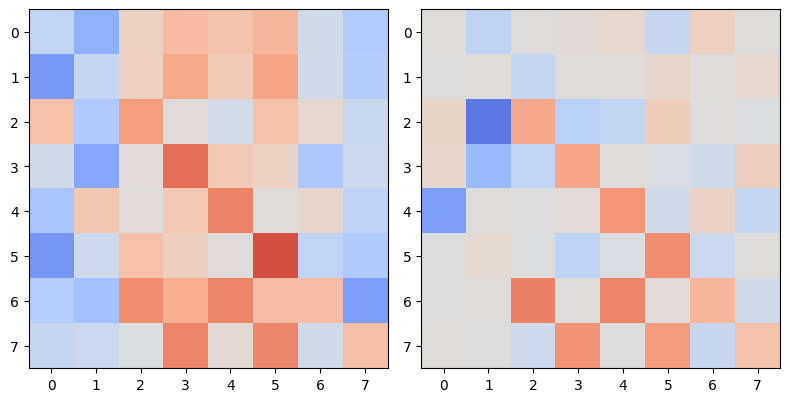

cosine_similarity measure: 0.677
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7923  1.6441
      2        0.7116  1.7960
      3        0.6427  1.7548
      4        0.5845  1.9613
      5        0.5347  1.7732
      6        0.4919  1.7985
      7        0.4563  1.7470
      8        0.4287  1.7152
      9        0.4122  1.6285
     10        0.4046  1.5821
     11        0.3945  1.6144
     12        0.3778  1.6378
     13        0.3609  1.5973
     14        0.3478  1.5941
     15        0.3387  1.6338
     16        0.3306  1.5733
     17        0.3226  1.5646
     18        0.3145  1.5846
     19        0.3057  1.5767
     20        0.2978  1.5824
     21        0.2924  1.5486
     22        0.2889  1.5735
     23        0.2827  1.6184
     24        0.2745  1.6279
     25        0.2690  1.5208
     26        0.2657  1.6131
     27        0.2625  1.5998
     28        0.2582  1.5353
     29        0.2543  1.5531
     30        0.2

    232        0.0707  1.5653
    233        0.0726  1.6114
    234        0.0717  1.5508
    235        0.0711  1.5748
    236        0.0723  1.5213
    237        0.0720  1.6545
    238        0.0713  1.5079
    239        0.0713  1.5888
    240        0.0702  1.7317
    241        0.0697  1.7326
    242        0.0719  1.5725
    243        0.0714  1.6494
    244        0.0701  1.6352
    245        0.0708  1.6388
    246        0.0705  1.6203
    247        0.0695  1.8718
    248        0.0747  1.7326
    249        0.0774  1.7423
    250        0.0709  1.6349
    251        0.0747  1.5378
    252        0.0697  1.5621
    253        0.0752  1.7478
    254        0.0719  1.5375
    255        0.0732  1.9570
    256        0.0714  1.7223
    257        0.0738  1.7960
    258        0.0748  1.6587
    259        0.0704  1.7262
    260        0.0753  1.9906
    261        0.0723  1.6856
    262        0.0699  1.5833
    263        0.0754  1.5355
    264        0.0699  1.5657
    265   

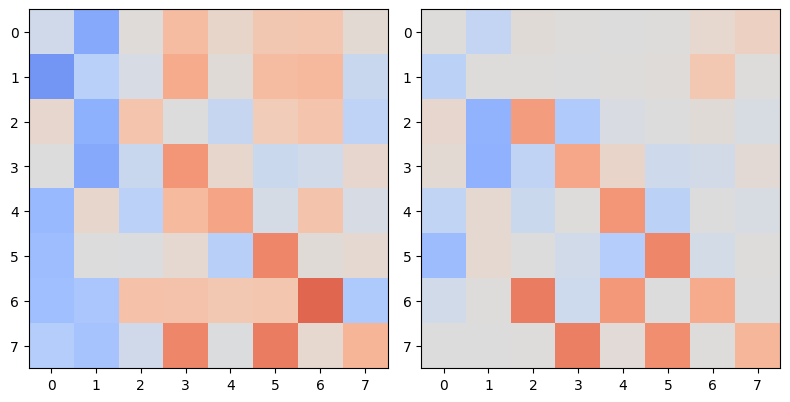

cosine_similarity measure: 0.761
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7870  1.5568
      2        0.7171  1.5286
      3        0.6548  1.5402
      4        0.5999  1.4875
      5        0.5534  1.5618
      6        0.5159  1.5644
      7        0.4881  1.5904
      8        0.4690  1.6961
      9        0.4522  1.6588
     10        0.4350  1.5653
     11        0.4175  1.6741
     12        0.4014  1.6451
     13        0.3877  1.6758
     14        0.3750  1.7708
     15        0.3628  1.6329
     16        0.3508  1.6179
     17        0.3397  1.6460
     18        0.3309  1.6905
     19        0.3227  1.6742
     20        0.3143  1.5672
     21        0.3087  1.6205
     22        0.3042  1.6410
     23        0.3001  1.6138
     24        0.2955  1.6060
     25        0.2913  1.5535
     26        0.2874  1.5172
     27        0.2829  1.5598
     28        0.2788  1.5322
     29        0.2750  1.5501
     30        0.2

    243        0.0891  1.8016
    244        0.0852  1.8382
    245        0.0881  1.9105
    246        0.0838  1.8215
    247        0.0897  1.6491
    248        0.0881  1.8111
    249        0.0852  1.7266
    250        0.0822  1.5906
    251        0.0861  1.6370
    252        0.0802  1.6427
    253        0.0818  1.7010
    254        0.0815  1.6154
    255        0.0809  1.5553
    256        0.0833  1.6655
    257        0.0805  1.8091
    258        0.0843  1.5621
    259        0.0808  1.5778
    260        0.0787  1.5352
    261        0.0814  1.5849
    262        0.0803  1.6087
    263        0.0826  1.6694
    264        0.0848  1.5593
    265        0.0818  1.7441
    266        0.0841  1.8079
    267        0.0805  1.6773
    268        0.0803  1.6791
    269        0.0831  1.6498
    270        0.0813  1.6648
    271        0.0801  1.8176
    272        0.0804  1.7954
    273        0.0818  1.7858
    274        0.0843  1.7780
    275        0.0798  1.5430
    276   

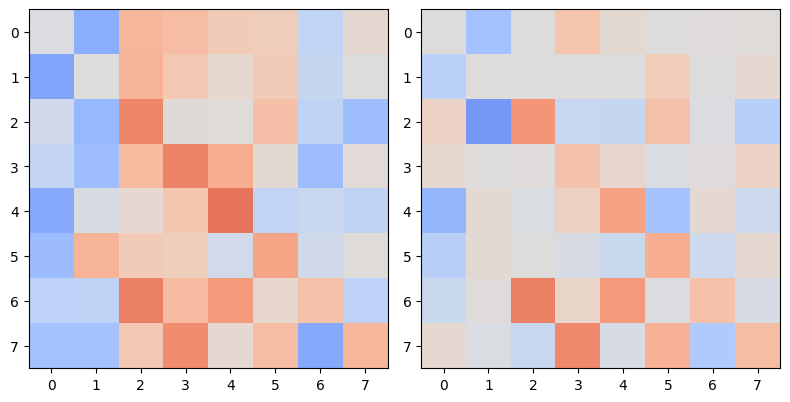

cosine_similarity measure: 0.787
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8478  1.5489
      2        0.7703  1.5530
      3        0.7005  1.5517
      4        0.6398  1.4847
      5        0.5871  1.5990
      6        0.5427  560.5320
      7        0.5064  1.8471
      8        0.4791  1.4683
      9        0.4606  1.5796
     10        0.4473  1.4685
     11        0.4331  1.5995
     12        0.4159  1.5270
     13        0.4000  1.5003
     14        0.3874  1.5302
     15        0.3774  1.5130
     16        0.3681  1.5743
     17        0.3586  1.5229
     18        0.3484  1.7201
     19        0.3375  1.6075
     20        0.3272  1.7391
     21        0.3182  1.6028
     22        0.3117  1.6623
     23        0.3053  1.5102
     24        0.2967  1.6103
     25        0.2889  1.6040
     26        0.2836  1.4799
     27        0.2794  1.5398
     28        0.2747  1.5789
     29        0.2702  1.6610
     30        0

    237        0.0808  1.7399
    238        0.0889  1.6967
    239        0.0882  1.9531
    240        0.0801  1.6412
    241        0.0907  1.5693
    242        0.0816  1.6076
    243        0.0859  1.6343
    244        0.0795  1.5280
    245        0.0827  1.5565
    246        0.0794  1.5558
    247        0.0810  1.6076
    248        0.0781  1.6378
    249        0.0808  1.6414
    250        0.0779  1.7592
    251        0.0836  1.5633
    252        0.0799  1.5985
    253        0.0787  1.5813
    254        0.0760  1.6956
    255        0.0812  1.5550
    256        0.0769  1.6486
    257        0.0760  1.5373
    258        0.0813  1.6696
    259        0.0757  1.5986
    260        0.0747  1.6127
    261        0.0793  1.5735
    262        0.0756  1.5931
    263        0.0740  1.6354
    264        0.0764  1.7210
    265        0.0759  1.6456
    266        0.0738  1.5726
    267        0.0756  1.5360
    268        0.0795  1.6019
    269        0.0799  1.6613
    270   

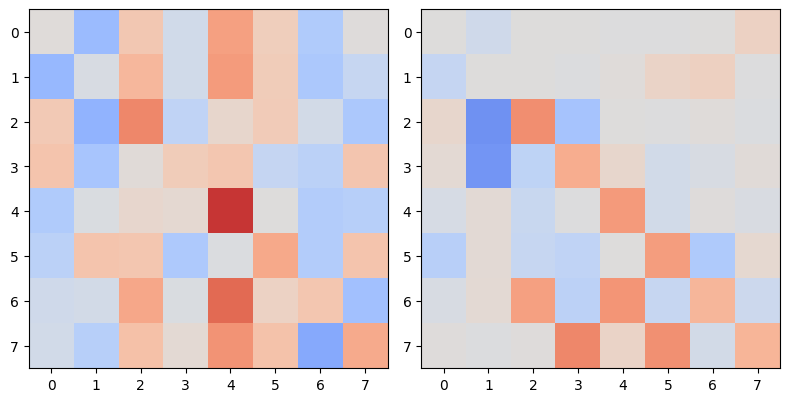

cosine_similarity measure: 0.656
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7156  1.6340
      2        0.6499  1.7028
      3        0.5889  1.6369
      4        0.5314  1.7537
      5        0.4798  1.6366
      6        0.4374  1.6530
      7        0.4128  1.6326
      8        0.4011  1.7471
      9        0.3797  1.6686
     10        0.3588  1.6292
     11        0.3461  1.6923
     12        0.3384  1.7325
     13        0.3315  1.6902
     14        0.3234  1.6213
     15        0.3141  1.7702
     16        0.3045  1.7544
     17        0.2965  1.7151
     18        0.2918  1.8909
     19        0.2891  1.8361
     20        0.2838  1.7068
     21        0.2768  1.6007
     22        0.2719  1.5345
     23        0.2692  1.8186
     24        0.2667  1.5278
     25        0.2634  1.5935
     26        0.2599  1.6483
     27        0.2571  1.8896
     28        0.2556  1.9193
     29        0.2535  1.8590
     30        0.2

    238        0.0735  1.7201
    239        0.0704  1.8654
    240        0.0759  1.5233
    241        0.0734  1.6854
    242        0.0699  1.8647
    243        0.0738  1.7960
    244        0.0716  1.5991
    245        0.0707  1.6129
    246        0.0740  1.6331
    247        0.0710  1.5186
    248        0.0732  1.5669
    249        0.0769  1.7230
    250        0.0719  1.6818
    251        0.0703  1.6316
    252        0.0702  1.6707
    253        0.0710  1.9181
    254        0.0713  1.6570
    255        0.0696  1.5697
    256        0.0709  1.6029
    257        0.0710  1.7603
    258        0.0713  1.9795
    259        0.0706  1.7960
    260        0.0697  1.7158
    261        0.0694  1.6526
    262        0.0694  1.7415
    263        0.0706  1.5784
    264        0.0709  1.5454
    265        0.0696  1.5006
    266        0.0697  1.8327
    267        0.0689  1.8702
    268        0.0678  1.8252
    269        0.0699  1.9089
    270        0.0696  1.7630
    271   

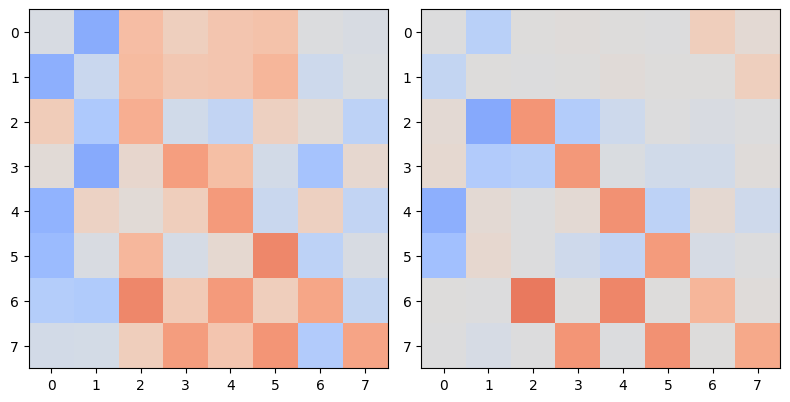

cosine_similarity measure: 0.784
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6977  1.6755
      2        0.6320  1.7717
      3        0.5753  1.8391
      4        0.5248  1.8542
      5        0.4795  1.8952
      6        0.4417  2.1040
      7        0.4165  1.8777
      8        0.4038  1.7038
      9        0.3846  1.6938
     10        0.3612  1.9627
     11        0.3429  1.8473
     12        0.3310  1.6391
     13        0.3222  2.0478
     14        0.3135  1.8966
     15        0.3043  1.5707
     16        0.2960  1.5739
     17        0.2916  1.5591
     18        0.2883  1.5192
     19        0.2812  1.7477
     20        0.2763  1.5847
     21        0.2744  1.9227
     22        0.2717  1.8289
     23        0.2673  1.6119
     24        0.2634  1.4815
     25        0.2620  1.9164
     26        0.2606  1.5440
     27        0.2571  1.5925
     28        0.2548  1.5699
     29        0.2534  1.6040
     30        0.2

    234        0.0746  1.6623
    235        0.0739  1.5151
    236        0.0746  1.5623
    237        0.0737  1.5805
    238        0.0772  1.6649
    239        0.0819  1.7321
    240        0.0751  1.6461
    241        0.0741  1.5324
    242        0.0772  1.5675
    243        0.0749  1.5792
    244        0.0732  1.5774
    245        0.0732  1.6907
    246        0.0769  1.6192
    247        0.0792  1.6564
    248        0.0780  1.6247
    249        0.0747  1.6773
    250        0.0733  1.7231
    251        0.0744  1.6215
    252        0.0735  1.5609
    253        0.0731  1.6931
    254        0.0762  1.6729
    255        0.0800  1.7037
    256        0.0741  1.7019
    257        0.0740  1.6347
    258        0.0744  1.6353
    259        0.0731  1.5485
    260        0.0739  1.6172
    261        0.0752  1.6105
    262        0.0734  1.5665
    263        0.0731  1.6183
    264        0.0736  1.5221
    265        0.0737  1.5431
    266        0.0721  1.7125
    267   

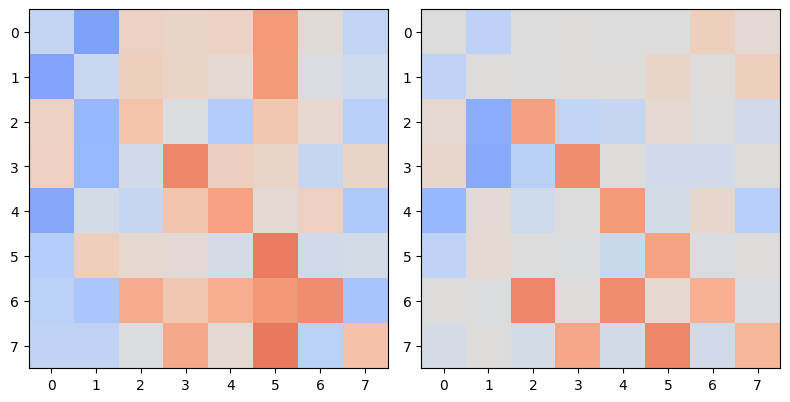

cosine_similarity measure: 0.796
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7533  1.6771
      2        0.6782  1.6483
      3        0.6124  1.5505
      4        0.5523  1.5721
      5        0.4980  1.7039
      6        0.4516  1.6306
      7        0.4154  1.6035
      8        0.3933  1.6684
      9        0.3861  1.6349
     10        0.3774  1.6309
     11        0.3595  1.6296
     12        0.3420  1.6057
     13        0.3300  1.6718
     14        0.3227  1.6067
     15        0.3165  1.6153
     16        0.3096  1.5743
     17        0.3015  1.5841
     18        0.2930  1.6144
     19        0.2860  1.7574
     20        0.2823  1.5450
     21        0.2795  1.5918
     22        0.2731  1.6062
     23        0.2669  1.7158
     24        0.2640  1.7102
     25        0.2625  1.5638
     26        0.2604  1.5495
     27        0.2570  1.5678
     28        0.2537  1.6541
     29        0.2519  1.5827
     30        0.2

    235        0.0809  1.6181
    236        0.0788  1.6914
    237        0.0800  1.5511
    238        0.0799  1.5786
    239        0.0771  1.6069
    240        0.0791  1.6471
    241        0.0793  1.7455
    242        0.0776  1.6524
    243        0.0790  1.7505
    244        0.0772  1.5622
    245        0.0762  1.6275
    246        0.0781  1.5856
    247        0.0779  1.5453
    248        0.0791  1.6628
    249        0.0775  1.5638
    250        0.0762  1.6173
    251        0.0775  1.5409
    252        0.0795  1.7041
    253        0.0796  1.7001
    254        0.0767  1.6684
    255        0.0761  1.5727
    256        0.0765  1.5325
    257        0.0763  1.6063
    258        0.0769  1.5892
    259        0.0766  1.6748
    260        0.0763  1.6295
    261        0.0759  1.5942
    262        0.0764  1.5788
    263        0.0761  1.5546
    264        0.0755  1.6390
    265        0.0759  1.5780
    266        0.0741  1.6438
    267        0.0750  1.6051
    268   

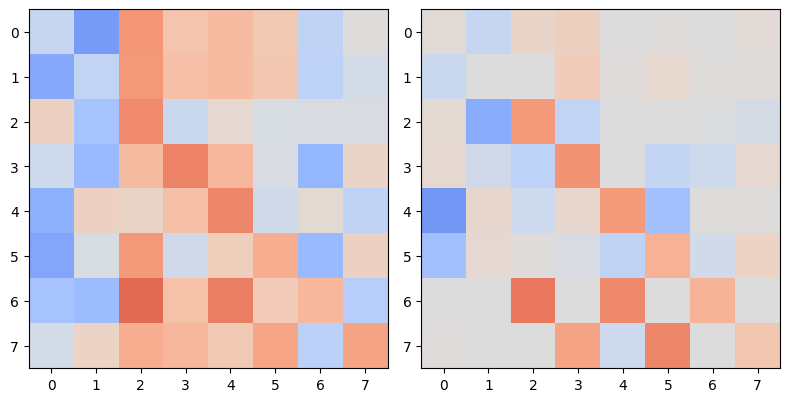

cosine_similarity measure: 0.702
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7894  1.7072
      2        0.7086  1.5673
      3        0.6377  1.4875
      4        0.5782  1.5308
      5        0.5290  1.5042
      6        0.4888  1.5090
      7        0.4557  1.5688
      8        0.4307  1.5860
      9        0.4141  1.5264
     10        0.4030  1.5254
     11        0.3905  1.6314
     12        0.3751  1.5757
     13        0.3606  1.5077
     14        0.3500  1.7087
     15        0.3423  1.4522
     16        0.3357  1.5300
     17        0.3288  1.5096
     18        0.3212  1.5231
     19        0.3139  1.6253
     20        0.3090  1.6872
     21        0.3061  1.7047
     22        0.3014  1.5979
     23        0.2950  1.5201
     24        0.2903  1.6623
     25        0.2873  1.5763
     26        0.2842  1.5676
     27        0.2805  1.5367
     28        0.2770  1.7569
     29        0.2745  1.5854
     30        0.2

    236        0.0788  1.5844
    237        0.0752  1.6884
    238        0.0767  1.6498
    239        0.0746  1.7037
    240        0.0760  1.5900
    241        0.0766  1.6560
    242        0.0746  1.5305
    243        0.0782  1.6037
    244        0.0757  1.6343
    245        0.0747  1.7259
    246        0.0744  1.5961
    247        0.0743  1.6815
    248        0.0763  1.5742
    249        0.0759  1.4967
    250        0.0756  1.5992
    251        0.0753  1.6137
    252        0.0777  1.5514
    253        0.0787  1.5994
    254        0.0747  1.6936
    255        0.0772  1.5665
    256        0.0749  1.5748
    257        0.0745  1.5556
    258        0.0761  1.6029
    259        0.0739  1.5520
    260        0.0751  1.5327
    261        0.0746  1.6316
    262        0.0738  1.5587
    263        0.0731  1.6533
    264        0.0754  1.6227
    265        0.0740  1.5905
    266        0.0727  1.6256
    267        0.0734  1.5517
    268        0.0735  1.6177
    269   

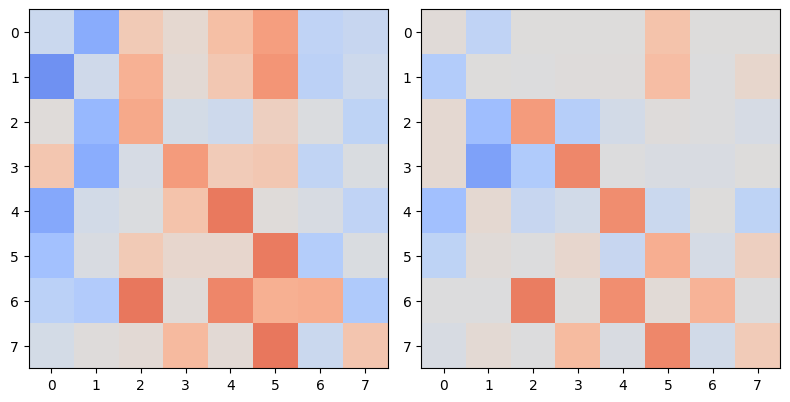

cosine_similarity measure: 0.825
MSE output:
1.8806168972229e-05
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7942  1.8372
      2        0.7166  1.5652
      3        0.6474  1.5450
      4        0.5860  1.5489
      5        0.5330  1.5759
      6        0.4881  1.6109
      7        0.4507  1.5557
      8        0.4218  1.6704
      9        0.4019  1.6876
     10        0.3920  1.5993
     11        0.3857  1.6342
     12        0.3746  1.6695
     13        0.3602  1.5395
     14        0.3475  1.6924
     15        0.3378  1.6134
     16        0.3304  1.6012
     17        0.3239  1.6664
     18        0.3168  1.6076
     19        0.3091  1.5591
     20        0.3011  1.6005
     21        0.2935  1.6289
     22        0.2876  1.6819
     23        0.2834  1.7123
     24        0.2794  1.5766
     25        0.2733  1.6406
     26        0.2679  1.5035
     27        0.2643  1.6013
     28        0.2613  1.6404
     29        0

    232        0.0820  1.5918
    233        0.0793  1.6326
    234        0.0804  1.5814
    235        0.0800  1.6646
    236        0.0815  1.6904
    237        0.0796  1.6382
    238        0.0824  1.6631
    239        0.0826  1.6037
    240        0.0774  1.5981
    241        0.0790  1.6744
    242        0.0786  1.6253
    243        0.0764  1.6987
    244        0.0791  1.6097
    245        0.0769  1.6116
    246        0.0780  1.5805
    247        0.0771  1.5609
    248        0.0770  1.5453
    249        0.0810  1.5539
    250        0.0792  1.5776
    251        0.0751  1.5799
    252        0.0785  1.5529
    253        0.0777  1.6249
    254        0.0760  1.6208
    255        0.0789  1.6431
    256        0.0764  1.6137
    257        0.0773  1.6620
    258        0.0768  1.6139
    259        0.0747  1.6151
    260        0.0750  1.7400
    261        0.0743  1.8364
    262        0.0755  1.8348
    263        0.0748  1.8584
    264        0.0744  1.8286
    265   

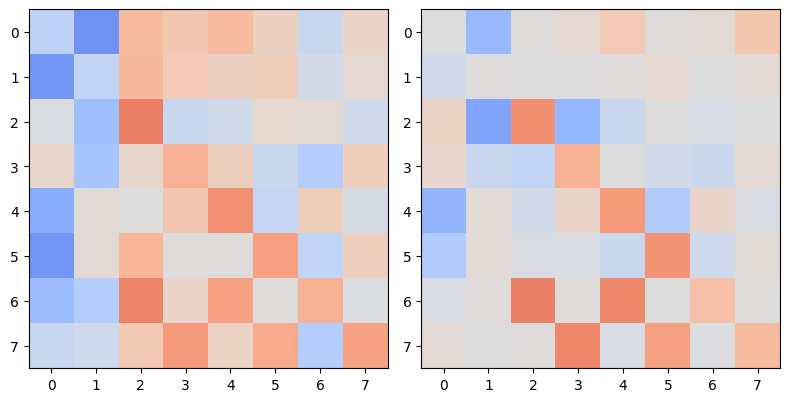

cosine_similarity measure: 0.801
MSE output:
6.925680457905417e-05
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7238  1.8176
      2        0.6564  1.5573
      3        0.5966  1.5730
      4        0.5431  1.6008
      5        0.4964  1.4919
      6        0.4587  1.6060
      7        0.4322  1.5324
      8        0.4130  1.5475
      9        0.3918  1.6060
     10        0.3696  1.6008
     11        0.3536  1.5461
     12        0.3445  1.4823
     13        0.3391  1.5393
     14        0.3338  1.5767
     15        0.3277  1.5727
     16        0.3211  1.5783
     17        0.3152  1.5369
     18        0.3092  1.5611
     19        0.3030  1.6509
     20        0.2978  1.5495
     21        0.2939  1.6399
     22        0.2898  1.5364
     23        0.2853  1.5907
     24        0.2806  1.5905
     25        0.2765  1.6339
     26        0.2727  1.6175
     27        0.2689  1.5951
     28        0.2655  1.5461
     29       

    236        0.0780  1.6819
    237        0.0824  1.6239
    238        0.0789  1.5835
    239        0.0734  1.6802
    240        0.0771  1.6386
    241        0.0775  1.5411
    242        0.0745  1.6075
    243        0.0757  1.4825
    244        0.0749  1.7728
    245        0.0757  1.7420
    246        0.0736  1.8518
    247        0.0753  1.7845
    248        0.0736  1.6223
    249        0.0732  1.6610
    250        0.0751  1.6606
    251        0.0749  1.6275
    252        0.0756  1.6446
    253        0.0771  1.6015
    254        0.0747  1.5094
    255        0.0732  1.7072
    256        0.0714  1.5291
    257        0.0732  1.5719
    258        0.0724  1.6464
    259        0.0726  1.7897
    260        0.0739  1.6677
    261        0.0765  1.5550
    262        0.0758  1.5670
    263        0.0765  1.8421
    264        0.0742  1.6077
    265        0.0741  1.8078
    266        0.0786  1.6188
    267        0.0741  1.6007
    268        0.0782  1.5941
    269   

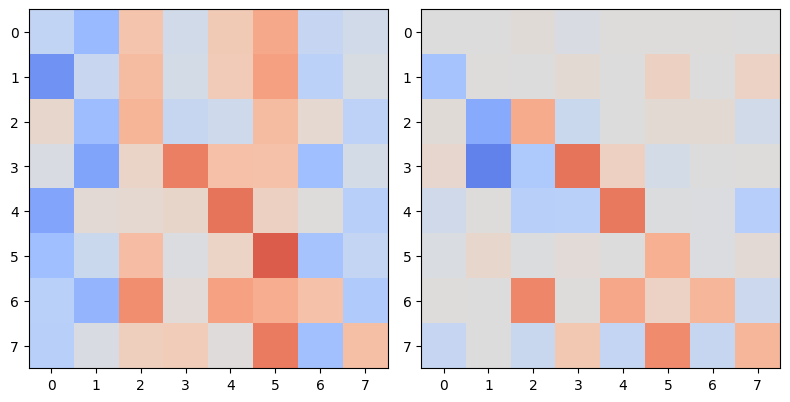

cosine_similarity measure: 0.72
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7437  1.7464
      2        0.6676  1.8255
      3        0.6006  1.7427
      4        0.5422  1.6759
      5        0.4914  1.9021
      6        0.4502  1.8023
      7        0.4235  1.8863
      8        0.4144  1.9540
      9        0.4023  1.7801
     10        0.3801  1.8426
     11        0.3605  1.7013
     12        0.3478  1.8002
     13        0.3393  1.6282
     14        0.3320  1.5702
     15        0.3245  1.4984
     16        0.3158  1.5636
     17        0.3066  1.6149
     18        0.2989  1.8297
     19        0.2945  1.9473
     20        0.2924  1.6802
     21        0.2862  1.7118
     22        0.2789  1.6665
     23        0.2748  1.5729
     24        0.2730  1.7178
     25        0.2714  1.8411
     26        0.2684  1.7191
     27        0.2648  1.7856
     28        0.2621  1.6143
     29        0.2611  1.8402
     30        0.25

    235        0.0717  1.8155
    236        0.0744  1.5990
    237        0.0750  1.5375
    238        0.0750  1.6040
    239        0.0723  1.5543
    240        0.0731  1.6941
    241        0.0770  1.8040
    242        0.0720  1.7174
    243        0.0714  1.7716
    244        0.0724  1.9020
    245        0.0707  1.7432
    246        0.0699  1.9470
    247        0.0717  1.6968
    248        0.0704  1.7929
    249        0.0720  1.7111
    250        0.0722  1.6701
    251        0.0706  1.5383
    252        0.0701  1.5540
    253        0.0716  1.7212
    254        0.0726  1.8466
    255        0.0729  1.8559
    256        0.0725  1.8028
    257        0.0708  1.9339
    258        0.0752  1.8331
    259        0.0748  1.7455
    260        0.0702  1.8971
    261        0.0722  1.7195
    262        0.0708  1.6663
    263        0.0707  1.7371
    264        0.0732  1.7731
    265        0.0701  1.7616
    266        0.0749  1.6965
    267        0.0718  1.8409
    268   

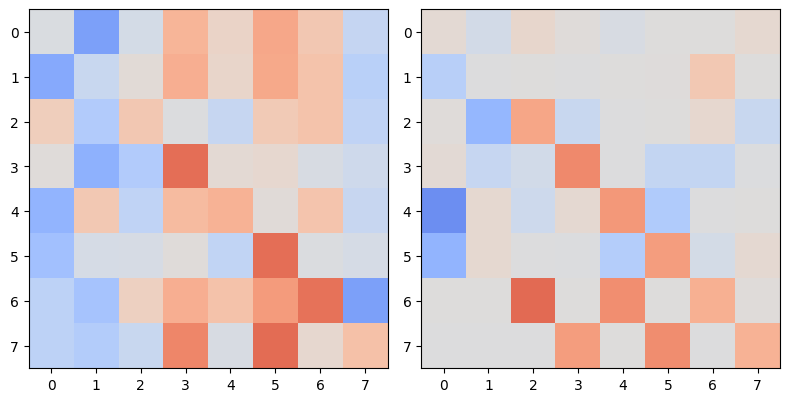

cosine_similarity measure: 0.661
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5839  1.8213
      2        0.5263  1.6501
      3        0.4723  1.8730
      4        0.4207  1.8273
      5        0.3762  1.6252
      6        0.3574  1.5677
      7        0.3690  1.6539
      8        0.3489  1.5939
      9        0.3257  1.5389
     10        0.3144  1.5912
     11        0.3102  1.7228
     12        0.3067  1.6970
     13        0.3021  1.5751
     14        0.2948  1.5907
     15        0.2862  1.6716
     16        0.2772  1.8853
     17        0.2707  1.7552
     18        0.2680  1.8468
     19        0.2679  1.7903
     20        0.2639  1.7641
     21        0.2568  1.8130
     22        0.2519  1.7805
     23        0.2503  1.8050
     24        0.2494  1.7913
     25        0.2480  1.8661
     26        0.2454  1.8517
     27        0.2417  1.8125
     28        0.2381  1.6345
     29        0.2358  1.7538
     30        0.2

    237        0.0683  1.5754
    238        0.0706  1.6000
    239        0.0715  1.7049
    240        0.0675  1.7791
    241        0.0722  1.7846
    242        0.0726  1.7643
    243        0.0677  1.8537
    244        0.0696  1.8052
    245        0.0704  1.7399
    246        0.0676  1.5761
    247        0.0709  1.6795
    248        0.0680  1.9254
    249        0.0706  1.7600
    250        0.0716  1.6104
    251        0.0682  1.6913
    252        0.0675  1.8468
    253        0.0695  1.8456
    254        0.0673  1.8570
    255        0.0689  1.8919
    256        0.0682  1.6621
    257        0.0721  1.6002
    258        0.0699  1.7416
    259        0.0701  1.8549
    260        0.0710  1.8936
    261        0.0671  1.7500
    262        0.0688  1.7716
    263        0.0684  1.7580
    264        0.0677  1.7746
    265        0.0661  1.6804
    266        0.0671  1.9615
    267        0.0676  1.8681
    268        0.0664  1.7723
    269        0.0664  1.6606
    270   

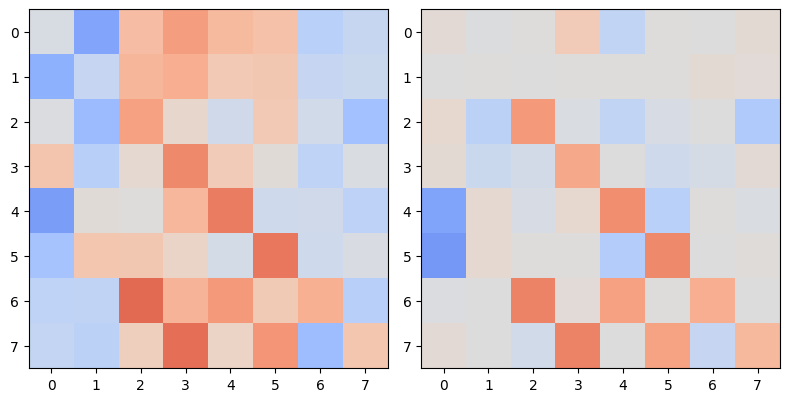

cosine_similarity measure: 0.756
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7221  1.6590
      2        0.6505  1.7452
      3        0.5889  1.7285
      4        0.5356  1.8777
      5        0.4910  1.6776
      6        0.4554  1.5732
      7        0.4300  1.7931
      8        0.4115  1.7542
      9        0.3920  1.9378
     10        0.3709  1.8781
     11        0.3534  1.7600
     12        0.3412  1.8190
     13        0.3319  1.8526
     14        0.3234  1.8770
     15        0.3153  1.8410
     16        0.3080  1.9133
     17        0.3025  1.9039
     18        0.2961  1.6644
     19        0.2890  1.7050
     20        0.2838  1.8588
     21        0.2794  1.9672
     22        0.2744  1.6518
     23        0.2693  1.9025
     24        0.2651  1.7332
     25        0.2611  1.8432
     26        0.2563  1.8691
     27        0.2519  1.5303
     28        0.2479  1.7915
     29        0.2447  1.6518
     30        0.2

    239        0.0690  1.7207
    240        0.0681  1.7942
    241        0.0721  1.8093
    242        0.0653  1.7510
    243        0.0693  1.6849
    244        0.0667  1.7138
    245        0.0719  1.6958
    246        0.0692  1.7366
    247        0.0671  1.7345
    248        0.0692  1.7414
    249        0.0682  1.7461
    250        0.0665  1.6995
    251        0.0673  1.8827
    252        0.0692  1.6701
    253        0.0649  1.7108
    254        0.0677  1.7319
    255        0.0653  1.7328
    256        0.0658  1.8066
    257        0.0662  1.8018
    258        0.0658  1.8315
    259        0.0651  1.8784
    260        0.0648  1.8544
    261        0.0654  1.8540
    262        0.0661  1.8028
    263        0.0655  1.6681
    264        0.0659  1.8338
    265        0.0670  1.6927
    266        0.0664  1.7468
    267        0.0668  1.7276
    268        0.0667  1.6969
    269        0.0647  1.7793
    270        0.0666  1.6048
    271        0.0658  1.5459
    272   

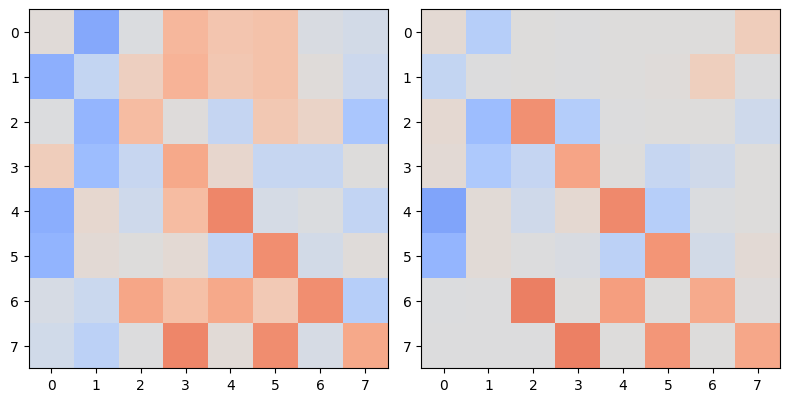

cosine_similarity measure: 0.829
MSE output:
5.5594259303629245e-05
[1.  0.  0.1 0.9 0.1 0.9]
[1.  0.  0.1 0.9 0.3 0.7]
[1.  0.  0.1 0.9 0.4 0.6]
[1.   0.   0.1  0.9  0.45 0.55]
[1.    0.    0.1   0.9   0.475 0.525]
[1.     0.     0.1    0.9    0.4875 0.5125]
[1.      0.      0.1     0.9     0.49375 0.50625]
[1.  0.  0.1 0.9 0.5 0.5]
[1.      0.      0.1     0.9     0.50625 0.49375]
[1.     0.     0.1    0.9    0.5125 0.4875]
[1.    0.    0.1   0.9   0.525 0.475]
[1.   0.   0.1  0.9  0.55 0.45]
[1.  0.  0.1 0.9 0.6 0.4]
[1.  0.  0.1 0.9 0.7 0.3]
[1.  0.  0.1 0.9 0.9 0.1]
[1.  0.  0.3 0.7 0.1 0.9]
[1.  0.  0.3 0.7 0.3 0.7]
[1.  0.  0.3 0.7 0.4 0.6]
[1.   0.   0.3  0.7  0.45 0.55]
[1.    0.    0.3   0.7   0.475 0.525]
[1.     0.     0.3    0.7    0.4875 0.5125]
[1.      0.      0.3     0.7     0.49375 0.50625]
[1.  0.  0.3 0.7 0.5 0.5]
[1.      0.      0.3     0.7     0.50625 0.49375]
[1.     0.     0.3    0.7    0.5125 0.4875]
[1.    0.    0.3   0.7   0.525 0.475]
[1.   0.   0.3  0.7  0

[1.  0.  0.7 0.3 0.6 0.4]
[1.  0.  0.7 0.3 0.7 0.3]
[1.  0.  0.7 0.3 0.9 0.1]
[1.  0.  0.9 0.1 0.1 0.9]
[1.  0.  0.9 0.1 0.3 0.7]
[1.  0.  0.9 0.1 0.4 0.6]
[1.   0.   0.9  0.1  0.45 0.55]
[1.    0.    0.9   0.1   0.475 0.525]
[1.     0.     0.9    0.1    0.4875 0.5125]
[1.      0.      0.9     0.1     0.49375 0.50625]
[1.  0.  0.9 0.1 0.5 0.5]
[1.      0.      0.9     0.1     0.50625 0.49375]
[1.     0.     0.9    0.1    0.5125 0.4875]
[1.    0.    0.9   0.1   0.525 0.475]
[1.   0.   0.9  0.1  0.55 0.45]
[1.  0.  0.9 0.1 0.6 0.4]
[1.  0.  0.9 0.1 0.7 0.3]
[1.  0.  0.9 0.1 0.9 0.1]
[0.  1.  0.1 0.9 0.1 0.9]
[0.  1.  0.3 0.7 0.1 0.9]
[0.  1.  0.4 0.6 0.1 0.9]
[0.   1.   0.45 0.55 0.1  0.9 ]
[0.    1.    0.475 0.525 0.1   0.9  ]
[0.     1.     0.4875 0.5125 0.1    0.9   ]
[0.      1.      0.49375 0.50625 0.1     0.9    ]
[0.  1.  0.5 0.5 0.1 0.9]
[0.      1.      0.50625 0.49375 0.1     0.9    ]
[0.     1.     0.5125 0.4875 0.1    0.9   ]
[0.    1.    0.525 0.475 0.1   0.9  ]
[0.   1.   0

[0.  1.  0.9 0.1 0.6 0.4]
[0.  1.  0.1 0.9 0.7 0.3]
[0.  1.  0.3 0.7 0.7 0.3]
[0.  1.  0.4 0.6 0.7 0.3]
[0.   1.   0.45 0.55 0.7  0.3 ]
[0.    1.    0.475 0.525 0.7   0.3  ]
[0.     1.     0.4875 0.5125 0.7    0.3   ]
[0.      1.      0.49375 0.50625 0.7     0.3    ]
[0.  1.  0.5 0.5 0.7 0.3]
[0.      1.      0.50625 0.49375 0.7     0.3    ]
[0.     1.     0.5125 0.4875 0.7    0.3   ]
[0.    1.    0.525 0.475 0.7   0.3  ]
[0.   1.   0.55 0.45 0.7  0.3 ]
[0.  1.  0.6 0.4 0.7 0.3]
[0.  1.  0.7 0.3 0.7 0.3]
[0.  1.  0.9 0.1 0.7 0.3]
[0.  1.  0.1 0.9 0.9 0.1]
[0.  1.  0.3 0.7 0.9 0.1]
[0.  1.  0.4 0.6 0.9 0.1]
[0.   1.   0.45 0.55 0.9  0.1 ]
[0.    1.    0.475 0.525 0.9   0.1  ]
[0.     1.     0.4875 0.5125 0.9    0.1   ]
[0.      1.      0.49375 0.50625 0.9     0.1    ]
[0.  1.  0.5 0.5 0.9 0.1]
[0.      1.      0.50625 0.49375 0.9     0.1    ]
[0.     1.     0.5125 0.4875 0.9    0.1   ]
[0.    1.    0.525 0.475 0.9   0.1  ]
[0.   1.   0.55 0.45 0.9  0.1 ]
[0.  1.  0.6 0.4 0.9 0.1]
[0.  1

Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6467  1.5834
      2        0.5838  1.5741
      3        0.5291  1.5747
      4        0.4816  1.5872
      5        0.4420  1.5609
      6        0.4159  1.5583
      7        0.4016  1.5910
      8        0.3814  1.5922
      9        0.3597  1.6178
     10        0.3464  1.5681
     11        0.3409  1.5588
     12        0.3377  1.6172
     13        0.3343  1.6115
     14        0.3308  1.5867
     15        0.3275  1.5906
     16        0.3215  1.5704
     17        0.3140  1.8872
     18        0.3082  1.6846
     19        0.3040  1.6049
     20        0.3010  1.5881
     21        0.2980  1.6786
     22        0.2949  1.7376
     23        0.2923  1.6126
     24        0.2890  1.6374
     25        0.2857  1.7547
     26        0.2825  1.7829
     27        0.2793  1.8522
     28        0.2763  1.7422
     29        0.2732  1.8437
     30        0.2700  1.7734
     31        0.2668

    240        0.0843  1.6072
    241        0.0806  1.5927
    242        0.0797  1.6303
    243        0.0825  1.5859
    244        0.0784  1.5630
    245        0.0792  1.6370
    246        0.0837  1.5323
    247        0.0762  1.6197
    248        0.0819  1.6542
    249        0.0843  1.6919
    250        0.0786  1.7587
    251        0.0851  1.6789
    252        0.0781  1.7194
    253        0.0800  1.8692
    254        0.0806  1.7370
    255        0.0764  1.7212
    256        0.0795  1.6652
    257        0.0779  1.6763
    258        0.0818  1.7082
    259        0.0866  1.6618
    260        0.0784  1.6874
    261        0.0779  1.5619
    262        0.0807  1.6347
    263        0.0763  1.6815
    264        0.0760  1.6408
    265        0.0780  1.6981
    266        0.0773  1.6047
    267        0.0868  1.6747
    268        0.0801  1.7243
    269        0.0774  1.6890
    270        0.0799  1.6462
    271        0.0761  1.6539
    272        0.0802  1.6572
    273   

cosine_similarity measure: 0.828
MSE output:
0.00010395970016054579
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7239  2.0751
      2        0.6578  1.6877
      3        0.5987  1.7446
      4        0.5464  1.6250
      5        0.5010  1.6625
      6        0.4639  1.7094
      7        0.4393  1.7856
      8        0.4235  1.6881
      9        0.4071  1.6902
     10        0.3882  1.6288
     11        0.3728  1.6056
     12        0.3612  1.5805
     13        0.3527  1.5728
     14        0.3450  1.6219
     15        0.3372  1.6610
     16        0.3302  1.7117
     17        0.3250  1.6598
     18        0.3215  1.5563
     19        0.3163  1.4838
     20        0.3098  1.5094
     21        0.3040  1.5339
     22        0.2994  1.4670
     23        0.2947  1.5793
     24        0.2901  1.5820
     25        0.2860  1.5444
     26        0.2821  1.7075
     27        0.2778  1.5753
     28        0.2738  1.5761
     29      

    235        0.0794  1.6591
    236        0.0791  1.7516
    237        0.0759  1.5978
    238        0.0783  1.5579
    239        0.0818  1.5679
    240        0.0769  1.6141
    241        0.0833  1.5900
    242        0.0744  1.6421
    243        0.0846  1.6324
    244        0.0766  1.5193
    245        0.0771  6.1735
    246        0.0785  6.2555
    247        0.0776  6.4790
    248        0.0779  6.3651
    249        0.0748  1.7033
    250        0.0854  1.5842
    251        0.0766  1.5824
    252        0.0773  1.5836
    253        0.0775  1.5271
    254        0.0780  1.5221
    255        0.0781  1.6618
    256        0.0754  1.5616
    257        0.0840  1.6299
    258        0.0752  1.6045
    259        0.0765  1.5446
    260        0.0792  1.5359
    261        0.0758  1.6727
    262        0.0734  1.5848
    263        0.0746  1.7040
    264        0.0756  1.5096
    265        0.0728  1.4749
    266        0.0732  1.5262
    267        0.0735  1.4849
    268   

cosine_similarity measure: 0.844
MSE output:
3.344027412691654e-06
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7118  1.7822
      2        0.6419  1.5865
      3        0.5810  1.5458
      4        0.5260  1.6537
      5        0.4764  1.6499
      6        0.4360  1.6804
      7        0.4121  1.6132
      8        0.4045  1.6108
      9        0.3910  1.6821
     10        0.3721  1.7335
     11        0.3595  1.5836
     12        0.3533  1.6177
     13        0.3490  1.9484
     14        0.3443  1.8539
     15        0.3379  1.7234
     16        0.3317  1.5997
     17        0.3269  1.5699
     18        0.3247  1.6379
     19        0.3207  1.6648
     20        0.3145  1.7590
     21        0.3087  1.6408
     22        0.3048  1.5796
     23        0.3011  1.6088
     24        0.2964  1.5972
     25        0.2915  1.5750
     26        0.2872  1.5895
     27        0.2846  1.5343
     28        0.2823  1.4973
     29       

    235        0.0747  1.5456
    236        0.0710  1.5772
    237        0.0704  1.5778
    238        0.0713  1.5513
    239        0.0686  1.5620
    240        0.0704  1.5685
    241        0.0689  1.5959
    242        0.0676  1.5884
    243        0.0711  1.5501
    244        0.0728  1.5494
    245        0.0688  1.5410
    246        0.0699  1.6206
    247        0.0708  1.5365
    248        0.0707  1.5546
    249        0.0691  1.5182
    250        0.0687  1.5395
    251        0.0681  1.5531
    252        0.0687  1.5382
    253        0.0671  1.5975
    254        0.0677  1.5757
    255        0.0697  1.5208
    256        0.0686  1.5677
    257        0.0671  1.6218
    258        0.0683  1.5054
    259        0.0685  1.5220
    260        0.0684  1.5882
    261        0.0673  1.5962
    262        0.0670  1.5534
    263        0.0679  1.5825
    264        0.0687  1.6315
    265        0.0671  1.5905
    266        0.0670  1.6231
    267        0.0665  1.6275
    268   

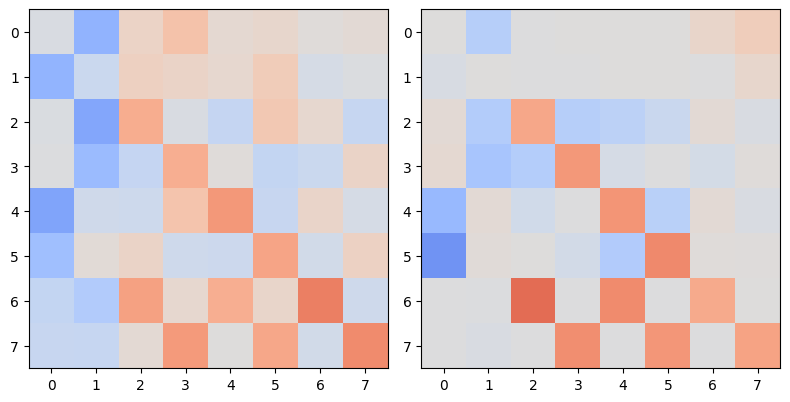

cosine_similarity measure: 0.833
MSE output:
0.00011253545720243446
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7022  1.7979
      2        0.6265  1.5866
      3        0.5593  1.6645
      4        0.5005  1.6521
      5        0.4510  1.5674
      6        0.4122  1.6307
      7        0.3891  1.5473
      8        0.3872  1.6434
      9        0.3871  1.5219
     10        0.3704  1.5569
     11        0.3525  1.5618
     12        0.3414  1.5545
     13        0.3358  1.5441
     14        0.3321  1.5777
     15        0.3278  1.5785
     16        0.3217  1.7207
     17        0.3143  1.5387
     18        0.3070  1.6338
     19        0.3020  1.5444
     20        0.3008  1.6631
     21        0.2979  1.5349
     22        0.2901  1.5949
     23        0.2841  1.5391
     24        0.2812  1.5937
     25        0.2793  1.6419
     26        0.2767  1.6208
     27        0.2727  1.6181
     28        0.2692  1.6212
     29      

    236        0.0720  1.5782
    237        0.0712  1.6102
    238        0.0739  1.5760
    239        0.0736  1.5775
    240        0.0735  1.6132
    241        0.0715  1.6200
    242        0.0735  1.5509
    243        0.0746  1.5710
    244        0.0744  1.5257
    245        0.0729  1.5842
    246        0.0715  1.5936
    247        0.0722  1.5874
    248        0.0728  1.5925
    249        0.0711  1.6853
    250        0.0706  1.5325
    251        0.0701  1.6801
    252        0.0703  1.6561
    253        0.0700  1.6273
    254        0.0702  1.5777
    255        0.0738  1.4934
    256        0.0753  1.8448
    257        0.0747  1.6440
    258        0.0705  1.4264
    259        0.0722  1.4821
    260        0.0722  1.5672
    261        0.0723  1.5165
    262        0.0744  1.8442
    263        0.0704  1.8960
    264        0.0734  1.6971
    265        0.0749  1.6488
    266        0.0701  1.5916
    267        0.0720  1.6291
    268        0.0731  1.6109
    269   

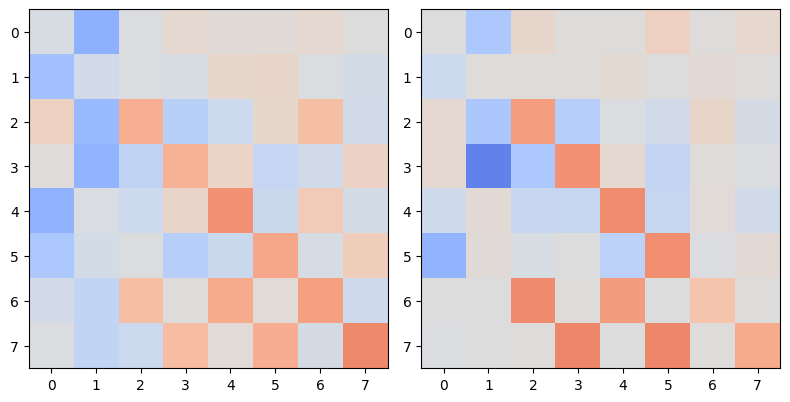

cosine_similarity measure: 0.842
MSE output:
1.1742872977493789e-07
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7007  1.9521
      2        0.6323  1.6044
      3        0.5717  1.6951
      4        0.5205  1.5966
      5        0.4800  1.4991
      6        0.4481  1.6358
      7        0.4237  1.5567
      8        0.4057  1.5821
      9        0.3908  1.5855
     10        0.3761  1.5243
     11        0.3601  1.5451
     12        0.3439  1.5682
     13        0.3292  1.5473
     14        0.3183  1.5905
     15        0.3107  1.5904
     16        0.3047  1.6187
     17        0.2981  1.6427
     18        0.2921  1.5636
     19        0.2871  1.6896
     20        0.2832  1.6313
     21        0.2804  1.6591
     22        0.2783  1.6523
     23        0.2750  1.6252
     24        0.2706  1.5398
     25        0.2672  1.5690
     26        0.2643  1.5630
     27        0.2614  1.5240
     28        0.2581  1.6041
     29      

    240        0.0959  1.6637
    241        0.0902  1.7067
    242        0.0962  1.5871
    243        0.0869  1.7233
    244        0.0926  1.6132
    245        0.0860  1.8933
    246        0.0900  1.6731
    247        0.0914  1.6209
    248        0.0855  1.9053
    249        0.0888  1.7735
    250        0.0868  1.8795
    251        0.0879  1.8890
    252        0.0909  1.7039
    253        0.0961  1.8341
    254        0.0903  1.7103
    255        0.0864  1.7693
    256        0.0869  1.5506
    257        0.0836  1.8057
    258        0.0893  1.6983
    259        0.0889  1.5723
    260        0.0838  1.5151
    261        0.0862  1.5460
    262        0.0863  1.5727
    263        0.0840  1.5719
    264        0.0861  1.5280
    265        0.0880  1.6042
    266        0.0832  1.5272
    267        0.0876  1.5976
    268        0.0918  1.7931
    269        0.0837  1.6751
    270        0.0837  1.5827
    271        0.0855  1.5919
    272        0.0830  1.5984
    273   

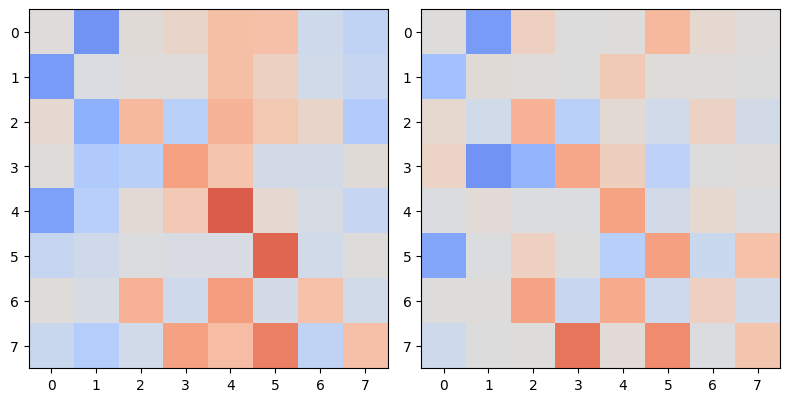

cosine_similarity measure: 0.773
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6993  1.7207
      2        0.6325  1.6256
      3        0.5716  1.7569
      4        0.5195  1.6521
      5        0.4779  1.5394
      6        0.4470  1.6376
      7        0.4291  1.5780
      8        0.4146  1.5942
      9        0.3931  1.5490
     10        0.3719  1.6587
     11        0.3569  1.6243
     12        0.3473  1.4989
     13        0.3396  1.5187
     14        0.3318  1.5112
     15        0.3242  1.5440
     16        0.3187  1.5136
     17        0.3167  1.5082
     18        0.3138  1.6129
     19        0.3087  1.6076
     20        0.3043  1.6665
     21        0.3013  1.5822
     22        0.2981  1.6970
     23        0.2941  1.7981
     24        0.2898  1.8542
     25        0.2865  1.8416
     26        0.2845  1.8256
     27        0.2825  1.6962
     28        0.2789  1.6972
     29        0.2757  1.7377
     30        0.2

    239        0.0733  1.5932
    240        0.0736  1.5341
    241        0.0704  1.5537
    242        0.0747  1.8275
    243        0.0731  1.7044
    244        0.0712  1.7005
    245        0.0754  1.6636
    246        0.0713  1.6470
    247        0.0758  1.6107
    248        0.0706  1.6389
    249        0.0723  1.6548
    250        0.0759  1.5664
    251        0.0797  1.7236
    252        0.0765  1.8424
    253        0.0702  1.7339
    254        0.0754  1.7841
    255        0.0713  1.6734
    256        0.0733  1.7936
    257        0.0716  1.8515
    258        0.0747  1.7359
    259        0.0717  1.8813
    260        0.0708  1.6155
    261        0.0720  1.5580
    262        0.0712  1.5582
    263        0.0742  1.4958
    264        0.0698  1.4988
    265        0.0755  1.5401
    266        0.0779  1.5636
    267        0.0695  1.5769
    268        0.0788  1.5398
    269        0.0721  1.4862
    270        0.0724  1.5071
    271        0.0747  1.5326
    272   

cosine_similarity measure: 0.881
MSE output:
1.01153980508494e-06
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6507  1.8861
      2        0.5884  1.9051
      3        0.5296  1.7031
      4        0.4756  1.6294
      5        0.4271  1.8343
      6        0.3897  1.8408
      7        0.3737  1.7984
      8        0.3656  1.9677
      9        0.3462  1.6835
     10        0.3289  1.6763
     11        0.3207  1.5437
     12        0.3168  1.5778
     13        0.3127  1.8010
     14        0.3067  1.7658
     15        0.2998  1.6662
     16        0.2955  1.8642
     17        0.2955  1.7694
     18        0.2939  1.7198
     19        0.2873  1.5503
     20        0.2814  1.5680
     21        0.2784  1.5818
     22        0.2758  1.5166
     23        0.2724  1.5648
     24        0.2686  1.5831
     25        0.2654  1.6113
     26        0.2641  1.5481
     27        0.2623  1.4775
     28        0.2587  1.5839
     29        

    239        0.0796  1.5794
    240        0.0766  1.5819
    241        0.0772  1.6679
    242        0.0783  1.5947
    243        0.0787  1.6271
    244        0.0778  1.5623
    245        0.0780  1.5624
    246        0.0776  1.5610
    247        0.0795  1.5816
    248        0.0780  1.5613
    249        0.0774  1.6427
    250        0.0795  1.5614
    251        0.0770  1.5402
    252        0.0781  1.5654
    253        0.0786  1.5983
    254        0.0765  1.6272
    255        0.0798  1.5894
    256        0.0776  1.5981
    257        0.0764  1.5601
    258        0.0775  1.5444
    259        0.0783  1.5389
    260        0.0756  1.5962
    261        0.0759  1.6495
    262        0.0782  1.6007
    263        0.0771  1.5754
    264        0.0755  1.5708
    265        0.0769  1.5173
    266        0.0770  1.5086
    267        0.0768  1.5786
    268        0.0770  1.5465
    269        0.0756  1.5540
    270        0.0765  1.6235
    271        0.0801  1.6761
    272   

cosine_similarity measure: 0.829
MSE output:
6.151095810195701e-05
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7486  2.0046
      2        0.6731  1.6519
      3        0.6052  1.5722
      4        0.5462  1.6003
      5        0.4959  1.5648
      6        0.4554  1.6036
      7        0.4255  1.6409
      8        0.4083  1.6847
      9        0.3992  1.5821
     10        0.3866  1.5954
     11        0.3702  1.5942
     12        0.3555  1.6906
     13        0.3459  1.6065
     14        0.3396  1.6207
     15        0.3343  1.5752
     16        0.3282  1.4996
     17        0.3223  1.5793
     18        0.3183  1.5669
     19        0.3169  1.4864
     20        0.3133  1.6334
     21        0.3068  1.5793
     22        0.3014  1.5655
     23        0.2979  1.5993
     24        0.2944  1.5582
     25        0.2902  1.5597
     26        0.2865  1.5276
     27        0.2844  1.5687
     28        0.2820  1.6855
     29       

    238        0.0821  1.7417
    239        0.0865  1.5559
    240        0.0816  1.6194
    241        0.0823  1.5381
    242        0.0815  1.5978
    243        0.0802  1.5432
    244        0.0827  1.6438
    245        0.0858  1.6216
    246        0.0867  1.6563
    247        0.0828  1.7739
    248        0.0796  1.5530
    249        0.0868  1.5533
    250        0.0894  1.6109
    251        0.0816  1.4795
    252        0.0842  1.5627
    253        0.0887  1.5940
    254        0.0804  1.5336
    255        0.0862  1.5689
    256        0.0858  1.6024
    257        0.0805  1.5763
    258        0.0893  1.5709
    259        0.0817  1.5640
    260        0.0827  1.5914
    261        0.0863  1.5836
    262        0.0795  1.6070
    263        0.0879  1.5512
    264        0.0831  1.6984
    265        0.0845  1.6531
    266        0.0815  1.5514
    267        0.0824  1.5286
    268        0.0843  1.5682
    269        0.0776  1.6381
    270        0.0813  1.6453
    271   

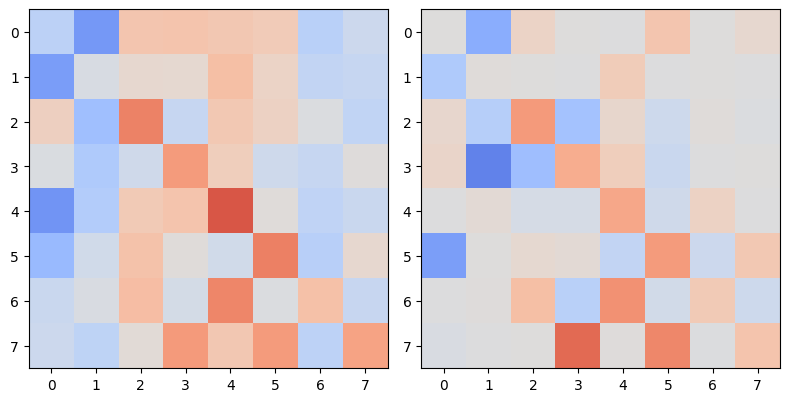

cosine_similarity measure: 0.769
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6602  1.6546
      2        0.5953  1.6737
      3        0.5347  1.6132
      4        0.4814  1.5546
      5        0.4381  1.5410
      6        0.4088  1.4628
      7        0.3951  1.5871
      8        0.3823  1.5188
      9        0.3621  1.5779
     10        0.3425  1.5589
     11        0.3295  1.6573
     12        0.3211  1.6892
     13        0.3149  1.6678
     14        0.3089  1.6576
     15        0.3042  1.5603
     16        0.3030  1.5320
     17        0.3023  1.6056
     18        0.2971  1.5287
     19        0.2917  1.6126
     20        0.2878  1.6819
     21        0.2843  1.7045
     22        0.2803  1.5849
     23        0.2755  1.5441
     24        0.2722  1.6506
     25        0.2697  1.6128
     26        0.2668  1.5864
     27        0.2633  1.7426
     28        0.2608  1.6372
     29        0.2590  1.5363
     30        0.2

    241        0.0817  1.5626
    242        0.0751  1.4820
    243        0.0808  1.6106
    244        0.0749  1.5308
    245        0.0810  1.4957
    246        0.0777  1.4842
    247        0.0778  1.5260
    248        0.0780  1.6006
    249        0.0746  1.5846
    250        0.0757  1.5421
    251        0.0765  1.5624
    252        0.0736  1.5437
    253        0.0754  1.5318
    254        0.0761  1.5837
    255        0.0736  1.5196
    256        0.0734  1.5741
    257        0.0745  1.5453
    258        0.0765  1.6426
    259        0.0740  1.4980
    260        0.0731  1.5694
    261        0.0745  1.5685
    262        0.0755  1.4915
    263        0.0773  1.5555
    264        0.0757  1.5241
    265        0.0723  1.5648
    266        0.0750  1.5036
    267        0.0771  1.5797
    268        0.0735  1.4599
    269        0.0760  1.5083
    270        0.0782  1.5472
    271        0.0749  1.4848
    272        0.0744  1.4944
    273        0.0762  1.5543
    274   

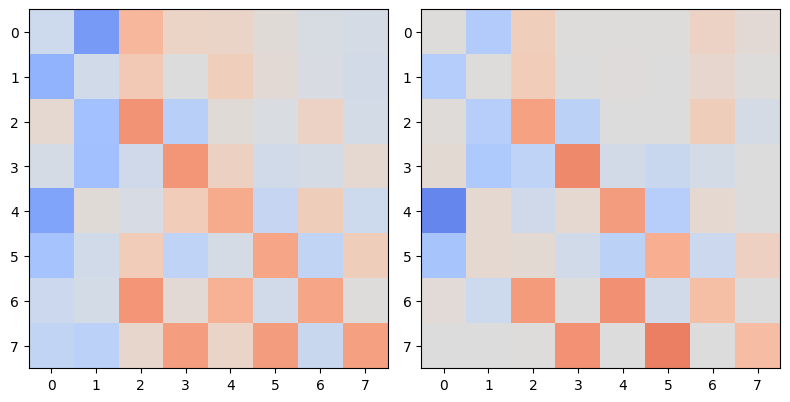

cosine_similarity measure: 0.896
MSE output:
2.880383935981241e-06
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7369  1.9602
      2        0.6701  1.7372
      3        0.6114  1.5777
      4        0.5584  1.5378
      5        0.5130  1.6368
      6        0.4763  1.6009
      7        0.4510  1.6486
      8        0.4318  1.5293
      9        0.4115  1.5425
     10        0.3902  1.6311
     11        0.3722  1.5245
     12        0.3596  1.5670
     13        0.3501  1.7170
     14        0.3416  1.6699
     15        0.3353  1.6790
     16        0.3309  1.5553
     17        0.3271  1.6475
     18        0.3216  1.6303
     19        0.3164  1.6089
     20        0.3121  1.5338
     21        0.3082  1.6694
     22        0.3036  1.4917
     23        0.2992  1.6491
     24        0.2955  1.6240
     25        0.2917  1.5700
     26        0.2875  1.4917
     27        0.2841  1.6542
     28        0.2809  1.5635
     29       

    238        0.0858  1.5985
    239        0.0845  1.5761
    240        0.0872  1.5809
    241        0.0849  1.4925
    242        0.0855  1.5331
    243        0.0889  1.8093
    244        0.0853  1.8129
    245        0.0936  1.5553
    246        0.0920  1.6274
    247        0.0868  1.6431
    248        0.0880  1.6187
    249        0.0864  1.5556
    250        0.0994  1.5416
    251        0.0898  1.5044
    252        0.0882  1.5609
    253        0.0884  1.4854
    254        0.0888  1.4713
    255        0.0909  1.5439
    256        0.0858  1.5074
    257        0.0859  1.5678
    258        0.0854  1.5342
    259        0.0872  1.6377
    260        0.0828  1.6565
    261        0.0920  1.5467
    262        0.0966  1.4856
    263        0.0865  1.5010
    264        0.0845  1.7490
    265        0.0914  1.7365
    266        0.0853  1.6141
    267        0.0840  1.5719
    268        0.0897  1.6156
    269        0.0866  1.5957
    270        0.0822  1.8474
    271   

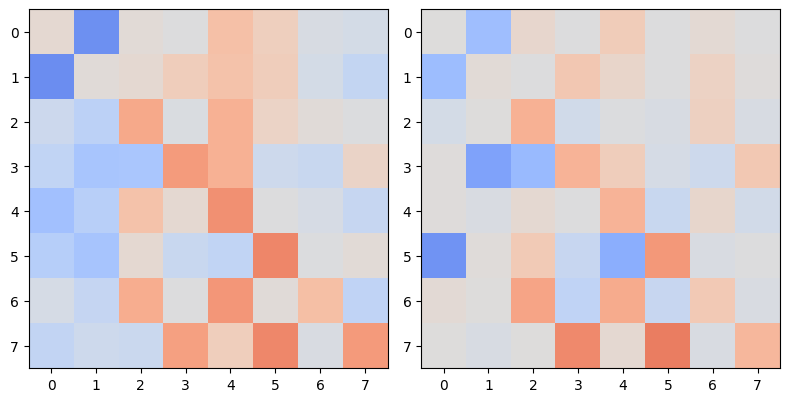

cosine_similarity measure: 0.804
MSE output:
5.610398569684699e-05
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7001  1.8469
      2        0.6280  1.5593
      3        0.5591  1.6424
      4        0.4956  1.6649
      5        0.4402  1.5258
      6        0.3991  1.5192
      7        0.3830  1.5201
      8        0.3930  1.5706
      9        0.3851  1.4739
     10        0.3658  1.6245
     11        0.3531  1.6966
     12        0.3480  1.7283
     13        0.3453  1.6409
     14        0.3424  1.8754
     15        0.3378  1.7806
     16        0.3311  1.7127
     17        0.3233  1.5792
     18        0.3161  1.6748
     19        0.3118  1.7226
     20        0.3097  1.6089
     21        0.3046  1.7246
     22        0.2968  1.6312
     23        0.2910  1.5177
     24        0.2888  1.5475
     25        0.2871  1.5335
     26        0.2846  1.7485
     27        0.2812  1.5582
     28        0.2781  1.4961
     29       

    235        0.1185  1.6147
    236        0.1191  1.6546
    237        0.1225  1.6712
    238        0.1302  1.6154
    239        0.1351  1.5873
    240        0.1260  1.5773
    241        0.1244  1.6494
    242        0.1389  1.6837
    243        0.1220  1.5249
    244        0.1324  1.5457
    245        0.1218  5.5976
    246        0.1225  1.5013
    247        0.1239  1.5352
    248        0.1354  1.5265
    249        0.1180  1.5677
    250        0.1457  1022.4882
    251        0.1321  1.5248
    252        0.1342  1.5061
    253        0.1253  1.5354
    254        0.1318  821.0034
    255        0.1250  1.4705
    256        0.1324  1.5709
    257        0.1292  1.4650
    258        0.1219  1.5409
    259        0.1252  1.5285
    260        0.1180  1.5124
    261        0.1232  1.5601
    262        0.1180  1.5347
    263        0.1390  1.5188
    264        0.1466  1.4650
    265        0.1277  1.5534
    266        0.1253  317.0722
    267        0.1279  1.5594
   

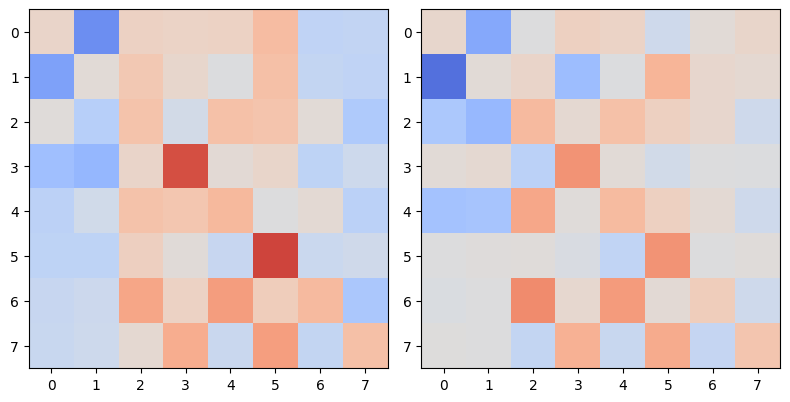

cosine_similarity measure: 0.746
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6163  1.5033
      2        0.5563  1.5220
      3        0.5018  1.4989
      4        0.4524  1.5283
      5        0.4112  1.5671
      6        0.3934  1.5652
      7        0.4012  1.4845
      8        0.3826  1.5203
      9        0.3613  1.5084
     10        0.3525  1.4668
     11        0.3499  1.5497
     12        0.3478  1.4666
     13        0.3430  1.5735
     14        0.3358  1.4603
     15        0.3274  1.5320
     16        0.3200  1.5303
     17        0.3173  1.5330
     18        0.3172  1.5822
     19        0.3131  1.5495
     20        0.3053  1.5208
     21        0.2989  1.4824
     22        0.2961  1.4460
     23        0.2939  1.5524
     24        0.2909  1.5368
     25        0.2867  1.5247
     26        0.2827  1.5474
     27        0.2797  1.5184
     28        0.2781  1.4503
     29        0.2769  1.5027
     30        0.2

    233        0.0760  1.5334
    234        0.0746  1.4935
    235        0.0723  1.5740
    236        0.0727  1.5597
    237        0.0747  1.5501
    238        0.0731  1.4940
    239        0.0722  1.5051
    240        0.0732  1.4668
    241        0.0760  1.5441
    242        0.0794  1.6037
    243        0.0769  1.5972
    244        0.0725  1.6246
    245        0.0775  1.5012
    246        0.0808  1.5472
    247        0.0723  1.6032
    248        0.0778  1.6374
    249        0.0807  1.5083
    250        0.0726  1.5695
    251        0.0760  1.5466
    252        0.0722  1.5234
    253        0.0739  1.5003
    254        0.0775  1.5626
    255        0.0755  1.5018
    256        0.0769  1.4504
    257        0.0717  1.5068
    258        0.0717  1.5344
    259        0.0741  1.6043
    260        0.0746  1.5480
    261        0.0778  1.4707
    262        0.0731  1.5312
    263        0.0712  1.5050
    264        0.0774  1.5471
    265        0.0713  1.5685
    266   

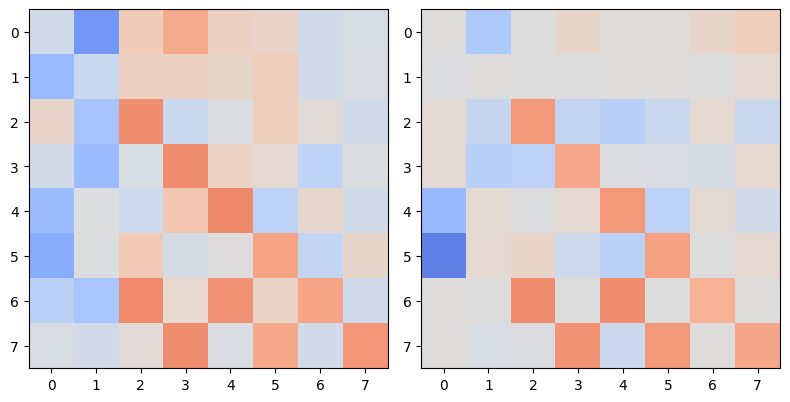

cosine_similarity measure: 0.844
MSE output:
1.8834749019798763e-05
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8071  1.9640
      2        0.7321  1.5809
      3        0.6578  1.5272
      4        0.5865  1.5165
      5        0.5221  1.5067
      6        0.4681  1.4774
      7        0.4286  1.5791
      8        0.4082  1.5260
      9        0.4077  1.5486
     10        0.4063  1.5648
     11        0.3957  1.5183
     12        0.3843  1.5281
     13        0.3776  1.5316
     14        0.3737  1.5430
     15        0.3708  1.6001
     16        0.3669  1.6000
     17        0.3619  1.5674
     18        0.3557  1.5485
     19        0.3484  1.5651
     20        0.3409  1.5453
     21        0.3341  1.5254
     22        0.3286  1.5577
     23        0.3242  1.5066
     24        0.3188  1.5902
     25        0.3127  1.6980
     26        0.3072  1.5529
     27        0.3031  1.5352
     28        0.3009  1.5041
     29      

    240        0.0815  1.5724
    241        0.0829  1.5982
    242        0.0801  1.5845
    243        0.0769  1.5201
    244        0.0778  1.5488
    245        0.0794  1.4925
    246        0.0794  1.5292
    247        0.0778  1.5518
    248        0.0754  1.5404
    249        0.0795  1.5455
    250        0.0811  1.5438
    251        0.0809  1.7195
    252        0.0849  1.5286
    253        0.0782  1.5856
    254        0.0798  1.5734
    255        0.0858  1.5877
    256        0.0777  1.5470
    257        0.0831  1.5358
    258        0.0779  1.5600
    259        0.0829  1.6024
    260        0.0770  1.5293
    261        0.0820  1.5881
    262        0.0807  1.5643
    263        0.0768  1.5915
    264        0.0818  1.5069
    265        0.0766  1.5455
    266        0.0853  1.5026
    267        0.0786  1.5844
    268        0.0772  1.5796
    269        0.0821  1.5586
    270        0.0742  1.6447
    271        0.0784  1.5174
    272        0.0806  1.4643
    273   

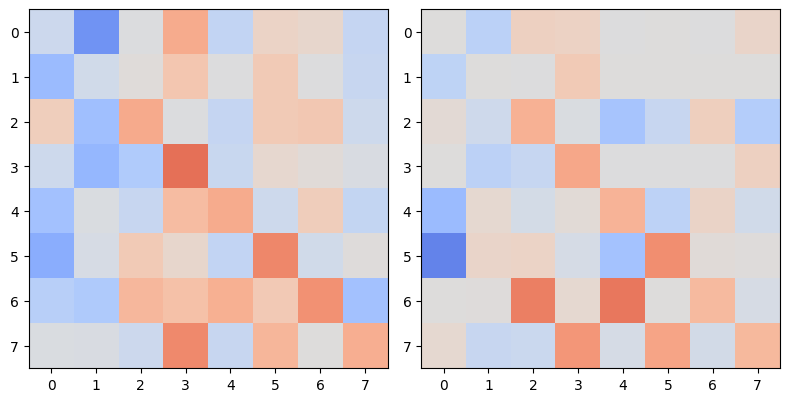

cosine_similarity measure: 0.792
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6466  1.6375
      2        0.5854  1.5464
      3        0.5284  1.5421
      4        0.4779  1.5479
      5        0.4359  1.5473
      6        0.4123  1.5131
      7        0.4069  1.5262
      8        0.3882  1.6334
      9        0.3662  1.5408
     10        0.3552  1.5720
     11        0.3507  1.6246
     12        0.3468  1.5541
     13        0.3417  1.5373
     14        0.3353  1.5617
     15        0.3298  1.5080
     16        0.3262  1.5090
     17        0.3218  1.5434
     18        0.3150  1.5513
     19        0.3091  1.5597
     20        0.3056  1.4386
     21        0.3030  1.5232
     22        0.2997  1.4937
     23        0.2955  1.6026
     24        0.2911  1.5545
     25        0.2875  1.4598
     26        0.2848  1.5901
     27        0.2822  1.6043
     28        0.2797  1.5126
     29        0.2771  1.5802
     30        0.2

    235        0.0823  1.5974
    236        0.0827  1.5472
    237        0.0810  1.4712
    238        0.0825  1.5544
    239        0.0852  1.6282
    240        0.0817  1.5556
    241        0.0816  1.6013
    242        0.0841  1.5124
    243        0.0830  1.5367
    244        0.0839  1.5416
    245        0.0816  1.4770
    246        0.0849  1.5208
    247        0.0846  1.5274
    248        0.0805  1.5380
    249        0.0865  1.5892
    250        0.0835  1.5870
    251        0.0829  1.5907
    252        0.0896  1.5579
    253        0.0795  1.5033
    254        0.0852  1.5608
    255        0.0840  1.5476
    256        0.0837  1.5348
    257        0.0826  1.5244
    258        0.0845  1.5928
    259        0.0851  1.6054
    260        0.0804  1.5852
    261        0.0903  1.6618
    262        0.0818  1.5483
    263        0.0838  1.5588
    264        0.0813  1.6144
    265        0.0807  1.5582
    266        0.0802  1.5048
    267        0.0795  1.5494
    268   

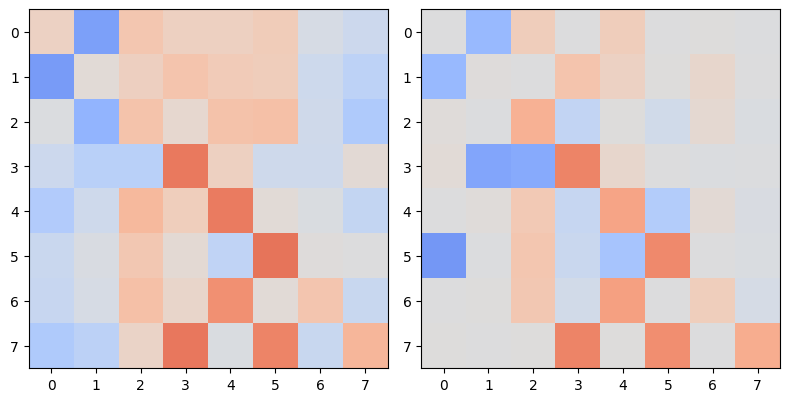

cosine_similarity measure: 0.774
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6817  1.5507
      2        0.6110  1.6144
      3        0.5436  1.6279
      4        0.4811  1.5742
      5        0.4267  1.5042
      6        0.3866  1.5510
      7        0.3711  1.5716
      8        0.3702  1.5701
      9        0.3522  1.5911
     10        0.3355  1.5759
     11        0.3295  1.4965
     12        0.3291  1.5553
     13        0.3288  1.5013
     14        0.3264  1.5684
     15        0.3213  1.5974
     16        0.3152  1.4960
     17        0.3104  1.8576
     18        0.3080  1.7395
     19        0.3052  1.6126
     20        0.2995  1.6142
     21        0.2940  1.6165
     22        0.2906  1.6357
     23        0.2889  1.5402
     24        0.2870  1.5996
     25        0.2840  1.5191
     26        0.2806  1.5332
     27        0.2774  1.5421
     28        0.2754  1.6312
     29        0.2735  1.5603
     30        0.2

    238        0.0771  1.4739
    239        0.0775  1.5153
    240        0.0752  1.5533
    241        0.0731  1.4806
    242        0.0739  1.5428
    243        0.0734  1.5395
    244        0.0743  1.5702
    245        0.0720  1.6394
    246        0.0718  1.5020
    247        0.0732  1.5141
    248        0.0734  1.4903
    249        0.0739  1.6272
    250        0.0728  1.5178
    251        0.0718  1.5281
    252        0.0720  1.5259
    253        0.0719  1.5578
    254        0.0713  1.5147
    255        0.0714  1.5699
    256        0.0725  1.7449
    257        0.0732  1.5384
    258        0.0747  1.5657
    259        0.0745  1.7798
    260        0.0715  1.6017
    261        0.0713  1.5630
    262        0.0737  1.7785
    263        0.0731  1.7789
    264        0.0703  1.6860
    265        0.0729  1.5278
    266        0.0726  1.5966
    267        0.0717  1.7495
    268        0.0703  1.5608
    269        0.0735  1.5536
    270        0.0720  1.5110
    271   

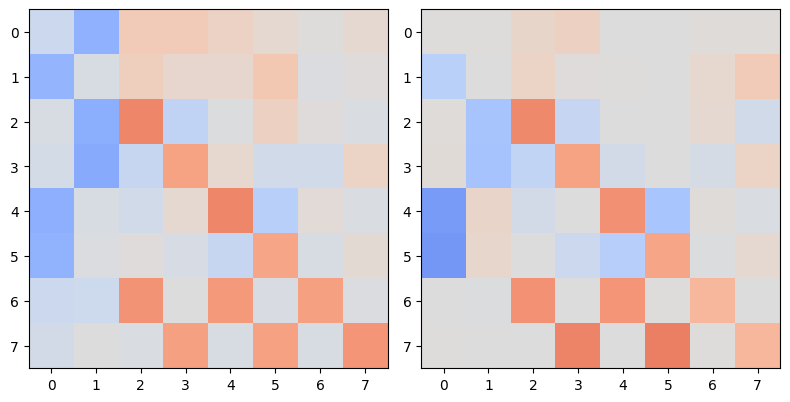

cosine_similarity measure: 0.906
MSE output:
3.3104637090160686e-07
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6634  1.7958
      2        0.5961  1.5816
      3        0.5341  1.6016
      4        0.4794  1.5984
      5        0.4321  1.4902
      6        0.3991  1.5635
      7        0.3934  1.5846
      8        0.3847  1.5674
      9        0.3653  1.5444
     10        0.3528  1.5398
     11        0.3475  1.5271
     12        0.3439  1.5815
     13        0.3382  1.5737
     14        0.3300  1.5198
     15        0.3211  1.5748
     16        0.3132  1.5101
     17        0.3083  1.5607
     18        0.3050  1.5813
     19        0.2996  1.5266
     20        0.2928  1.6425
     21        0.2884  1.5784
     22        0.2855  1.5264
     23        0.2821  1.5702
     24        0.2786  1.5937
     25        0.2750  1.6593
     26        0.2720  1.6108
     27        0.2702  1.5888
     28        0.2676  1.5611
     29      

    236        0.1591  1.6023
    237        0.1833  1.5262
    238        0.1717  1.5950
    239        0.1373  1.5208
    240        0.1676  1.5550
    241        0.1460  1.5013
    242        0.1453  1.5794
    243        0.1488  1.4895
    244        0.1504  1.5817
    245        0.1426  1.5082
    246        0.1360  1.5391
    247        0.1336  1.5197
    248        0.1420  1.5256
    249        0.1346  1.5235
    250        0.1312  1.5280
    251        0.1298  1.5620
    252        0.1270  1.6307
    253        0.1186  1.5056
    254        0.1286  1.4946
    255        0.1152  1.5583
    256        0.1207  1.5393
    257        0.1206  1.5020
    258        0.1200  1.5771
    259        0.1047  1.5180
    260        0.1276  1.5621
    261        0.1196  1.6025
    262        0.1189  1.5624
    263        0.1081  1.5917
    264        0.1195  1.5704
    265        0.1113  1.5834
    266        0.1208  1.6130
    267        0.1227  1.5786
    268        0.1185  1.5912
    269   

cosine_similarity measure: 0.803
MSE output:
0.0001126166644995884
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.5981  1.8473
      2        0.5370  1.5064
      3        0.4807  1.8148
      4        0.4299  1.5797
      5        0.3871  1.5941
      6        0.3631  1.5812
      7        0.3559  1.5831
      8        0.3383  1.4729
      9        0.3215  1.6403
     10        0.3154  1.5619
     11        0.3144  1.5405
     12        0.3124  1.5556
     13        0.3069  1.5515
     14        0.2988  1.4862
     15        0.2915  1.4641
     16        0.2874  1.6079
     17        0.2852  1.6213
     18        0.2812  1.6216
     19        0.2770  1.4938
     20        0.2748  1.5339
     21        0.2737  1.6166
     22        0.2719  1.5101
     23        0.2692  1.5658
     24        0.2663  1.5198
     25        0.2642  1.5755
     26        0.2622  1.5975
     27        0.2594  1.5197
     28        0.2567  1.5845
     29       

    234        0.0724  1.5223
    235        0.0725  1.6895
    236        0.0743  1.4955
    237        0.0716  1.5517
    238        0.0723  1.5824
    239        0.0761  1.4801
    240        0.0730  1.5446
    241        0.0737  1.5612
    242        0.0748  1.5497
    243        0.0717  1.5051
    244        0.0711  1.5192
    245        0.0706  1.6169
    246        0.0714  1.5322
    247        0.0707  1.4975
    248        0.0707  1.5422
    249        0.0703  1.4987
    250        0.0707  1.5039
    251        0.0716  1.5295
    252        0.0717  1.5665
    253        0.0737  1.5265
    254        0.0721  1.5779
    255        0.0709  1.5904
    256        0.0762  1.5656
    257        0.0732  1.4893
    258        0.0735  1.5686
    259        0.0739  1.4846
    260        0.0709  1.5011
    261        0.0724  1.5431
    262        0.0707  1.5358
    263        0.0752  1.5246
    264        0.0705  1.5241
    265        0.0732  1.5954
    266        0.0733  1.5386
    267   

cosine_similarity measure: 0.835
MSE output:
2.4422184558440576e-06
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6254  1.7486
      2        0.5694  1.6452
      3        0.5144  1.6685
      4        0.4617  1.5180
      5        0.4172  1.5838
      6        0.3958  1.5051
      7        0.3937  1.5379
      8        0.3716  1.7320
      9        0.3521  1.5541
     10        0.3447  1.5716
     11        0.3424  1.5684
     12        0.3399  1.5824
     13        0.3350  1.6021
     14        0.3279  1.5372
     15        0.3204  1.5578
     16        0.3150  1.6012
     17        0.3129  1.5324
     18        0.3092  1.6062
     19        0.3019  1.5547
     20        0.2958  1.5225
     21        0.2930  1.5663
     22        0.2914  1.5591
     23        0.2897  1.4996
     24        0.2863  1.5329
     25        0.2825  1.6515
     26        0.2791  1.5886
     27        0.2773  1.5966
     28        0.2756  1.6072
     29      

    235        0.1152  1.5854
    236        0.1122  1.5925
    237        0.1030  1.5562
    238        0.1177  1.5133
    239        0.1071  1.5662
    240        0.1023  1.5293
    241        0.1095  1.5752
    242        0.1023  1.4514
    243        0.1044  1.4936
    244        0.1065  1.5564
    245        0.0977  1.4496
    246        0.1043  1.5170
    247        0.0991  1.4806
    248        0.1003  1.5053
    249        0.0929  1.5260
    250        0.0994  1.5239
    251        0.0995  1.4929
    252        0.1046  1.4749
    253        0.0941  1.4688
    254        0.0973  1.5297
    255        0.0937  1.5259
    256        0.1015  1.5302
    257        0.0902  1.5455
    258        0.0919  1.5054
    259        0.0991  1.5009
    260        0.0875  1.4993
    261        0.0981  1.4879
    262        0.0967  1.5428
    263        0.0890  1.4919
    264        0.1010  1.6536
    265        0.0887  1.5559
    266        0.0919  1.5266
    267        0.0941  1.5130
    268   

cosine_similarity measure: 0.821
MSE output:
1.5718992819051296e-06
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6735  2.0185
      2        0.6128  1.5655
      3        0.5555  1.6120
      4        0.5036  1.5357
      5        0.4589  1.5871
      6        0.4243  1.6460
      7        0.4057  1.5089
      8        0.3942  1.6508
      9        0.3740  1.8839
     10        0.3544  1.7124
     11        0.3431  1.7429
     12        0.3368  1.4938
     13        0.3314  1.5424
     14        0.3247  1.7456
     15        0.3171  1.8656
     16        0.3119  1.8098
     17        0.3091  1.9609
     18        0.3031  1.9438
     19        0.2961  1.8933
     20        0.2914  1.7073
     21        0.2885  1.7967
     22        0.2855  1.5497
     23        0.2811  1.4897
     24        0.2769  1.5760
     25        0.2741  1.5493
     26        0.2719  1.5982
     27        0.2686  1.6093
     28        0.2652  1.6085
     29      

    236        0.0723  1.6043
    237        0.0722  1.5350
    238        0.0738  1.5459
    239        0.0719  1.5831
    240        0.0715  1.5733
    241        0.0728  1.5590
    242        0.0737  1.5568
    243        0.0721  1.5995
    244        0.0715  1.6455
    245        0.0724  1.6604
    246        0.0729  1.5766
    247        0.0724  1.6009
    248        0.0708  1.5550
    249        0.0720  1.5045
    250        0.0739  1.5252
    251        0.0705  1.5630
    252        0.0699  1.6953
    253        0.0708  1.5120
    254        0.0687  1.5860
    255        0.0698  1.5200
    256        0.0707  1.6028
    257        0.0700  1.5857
    258        0.0697  1.5895
    259        0.0693  1.4850
    260        0.0710  1.5262
    261        0.0741  1.5172
    262        0.0745  1.5822
    263        0.0716  1.5250
    264        0.0701  1.6318
    265        0.0692  1.6010
    266        0.0687  1.5225
    267        0.0698  1.6151
    268        0.0686  1.5356
    269   

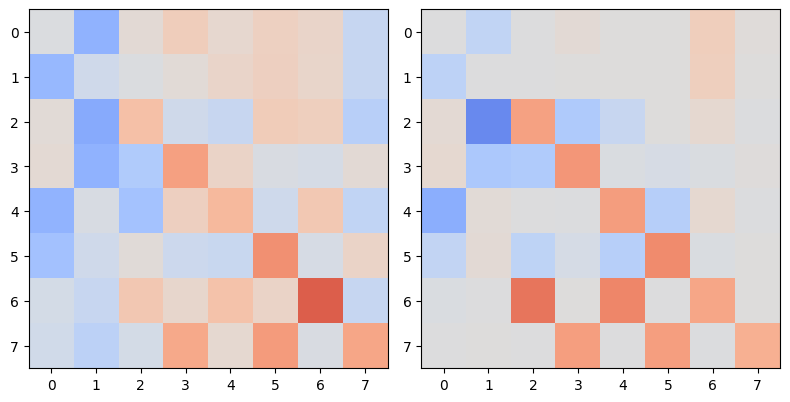

cosine_similarity measure: 0.816
MSE output:
1.6606725408452264e-05
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7179  1.9506
      2        0.6478  1.4600
      3        0.5847  1.5570
      4        0.5284  1.5810
      5        0.4786  1.5976
      6        0.4381  1.5704
      7        0.4129  1.5210
      8        0.4040  1.5095
      9        0.3918  1.4891
     10        0.3749  1.4703
     11        0.3636  1.5061
     12        0.3586  1.4712
     13        0.3562  1.5688
     14        0.3523  1.5731
     15        0.3452  1.5829
     16        0.3362  1.5397
     17        0.3271  1.5374
     18        0.3201  1.4895
     19        0.3162  1.4711
     20        0.3113  1.4890
     21        0.3033  1.6086
     22        0.2969  1.5440
     23        0.2933  1.5483
     24        0.2903  1.4960
     25        0.2871  1.5548
     26        0.2829  1.4999
     27        0.2795  1.5819
     28        0.2775  1.5442
     29      

    236        0.0921  1.5232
    237        0.0903  1.5979
    238        0.0885  1.7188
    239        0.0885  1.4819
    240        0.0926  1.5721
    241        0.0857  1.5669
    242        0.0952  1.5455
    243        0.0828  1.4837
    244        0.0883  1.6362
    245        0.0838  1.6373
    246        0.0896  1.6093
    247        0.0878  1.4883
    248        0.0909  1.6018
    249        0.0804  1.5066
    250        0.0895  1.5228
    251        0.1005  1.6299
    252        0.0897  1.6031
    253        0.1075  1.4981
    254        0.0951  1.5382
    255        0.0945  1.5669
    256        0.0981  1.5721
    257        0.0900  1.5635
    258        0.0962  1.5280
    259        0.0855  1.5553
    260        0.0985  1.5708
    261        0.0852  1.4815
    262        0.0938  1.5506
    263        0.0829  1.5295
    264        0.0901  1.5377
    265        0.0833  1.5785
    266        0.0882  1.5419
    267        0.0810  1.5725
    268        0.0868  1.5301
    269   

cosine_similarity measure: 0.808
MSE output:
2.005146295654919e-05
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7775  1.7281
      2        0.7022  1.6795
      3        0.6330  1.5701
      4        0.5699  1.5488
      5        0.5149  1.5085
      6        0.4691  1.5298
      7        0.4348  1.5005
      8        0.4146  1.5658
      9        0.4098  1.5455
     10        0.4025  1.5362
     11        0.3852  1.5602
     12        0.3690  1.5065
     13        0.3591  1.5318
     14        0.3539  1.8714
     15        0.3500  1.8152
     16        0.3451  1.8150
     17        0.3385  1.5921
     18        0.3313  1.5841
     19        0.3251  1.5133
     20        0.3224  1.5502
     21        0.3207  1.5478
     22        0.3143  1.6052
     23        0.3079  1.5834
     24        0.3050  1.5320
     25        0.3036  1.5695
     26        0.3010  1.5662
     27        0.2973  1.5962
     28        0.2932  1.5479
     29       

    235        0.0961  1.8222
    236        0.0932  1.6588
    237        0.0880  1.6261
    238        0.0954  1.8261
    239        0.0882  1.6627
    240        0.0875  1.5911
    241        0.0917  1.6084
    242        0.0867  1.5708
    243        0.0899  1.5310
    244        0.0872  1.6226
    245        0.0853  1.6454
    246        0.0887  1.4941
    247        0.0876  1.5552
    248        0.0853  1.5434
    249        0.0861  1.5083
    250        0.0858  1.5977
    251        0.0847  1.6598
    252        0.0853  1.5076
    253        0.0868  1.5384
    254        0.0910  1.5434
    255        0.0998  1.4772
    256        0.0857  1.6079
    257        0.0899  1.4975
    258        0.0960  1.5175
    259        0.0907  1.8112
    260        0.0897  1.7243
    261        0.0912  1.6919
    262        0.0856  1.4882
    263        0.0878  1.5485
    264        0.0904  1.5671
    265        0.0854  1.5100
    266        0.0854  1.5200
    267        0.0833  1.5531
    268   

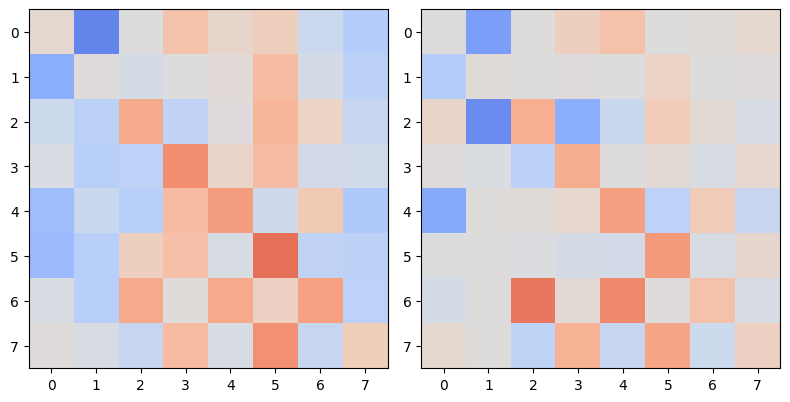

cosine_similarity measure: 0.777
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6701  1.5653
      2        0.6068  1.5833
      3        0.5473  1.4864
      4        0.4919  1.5403
      5        0.4436  1.5461
      6        0.4090  1.7738
      7        0.3945  1.5906
      8        0.3821  1.5486
      9        0.3626  1.5612
     10        0.3499  1.6014
     11        0.3458  1.6331
     12        0.3436  1.6331
     13        0.3390  1.5948
     14        0.3321  1.5388
     15        0.3243  1.5823
     16        0.3198  1.6792
     17        0.3174  1.6222
     18        0.3113  1.6082
     19        0.3037  1.5912
     20        0.2976  1.6947
     21        0.2932  1.5702
     22        0.2890  1.4710
     23        0.2850  1.5559
     24        0.2812  1.5336
     25        0.2785  1.5710
     26        0.2760  1.5406
     27        0.2727  1.5064
     28        0.2691  1.5316
     29        0.2666  1.5190
     30        0.2

    239        0.0902  1.5835
    240        0.0891  1.6027
    241        0.0905  1.6226
    242        0.0816  1.5522
    243        0.0932  1.6280
    244        0.0844  1.5735
    245        0.0856  1.5622
    246        0.0909  1.5265
    247        0.0808  1.5536
    248        0.0896  1.5669
    249        0.0820  1.5972
    250        0.0906  1.5461
    251        0.0828  1.5987
    252        0.0907  1.5052
    253        0.0818  1.5237
    254        0.0945  1.5262
    255        0.0868  1.6284
    256        0.0888  1.5983
    257        0.0909  1.5085
    258        0.0886  1.5528
    259        0.1092  1.5882
    260        0.0836  1.6136
    261        0.0906  1.5057
    262        0.0892  1.5882
    263        0.0894  1.6034
    264        0.0814  1.5993
    265        0.0884  1.5723
    266        0.0796  1.5052
    267        0.0915  1.5337
    268        0.0803  1.6489
    269        0.0859  1.5106
    270        0.0841  1.5312
    271        0.0827  1.7350
    272   

cosine_similarity measure: 0.796
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7515  1.4926
      2        0.6803  1.4716
      3        0.6170  80.2661
      4        0.5600  1.5795
      5        0.5091  1.6556
      6        0.4661  1.5165
      7        0.4339  1.5804
      8        0.4166  1.5881
      9        0.4132  1.5388
     10        0.4048  1.9404
     11        0.3885  1.5857
     12        0.3740  1.5339
     13        0.3647  1.5061
     14        0.3587  140.2672
     15        0.3533  1.5449
     16        0.3469  1.4836
     17        0.3390  1.5157
     18        0.3299  1.4913
     19        0.3212  9.9155
     20        0.3146  1.5582
     21        0.3121  1.5584
     22        0.3101  1.6134
     23        0.3036  1.5184
     24        0.2973  1.6676
     25        0.2947  1.6155
     26        0.2936  1.6174
     27        0.2918  1.7367
     28        0.2883  1.5518
     29        0.2842  1.5027
     30        

    234        0.0833  1.6235
    235        0.0883  1.6730
    236        0.0794  1.5787
    237        0.0818  1.5999
    238        0.0844  1.6187
    239        0.0787  2.1014
    240        0.0813  1.5845
    241        0.0801  1.6038
    242        0.0799  1.5749
    243        0.0816  1.5298
    244        0.0796  1.6301
    245        0.0777  1.5986
    246        0.0803  1.6131
    247        0.0837  1.5543
    248        0.0836  1.5264
    249        0.0803  1.5210
    250        0.0786  1.5358
    251        0.0830  1.4868
    252        0.0786  1.6033
    253        0.0810  1.5225
    254        0.0789  1.5354
    255        0.0779  1.5424
    256        0.0789  1.6446
    257        0.0796  1.5753
    258        0.0798  1.5599
    259        0.0765  1.6813
    260        0.0806  1.5598
    261        0.0804  1.5998
    262        0.0770  1.4620
    263        0.0813  1.5563
    264        0.0790  1.5067
    265        0.0783  1.6214
    266        0.0798  1.7882
    267   

cosine_similarity measure: 0.789
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6619  1.4890
      2        0.5908  1.5194
      3        0.5273  1.6518
      4        0.4723  1.5265
      5        0.4269  1.5649
      6        0.3937  1.5745
      7        0.3781  1.4711
      8        0.3826  1.6062
      9        0.3737  1.5236
     10        0.3555  1.5702
     11        0.3428  1.5105
     12        0.3370  1.4985
     13        0.3342  1.5332
     14        0.3310  1.4971
     15        0.3262  1.6749
     16        0.3188  1.6355
     17        0.3109  1.6225
     18        0.3042  1.5918
     19        0.3021  1.5086
     20        0.3001  1.5389
     21        0.2938  1.5439
     22        0.2877  1.5316
     23        0.2846  1.5368
     24        0.2832  1.5435
     25        0.2816  1.5344
     26        0.2788  1.4902
     27        0.2755  1.6080
     28        0.2725  1.5284
     29        0.2707  1.5489
     30        0.2

    238        0.0876  1.5895
    239        0.0839  1.5358
    240        0.0861  1.5139
    241        0.0916  1.5711
    242        0.0819  1.4863
    243        0.0928  1.9511
    244        0.0812  1.8664
    245        0.0879  1.6875
    246        0.0812  1.6060
    247        0.0905  1.5972
    248        0.0790  1.6901
    249        0.0896  1.5464
    250        0.0796  1.5693
    251        0.0869  1.5780
    252        0.0789  1.6206
    253        0.0831  1.5280
    254        0.0800  1.5298
    255        0.0803  1.4972
    256        0.0803  1.5959
    257        0.0775  1.5242
    258        0.0813  1.6770
    259        0.0794  1.5953
    260        0.0784  1.5316
    261        0.0789  1.5319
    262        0.0846  1.5541
    263        0.0801  1.5469
    264        0.0813  1.5023
    265        0.0882  1.4601
    266        0.0791  1.4838
    267        0.0792  1.5129
    268        0.0835  1.6536
    269        0.0798  1.5353
    270        0.0781  1.5241
    271   

cosine_similarity measure: 0.795
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7384  1.5395
      2        0.6662  1.5457
      3        0.5983  1.6552
      4        0.5370  1.5538
      5        0.4862  1.5159
      6        0.4471  1.5351
      7        0.4245  1.4983
      8        0.4188  1.5361
      9        0.4105  1.5444
     10        0.3920  1.5220
     11        0.3738  1.5221
     12        0.3616  1.5832
     13        0.3531  1.5671
     14        0.3461  1.5370
     15        0.3384  1.5121
     16        0.3306  1.5055
     17        0.3236  1.4993
     18        0.3196  1.5453
     19        0.3167  1.5727
     20        0.3106  1.5618
     21        0.3034  1.5993
     22        0.2980  1.6157
     23        0.2943  1.6219
     24        0.2903  1.5835
     25        0.2853  1.5093
     26        0.2804  1.5970
     27        0.2770  1.4828
     28        0.2744  1.5006
     29        0.2710  1.5935
     30        0.2

    239        0.0959  1.6360
    240        0.0894  1.5764
    241        0.0931  1.6396
    242        0.0907  1.5189
    243        0.0885  1.5164
    244        0.0935  1.4788
    245        0.0899  1.5092
    246        0.0913  1.4902
    247        0.0906  1.5111
    248        0.0940  1.4939
    249        0.0978  1.5128
    250        0.0946  1.5392
    251        0.0952  1.5626
    252        0.0872  1.4737
    253        0.0924  1.5739
    254        0.0942  1.5311
    255        0.0884  1.4880
    256        0.0960  1.5598
    257        0.0921  1.5454
    258        0.0930  1.4970
    259        0.0925  1.5530
    260        0.0873  1.5186
    261        0.0919  1.5559
    262        0.0912  1.5125
    263        0.0891  1.5181
    264        0.0883  1.5942
    265        0.0941  1.5036
    266        0.0909  1.4858
    267        0.0884  1.5373
    268        0.0878  1.6155
    269        0.0868  1.5007
    270        0.0926  1.4773
    271        0.1038  1.5398
    272   

cosine_similarity measure: 0.768
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7127  1.4806
      2        0.6391  1.5855
      3        0.5720  1.5705
      4        0.5141  1.5589
      5        0.4665  1.6452
      6        0.4303  1.5426
      7        0.4098  1.5884
      8        0.3996  1.5157
      9        0.3855  1.4929
     10        0.3696  1.5364
     11        0.3603  1.5284
     12        0.3552  1.5169
     13        0.3502  1.6098
     14        0.3428  1.5116
     15        0.3336  1.5041
     16        0.3251  1.6602
     17        0.3195  1.6510
     18        0.3149  1.5695
     19        0.3079  1.5765
     20        0.3012  1.5257
     21        0.2975  1.6685
     22        0.2949  1.6007
     23        0.2923  1.5742
     24        0.2888  1.5256
     25        0.2858  1.5415
     26        0.2839  1.4885
     27        0.2814  1.6228
     28        0.2777  1.4932
     29        0.2751  1.6295
     30        0.2

    238        0.1334  1.5413
    239        0.1494  1.5259
    240        0.1153  1.6099
    241        0.1325  1.5485
    242        0.1256  1.4809
    243        0.1190  1.5298
    244        0.1284  1.4886
    245        0.1164  1.5114
    246        0.1308  1.5404
    247        0.1170  1.4673
    248        0.1348  1.5232
    249        0.1245  1.5566
    250        0.1280  1.5823
    251        0.1315  1.5164
    252        0.1122  1.4741
    253        0.1313  1.5969
    254        0.1145  1.5140
    255        0.1298  1.4822
    256        0.1141  1.5595
    257        0.1168  1.4784
    258        0.1212  1.5290
    259        0.1058  1.5299
    260        0.1166  1.5215
    261        0.1116  1.6390
    262        0.1199  1.5402
    263        0.1171  1.6480
    264        0.1145  1.5702
    265        0.1110  1.4889
    266        0.1063  1.8519
    267        0.1104  1.6259
    268        0.1050  1.6474
    269        0.1081  1.5556
    270        0.1020  1.5309
    271   

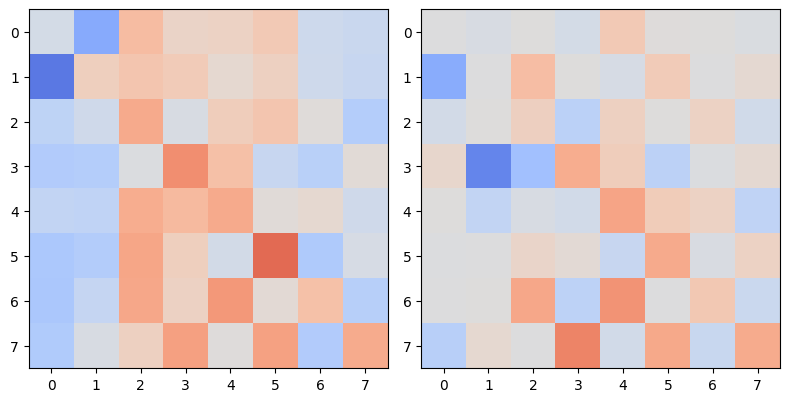

cosine_similarity measure: 0.705
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6699  1.5674
      2        0.5960  1.5007
      3        0.5313  1.5689
      4        0.4755  1.5565
      5        0.4286  1.6912
      6        0.3932  1.5762
      7        0.3769  1.6334
      8        0.3809  1.6026
      9        0.3709  1.6426
     10        0.3521  1.5235
     11        0.3393  1.5637
     12        0.3341  1.5659
     13        0.3321  1.6358
     14        0.3301  1.5326
     15        0.3262  1.4439
     16        0.3207  1.5546
     17        0.3141  1.6042
     18        0.3078  1.5451
     19        0.3046  1.5054
     20        0.3024  1.5641
     21        0.2975  1.6083
     22        0.2907  1.5993
     23        0.2857  1.5993
     24        0.2826  1.5697
     25        0.2801  1.5628
     26        0.2767  1.5049
     27        0.2729  1.5967
     28        0.2698  1.5222
     29        0.2678  1.5155
     30        0.2

    236        0.0769  1.6553
    237        0.0769  1.6135
    238        0.0743  1.5614
    239        0.0741  1.5987
    240        0.0726  1.6251
    241        0.0730  1.5731
    242        0.0763  1.5749
    243        0.0755  1.5158
    244        0.0714  1.5131
    245        0.0755  1.6293
    246        0.0744  1.5807
    247        0.0759  1.5361
    248        0.0830  1.5829
    249        0.0732  1.5997
    250        0.0763  1.5800
    251        0.0768  1.5924
    252        0.0723  1.6624
    253        0.0738  1.6514
    254        0.0725  1.6231
    255        0.0716  1.5816
    256        0.0747  1.5927
    257        0.0711  1.5446
    258        0.0752  1.6613
    259        0.0798  1.5373
    260        0.0716  1.5690
    261        0.0798  1.5281
    262        0.0750  1.6223
    263        0.0755  1.5596
    264        0.0766  1.6167
    265        0.0727  1.6693
    266        0.0790  1.5976
    267        0.0704  1.5752
    268        0.0756  1.6154
    269   

cosine_similarity measure: 0.871
MSE output:
2.8370278415957926e-06
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6363  1.9173
      2        0.5745  1.5376
      3        0.5197  1.6043
      4        0.4728  1.5434
      5        0.4355  1.6847
      6        0.4122  1.6535
      7        0.3987  1.6411
      8        0.3783  1.5486
      9        0.3589  1.6159
     10        0.3483  1.5811
     11        0.3425  1.5659
     12        0.3372  1.6360
     13        0.3309  1.6020
     14        0.3249  1.5936
     15        0.3214  1.5876
     16        0.3176  1.5317
     17        0.3119  1.5717
     18        0.3066  1.5353
     19        0.3027  1.6068
     20        0.2995  1.5735
     21        0.2953  1.6295
     22        0.2911  1.6711
     23        0.2868  1.6461
     24        0.2834  1.6374
     25        0.2803  1.6024
     26        0.2771  1.6134
     27        0.2740  1.6568
     28        0.2711  1.5781
     29      

    236        0.1158  1.6521
    237        0.1117  1.5733
    238        0.1189  1.5236
    239        0.1109  1.5529
    240        0.1131  1.5813
    241        0.1204  1.6124
    242        0.1137  1.5081
    243        0.1070  1.5667
    244        0.1053  1.5902
    245        0.1077  1.5318
    246        0.1115  1.5481
    247        0.1312  1.6241
    248        0.1520  1.5133
    249        0.1148  1.7070
    250        0.1310  1.6516
    251        0.1239  1.5635
    252        0.1263  1.5780
    253        0.1189  1.6834
    254        0.1222  1.5582
    255        0.1087  1.6053
    256        0.1181  1.5752
    257        0.1153  1.5534
    258        0.1317  1.5324
    259        0.1078  1.5453
    260        0.1282  1.6645
    261        0.1106  1.5591
    262        0.1191  1.5499
    263        0.1132  1.6924
    264        0.1257  1.5944
    265        0.1129  1.5834
    266        0.1191  1.5792
    267        0.1223  1.5910
    268        0.1104  1.6563
    269   

cosine_similarity measure: 0.745
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6329  1.5208
      2        0.5668  1.5986
      3        0.5062  1.5052
      4        0.4510  1.6158
      5        0.4035  1.5653
      6        0.3721  1.5909
      7        0.3737  1.4734
      8        0.3669  1.5710
      9        0.3460  1.5483
     10        0.3335  1.5665
     11        0.3307  1.5052
     12        0.3309  1.6130
     13        0.3298  1.5639
     14        0.3256  1.5177
     15        0.3181  1.5883
     16        0.3100  1.5802
     17        0.3032  1.5978
     18        0.3008  1.4969
     19        0.2990  1.5764
     20        0.2924  1.5852
     21        0.2860  1.5622
     22        0.2827  1.5758
     23        0.2814  1.4870
     24        0.2800  1.4777
     25        0.2776  1.5372
     26        0.2741  1.5551
     27        0.2708  1.6501
     28        0.2690  1.5210
     29        0.2678  1.5919
     30        0.2

    238        0.0942  1.5185
    239        0.0950  1.5375
    240        0.0871  1.5096
    241        0.0986  1.6108
    242        0.0935  1.5433
    243        0.0884  1.5801
    244        0.0887  1.6641
    245        0.0893  1.6028
    246        0.0939  1.6347
    247        0.0859  1.5603
    248        0.0872  1.5470
    249        0.0894  1.5705
    250        0.0895  1.4968
    251        0.0906  1.5507
    252        0.0874  1.5331
    253        0.0880  1.5051
    254        0.0946  1.5834
    255        0.0885  1.5585
    256        0.0892  1.5948
    257        0.0868  1.5207
    258        0.0904  1.5361
    259        0.0877  1.6181
    260        0.0881  1.6099
    261        0.0909  1.7569
    262        0.0845  1.6159
    263        0.0911  1.5539
    264        0.0876  1.5424
    265        0.1007  1.5242
    266        0.0912  1.5485
    267        0.0897  1.5431
    268        0.0885  1.5500
    269        0.0950  1.5814
    270        0.0857  1.5273
    271   

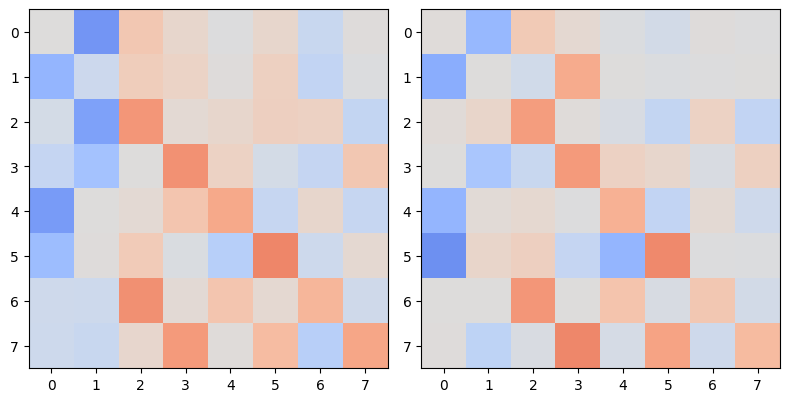

cosine_similarity measure: 0.832
MSE output:
7.228709530594096e-05
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6652  2.0085
      2        0.5975  1.5508
      3        0.5327  1.5039
      4        0.4729  1.5210
      5        0.4220  1.5706
      6        0.3818  1.5637
      7        0.3643  1.5573
      8        0.3668  1.5373
      9        0.3565  1.6065
     10        0.3432  1.5793
     11        0.3370  1.5997
     12        0.3354  1.5088
     13        0.3334  1.5948
     14        0.3287  1.5860
     15        0.3214  1.4791
     16        0.3130  1.5625
     17        0.3054  1.5533
     18        0.3014  1.5277
     19        0.2997  1.6397
     20        0.2959  1.5371
     21        0.2885  1.5861
     22        0.2820  1.4995
     23        0.2784  1.5445
     24        0.2765  1.5917
     25        0.2736  1.5626
     26        0.2693  1.5526
     27        0.2655  1.5946
     28        0.2630  1.6250
     29       

    234        0.0793  1.5454
    235        0.0879  1.5701
    236        0.0799  1.6588
    237        0.0794  1.6659
    238        0.0800  1.7165
    239        0.0740  1.6136
    240        0.0772  1.5394
    241        0.0753  1.6291
    242        0.0861  1.6300
    243        0.0943  1.6468
    244        0.0755  1.6817
    245        0.0820  1.6331
    246        0.0879  1.7339
    247        0.0769  1.6697
    248        0.0971  1.5625
    249        0.0785  1.5219
    250        0.0906  1.5274
    251        0.0893  1.6180
    252        0.0858  1.5546
    253        0.0905  1.6050
    254        0.0788  1.6003
    255        0.0855  1.5655
    256        0.0836  1.6427
    257        0.0813  1.5259
    258        0.0871  1.6409
    259        0.0775  1.5961
    260        0.0833  1.6175
    261        0.0805  1.6659
    262        0.0819  1.6053
    263        0.0772  1.6108
    264        0.0849  1.6487
    265        0.0751  1.6364
    266        0.0855  1.6028
    267   

cosine_similarity measure: 0.811
MSE output:
8.242737673365388e-06
[1.  0.  0.1 0.9 0.1 0.9]
[1.  0.  0.1 0.9 0.3 0.7]
[1.  0.  0.1 0.9 0.4 0.6]
[1.   0.   0.1  0.9  0.45 0.55]
[1.    0.    0.1   0.9   0.475 0.525]
[1.     0.     0.1    0.9    0.4875 0.5125]
[1.      0.      0.1     0.9     0.49375 0.50625]
[1.  0.  0.1 0.9 0.5 0.5]
[1.      0.      0.1     0.9     0.50625 0.49375]
[1.     0.     0.1    0.9    0.5125 0.4875]
[1.    0.    0.1   0.9   0.525 0.475]
[1.   0.   0.1  0.9  0.55 0.45]
[1.  0.  0.1 0.9 0.6 0.4]
[1.  0.  0.1 0.9 0.7 0.3]
[1.  0.  0.1 0.9 0.9 0.1]
[1.  0.  0.3 0.7 0.1 0.9]
[1.  0.  0.3 0.7 0.3 0.7]
[1.  0.  0.3 0.7 0.4 0.6]
[1.   0.   0.3  0.7  0.45 0.55]
[1.    0.    0.3   0.7   0.475 0.525]
[1.     0.     0.3    0.7    0.4875 0.5125]
[1.      0.      0.3     0.7     0.49375 0.50625]
[1.  0.  0.3 0.7 0.5 0.5]
[1.      0.      0.3     0.7     0.50625 0.49375]
[1.     0.     0.3    0.7    0.5125 0.4875]
[1.    0.    0.3   0.7   0.525 0.475]
[1.   0.   0.3  0.7  0.

[1.  0.  0.7 0.3 0.6 0.4]
[1.  0.  0.7 0.3 0.7 0.3]
[1.  0.  0.7 0.3 0.9 0.1]
[1.  0.  0.9 0.1 0.1 0.9]
[1.  0.  0.9 0.1 0.3 0.7]
[1.  0.  0.9 0.1 0.4 0.6]
[1.   0.   0.9  0.1  0.45 0.55]
[1.    0.    0.9   0.1   0.475 0.525]
[1.     0.     0.9    0.1    0.4875 0.5125]
[1.      0.      0.9     0.1     0.49375 0.50625]
[1.  0.  0.9 0.1 0.5 0.5]
[1.      0.      0.9     0.1     0.50625 0.49375]
[1.     0.     0.9    0.1    0.5125 0.4875]
[1.    0.    0.9   0.1   0.525 0.475]
[1.   0.   0.9  0.1  0.55 0.45]
[1.  0.  0.9 0.1 0.6 0.4]
[1.  0.  0.9 0.1 0.7 0.3]
[1.  0.  0.9 0.1 0.9 0.1]
[0.  1.  0.1 0.9 0.1 0.9]
[0.  1.  0.3 0.7 0.1 0.9]
[0.  1.  0.4 0.6 0.1 0.9]
[0.   1.   0.45 0.55 0.1  0.9 ]
[0.    1.    0.475 0.525 0.1   0.9  ]
[0.     1.     0.4875 0.5125 0.1    0.9   ]
[0.      1.      0.49375 0.50625 0.1     0.9    ]
[0.  1.  0.5 0.5 0.1 0.9]
[0.      1.      0.50625 0.49375 0.1     0.9    ]
[0.     1.     0.5125 0.4875 0.1    0.9   ]
[0.    1.    0.525 0.475 0.1   0.9  ]
[0.   1.   0

[0.  1.  0.6 0.4 0.6 0.4]
[0.  1.  0.7 0.3 0.6 0.4]
[0.  1.  0.9 0.1 0.6 0.4]
[0.  1.  0.1 0.9 0.7 0.3]
[0.  1.  0.3 0.7 0.7 0.3]
[0.  1.  0.4 0.6 0.7 0.3]
[0.   1.   0.45 0.55 0.7  0.3 ]
[0.    1.    0.475 0.525 0.7   0.3  ]
[0.     1.     0.4875 0.5125 0.7    0.3   ]
[0.      1.      0.49375 0.50625 0.7     0.3    ]
[0.  1.  0.5 0.5 0.7 0.3]
[0.      1.      0.50625 0.49375 0.7     0.3    ]
[0.     1.     0.5125 0.4875 0.7    0.3   ]
[0.    1.    0.525 0.475 0.7   0.3  ]
[0.   1.   0.55 0.45 0.7  0.3 ]
[0.  1.  0.6 0.4 0.7 0.3]
[0.  1.  0.7 0.3 0.7 0.3]
[0.  1.  0.9 0.1 0.7 0.3]
[0.  1.  0.1 0.9 0.9 0.1]
[0.  1.  0.3 0.7 0.9 0.1]
[0.  1.  0.4 0.6 0.9 0.1]
[0.   1.   0.45 0.55 0.9  0.1 ]
[0.    1.    0.475 0.525 0.9   0.1  ]
[0.     1.     0.4875 0.5125 0.9    0.1   ]
[0.      1.      0.49375 0.50625 0.9     0.1    ]
[0.  1.  0.5 0.5 0.9 0.1]
[0.      1.      0.50625 0.49375 0.9     0.1    ]
[0.     1.     0.5125 0.4875 0.9    0.1   ]
[0.    1.    0.525 0.475 0.9   0.1  ]
[0.   1.   0

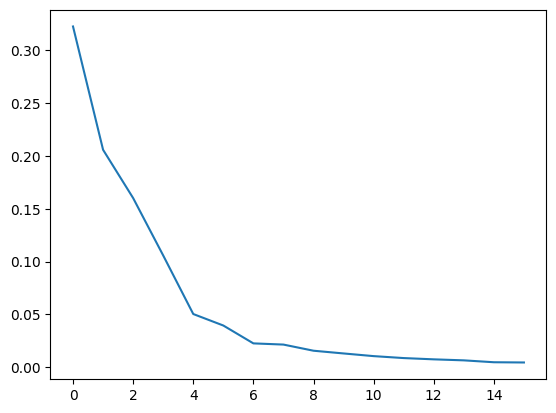

Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7597  1.7804
      2        0.6832  1.6855
      3        0.6118  1.7756
      4        0.5493  1.7687
      5        0.4960  1.6892
      6        0.4531  1.8359
      7        0.4244  1.7590
      8        0.4109  1.7886
      9        0.4036  1.6889
     10        0.3876  1.6633
     11        0.3693  1.6941
     12        0.3568  1.6755
     13        0.3496  1.6431
     14        0.3438  1.6599
     15        0.3372  1.7120
     16        0.3285  1.6374
     17        0.3195  1.6959
     18        0.3124  1.7305
     19        0.3085  1.6762
     20        0.3045  1.7145
     21        0.2969  1.7459
     22        0.2905  1.6970
     23        0.2872  1.6891
     24        0.2846  1.7225
     25        0.2808  1.6575
     26        0.2766  1.7961
     27        0.2730  1.7579
     28        0.2709  1.7649
     29        0.2679  1.7280
     30        0.2642  1.7384
     31        0.2614

    238        0.0797  1.8796
    239        0.0802  1.8618
    240        0.0788  1.9421
    241        0.0831  2.0135
    242        0.0828  1.8639
    243        0.0771  1.8882
    244        0.0814  1.8419
    245        0.0793  1.9236
    246        0.0792  1.8471
    247        0.0809  1.8763
    248        0.0766  1.9567
    249        0.0787  1.8649
    250        0.0774  1.9008
    251        0.0770  1.9281
    252        0.0808  1.8173
    253        0.0840  1.8578
    254        0.0784  1.9236
    255        0.0786  1.8789
    256        0.0806  1.9884
    257        0.0828  1.8349
    258        0.0759  1.8836
    259        0.0804  1.8737
    260        0.0868  1.9522
    261        0.0808  1.9124
    262        0.0881  1.8934
    263        0.0779  1.8178
    264        0.0826  1.9352
    265        0.0769  1.9676
    266        0.0829  1.7880
    267        0.0788  1.9554
    268        0.0788  1.8868
    269        0.0841  1.8682
    270        0.0762  1.9002
    271   

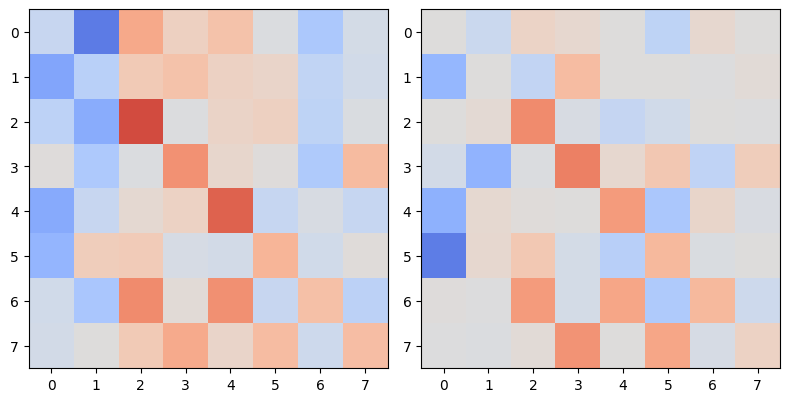

cosine_similarity measure: 0.764
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7600  1.8570
      2        0.6860  1.8619
      3        0.6142  1.8231
      4        0.5488  1.9380
      5        0.4923  1.8905
      6        0.4478  1.8160
      7        0.4207  1.8524
      8        0.4158  1.8442
      9        0.4090  1.8799
     10        0.3891  1.9070
     11        0.3743  1.9151
     12        0.3684  1.8821
     13        0.3660  1.8310
     14        0.3625  1.9081
     15        0.3561  1.8645
     16        0.3472  1.8886
     17        0.3373  1.9348
     18        0.3293  1.9175
     19        0.3253  1.8376
     20        0.3233  1.8618
     21        0.3183  1.9359
     22        0.3108  1.9232
     23        0.3049  1.9853
     24        0.3011  1.8636
     25        0.2982  1.9325
     26        0.2948  1.9787
     27        0.2909  1.9567
     28        0.2867  1.9107
     29        0.2841  1.9141
     30        0.2

    236        0.0891  1.9137
    237        0.0816  1.8633
    238        0.0898  1.9209
    239        0.0798  1.9181
    240        0.0836  1.9785
    241        0.0860  1.9165
    242        0.0789  1.9904
    243        0.0857  1.8837
    244        0.0843  1.9567
    245        0.0829  1.9522
    246        0.0813  1.9741
    247        0.0797  1.9102
    248        0.0835  1.9111
    249        0.0784  1.9086
    250        0.0776  1.8297
    251        0.0804  1.9266
    252        0.0819  1.9802
    253        0.0792  1.8879
    254        0.0771  1.8337
    255        0.0817  1.9785
    256        0.0825  1.8955
    257        0.0831  1.8784
    258        0.0819  1.9141
    259        0.0781  1.9068
    260        0.0802  1.8914
    261        0.0800  1.8550
    262        0.0768  1.9308
    263        0.0798  1.7994
    264        0.0779  1.8930
    265        0.0776  1.9176
    266        0.0826  1.9046
    267        0.0793  1.7935
    268        0.0776  1.9855
    269   

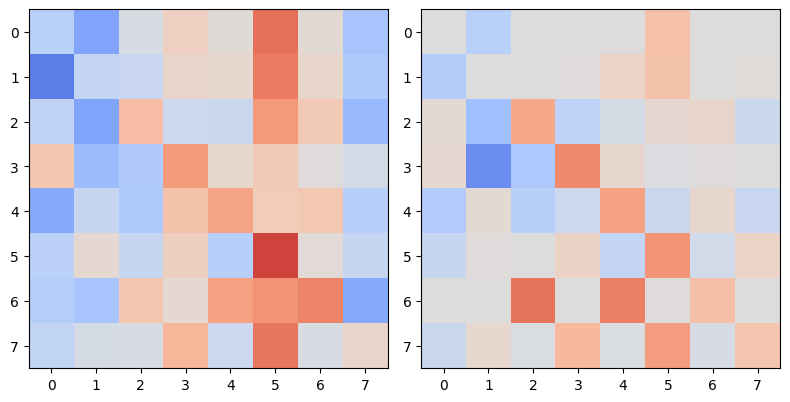

cosine_similarity measure: 0.739
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6781  1.8322
      2        0.6071  1.9480
      3        0.5425  1.8538
      4        0.4852  1.8777
      5        0.4361  2.0157
      6        0.4013  1.8640
      7        0.3967  1.8622
      8        0.4021  1.8403
      9        0.3817  2.0737
     10        0.3625  1.8519
     11        0.3544  1.8644
     12        0.3506  1.9409
     13        0.3462  1.9863
     14        0.3390  1.9372
     15        0.3294  1.9336
     16        0.3186  1.9707
     17        0.3088  1.9726
     18        0.3033  2.0199
     19        0.3038  2.1588
     20        0.3031  1.9998
     21        0.2954  1.8847
     22        0.2879  1.9588
     23        0.2849  1.9618
     24        0.2845  1.8832
     25        0.2834  1.9268
     26        0.2808  1.9961
     27        0.2762  1.9885
     28        0.2723  2.0663
     29        0.2706  2.0918
     30        0.2

    231        0.0935  2.1483
    232        0.1046  2.2315
    233        0.1231  2.2069
    234        0.1137  2.3246
    235        0.1056  2.3247
    236        0.1295  2.2175
    237        0.1122  2.2028
    238        0.1191  2.2583
    239        0.1188  2.1376
    240        0.1130  2.2938
    241        0.1100  2.1209
    242        0.1139  2.3181
    243        0.1109  2.1781
    244        0.1037  2.2293
    245        0.1111  2.3807
    246        0.0979  2.1407
    247        0.1059  2.2108
    248        0.0952  2.0815
    249        0.1068  2.1701
    250        0.0956  2.0771
    251        0.1027  2.0833
    252        0.0951  2.1123
    253        0.1002  2.1105
    254        0.0923  2.1401
    255        0.0972  2.2213
    256        0.0990  2.2251
    257        0.0960  2.1755
    258        0.0937  2.1979
    259        0.1019  2.1642
    260        0.0928  2.1774
    261        0.0960  2.1280
    262        0.0934  2.1844
    263        0.0906  2.1901
    264   

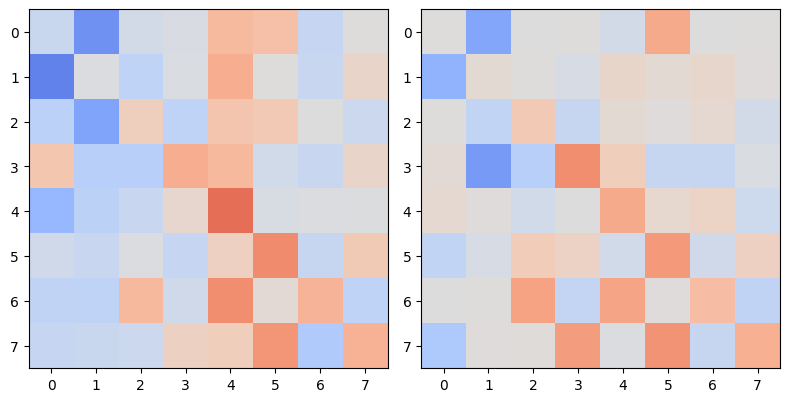

cosine_similarity measure: 0.771
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7018  2.2669
      2        0.6319  2.2008
      3        0.5715  2.1442
      4        0.5192  2.1887
      5        0.4728  2.2316
      6        0.4350  2.2668
      7        0.4141  2.2675
      8        0.4043  2.2023
      9        0.3823  2.2073
     10        0.3584  2.0984
     11        0.3448  2.3627
     12        0.3398  2.2112
     13        0.3366  2.1373
     14        0.3329  2.1099
     15        0.3266  2.2726
     16        0.3207  2.1894
     17        0.3169  2.1384
     18        0.3134  2.1037
     19        0.3057  2.1511
     20        0.2977  2.1871
     21        0.2932  2.2791
     22        0.2903  2.1628
     23        0.2868  2.1976
     24        0.2826  2.1828
     25        0.2784  2.1755
     26        0.2755  2.2238
     27        0.2734  2.2505
     28        0.2700  2.2339
     29        0.2662  2.1688
     30        0.2

    234        0.0838  2.2048
    235        0.0844  2.2504
    236        0.0845  2.1605
    237        0.0873  2.1776
    238        0.0893  2.2559
    239        0.0868  2.2203
    240        0.0827  2.2547
    241        0.0851  2.0721
    242        0.0844  2.2065
    243        0.0846  2.0760
    244        0.0843  2.1326
    245        0.0831  2.1837
    246        0.0843  2.1009
    247        0.0831  2.1854
    248        0.0833  2.1787
    249        0.0824  2.1753
    250        0.0830  2.2131
    251        0.0825  2.1159
    252        0.0827  2.2880
    253        0.0816  2.2049
    254        0.0823  2.1551
    255        0.0821  2.2250
    256        0.0823  2.1792
    257        0.0850  2.1748
    258        0.0869  2.1026
    259        0.0825  2.3151
    260        0.0867  2.2801
    261        0.0867  2.2517
    262        0.0823  2.2375
    263        0.0953  2.3026
    264        0.0905  2.1428
    265        0.0826  2.2744
    266        0.0910  2.1395
    267   

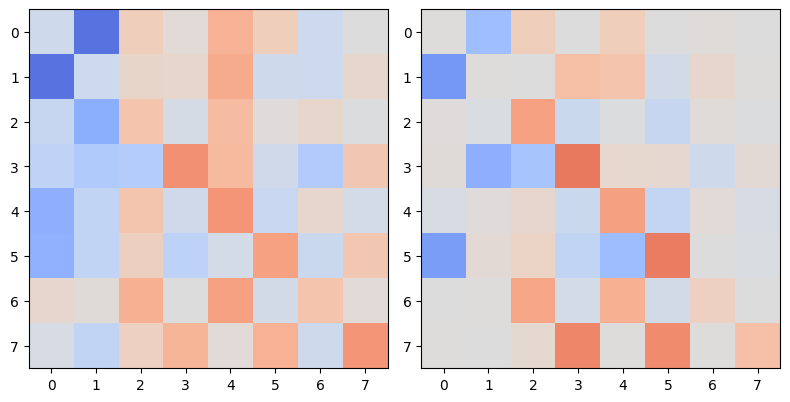

cosine_similarity measure: 0.799
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7354  2.2264
      2        0.6671  2.3431
      3        0.6020  2.3220
      4        0.5425  2.2228
      5        0.4903  2.3902
      6        0.4464  2.3195
      7        0.4190  2.2242
      8        0.4144  2.2137
      9        0.4067  2.1702
     10        0.3881  2.2444
     11        0.3732  2.2148
     12        0.3660  2.2021
     13        0.3625  2.2097
     14        0.3586  2.4219
     15        0.3528  2.3133
     16        0.3451  2.2251
     17        0.3371  2.2472
     18        0.3304  2.2980
     19        0.3255  2.3143
     20        0.3203  2.2834
     21        0.3124  2.3244
     22        0.3037  2.3738
     23        0.2981  2.1665
     24        0.2935  2.3912
     25        0.2895  2.1948
     26        0.2851  2.4916
     27        0.2813  2.2885
     28        0.2780  2.3721
     29        0.2757  2.2265
     30        0.2

    237        0.0923  2.3986
    238        0.0803  2.2526
    239        0.0843  2.2967
    240        0.0897  2.2459
    241        0.0834  2.2776
    242        0.0820  2.3214
    243        0.0925  2.2007
    244        0.0853  2.2516
    245        0.0824  2.2383
    246        0.0852  2.1077
    247        0.0829  2.2790
    248        0.0843  2.2222
    249        0.0800  2.2208
    250        0.0810  2.3127
    251        0.0841  2.1832
    252        0.0883  2.2698
    253        0.0815  2.1538
    254        0.0795  2.1695
    255        0.0856  2.1838
    256        0.0804  2.1244
    257        0.0788  2.1716
    258        0.0844  2.0949
    259        0.0783  2.1417
    260        0.0830  2.1412
    261        0.0794  2.1883
    262        0.0802  2.1609
    263        0.0826  2.0776
    264        0.0770  2.1640
    265        0.0823  2.3313
    266        0.0802  2.1408
    267        0.0782  2.2818
    268        0.0810  2.2791
    269        0.0775  2.2414
    270   

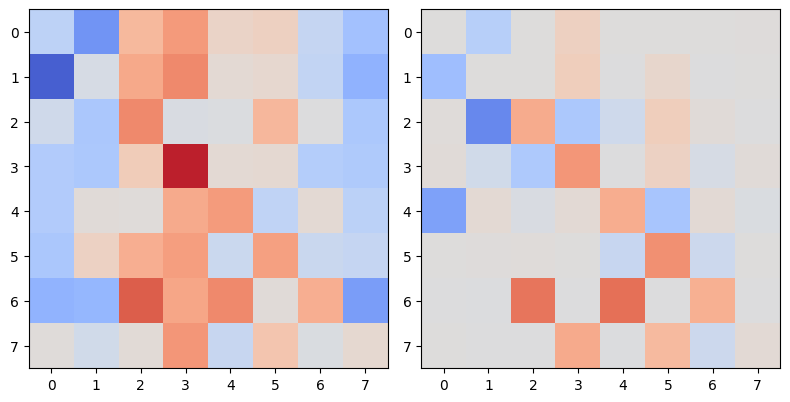

cosine_similarity measure: 0.675
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8161  2.2355
      2        0.7399  2.2441
      3        0.6664  2.1548
      4        0.5998  2.1388
      5        0.5441  2.1831
      6        0.5006  2.1702
      7        0.4699  2.1882
      8        0.4506  2.1380
      9        0.4339  2.1668
     10        0.4124  2.0603
     11        0.3911  2.1048
     12        0.3762  2.1650
     13        0.3667  2.1686
     14        0.3600  2.1885
     15        0.3535  2.1345
     16        0.3475  2.2365
     17        0.3442  2.2915
     18        0.3416  2.1186
     19        0.3360  2.3613
     20        0.3308  2.2409
     21        0.3268  2.2823
     22        0.3225  2.2051
     23        0.3175  2.2254
     24        0.3116  2.2369
     25        0.3066  2.2454
     26        0.3024  2.2667
     27        0.2974  2.2110
     28        0.2919  2.1271
     29        0.2875  2.2141
     30        0.2

    234        0.1374  2.3764
    235        0.1226  2.2626
    236        0.1187  2.2782
    237        0.1219  2.3937
    238        0.1270  2.2069
    239        0.1189  2.3718
    240        0.1104  2.3050
    241        0.1146  2.2438
    242        0.1192  2.2274
    243        0.1165  2.2419
    244        0.1093  2.1509
    245        0.1091  2.2973
    246        0.1123  2.2130
    247        0.1078  2.2557
    248        0.1035  2.1288
    249        0.1075  2.1203
    250        0.1048  2.1091
    251        0.0993  2.1324
    252        0.1050  2.0819
    253        0.0970  2.0961
    254        0.1027  2.3108
    255        0.0959  2.2341
    256        0.1024  2.1990
    257        0.1023  2.2190
    258        0.1085  2.0923
    259        0.0999  2.2799
    260        0.0977  2.1293
    261        0.0957  2.2906
    262        0.0940  2.1729
    263        0.0968  2.3051
    264        0.0928  2.3205
    265        0.0961  2.0921
    266        0.0973  2.2892
    267   

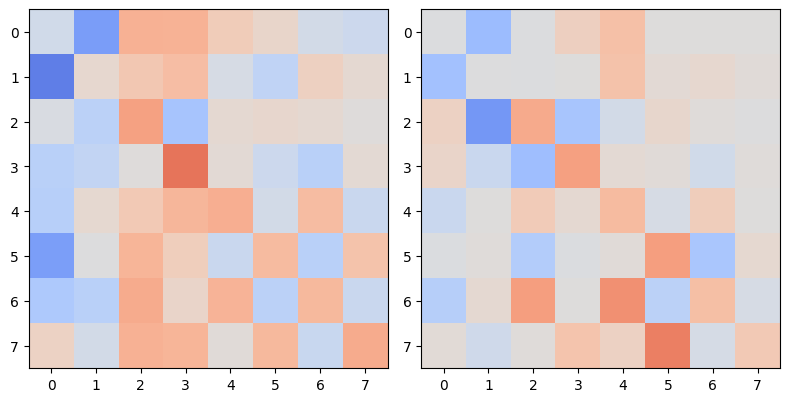

cosine_similarity measure: 0.679
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6782  2.2071
      2        0.6141  2.1753
      3        0.5560  2.2616
      4        0.5015  2.3672
      5        0.4530  2.3321
      6        0.4151  2.3453
      7        0.3939  2.3926
      8        0.3824  2.3920
      9        0.3639  2.2048
     10        0.3467  2.2442
     11        0.3381  2.2580
     12        0.3349  2.1450
     13        0.3323  2.2235
     14        0.3277  2.3356
     15        0.3209  2.3177
     16        0.3140  2.2445
     17        0.3086  2.2174
     18        0.3052  2.2335
     19        0.3011  2.2225
     20        0.2956  2.2592
     21        0.2911  2.1716
     22        0.2877  2.2782
     23        0.2843  2.2288
     24        0.2803  2.1398
     25        0.2761  2.2635
     26        0.2728  2.2238
     27        0.2710  2.1395
     28        0.2682  2.1401
     29        0.2648  2.1889
     30        0.2

    235        0.0808  2.3050
    236        0.0847  2.2060
    237        0.0846  2.3954
    238        0.0831  2.3449
    239        0.0806  2.2120
    240        0.0807  2.2496
    241        0.0847  2.1709
    242        0.0794  2.3449
    243        0.0807  2.2844
    244        0.0846  2.2784
    245        0.0808  2.3194
    246        0.0865  2.2232
    247        0.0826  2.3929
    248        0.0814  2.2728
    249        0.0866  2.2158
    250        0.0784  2.2809
    251        0.0829  2.3770
    252        0.0809  2.2246
    253        0.0792  2.2070
    254        0.0810  2.3019
    255        0.0774  2.3386
    256        0.0789  2.2758
    257        0.0812  2.2866
    258        0.0778  2.2819
    259        0.0779  2.2815
    260        0.0792  2.3290
    261        0.0773  2.2616
    262        0.0769  2.3851
    263        0.0772  2.3364
    264        0.0768  2.3122
    265        0.0769  2.1990
    266        0.0756  2.2221
    267        0.0770  2.3632
    268   

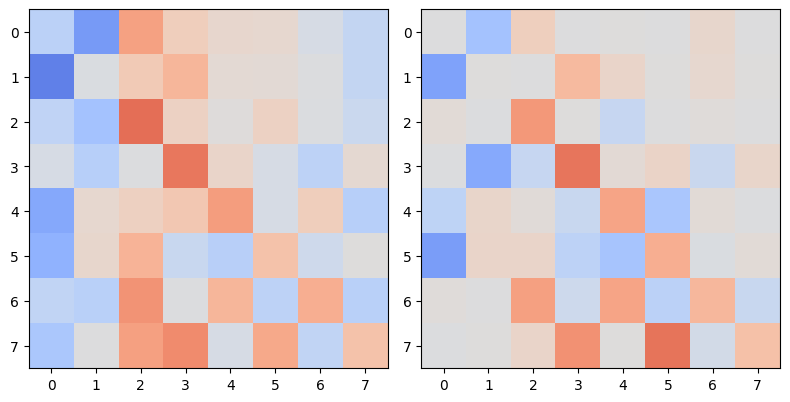

cosine_similarity measure: 0.822
MSE output:
5.911157968073642e-05
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6757  2.3013
      2        0.6137  2.2832
      3        0.5573  2.3075
      4        0.5036  2.2219
      5        0.4544  2.1664
      6        0.4155  2.1952
      7        0.4057  1.8533
      8        0.3997  1.8564
      9        0.3750  2.0665
     10        0.3557  1.9752
     11        0.3475  2.0097
     12        0.3443  1.9359
     13        0.3403  1.9491
     14        0.3344  2.0481
     15        0.3271  2.0066
     16        0.3206  1.9607
     17        0.3176  2.0515
     18        0.3168  1.9418
     19        0.3110  1.9736
     20        0.3026  1.9280
     21        0.2972  1.7956
     22        0.2941  2.2754
     23        0.2905  2.7255
     24        0.2863  1.7824
     25        0.2810  1.8194
     26        0.2768  1.6476
     27        0.2744  1.5579
     28        0.2731  1.6316
     29       

    235        0.0904  1.9987
    236        0.1016  1.8877
    237        0.0858  2.0853
    238        0.0977  2.1732
    239        0.0847  2.2196
    240        0.0951  2.3357
    241        0.0897  2.3277
    242        0.0921  2.2530
    243        0.0883  2.2922
    244        0.0900  2.3007
    245        0.0836  2.1786
    246        0.0901  2.1021
    247        0.0899  2.1829
    248        0.1058  2.1147
    249        0.0855  2.1139
    250        0.0892  2.1817
    251        0.0808  2.2443
    252        0.0904  2.1130
    253        0.0803  2.0031
    254        0.0858  2.1579
    255        0.0805  2.3371
    256        0.0840  2.6773
    257        0.0831  2.6114
    258        0.0820  2.3987
    259        0.0843  2.4297
    260        0.0789  2.4499
    261        0.0814  2.3665
    262        0.0801  2.5351
    263        0.0795  2.4922
    264        0.0805  2.5147
    265        0.0778  2.3761
    266        0.0797  2.3870
    267        0.0776  2.4425
    268   

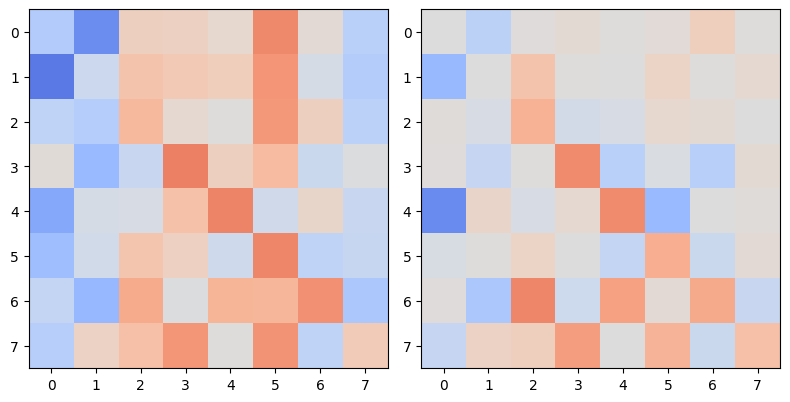

cosine_similarity measure: 0.768
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7182  2.3306
      2        0.6389  2.3384
      3        0.5710  2.2130
      4        0.5139  2.3164
      5        0.4656  2.2328
      6        0.4260  2.2289
      7        0.3985  2.2197
      8        0.3898  2.2544
      9        0.3899  2.3577
     10        0.3778  2.2728
     11        0.3587  2.2209
     12        0.3443  2.2998
     13        0.3369  2.2479
     14        0.3328  2.3530
     15        0.3283  2.2058
     16        0.3224  2.2981
     17        0.3143  2.3460
     18        0.3055  2.2165
     19        0.2978  2.2407
     20        0.2942  2.2875
     21        0.2926  2.2192
     22        0.2868  2.2894
     23        0.2796  2.2597
     24        0.2750  2.2671
     25        0.2728  2.2427
     26        0.2706  2.2484
     27        0.2672  2.3096
     28        0.2630  2.2558
     29        0.2599  2.2253
     30        0.2

    238        0.0790  2.3663
    239        0.0795  2.3698
    240        0.0785  2.3280
    241        0.0798  2.3635
    242        0.0801  2.4107
    243        0.0813  2.2975
    244        0.0773  2.2839
    245        0.0805  2.2293
    246        0.0802  2.1945
    247        0.0769  2.2993
    248        0.0810  2.2721
    249        0.0784  2.2434
    250        0.0795  2.2222
    251        0.0779  2.2449
    252        0.0801  2.1898
    253        0.0845  2.2094
    254        0.0757  2.2775
    255        0.0786  2.3106
    256        0.0774  2.3486
    257        0.0769  2.3263
    258        0.0788  2.3190
    259        0.0765  2.2566
    260        0.0756  2.3243
    261        0.0794  2.2665
    262        0.0769  2.2787
    263        0.0762  2.2161
    264        0.0790  2.2805
    265        0.0771  2.3052
    266        0.0753  2.3073
    267        0.0766  2.2297
    268        0.0765  2.3275
    269        0.0765  2.2986
    270        0.0748  2.3325
    271   

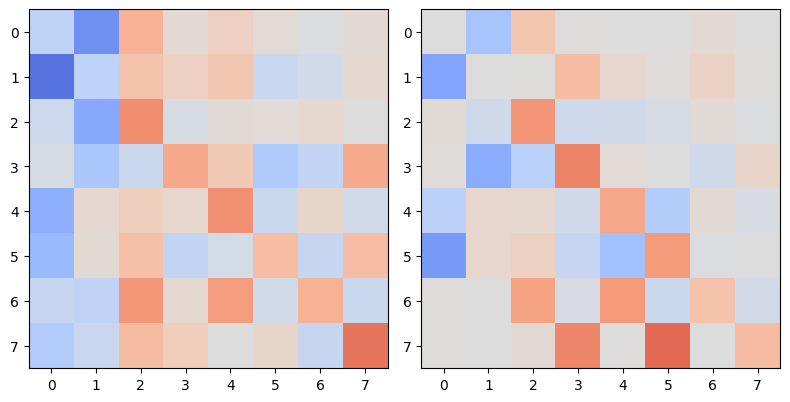

cosine_similarity measure: 0.748
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7099  2.3314
      2        0.6395  2.3451
      3        0.5720  2.2904
      4        0.5072  2.2171
      5        0.4473  2.2533
      6        0.4023  2.2139
      7        0.3901  2.2922
      8        0.3837  2.2997
      9        0.3610  2.2505
     10        0.3456  2.2283
     11        0.3404  2.2988
     12        0.3385  2.1836
     13        0.3355  2.1923
     14        0.3303  2.2595
     15        0.3231  2.3181
     16        0.3160  2.2453
     17        0.3110  2.2524
     18        0.3098  2.2390
     19        0.3083  2.2583
     20        0.3020  2.2373
     21        0.2957  2.2723
     22        0.2917  2.3539
     23        0.2893  2.2770
     24        0.2863  2.2128
     25        0.2814  2.2528
     26        0.2760  2.2535
     27        0.2717  2.2512
     28        0.2693  2.1836
     29        0.2679  2.2539
     30        0.2

    230        0.0778  2.2655
    231        0.0772  2.1920
    232        0.0774  2.2695
    233        0.0767  2.2832
    234        0.0774  2.3109
    235        0.0814  2.3213
    236        0.0841  2.3363
    237        0.0802  2.3649
    238        0.0775  2.3235
    239        0.0801  2.2426
    240        0.0792  2.2928
    241        0.0777  2.2810
    242        0.0794  2.3383
    243        0.0783  2.2887
    244        0.0763  2.3437
    245        0.0772  2.3241
    246        0.0780  2.2990
    247        0.0789  2.4000
    248        0.0770  2.3265
    249        0.0819  2.4219
    250        0.0805  2.3283
    251        0.0759  2.3761
    252        0.0802  2.3584
    253        0.0781  2.3039
    254        0.0785  2.3958
    255        0.0797  2.3474
    256        0.0763  2.2612
    257        0.0768  2.2815
    258        0.0778  2.3366
    259        0.0762  2.3716
    260        0.0780  2.2937
    261        0.0755  2.3392
    262        0.0744  2.3920
    263   

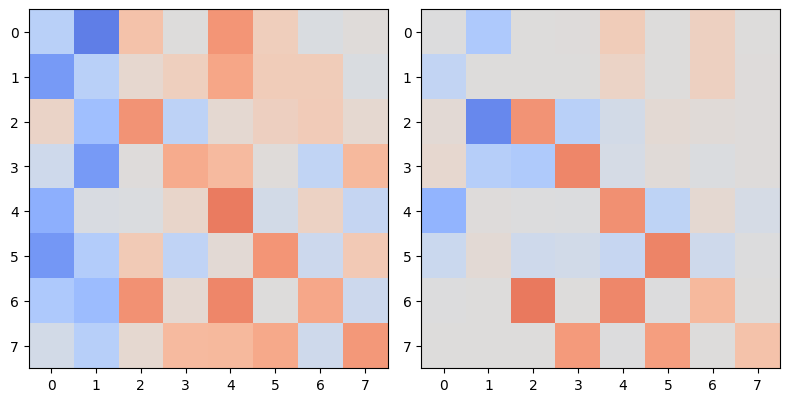

cosine_similarity measure: 0.75
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7797  2.4652
      2        0.7021  2.3166
      3        0.6301  2.3224
      4        0.5641  2.2986
      5        0.5066  2.3653
      6        0.4610  2.2977
      7        0.4289  2.2364
      8        0.4126  2.3279
      9        0.4058  2.3173
     10        0.3935  2.2677
     11        0.3762  2.2972
     12        0.3625  2.3058
     13        0.3541  2.2691
     14        0.3490  2.2934
     15        0.3443  2.4532
     16        0.3380  2.5337
     17        0.3308  2.5079
     18        0.3236  2.4798
     19        0.3186  2.4648
     20        0.3154  2.4706
     21        0.3102  2.4099
     22        0.3035  2.4175
     23        0.2983  2.4223
     24        0.2952  2.4061
     25        0.2923  2.4399
     26        0.2885  2.4422
     27        0.2841  2.3483
     28        0.2807  2.3948
     29        0.2784  2.2528
     30        0.27

    237        0.0794  2.0555
    238        0.0800  2.0556
    239        0.0793  2.0540
    240        0.0817  2.0868
    241        0.0761  2.0542
    242        0.0780  2.0135
    243        0.0783  2.0573
    244        0.0762  2.0084
    245        0.0806  2.0547
    246        0.0776  2.0845
    247        0.0776  1.9872
    248        0.0787  2.0640
    249        0.0758  1.9492
    250        0.0779  2.0467
    251        0.0798  2.0578
    252        0.0762  2.0342
    253        0.0743  2.0009
    254        0.0752  2.0762
    255        0.0757  2.0179
    256        0.0749  1.9954
    257        0.0750  2.0610
    258        0.0755  2.0357
    259        0.0761  1.9814
    260        0.0750  1.9964
    261        0.0759  2.0602
    262        0.0769  2.0492
    263        0.0767  2.0130
    264        0.0770  2.0556
    265        0.0767  2.0370
    266        0.0752  2.0135
    267        0.0755  2.0032
    268        0.0763  2.0064
    269        0.0748  2.0201
    270   

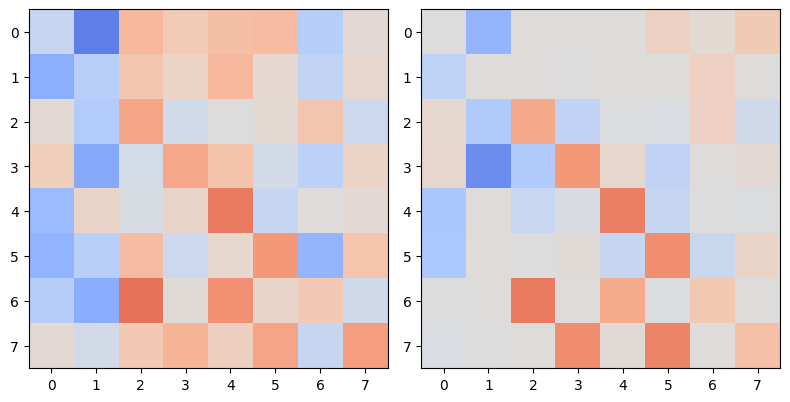

cosine_similarity measure: 0.796
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7839  1.9479
      2        0.7078  2.0531
      3        0.6364  1.9859
      4        0.5710  1.9807
      5        0.5140  1.9837
      6        0.4667  2.0035
      7        0.4331  2.0171
      8        0.4163  1.9997
      9        0.4068  1.9906
     10        0.3914  1.9818
     11        0.3735  1.9979
     12        0.3596  1.9504
     13        0.3518  1.9967
     14        0.3472  2.0511
     15        0.3432  2.0372
     16        0.3384  1.9630
     17        0.3334  1.9883
     18        0.3292  2.0727
     19        0.3270  2.0286
     20        0.3246  1.9955
     21        0.3183  1.9293
     22        0.3112  2.0078
     23        0.3063  1.9759
     24        0.3020  2.0485
     25        0.2970  2.0862
     26        0.2909  1.9772
     27        0.2855  1.9950
     28        0.2814  1.9201
     29        0.2779  2.0685
     30        0.2

    235        0.0901  1.8398
    236        0.0839  1.9768
    237        0.0829  1.8449
    238        0.0937  1.9298
    239        0.0901  1.9051
    240        0.0857  1.9028
    241        0.0911  1.8359
    242        0.0832  1.8354
    243        0.0865  1.8928
    244        0.0795  1.9599
    245        0.0863  1.9158
    246        0.0841  1.9489
    247        0.0798  1.8869
    248        0.0871  1.8727
    249        0.0878  1.9026
    250        0.0831  1.9829
    251        0.0876  2.0034
    252        0.0817  2.0214
    253        0.0857  2.0466
    254        0.0813  1.9466
    255        0.0783  2.0206
    256        0.0827  2.0041
    257        0.0771  2.0166
    258        0.0845  2.0345
    259        0.0826  2.0095
    260        0.0806  1.9561
    261        0.0934  2.0351
    262        0.0942  2.0165
    263        0.0976  1.9787
    264        0.0893  2.0281
    265        0.1060  2.0289
    266        0.0810  2.0436
    267        0.0937  1.9563
    268   

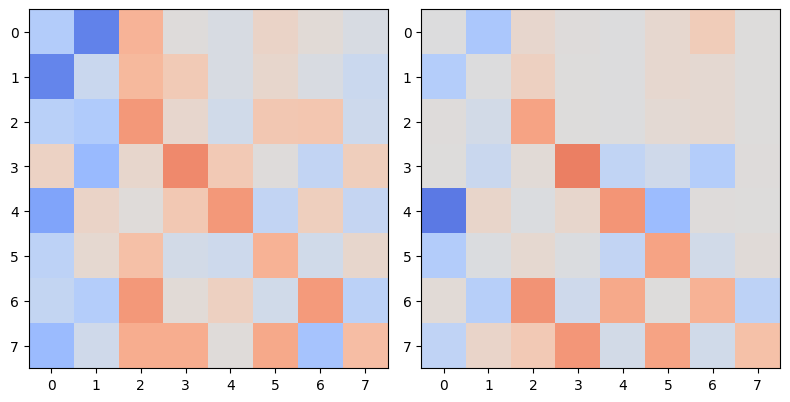

cosine_similarity measure: 0.808
MSE output:
4.059551298583888e-06
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7464  2.2544
      2        0.6694  2.3181
      3        0.6007  2.2168
      4        0.5425  2.2301
      5        0.4933  2.1275
      6        0.4546  2.1475
      7        0.4292  2.1938
      8        0.4125  2.2227
      9        0.3960  2.2962
     10        0.3779  2.1942
     11        0.3629  2.2052
     12        0.3534  2.1699
     13        0.3457  2.1887
     14        0.3377  2.1824
     15        0.3294  2.2372
     16        0.3220  2.2418
     17        0.3170  2.1311
     18        0.3112  1.8021
     19        0.3048  1.8865
     20        0.2998  1.9168
     21        0.2963  2.0429
     22        0.2919  1.8606
     23        0.2868  1.9144
     24        0.2819  1.9195
     25        0.2782  1.9716
     26        0.2742  1.9824
     27        0.2700  1.9506
     28        0.2664  1.9089
     29       

    232        0.0759  2.5255
    233        0.0759  2.3312
    234        0.0741  2.3617
    235        0.0764  2.3266
    236        0.0790  2.3158
    237        0.0774  2.2867
    238        0.0758  2.2667
    239        0.0769  2.3104
    240        0.0779  2.3465
    241        0.0776  2.3019
    242        0.0769  2.3422
    243        0.0761  2.3334
    244        0.0784  2.3686
    245        0.0830  2.2491
    246        0.0780  2.0960
    247        0.0749  2.2142
    248        0.0805  2.1605
    249        0.0773  2.2011
    250        0.0757  2.2606
    251        0.0764  2.3112
    252        0.0758  2.2853
    253        0.0741  2.3325
    254        0.0748  2.2299
    255        0.0766  2.3126
    256        0.0737  2.3107
    257        0.0726  2.3860
    258        0.0738  2.3150
    259        0.0743  2.2823
    260        0.0737  2.2610
    261        0.0778  2.3187
    262        0.0780  2.2652
    263        0.0727  2.2636
    264        0.0781  2.2462
    265   

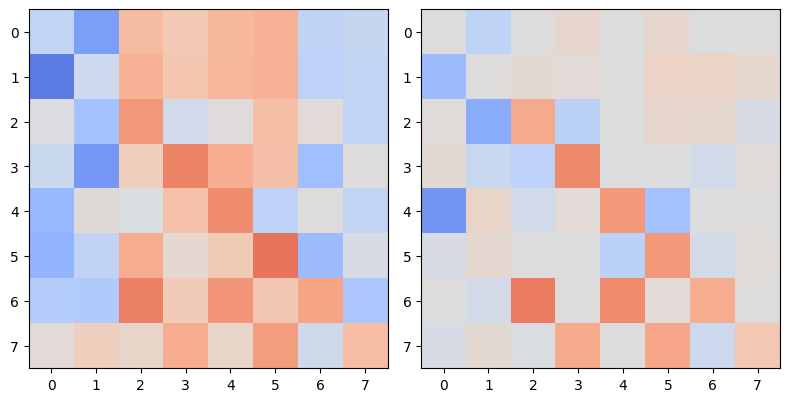

cosine_similarity measure: 0.729
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7215  2.4125
      2        0.6458  2.3551
      3        0.5763  2.2398
      4        0.5142  2.2653
      5        0.4615  2.3678
      6        0.4226  2.3069
      7        0.4049  2.3729
      8        0.3985  2.2718
      9        0.3785  2.3253
     10        0.3560  2.2712
     11        0.3426  2.2412
     12        0.3367  2.3669
     13        0.3320  2.2893
     14        0.3264  2.2425
     15        0.3201  2.3046
     16        0.3165  2.3357
     17        0.3173  2.2999
     18        0.3147  2.2885
     19        0.3094  2.2851
     20        0.3066  2.2754
     21        0.3051  2.3280
     22        0.3025  2.3492
     23        0.2979  2.2832
     24        0.2929  2.2910
     25        0.2898  2.3354
     26        0.2883  2.4190
     27        0.2849  2.3410
     28        0.2814  2.3785
     29        0.2789  2.3241
     30        0.2

    239        0.0918  2.3633
    240        0.0855  2.2956
    241        0.0900  2.2840
    242        0.0924  2.3294
    243        0.0869  2.3168
    244        0.0947  2.3671
    245        0.0890  2.3576
    246        0.0942  2.4114
    247        0.0908  2.4534
    248        0.0923  2.2893
    249        0.0882  2.3342
    250        0.0884  2.2879
    251        0.0866  2.3547
    252        0.0854  2.2795
    253        0.0847  2.2631
    254        0.0850  2.3198
    255        0.0882  2.3224
    256        0.0856  2.3488
    257        0.0848  2.3498
    258        0.0864  2.2837
    259        0.0838  2.2638
    260        0.0854  2.2394
    261        0.0855  2.2941
    262        0.0823  2.3147
    263        0.0843  2.3148
    264        0.0829  2.1771
    265        0.0852  2.2930
    266        0.0883  2.2065
    267        0.0867  2.1730
    268        0.0847  2.3508
    269        0.0834  2.2279
    270        0.0823  2.2600
    271        0.0832  2.3025
    272   

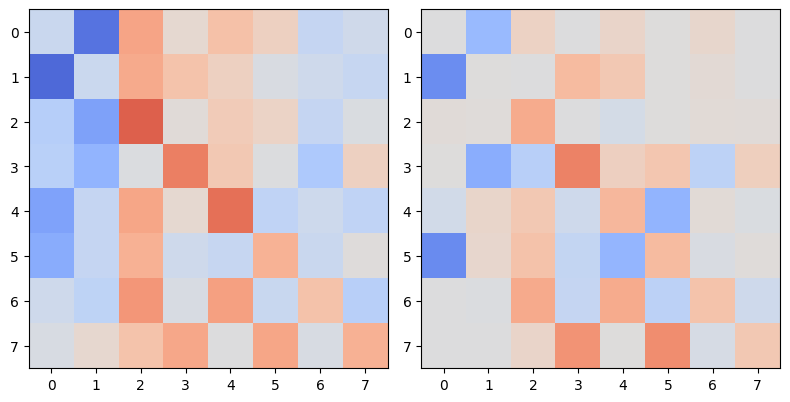

cosine_similarity measure: 0.791
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6592  2.4425
      2        0.5963  2.4371
      3        0.5402  2.4521
      4        0.4890  2.4097
      5        0.4434  2.4192
      6        0.4087  2.3284
      7        0.3957  2.3562
      8        0.3817  2.3938
      9        0.3559  2.4277
     10        0.3379  2.4130
     11        0.3296  2.4106
     12        0.3246  2.3769
     13        0.3195  2.3766
     14        0.3136  2.3361
     15        0.3096  2.3073
     16        0.3100  2.3685
     17        0.3087  2.3613
     18        0.3019  2.3315
     19        0.2952  2.4087
     20        0.2911  2.3786
     21        0.2875  2.3842
     22        0.2836  2.4158
     23        0.2792  2.3470
     24        0.2747  2.3630
     25        0.2712  2.3616
     26        0.2676  2.4438
     27        0.2633  2.3866
     28        0.2583  2.3727
     29        0.2549  2.3452
     30        0.2

    239        0.0743  2.2990
    240        0.0755  2.3206
    241        0.0748  2.3681
    242        0.0753  2.4410
    243        0.0769  2.4910
    244        0.0744  2.4145
    245        0.0766  2.4940
    246        0.0761  2.4417
    247        0.0759  2.5418
    248        0.0806  2.3484
    249        0.0771  2.3886
    250        0.0748  2.4339
    251        0.0762  2.4457
    252        0.0749  2.4095
    253        0.0748  2.4660
    254        0.0770  2.4624
    255        0.0759  2.3782
    256        0.0780  2.4120
    257        0.0765  2.3158
    258        0.0746  2.3668
    259        0.0827  2.3456
    260        0.0758  2.3511
    261        0.0763  2.4344
    262        0.0793  2.3568
    263        0.0751  2.3803
    264        0.0792  2.2986
    265        0.0758  2.3248
    266        0.0777  2.3543
    267        0.0744  2.4414
    268        0.0772  2.4749
    269        0.0798  2.4531
    270        0.0766  2.4532
    271        0.0771  2.4516
    272   

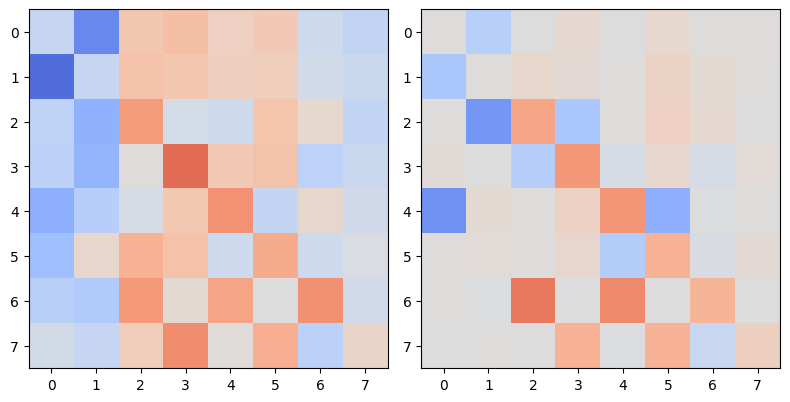

cosine_similarity measure: 0.758
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7198  2.3969
      2        0.6511  2.3384
      3        0.5893  2.2448
      4        0.5368  2.2391
      5        0.4950  2.3066
      6        0.4669  2.2475
      7        0.4484  2.2929
      8        0.4259  2.2315
      9        0.3999  2.1554
     10        0.3779  2.1525
     11        0.3626  2.1844
     12        0.3506  2.2989
     13        0.3398  2.4448
     14        0.3321  2.4440
     15        0.3299  2.3178
     16        0.3273  2.3228
     17        0.3212  2.2666
     18        0.3155  2.2914
     19        0.3103  2.2640
     20        0.3038  2.3364
     21        0.2969  2.2953
     22        0.2904  2.3013
     23        0.2858  2.2948
     24        0.2813  2.3584
     25        0.2763  2.2925
     26        0.2722  2.3178
     27        0.2691  2.3315
     28        0.2656  2.3442
     29        0.2619  2.2613
     30        0.2

    232        0.0844  1.5806
    233        0.0832  1.5578
    234        0.0788  1.6149
    235        0.0825  1.5175
    236        0.0855  1.5162
    237        0.0795  1.5632
    238        0.0794  1.5324
    239        0.0820  1.5446
    240        0.0785  1.5544
    241        0.0796  1.5959
    242        0.0803  1.6601
    243        0.0786  1.5470
    244        0.0797  1.5825
    245        0.0795  1.5823
    246        0.0786  1.5625
    247        0.0781  1.5389
    248        0.0791  1.5321
    249        0.0781  1.5644
    250        0.0782  1.5546
    251        0.0791  1.5829
    252        0.0796  1.6248
    253        0.0768  1.6455
    254        0.0780  1.5461
    255        0.0822  1.5539
    256        0.0783  1.5833
    257        0.0778  1.4863
    258        0.0808  1.5388
    259        0.0769  1.6267
    260        0.0799  1.5120
    261        0.0818  1.6284
    262        0.0786  1.5508
    263        0.0770  1.5348
    264        0.0792  1.4847
    265   

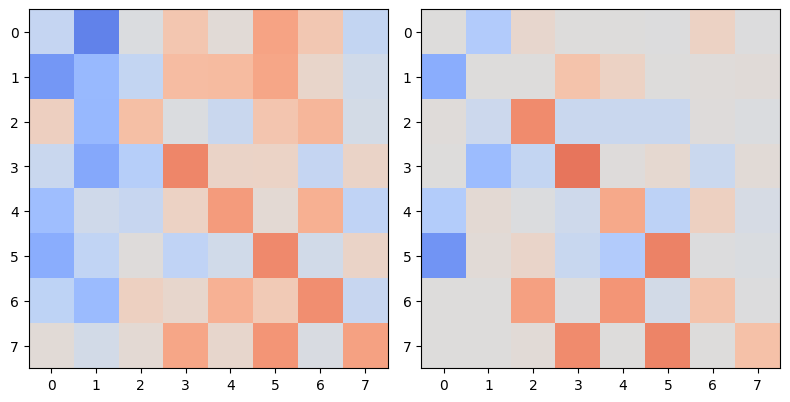

cosine_similarity measure: 0.759
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7129  1.6123
      2        0.6364  1.5886
      3        0.5644  1.5809
      4        0.4999  1.5288
      5        0.4445  1.5218
      6        0.4039  1.5270
      7        0.3891  1.5264
      8        0.3975  1.6237
      9        0.3833  1.6193
     10        0.3611  1.5635
     11        0.3485  1.6016
     12        0.3447  1.5416
     13        0.3429  1.5630
     14        0.3399  1.6230
     15        0.3337  1.5829
     16        0.3249  1.5117
     17        0.3153  1.5778
     18        0.3087  1.5228
     19        0.3064  1.5789
     20        0.3041  1.5417
     21        0.2962  1.5629
     22        0.2891  1.5640
     23        0.2861  1.5217
     24        0.2851  1.6062
     25        0.2837  1.5004
     26        0.2807  1.5969
     27        0.2765  1.4966
     28        0.2728  1.6201
     29        0.2710  1.5349
     30        0.2

    235        0.1111  1.5512
    236        0.0990  1.5201
    237        0.1047  1.6101
    238        0.0994  1.4987
    239        0.1051  1.5079
    240        0.0983  1.5413
    241        0.1016  1.5822
    242        0.1048  1.5938
    243        0.0973  1.4946
    244        0.1017  1.6755
    245        0.0963  1.6048
    246        0.1053  1.4914
    247        0.1011  1.5827
    248        0.1024  1.5001
    249        0.1028  1.4904
    250        0.0989  1.5070
    251        0.1024  1.4877
    252        0.0964  1.5399
    253        0.1007  1.5964
    254        0.0993  1.5429
    255        0.0956  1.5097
    256        0.0959  1.5065
    257        0.0972  1.5745
    258        0.0990  1.6200
    259        0.1017  1.4806
    260        0.0977  1.4738
    261        0.0944  1.4714
    262        0.0953  1.5317
    263        0.0959  1.5343
    264        0.0941  1.5630
    265        0.0964  1.5595
    266        0.0976  1.4916
    267        0.0977  1.6145
    268   

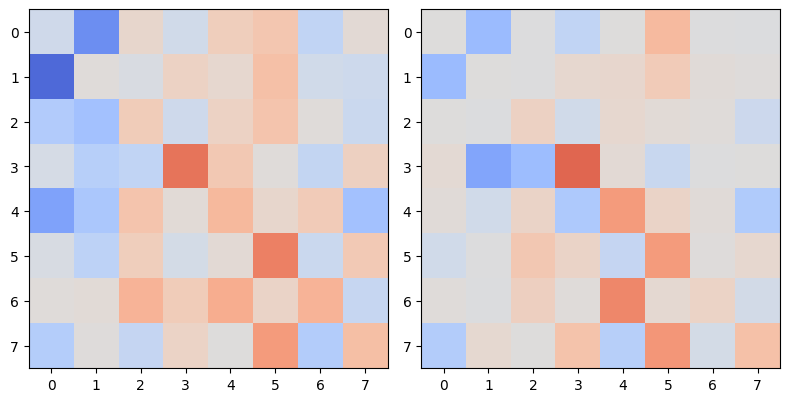

cosine_similarity measure: 0.757
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7297  1.5404
      2        0.6606  1.5384
      3        0.5990  1.5174
      4        0.5468  1.5553
      5        0.5031  1.5545
      6        0.4674  1.5096
      7        0.4430  1.4743
      8        0.4263  1.4864
      9        0.4058  1.6257
     10        0.3828  1.6418
     11        0.3644  1.5579
     12        0.3513  1.4764
     13        0.3402  1.5549
     14        0.3290  1.5784
     15        0.3189  1.5299
     16        0.3148  1.4913
     17        0.3131  1.4996
     18        0.3083  1.5273
     19        0.3053  1.4763
     20        0.3040  1.4997
     21        0.3009  1.5458
     22        0.2961  1.5948
     23        0.2921  1.5688
     24        0.2890  1.4708
     25        0.2858  1.5925
     26        0.2813  1.5030
     27        0.2771  1.5487
     28        0.2739  1.6691
     29        0.2705  1.5008
     30        0.2

    236        0.1010  1.4975
    237        0.0928  1.5669
    238        0.0920  1.4949
    239        0.1004  1.5064
    240        0.0902  1.4896
    241        0.0909  1.5257
    242        0.0895  1.6065
    243        0.0897  1.5985
    244        0.0953  1.5979
    245        0.0973  1.5775
    246        0.1011  1.5600
    247        0.0882  1.5343
    248        0.0872  1.5697
    249        0.0946  1.5174
    250        0.0950  1.5754
    251        0.0863  1.5253
    252        0.0871  1.5467
    253        0.0936  1.4501
    254        0.0865  1.5635
    255        0.0871  1.5690
    256        0.0904  1.5024
    257        0.1050  1.5120
    258        0.0931  1.5040
    259        0.0842  1.5040
    260        0.0873  1.4752
    261        0.0931  1.4987
    262        0.0895  1.5601
    263        0.0835  1.5344
    264        0.0835  1.5381
    265        0.0864  1.5526
    266        0.0875  1.5695
    267        0.0841  1.6065
    268        0.0828  1.4918
    269   

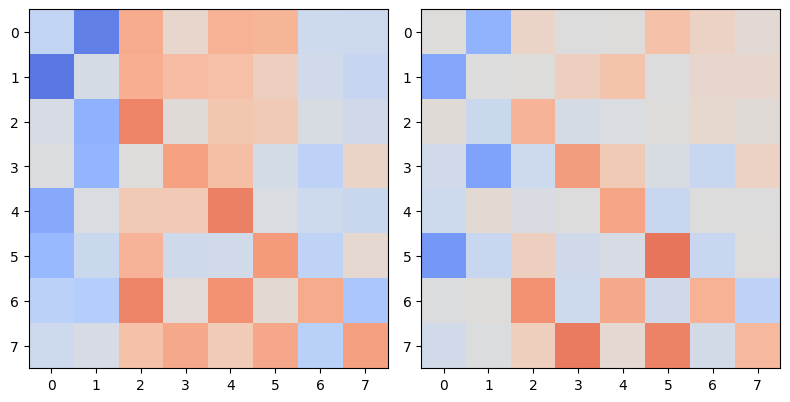

cosine_similarity measure: 0.834
MSE output:
0.0002071996370461433
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7048  1.7416
      2        0.6327  1.6237
      3        0.5699  1.5589
      4        0.5164  1.5873
      5        0.4712  1.5520
      6        0.4366  1.5584
      7        0.4173  1.5355
      8        0.4061  1.5500
      9        0.3866  1.5693
     10        0.3659  1.5806
     11        0.3531  1.5597
     12        0.3467  1.6108
     13        0.3415  1.5405
     14        0.3346  1.5348
     15        0.3270  1.4955
     16        0.3223  1.4821
     17        0.3194  1.5597
     18        0.3145  1.5484
     19        0.3091  1.5626
     20        0.3067  1.5131
     21        0.3045  1.5244
     22        0.3006  1.4920
     23        0.2953  1.5212
     24        0.2898  1.5024
     25        0.2857  1.5842
     26        0.2825  1.6063
     27        0.2793  1.5517
     28        0.2770  1.5393
     29       

    234        0.0791  1.5835
    235        0.0832  1.5501
    236        0.0793  1.6439
    237        0.0799  1.6171
    238        0.0797  1.5454
    239        0.0778  1.6228
    240        0.0867  1.6004
    241        0.0834  1.5714
    242        0.0796  1.5800
    243        0.0862  1.6240
    244        0.0779  1.6314
    245        0.0840  1.6628
    246        0.0812  1.5226
    247        0.0778  1.6525
    248        0.0842  1.5152
    249        0.0778  1.5852
    250        0.0801  1.5122
    251        0.0807  1.5722
    252        0.0787  1.6416
    253        0.0884  1.5510
    254        0.0796  1.5936
    255        0.0809  1.5415
    256        0.0773  1.5129
    257        0.0791  1.6885
    258        0.0834  1.5190
    259        0.0767  1.5692
    260        0.0830  1.5638
    261        0.0773  1.6623
    262        0.0815  1.5956
    263        0.0773  1.5702
    264        0.0804  1.6105
    265        0.0855  1.5616
    266        0.0771  1.5544
    267   

cosine_similarity measure: 0.782
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7070  1.5435
      2        0.6402  1.5260
      3        0.5814  1.7038
      4        0.5287  1.5667
      5        0.4810  1.5560
      6        0.4415  1.5956
      7        0.4201  1.6158
      8        0.4136  1.6029
      9        0.3938  1.5656
     10        0.3708  1.5305
     11        0.3572  1.5218
     12        0.3507  1.5059
     13        0.3457  1.5555
     14        0.3389  1.4977
     15        0.3305  1.5501
     16        0.3227  1.5303
     17        0.3185  1.6340
     18        0.3168  1.5608
     19        0.3106  1.4975
     20        0.3027  1.5569
     21        0.2986  1.5957
     22        0.2968  1.5600
     23        0.2944  1.5473
     24        0.2906  1.4839
     25        0.2867  1.5711
     26        0.2844  1.5419
     27        0.2827  1.6347
     28        0.2793  1.4900
     29        0.2753  1.5351
     30        0.2

    236        0.0891  1.5767
    237        0.0858  1.5906
    238        0.0901  1.5604
    239        0.0883  1.5648
    240        0.0873  1.5031
    241        0.0893  1.5085
    242        0.0845  1.5918
    243        0.0937  1.5913
    244        0.0845  1.5549
    245        0.0878  1.4933
    246        0.0868  1.5360
    247        0.0863  1.5132
    248        0.0894  1.5205
    249        0.0825  1.4711
    250        0.0877  1.5450
    251        0.0829  1.5112
    252        0.0844  1.4797
    253        0.0835  1.4722
    254        0.0837  1.5321
    255        0.0881  1.5107
    256        0.0864  1.5826
    257        0.0829  1.4899
    258        0.0848  1.5555
    259        0.0857  1.5188
    260        0.0864  1.6351
    261        0.0868  1.4909
    262        0.0827  1.4948
    263        0.0858  1.6033
    264        0.0878  1.5294
    265        0.0850  1.5821
    266        0.0848  1.6409
    267        0.0836  1.4743
    268        0.0841  1.5222
    269   

cosine_similarity measure: 0.778
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8013  1.5294
      2        0.7238  1.5220
      3        0.6493  1.5278
      4        0.5811  1.4857
      5        0.5224  1.5858
      6        0.4740  1.5941
      7        0.4385  1.4461
      8        0.4197  1.6138
      9        0.4149  1.5524
     10        0.4032  1.5918
     11        0.3840  1.5554
     12        0.3683  1.8766
     13        0.3605  1.5733
     14        0.3566  1.5851
     15        0.3536  1.5746
     16        0.3487  1.6062
     17        0.3413  1.5433
     18        0.3329  1.5800
     19        0.3254  1.5614
     20        0.3212  1.6243
     21        0.3182  1.5313
     22        0.3115  1.6006
     23        0.3050  1.5577
     24        0.3020  1.5159
     25        0.3016  1.5378
     26        0.3004  1.5142
     27        0.2971  1.5844
     28        0.2923  1.5370
     29        0.2879  1.5740
     30        0.2

    236        0.0951  1.5042
    237        0.0916  1.5902
    238        0.0905  1.5541
    239        0.0951  1.6480
    240        0.0998  1.5148
    241        0.0968  1.5831
    242        0.0961  1.5412
    243        0.0942  1.9829
    244        0.0896  1.5719
    245        0.0944  1.5223
    246        0.0970  1.5289
    247        0.0986  1.6093
    248        0.0992  1.4905
    249        0.0900  1.6118
    250        0.0945  1.6381
    251        0.1000  1.6484
    252        0.1048  1.6206
    253        0.0984  1.5155
    254        0.0949  1.5510
    255        0.1041  1.5029
    256        0.0915  1.5079
    257        0.1031  1.5430
    258        0.0927  1.5704
    259        0.1029  1.6266
    260        0.0923  1.5796
    261        0.1029  1.5064
    262        0.0976  1.5785
    263        0.1059  1.5012
    264        0.0940  1.5550
    265        0.1042  1.5870
    266        0.0967  1.5788
    267        0.1032  1.5502
    268        0.0963  1.5503
    269   

cosine_similarity measure: 0.7
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6707  1.6383
      2        0.5949  1.5457
      3        0.5209  1.4932
      4        0.4552  1.5281
      5        0.4025  1.5444
      6        0.3717  1.5813
      7        0.3761  1.5130
      8        0.3721  1.5474
      9        0.3541  1.5656
     10        0.3440  1.5532
     11        0.3408  1.5452
     12        0.3392  1.4434
     13        0.3361  1.5498
     14        0.3306  1.5508
     15        0.3236  1.5467
     16        0.3167  1.4555
     17        0.3124  1.5194
     18        0.3119  1.5487
     19        0.3110  1.6181
     20        0.3048  1.8881
     21        0.2967  1.5310
     22        0.2916  1.5897
     23        0.2897  1.5857
     24        0.2876  1.5135
     25        0.2845  1.5847
     26        0.2804  1.4492
     27        0.2769  1.5213
     28        0.2754  1.5372
     29        0.2748  1.5247
     30        0.272

    230        0.0744  1.5292
    231        0.0770  1.5595
    232        0.0749  1.5259
    233        0.0754  1.5844
    234        0.0797  1.4823
    235        0.0728  1.4953
    236        0.0769  1.5182
    237        0.0755  1.5883
    238        0.0747  1.5095
    239        0.0829  1.5538
    240        0.0752  1.4868
    241        0.0745  1.5187
    242        0.0798  1.6225
    243        0.0725  1.5721
    244        0.0775  1.6176
    245        0.0770  1.5995
    246        0.0748  1.5599
    247        0.0756  1.5132
    248        0.0718  1.5631
    249        0.0745  1.5263
    250        0.0723  1.4661
    251        0.0711  1.7740
    252        0.0719  1.5970
    253        0.0723  1.5624
    254        0.0733  1.6498
    255        0.0720  1.4774
    256        0.0709  1.6208
    257        0.0709  1.5373
    258        0.0729  1.6012
    259        0.0717  1.5927
    260        0.0700  1.6064
    261        0.0712  1.5890
    262        0.0724  1.5982
    263   

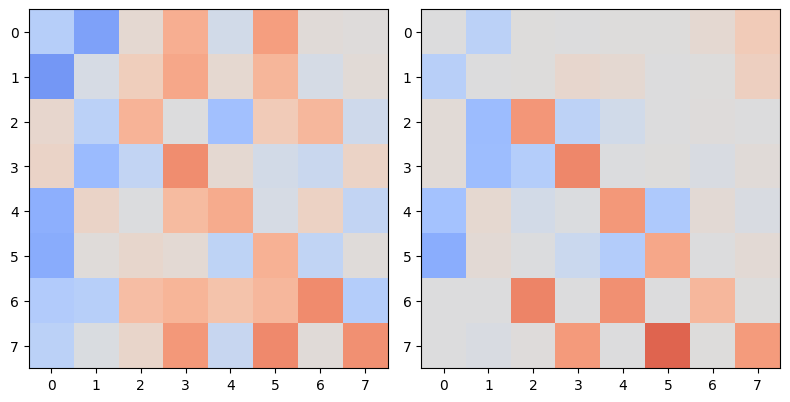

cosine_similarity measure: 0.745
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7393  1.5793
      2        0.6777  1.5435
      3        0.6207  1.5265
      4        0.5679  1.5753
      5        0.5188  1.5611
      6        0.4776  1.6121
      7        0.4520  1.5813
      8        0.4337  1.5300
      9        0.4097  1.5045
     10        0.3902  1.5616
     11        0.3803  1.5131
     12        0.3758  1.5750
     13        0.3709  1.6191
     14        0.3640  1.4652
     15        0.3554  1.5753
     16        0.3475  1.5268
     17        0.3417  1.5415
     18        0.3354  1.5779
     19        0.3271  1.4892
     20        0.3200  1.5297
     21        0.3158  1.5889
     22        0.3127  1.6096
     23        0.3090  1.5623
     24        0.3046  1.5614
     25        0.3001  1.5538
     26        0.2966  1.4924
     27        0.2929  1.7293
     28        0.2884  1.5760
     29        0.2843  1.5735
     30        0.2

    233        0.0733  1.5419
    234        0.0754  1.5641
    235        0.0759  1.4847
    236        0.0723  1.5450
    237        0.0731  1.5015
    238        0.0761  1.6193
    239        0.0721  1.6903
    240        0.0748  1.5827
    241        0.0736  1.5419
    242        0.0735  1.5700
    243        0.0741  1.5301
    244        0.0730  1.5818
    245        0.0790  1.5219
    246        0.0787  1.4931
    247        0.0722  1.6080
    248        0.0816  1.6188
    249        0.0735  1.5822
    250        0.0778  1.5893
    251        0.0773  1.5512
    252        0.0749  1.5524
    253        0.0804  1.5588
    254        0.0719  1.4811
    255        0.0762  1.5529
    256        0.0741  1.4781
    257        0.0764  1.5517
    258        0.0719  1.5391
    259        0.0758  1.6059
    260        0.0713  1.5462
    261        0.0762  1.5960
    262        0.0733  1.5243
    263        0.0748  1.5242
    264        0.0749  1.5207
    265        0.0719  1.5805
    266   

cosine_similarity measure: 0.717
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6840  1.5569
      2        0.6113  1.4882
      3        0.5436  1.5806
      4        0.4842  1.5801
      5        0.4368  1.5655
      6        0.4050  1.5949
      7        0.3946  1.5211
      8        0.3872  1.6182
      9        0.3663  1.5972
     10        0.3467  1.4794
     11        0.3360  1.5709
     12        0.3308  1.6096
     13        0.3267  1.5533
     14        0.3218  1.5543
     15        0.3154  1.6213
     16        0.3110  1.5711
     17        0.3108  1.5649
     18        0.3098  1.6127
     19        0.3045  1.6093
     20        0.2992  1.5659
     21        0.2960  1.5797
     22        0.2932  1.5269
     23        0.2897  1.5273
     24        0.2850  1.5557
     25        0.2803  1.5314
     26        0.2771  1.5155
     27        0.2754  1.5669
     28        0.2728  1.5015
     29        0.2694  1.4978
     30        0.2

    234        0.0815  1.5969
    235        0.0865  1.4817
    236        0.0851  1.6308
    237        0.0813  1.5742
    238        0.0861  1.5098
    239        0.0824  1.6099
    240        0.0806  1.5506
    241        0.0832  1.5938
    242        0.0806  1.5437
    243        0.0836  1.6273
    244        0.0788  1.5173
    245        0.0808  1.5755
    246        0.0803  1.5337
    247        0.0799  1.5157
    248        0.0852  1.6463
    249        0.0875  1.6640
    250        0.0839  1.5842
    251        0.0853  1.5099
    252        0.0805  1.5954
    253        0.0801  1.5293
    254        0.0799  1.5867
    255        0.0790  1.5212
    256        0.0821  1.6344
    257        0.0840  1.6077
    258        0.0860  1.5768
    259        0.0790  1.6227
    260        0.0821  1.4946
    261        0.0852  1.5872
    262        0.0802  1.5465
    263        0.0813  1.5553
    264        0.0817  1.5216
    265        0.0793  1.5876
    266        0.0814  1.5798
    267   

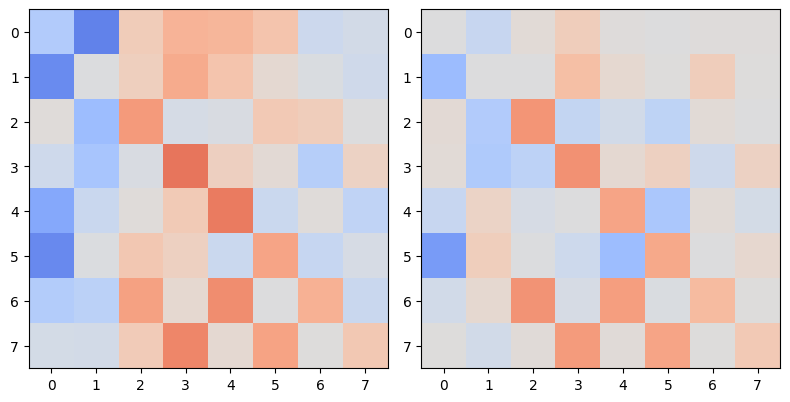

cosine_similarity measure: 0.808
MSE output:
7.244941018919233e-07
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6385  1.9370
      2        0.5710  1.6791
      3        0.5101  1.6142
      4        0.4540  1.6213
      5        0.4050  1.4675
      6        0.3734  1.5340
      7        0.3806  1.5693
      8        0.3717  1.5477
      9        0.3478  1.5459
     10        0.3354  1.6317
     11        0.3332  1.5472
     12        0.3334  1.6385
     13        0.3319  1.5893
     14        0.3275  1.5569
     15        0.3208  1.7090
     16        0.3133  1.5243
     17        0.3074  1.5684
     18        0.3045  1.6252
     19        0.3006  1.6122
     20        0.2937  1.5487
     21        0.2885  1.5177
     22        0.2864  1.5665
     23        0.2854  1.6054
     24        0.2833  1.5298
     25        0.2795  1.5562
     26        0.2753  1.6516
     27        0.2724  1.6573
     28        0.2707  1.5884
     29       

    235        0.0795  1.5842
    236        0.0819  1.5746
    237        0.0851  1.5679
    238        0.0786  1.5772
    239        0.0824  1.6077
    240        0.0891  1.6249
    241        0.0806  1.5398
    242        0.0811  1.5531
    243        0.0823  1.5890
    244        0.0788  1.5579
    245        0.0891  1.5714
    246        0.0817  1.5035
    247        0.0811  1.5716
    248        0.0905  1.6220
    249        0.0809  1.5750
    250        0.0840  1.5605
    251        0.0847  1.6145
    252        0.0818  1.5349
    253        0.0837  1.5348
    254        0.0819  1.6162
    255        0.0800  1.5069
    256        0.0832  1.6344
    257        0.0784  1.6451
    258        0.0836  1.5311
    259        0.0795  1.5993
    260        0.0808  1.5853
    261        0.0816  1.5050
    262        0.0774  1.5855
    263        0.0803  1.5462
    264        0.0781  1.5366
    265        0.0783  1.5997
    266        0.0797  1.6734
    267        0.0776  1.6415
    268   

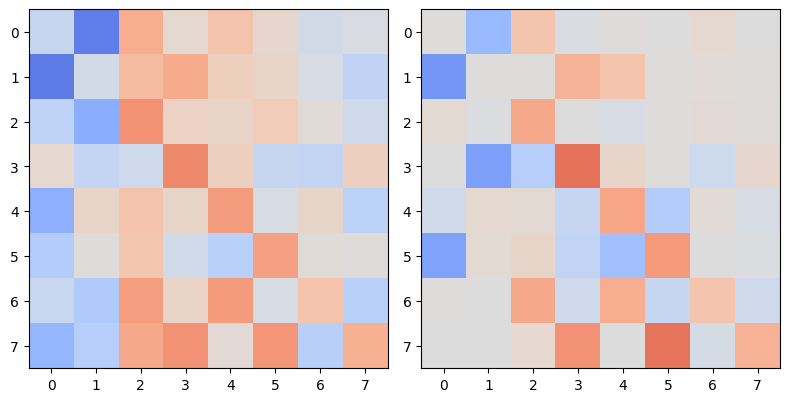

cosine_similarity measure: 0.789
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6930  1.5231
      2        0.6300  1.5726
      3        0.5706  1.5204
      4        0.5144  1.5465
      5        0.4645  1.6081
      6        0.4284  1.5586
      7        0.4088  1.5549
      8        0.3859  1.5247
      9        0.3606  1.5571
     10        0.3438  1.6140
     11        0.3337  1.5649
     12        0.3250  1.5493
     13        0.3164  1.5668
     14        0.3083  1.5889
     15        0.3034  1.6170
     16        0.3013  1.5163
     17        0.2963  1.5316
     18        0.2903  1.4712
     19        0.2870  1.5119
     20        0.2851  1.5528
     21        0.2817  1.4644
     22        0.2775  1.6130
     23        0.2733  1.4619
     24        0.2698  1.5228
     25        0.2665  1.5357
     26        0.2625  1.5380
     27        0.2591  1.5775
     28        0.2564  1.6281
     29        0.2530  1.4871
     30        0.2

    232        0.0776  1.5390
    233        0.0776  1.5839
    234        0.0767  1.5388
    235        0.0779  1.6236
    236        0.0779  1.6070
    237        0.0811  1.4783
    238        0.0796  1.6201
    239        0.0767  1.6312
    240        0.0761  1.5252
    241        0.0768  1.4630
    242        0.0760  1.5974
    243        0.0774  1.5575
    244        0.0773  1.5966
    245        0.0776  1.5785
    246        0.0760  1.5374
    247        0.0751  1.5354
    248        0.0773  1.4355
    249        0.0766  1.5064
    250        0.0746  1.5533
    251        0.0738  1.4871
    252        0.0741  1.5397
    253        0.0738  1.5339
    254        0.0738  1.6064
    255        0.0745  1.5085
    256        0.0751  1.4949
    257        0.0742  1.6397
    258        0.0738  1.5569
    259        0.0749  1.5244
    260        0.0781  1.5147
    261        0.0780  1.5226
    262        0.0819  1.5960
    263        0.0783  1.5678
    264        0.0744  1.5044
    265   

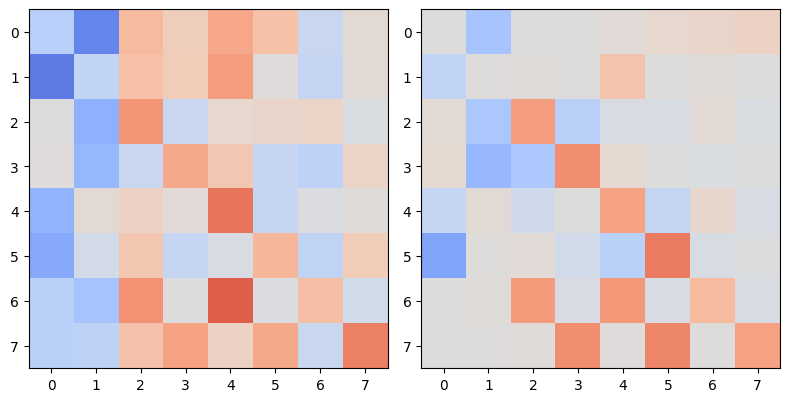

cosine_similarity measure: 0.796
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7503  1.4844
      2        0.6720  1.5009
      3        0.6027  1.5138
      4        0.5430  1.5617
      5        0.4920  1.5334
      6        0.4509  1.6528
      7        0.4236  1.5784
      8        0.4132  1.5421
      9        0.4079  1.5575
     10        0.3901  1.6588
     11        0.3705  1.4997
     12        0.3586  1.5006
     13        0.3531  1.4732
     14        0.3488  1.4089
     15        0.3439  1.4845
     16        0.3371  1.5964
     17        0.3303  1.4429
     18        0.3256  1.5768
     19        0.3238  1.5567
     20        0.3198  1.5137
     21        0.3120  1.4579
     22        0.3061  1.4843
     23        0.3029  1.4642
     24        0.3004  1.4989
     25        0.2970  1.5618
     26        0.2924  1.5441
     27        0.2883  1.5137
     28        0.2854  1.6065
     29        0.2829  1.5315
     30        0.2

    237        0.0815  1.6066
    238        0.0850  1.6223
    239        0.0858  1.4956
    240        0.0809  1.5491
    241        0.0913  1.6569
    242        0.0848  1.4937
    243        0.0861  1.5213
    244        0.0917  1.6172
    245        0.0818  1.5022
    246        0.0894  1.5193
    247        0.0805  1.5293
    248        0.0867  1.5984
    249        0.0838  1.5495
    250        0.0808  1.5384
    251        0.0849  1.6072
    252        0.0792  1.5955
    253        0.0840  1.5113
    254        0.0822  1.5198
    255        0.0793  1.5508
    256        0.0791  1.4839
    257        0.0799  1.5115
    258        0.0788  1.5291
    259        0.0805  1.5937
    260        0.0849  1.5441
    261        0.0800  1.4967
    262        0.0856  1.5458
    263        0.0877  1.5367
    264        0.0791  1.6213
    265        0.0845  1.5871
    266        0.0824  1.6736
    267        0.0800  1.6263
    268        0.0833  1.4648
    269        0.0798  1.5926
    270   

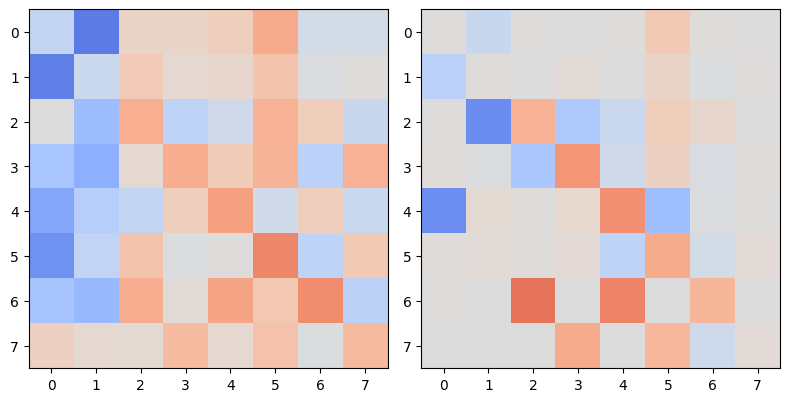

cosine_similarity measure: 0.649
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6956  1.5303
      2        0.6286  1.5726
      3        0.5678  1.5156
      4        0.5127  1.6114
      5        0.4640  1.5469
      6        0.4252  1.5246
      7        0.4034  1.5778
      8        0.3922  1.6304
      9        0.3739  1.4603
     10        0.3540  1.5544
     11        0.3427  1.5244
     12        0.3374  1.6179
     13        0.3329  1.5746
     14        0.3264  1.4997
     15        0.3179  1.5688
     16        0.3104  1.4760
     17        0.3064  1.5986
     18        0.3042  1.5184
     19        0.2989  1.6060
     20        0.2935  1.5988
     21        0.2906  1.5300
     22        0.2889  1.6072
     23        0.2867  1.6624
     24        0.2831  1.5918
     25        0.2790  1.5185
     26        0.2756  1.5291
     27        0.2724  1.5671
     28        0.2689  1.6742
     29        0.2651  1.5138
     30        0.2

    240        0.0772  1.5956
    241        0.0806  1.5551
    242        0.0781  1.4954
    243        0.0776  1.4875
    244        0.0753  1.5168
    245        0.0774  1.6025
    246        0.0758  1.6031
    247        0.0744  1.5826
    248        0.0803  1.5349
    249        0.0732  1.5292
    250        0.0760  1.5644
    251        0.0761  1.4875
    252        0.0731  1.5576
    253        0.0760  1.5500
    254        0.0738  1.6003
    255        0.0754  1.4350
    256        0.0738  1.5554
    257        0.0729  1.4698
    258        0.0736  1.5748
    259        0.0749  1.5415
    260        0.0735  1.5224
    261        0.0779  1.5400
    262        0.0752  1.5767
    263        0.0719  1.5929
    264        0.0750  1.6164
    265        0.0736  1.5488
    266        0.0726  1.6012
    267        0.0741  1.5210
    268        0.0746  1.5314
    269        0.0774  1.6333
    270        0.0801  1.6076
    271        0.0737  1.5294
    272        0.0779  1.4526
    273   

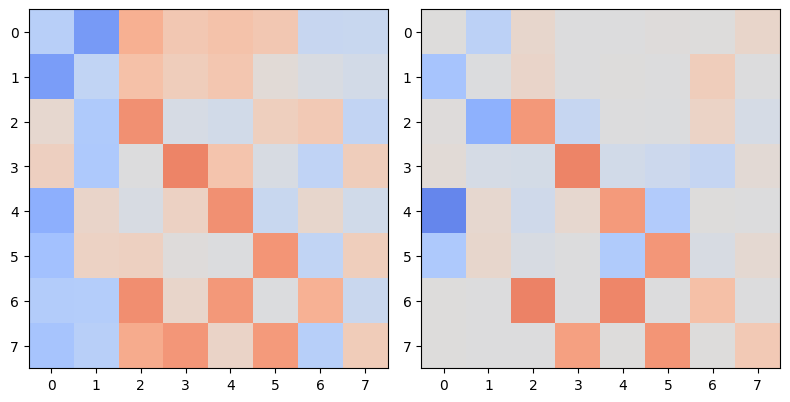

cosine_similarity measure: 0.795
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7007  1.4954
      2        0.6253  1.5705
      3        0.5602  1.5831
      4        0.5032  1.6257
      5        0.4549  1.5976
      6        0.4170  1.4810
      7        0.3974  1.5614
      8        0.3940  1.5328
      9        0.3791  1.5704
     10        0.3577  1.4927
     11        0.3435  1.5125
     12        0.3365  1.5979
     13        0.3325  1.5072
     14        0.3271  1.5555
     15        0.3202  1.5461
     16        0.3125  1.6229
     17        0.3081  1.6656
     18        0.3081  1.5594
     19        0.3049  1.6287
     20        0.2975  1.5788
     21        0.2926  1.5070
     22        0.2908  1.6179
     23        0.2892  1.5660
     24        0.2861  1.5493
     25        0.2818  1.5455
     26        0.2777  1.5525
     27        0.2757  1.5128
     28        0.2734  1.5867
     29        0.2692  1.5445
     30        0.2

    238        0.0853  1.5767
    239        0.0915  1.5329
    240        0.0848  1.5462
    241        0.0836  1.5328
    242        0.0815  1.4959
    243        0.0853  1.5702
    244        0.0824  1.5426
    245        0.0811  1.5673
    246        0.0836  1.5887
    247        0.0831  1.5930
    248        0.0868  1.5338
    249        0.0847  1.5013
    250        0.0796  1.4712
    251        0.0845  1.5741
    252        0.0832  1.5147
    253        0.0861  1.5025
    254        0.0820  1.5254
    255        0.0859  1.5187
    256        0.0893  1.5587
    257        0.0801  1.5525
    258        0.0953  1.5500
    259        0.0832  1.5715
    260        0.0891  1.5351
    261        0.0804  1.4783
    262        0.0845  1.6017
    263        0.0813  1.6415
    264        0.0828  1.5501
    265        0.0802  1.6291
    266        0.0831  1.6177
    267        0.0814  1.5860
    268        0.0828  1.5848
    269        0.0821  1.6040
    270        0.0812  1.5321
    271   

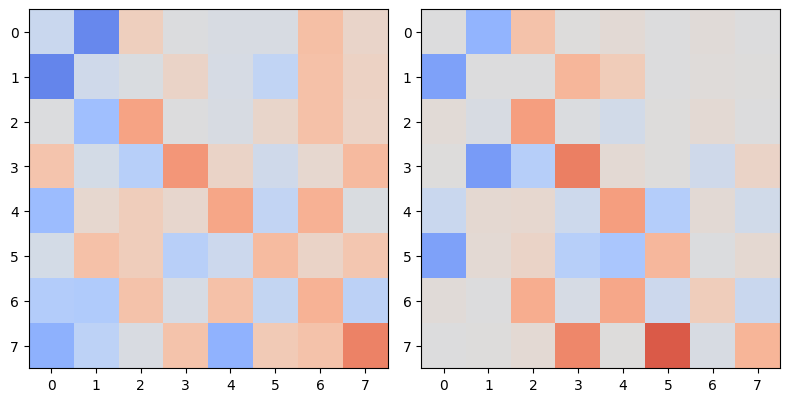

cosine_similarity measure: 0.659
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6924  1.5386
      2        0.6294  1.4983
      3        0.5706  1.4756
      4        0.5180  1.5504
      5        0.4724  1.4986
      6        0.4373  1.4979
      7        0.4174  1.5813
      8        0.4031  1.5887
      9        0.3806  1.4767
     10        0.3595  1.5338
     11        0.3457  1.5544
     12        0.3355  1.5237
     13        0.3251  1.5011
     14        0.3141  1.5881
     15        0.3053  1.5635
     16        0.3015  1.6447
     17        0.3004  1.6195
     18        0.2950  1.6095
     19        0.2903  1.5149
     20        0.2887  1.5162
     21        0.2870  1.5541
     22        0.2834  1.5823
     23        0.2784  1.5611
     24        0.2745  1.6158
     25        0.2717  1.6159
     26        0.2679  1.6099
     27        0.2627  1.6607
     28        0.2588  1.5660
     29        0.2554  1.4967
     30        0.2

    235        0.0791  1.5262
    236        0.0753  1.5166
    237        0.0733  1.5861
    238        0.0750  1.5382
    239        0.0731  1.6281
    240        0.0741  1.6460
    241        0.0734  1.5571
    242        0.0725  1.5631
    243        0.0743  1.5849
    244        0.0723  1.5361
    245        0.0740  1.5120
    246        0.0738  1.5256
    247        0.0727  1.5699
    248        0.0745  1.5088
    249        0.0736  1.5748
    250        0.0731  1.5907
    251        0.0736  1.5503
    252        0.0738  1.5578
    253        0.0724  1.6082
    254        0.0715  1.5294
    255        0.0730  1.5372
    256        0.0722  1.4837
    257        0.0749  1.5284
    258        0.0771  1.5967
    259        0.0741  1.6411
    260        0.0722  1.5303
    261        0.0745  1.5762
    262        0.0740  1.5519
    263        0.0714  1.5110
    264        0.0739  1.5697
    265        0.0732  1.4982
    266        0.0716  1.4567
    267        0.0789  1.5960
    268   

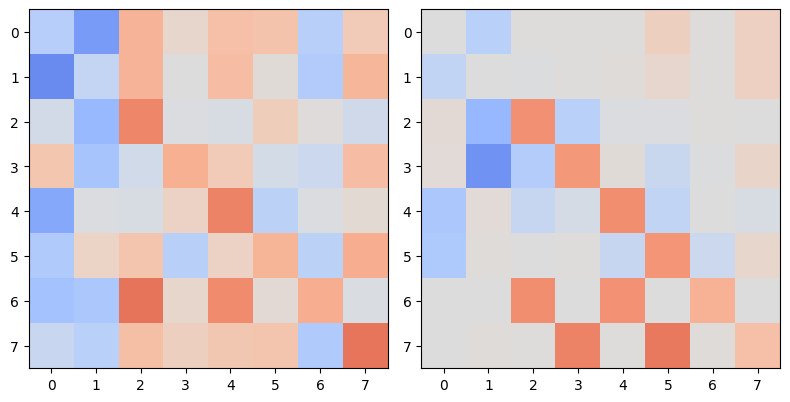

cosine_similarity measure: 0.715
[1.  0.  0.1 0.9 0.1 0.9]
[1.  0.  0.1 0.9 0.3 0.7]
[1.  0.  0.1 0.9 0.4 0.6]
[1.   0.   0.1  0.9  0.45 0.55]
[1.    0.    0.1   0.9   0.475 0.525]
[1.     0.     0.1    0.9    0.4875 0.5125]
[1.      0.      0.1     0.9     0.49375 0.50625]
[1.  0.  0.1 0.9 0.5 0.5]
[1.      0.      0.1     0.9     0.50625 0.49375]
[1.     0.     0.1    0.9    0.5125 0.4875]
[1.    0.    0.1   0.9   0.525 0.475]
[1.   0.   0.1  0.9  0.55 0.45]
[1.  0.  0.1 0.9 0.6 0.4]
[1.  0.  0.1 0.9 0.7 0.3]
[1.  0.  0.1 0.9 0.9 0.1]
[1.  0.  0.3 0.7 0.1 0.9]
[1.  0.  0.3 0.7 0.3 0.7]
[1.  0.  0.3 0.7 0.4 0.6]
[1.   0.   0.3  0.7  0.45 0.55]
[1.    0.    0.3   0.7   0.475 0.525]
[1.     0.     0.3    0.7    0.4875 0.5125]
[1.      0.      0.3     0.7     0.49375 0.50625]
[1.  0.  0.3 0.7 0.5 0.5]
[1.      0.      0.3     0.7     0.50625 0.49375]
[1.     0.     0.3    0.7    0.5125 0.4875]
[1.    0.    0.3   0.7   0.525 0.475]
[1.   0.   0.3  0.7  0.55 0.45]
[1.  0.  0.3 0.7 0.6 0.4]

[1.  0.  0.7 0.3 0.7 0.3]
[1.  0.  0.7 0.3 0.9 0.1]
[1.  0.  0.9 0.1 0.1 0.9]
[1.  0.  0.9 0.1 0.3 0.7]
[1.  0.  0.9 0.1 0.4 0.6]
[1.   0.   0.9  0.1  0.45 0.55]
[1.    0.    0.9   0.1   0.475 0.525]
[1.     0.     0.9    0.1    0.4875 0.5125]
[1.      0.      0.9     0.1     0.49375 0.50625]
[1.  0.  0.9 0.1 0.5 0.5]
[1.      0.      0.9     0.1     0.50625 0.49375]
[1.     0.     0.9    0.1    0.5125 0.4875]
[1.    0.    0.9   0.1   0.525 0.475]
[1.   0.   0.9  0.1  0.55 0.45]
[1.  0.  0.9 0.1 0.6 0.4]
[1.  0.  0.9 0.1 0.7 0.3]
[1.  0.  0.9 0.1 0.9 0.1]
[0.  1.  0.1 0.9 0.1 0.9]
[0.  1.  0.3 0.7 0.1 0.9]
[0.  1.  0.4 0.6 0.1 0.9]
[0.   1.   0.45 0.55 0.1  0.9 ]
[0.    1.    0.475 0.525 0.1   0.9  ]
[0.     1.     0.4875 0.5125 0.1    0.9   ]
[0.      1.      0.49375 0.50625 0.1     0.9    ]
[0.  1.  0.5 0.5 0.1 0.9]
[0.      1.      0.50625 0.49375 0.1     0.9    ]
[0.     1.     0.5125 0.4875 0.1    0.9   ]
[0.    1.    0.525 0.475 0.1   0.9  ]
[0.   1.   0.55 0.45 0.1  0.9 ]
[0.  1

[0.  1.  0.7 0.3 0.6 0.4]
[0.  1.  0.9 0.1 0.6 0.4]
[0.  1.  0.1 0.9 0.7 0.3]
[0.  1.  0.3 0.7 0.7 0.3]
[0.  1.  0.4 0.6 0.7 0.3]
[0.   1.   0.45 0.55 0.7  0.3 ]
[0.    1.    0.475 0.525 0.7   0.3  ]
[0.     1.     0.4875 0.5125 0.7    0.3   ]
[0.      1.      0.49375 0.50625 0.7     0.3    ]
[0.  1.  0.5 0.5 0.7 0.3]
[0.      1.      0.50625 0.49375 0.7     0.3    ]
[0.     1.     0.5125 0.4875 0.7    0.3   ]
[0.    1.    0.525 0.475 0.7   0.3  ]
[0.   1.   0.55 0.45 0.7  0.3 ]
[0.  1.  0.6 0.4 0.7 0.3]
[0.  1.  0.7 0.3 0.7 0.3]
[0.  1.  0.9 0.1 0.7 0.3]
[0.  1.  0.1 0.9 0.9 0.1]
[0.  1.  0.3 0.7 0.9 0.1]
[0.  1.  0.4 0.6 0.9 0.1]
[0.   1.   0.45 0.55 0.9  0.1 ]
[0.    1.    0.475 0.525 0.9   0.1  ]
[0.     1.     0.4875 0.5125 0.9    0.1   ]
[0.      1.      0.49375 0.50625 0.9     0.1    ]
[0.  1.  0.5 0.5 0.9 0.1]
[0.      1.      0.50625 0.49375 0.9     0.1    ]
[0.     1.     0.5125 0.4875 0.9    0.1   ]
[0.    1.    0.525 0.475 0.9   0.1  ]
[0.   1.   0.55 0.45 0.9  0.1 ]
[0.  1

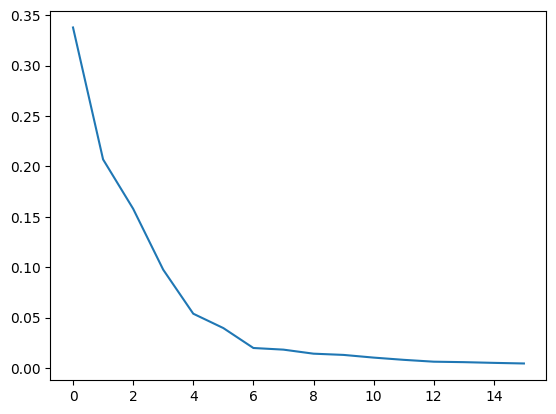

Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8186  1.5834
      2        0.7351  1.5240
      3        0.6593  1.5386
      4        0.5942  1.5810
      5        0.5393  1.5032
      6        0.4964  1.5907
      7        0.4728  1.4960
      8        0.4601  1.5896
      9        0.4358  1.5244
     10        0.4106  1.6909
     11        0.3955  1.5478
     12        0.3870  1.5556
     13        0.3802  1.5921
     14        0.3716  1.5154
     15        0.3613  1.5206
     16        0.3512  1.5901
     17        0.3448  1.5319
     18        0.3401  1.4931
     19        0.3332  1.5797
     20        0.3273  1.5792
     21        0.3249  1.5757
     22        0.3237  1.4763
     23        0.3221  1.5307
     24        0.3192  1.5996
     25        0.3161  1.6162
     26        0.3139  1.5403
     27        0.3103  1.5905
     28        0.3062  1.4936
     29        0.3036  1.5127
     30        0.3018  1.5257
     31        0.2996

    240        0.1120  1.5515
    241        0.1029  1.5114
    242        0.1107  1.4940
    243        0.1052  1.5623
    244        0.1023  1.5361
    245        0.1056  1.6189
    246        0.0994  1.5504
    247        0.0970  1.5734
    248        0.1031  1.6161
    249        0.0919  1.5970
    250        0.0964  1.5553
    251        0.0935  1.5732
    252        0.0930  1.6015
    253        0.0964  1.6050
    254        0.0961  1.5467
    255        0.0890  1.5647
    256        0.0929  1.5631
    257        0.1000  1.6496
    258        0.1156  1.5399
    259        0.0891  1.5862
    260        0.1081  1.5773
    261        0.1012  1.6471
    262        0.0988  1.6260
    263        0.1065  1.5131
    264        0.0996  1.6163
    265        0.0972  1.5357
    266        0.1036  1.5968
    267        0.0920  1.6320
    268        0.0994  1.6434
    269        0.0930  1.8270
    270        0.0932  1.6428
    271        0.0973  1.5976
    272        0.0931  1.6184
    273   

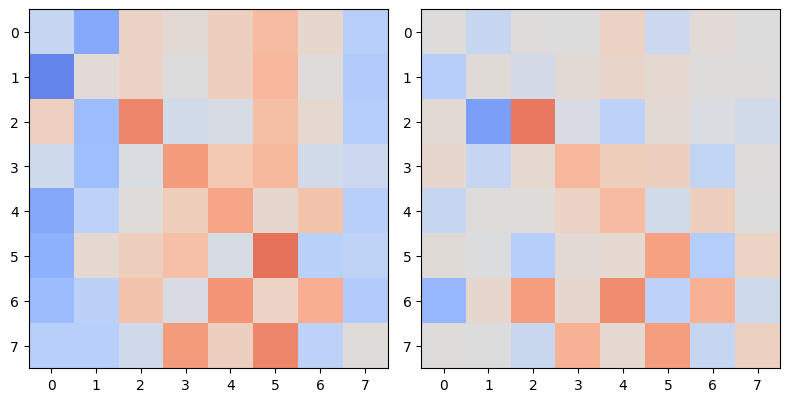

cosine_similarity measure: 0.727
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7875  1.5554
      2        0.7077  1.5538
      3        0.6321  1.5540
      4        0.5633  1.5648
      5        0.5022  1.5951
      6        0.4566  1.6167
      7        0.4373  1.5711
      8        0.4342  1.6130
      9        0.4105  1.5128
     10        0.3858  1.6562
     11        0.3720  1.5411
     12        0.3655  1.5321
     13        0.3602  1.6268
     14        0.3542  1.6305
     15        0.3458  1.5701
     16        0.3371  1.5800
     17        0.3308  1.6366
     18        0.3292  1.5840
     19        0.3244  1.5950
     20        0.3160  1.6825
     21        0.3108  1.5353
     22        0.3100  1.5723
     23        0.3098  1.6080
     24        0.3075  1.5903
     25        0.3037  1.5368
     26        0.3007  1.5297
     27        0.2995  1.4879
     28        0.2975  1.5740
     29        0.2935  1.5207
     30        0.2

    231        0.0860  1.5500
    232        0.0810  1.6445
    233        0.0827  1.5119
    234        0.0827  1.5766
    235        0.0829  1.5252
    236        0.0852  1.5482
    237        0.0892  1.5536
    238        0.0823  1.6556
    239        0.0803  1.5804
    240        0.0809  1.5756
    241        0.0820  1.6166
    242        0.0871  1.5513
    243        0.0888  1.6412
    244        0.0853  1.5933
    245        0.0816  1.5171
    246        0.0810  1.6598
    247        0.0816  1.5857
    248        0.0825  1.5426
    249        0.0798  1.5956
    250        0.0782  1.5755
    251        0.0789  1.6123
    252        0.0795  1.5335
    253        0.0828  1.5316
    254        0.0825  1.5840
    255        0.0838  1.5195
    256        0.0913  1.6203
    257        0.0841  1.5216
    258        0.0788  1.5284
    259        0.0821  1.6142
    260        0.0794  1.6290
    261        0.0781  1.5927
    262        0.0805  1.4932
    263        0.0823  1.6234
    264   

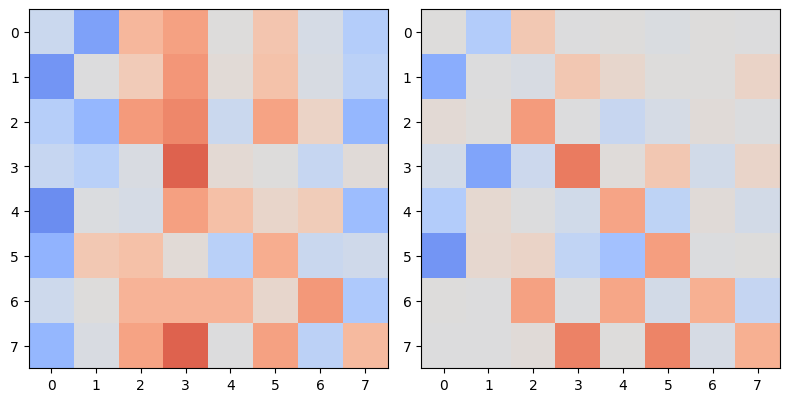

cosine_similarity measure: 0.699
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8406  1.5957
      2        0.7544  1.5956
      3        0.6812  1.5269
      4        0.6195  1.5138
      5        0.5687  1.5775
      6        0.5283  1.5059
      7        0.4987  1.5394
      8        0.4821  1.4885
      9        0.4728  1.5936
     10        0.4568  1.5458
     11        0.4344  1.5580
     12        0.4145  1.6505
     13        0.3994  1.6339
     14        0.3875  1.6779
     15        0.3765  1.5162
     16        0.3652  1.5238
     17        0.3540  1.5932
     18        0.3448  1.5137
     19        0.3399  1.5832
     20        0.3346  1.6052
     21        0.3238  1.5606
     22        0.3163  1.5651
     23        0.3119  1.5561
     24        0.3086  1.6253
     25        0.3036  1.4951
     26        0.2991  1.5332
     27        0.2971  1.6682
     28        0.2960  1.4848
     29        0.2914  1.5676
     30        0.2

    237        0.0880  1.5148
    238        0.0962  1.4848
    239        0.0867  1.5088
    240        0.0979  1.5675
    241        0.0979  1.6132
    242        0.0937  1.5678
    243        0.0903  1.4737
    244        0.0937  1.5341
    245        0.0867  1.5181
    246        0.0932  1.5901
    247        0.0910  1.5147
    248        0.0863  1.5741
    249        0.0903  1.5083
    250        0.0856  1.6278
    251        0.0859  1.5488
    252        0.0920  1.4638
    253        0.0938  1.5842
    254        0.0844  1.5823
    255        0.0850  1.6863
    256        0.0889  1.4738
    257        0.0840  1.5993
    258        0.0850  1.5591
    259        0.0854  1.5086
    260        0.0845  1.4714
    261        0.0839  1.5234
    262        0.0825  1.5560
    263        0.0823  1.5832
    264        0.0835  1.5249
    265        0.0863  1.4845
    266        0.0899  1.4922
    267        0.0924  1.5287
    268        0.0896  1.5846
    269        0.0843  1.5490
    270   

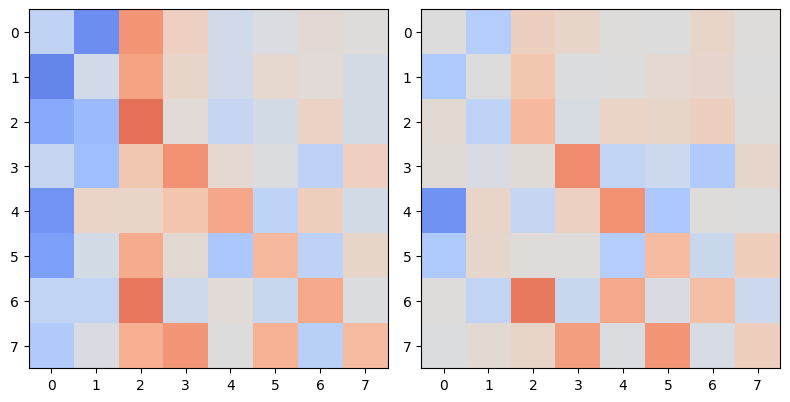

cosine_similarity measure: 0.782
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7773  1.5206
      2        0.7060  1.5606
      3        0.6385  1.5826
      4        0.5756  1.4852
      5        0.5200  1.5373
      6        0.4763  1.6345
      7        0.4526  1.6196
      8        0.4398  1.5495
      9        0.4161  1.6621
     10        0.3922  1.4738
     11        0.3768  1.5555
     12        0.3664  1.5716
     13        0.3563  1.5020
     14        0.3448  1.5735
     15        0.3333  1.6649
     16        0.3257  1.5493
     17        0.3263  1.5687
     18        0.3221  1.5890
     19        0.3155  1.6399
     20        0.3140  1.5287
     21        0.3130  1.6324
     22        0.3091  1.4908
     23        0.3033  1.4734
     24        0.2995  1.5216
     25        0.2990  1.6483
     26        0.2967  1.4932
     27        0.2925  1.5342
     28        0.2899  1.5916
     29        0.2892  1.6385
     30        0.2

    236        0.1005  1.6271
    237        0.1064  1.5664
    238        0.1009  1.5023
    239        0.1058  1.5560
    240        0.1062  1.6144
    241        0.0995  1.6377
    242        0.0943  1.6026
    243        0.1006  1.5463
    244        0.0953  1.5236
    245        0.0935  1.5945
    246        0.0947  1.5761
    247        0.0987  1.5959
    248        0.1117  1.5275
    249        0.0952  1.5830
    250        0.0906  1.5209
    251        0.0941  1.4925
    252        0.0952  1.5753
    253        0.0952  1.5902
    254        0.0915  1.5478
    255        0.0923  1.5562
    256        0.1048  1.5638
    257        0.0943  1.5378
    258        0.0980  1.5876
    259        0.0914  1.7170
    260        0.0915  1.5478
    261        0.1023  1.5555
    262        0.0890  1.6069
    263        0.1033  1.5403
    264        0.1037  1.5928
    265        0.0976  1.4991
    266        0.0980  1.5715
    267        0.0932  1.5470
    268        0.0979  1.5940
    269   

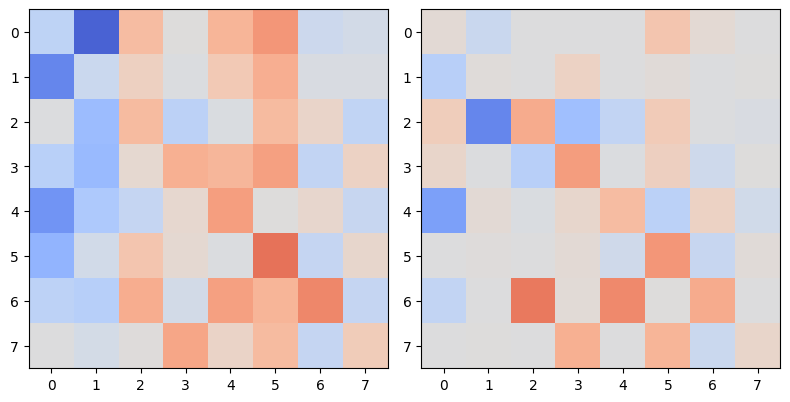

cosine_similarity measure: 0.695
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6818  1.5548
      2        0.6036  1.6496
      3        0.5366  1.5532
      4        0.4790  1.6396
      5        0.4291  1.5806
      6        0.3931  1.5467
      7        0.3892  1.5009
      8        0.3980  1.5415
      9        0.3763  1.6220
     10        0.3556  1.4950
     11        0.3471  1.5443
     12        0.3451  1.4823
     13        0.3434  1.5058
     14        0.3389  1.5549
     15        0.3310  1.5346
     16        0.3211  1.5910
     17        0.3113  1.5737
     18        0.3047  1.4763
     19        0.3044  1.5443
     20        0.3030  1.5603
     21        0.2955  1.5191
     22        0.2886  1.6166
     23        0.2864  1.5916
     24        0.2864  1.5686
     25        0.2860  1.5414
     26        0.2836  1.5691
     27        0.2798  1.5880
     28        0.2762  1.6612
     29        0.2746  1.5675
     30        0.2

    236        0.0923  1.5294
    237        0.0843  1.5620
    238        0.0883  1.5395
    239        0.0881  1.5623
    240        0.0891  1.5887
    241        0.1017  1.5753
    242        0.0896  1.5534
    243        0.0883  1.5932
    244        0.0872  1.5122
    245        0.0843  1.5613
    246        0.0872  1.5789
    247        0.0850  1.5850
    248        0.0869  1.5555
    249        0.0852  1.5236
    250        0.0859  1.5287
    251        0.0912  1.5435
    252        0.0828  1.5789
    253        0.0830  1.5105
    254        0.0915  1.5139
    255        0.0937  1.5945
    256        0.0944  1.5358
    257        0.0842  1.5973
    258        0.0900  1.4729
    259        0.0913  1.5854
    260        0.0847  1.5178
    261        0.0924  1.5507
    262        0.0887  1.5723
    263        0.0824  1.5549
    264        0.0894  1.5984
    265        0.0895  1.5069
    266        0.0897  1.5687
    267        0.0902  1.6621
    268        0.0822  1.5299
    269   

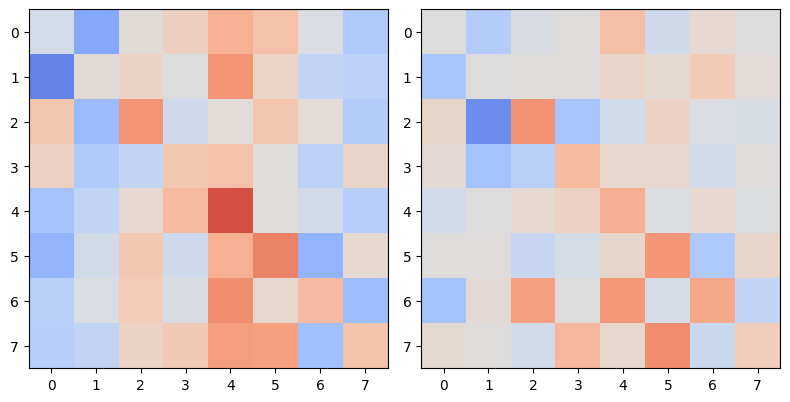

cosine_similarity measure: 0.744
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8684  1.5856
      2        0.8013  1.6088
      3        0.7450  1.4892
      4        0.6944  1.5955
      5        0.6472  1.5369
      6        0.6043  1.6163
      7        0.5663  1.5245
      8        0.5345  1.5253
      9        0.5058  1.6179
     10        0.4767  1.7186
     11        0.4492  1.4917
     12        0.4251  1.5348
     13        0.4058  1.5427
     14        0.3896  1.6320
     15        0.3755  1.5109
     16        0.3633  1.5426
     17        0.3534  1.5441
     18        0.3420  1.5420
     19        0.3325  1.6650
     20        0.3255  1.5413
     21        0.3190  1.5687
     22        0.3152  1.6442
     23        0.3114  1.6035
     24        0.3081  1.6008
     25        0.3063  1.4931
     26        0.3038  1.5601
     27        0.3013  1.5568
     28        0.2989  1.5312
     29        0.2958  1.5215
     30        0.2

    238        0.0949  1.6164
    239        0.0966  1.6139
    240        0.0890  1.6571
    241        0.0889  1.5865
    242        0.0940  1.6269
    243        0.0973  1.6125
    244        0.0956  1.6374
    245        0.0917  1.5648
    246        0.0882  1.5279
    247        0.0947  1.6198
    248        0.0898  1.5555
    249        0.0886  1.5024
    250        0.0894  1.5250
    251        0.0949  1.5443
    252        0.1079  1.5280
    253        0.0909  1.5092
    254        0.0857  1.5053
    255        0.0885  1.5824
    256        0.0913  1.5482
    257        0.0848  1.4710
    258        0.0884  1.5879
    259        0.0964  1.5815
    260        0.0884  1.5272
    261        0.0845  1.5347
    262        0.0897  1.6218
    263        0.0906  1.5740
    264        0.0880  1.5817
    265        0.0837  1.5224
    266        0.0866  1.5616
    267        0.0922  1.5610
    268        0.0886  1.5551
    269        0.0865  1.5285
    270        0.0831  1.5522
    271   

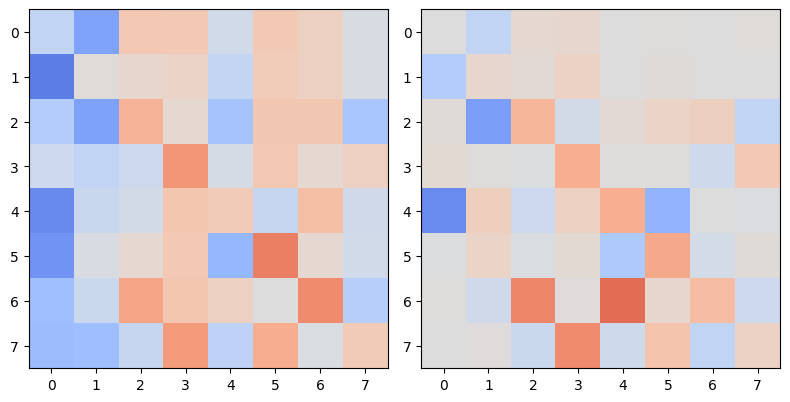

cosine_similarity measure: 0.705
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8600  1.5421
      2        0.7781  1.6042
      3        0.7085  1.5484
      4        0.6473  1.5181
      5        0.5916  1.5947
      6        0.5413  1.4527
      7        0.5002  1.5089
      8        0.4731  1.5519
      9        0.4587  1.6249
     10        0.4394  1.5342
     11        0.4134  1.5382
     12        0.3907  1.5012
     13        0.3759  1.5727
     14        0.3667  1.5300
     15        0.3606  1.5496
     16        0.3538  1.5663
     17        0.3460  1.5787
     18        0.3395  1.6492
     19        0.3375  1.5159
     20        0.3324  1.5562
     21        0.3233  1.5631
     22        0.3180  1.5347
     23        0.3147  1.5547
     24        0.3108  1.5671
     25        0.3059  1.5565
     26        0.3029  1.5839
     27        0.3026  1.5343
     28        0.3002  1.5919
     29        0.2965  1.5875
     30        0.2

    232        0.0899  1.6310
    233        0.1233  1.5420
    234        0.1172  1.5650
    235        0.1170  1.5640
    236        0.1009  1.5467
    237        0.1220  1.5684
    238        0.1059  1.6429
    239        0.1099  1.4811
    240        0.1087  1.5520
    241        0.1047  1.4811
    242        0.1068  1.5227
    243        0.1039  1.6299
    244        0.1085  1.5501
    245        0.0998  1.5138
    246        0.1047  1.5537
    247        0.0958  1.5058
    248        0.1000  1.6124
    249        0.0963  1.5678
    250        0.0970  1.5317
    251        0.0994  1.5808
    252        0.0878  1.5187
    253        0.0936  1.5892
    254        0.0950  1.5182
    255        0.1272  1.5377
    256        0.0891  1.5559
    257        0.1384  1.5266
    258        0.0913  1.5413
    259        0.1284  1.5945
    260        0.1264  1.5606
    261        0.0967  1.5193
    262        0.1142  1.5917
    263        0.1157  1.4441
    264        0.1090  1.5579
    265   

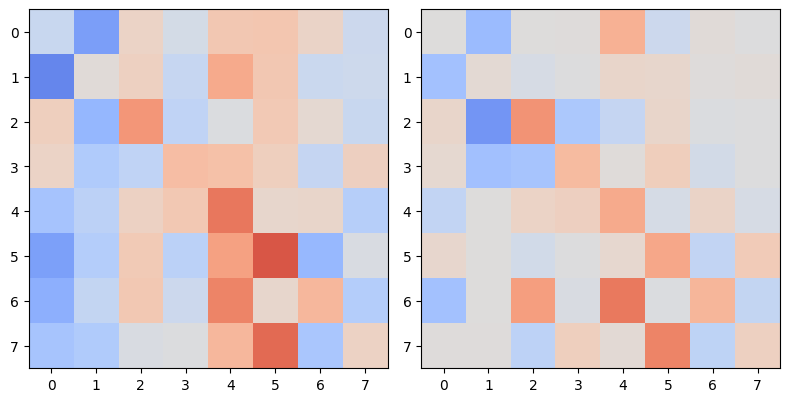

cosine_similarity measure: 0.77
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8228  1.5472
      2        0.7413  1.5458
      3        0.6664  1.5824
      4        0.5986  1.6898
      5        0.5396  1.5011
      6        0.4899  1.7336
      7        0.4526  1.5839
      8        0.4305  1.5422
      9        0.4206  1.5242
     10        0.4079  1.4588
     11        0.3890  1.6774
     12        0.3729  1.5892
     13        0.3634  1.6230
     14        0.3566  1.5756
     15        0.3501  1.5542
     16        0.3421  1.5514
     17        0.3339  1.6395
     18        0.3283  1.6341
     19        0.3254  1.6005
     20        0.3203  1.5809
     21        0.3127  1.4949
     22        0.3075  1.4929
     23        0.3048  1.5838
     24        0.3025  1.4705
     25        0.2996  1.5744
     26        0.2971  1.6320
     27        0.2958  1.5261
     28        0.2938  1.6060
     29        0.2904  1.4917
     30        0.28

    235        0.0939  1.6471
    236        0.0941  1.5477
    237        0.0988  1.5137
    238        0.0981  1.6160
    239        0.0956  1.5741
    240        0.0896  1.5814
    241        0.0914  1.5497
    242        0.0916  1.5269
    243        0.0911  1.5019
    244        0.0986  1.5673
    245        0.0957  1.5890
    246        0.1057  1.5202
    247        0.1059  1.5677
    248        0.0920  1.5147
    249        0.0955  1.5476
    250        0.1002  1.5370
    251        0.0939  1.5583
    252        0.0952  1.4717
    253        0.0941  1.5377
    254        0.0886  1.5422
    255        0.0931  1.6325
    256        0.0897  1.5751
    257        0.0977  1.6174
    258        0.1101  1.5022
    259        0.0933  1.5679
    260        0.0911  1.5238
    261        0.0954  1.5637
    262        0.1023  1.6530
    263        0.0915  1.5530
    264        0.1143  1.5375
    265        0.0946  1.6935
    266        0.0962  1.5462
    267        0.0907  1.5954
    268   

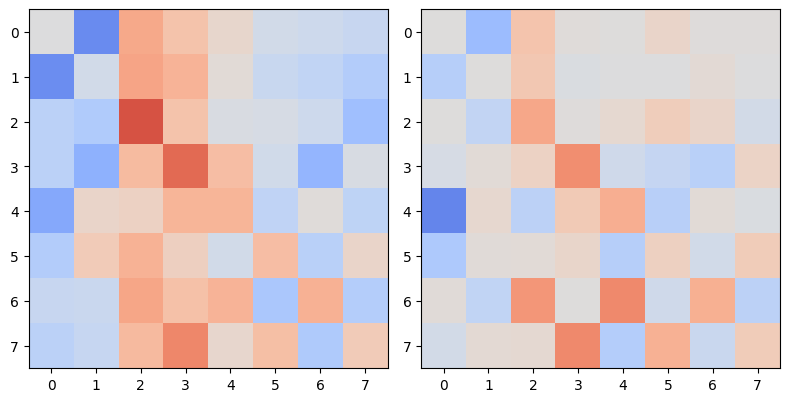

cosine_similarity measure: 0.752
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8433  1.6048
      2        0.7653  1.5708
      3        0.6998  1.6560
      4        0.6458  1.5308
      5        0.5987  1.4751
      6        0.5575  1.6178
      7        0.5235  1.6518
      8        0.4966  1.5038
      9        0.4755  1.4890
     10        0.4556  1.5918
     11        0.4341  1.5932
     12        0.4148  1.6046
     13        0.3993  1.5631
     14        0.3860  1.5557
     15        0.3730  1.6059
     16        0.3605  1.4792
     17        0.3503  1.5666
     18        0.3439  1.5076
     19        0.3375  1.5348
     20        0.3293  1.5204
     21        0.3246  1.6009
     22        0.3209  1.5070
     23        0.3168  1.4818
     24        0.3125  1.6147
     25        0.3098  1.5795
     26        0.3071  1.5052
     27        0.3031  1.5018
     28        0.2997  1.4747
     29        0.2969  1.5789
     30        0.2

    239        0.0901  1.5488
    240        0.0877  1.4809
    241        0.0955  1.5804
    242        0.0893  1.6114
    243        0.0903  1.5900
    244        0.0977  1.5823
    245        0.0856  1.5851
    246        0.0984  1.6426
    247        0.0906  1.6178
    248        0.0913  1.6393
    249        0.1010  1.6104
    250        0.0861  1.5666
    251        0.1051  1.5372
    252        0.0925  1.5124
    253        0.0992  1.5549
    254        0.0906  1.4865
    255        0.0953  1.5727
    256        0.0982  1.5058
    257        0.0933  1.5398
    258        0.0922  1.5837
    259        0.1001  1.5488
    260        0.0875  1.5367
    261        0.0958  1.5395
    262        0.0903  1.6199
    263        0.0933  1.5293
    264        0.0872  1.5672
    265        0.0964  1.4308
    266        0.0958  1.5649
    267        0.0976  1.5853
    268        0.0926  1.5369
    269        0.0901  1.4814
    270        0.0885  1.6081
    271        0.0920  1.6025
    272   

cosine_similarity measure: 0.827
MSE output:
0.00018055146562614668
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8103  1.9134
      2        0.7286  1.4909
      3        0.6536  1.6802
      4        0.5869  1.6879
      5        0.5282  1.5797
      6        0.4800  1.5703
      7        0.4484  1.7136
      8        0.4362  1.5841
      9        0.4238  1.5613
     10        0.4005  1.5676
     11        0.3799  1.5175
     12        0.3687  1.5026
     13        0.3634  1.5814
     14        0.3590  1.7152
     15        0.3536  1.6495
     16        0.3466  1.5303
     17        0.3412  1.5450
     18        0.3400  1.5133
     19        0.3369  1.5359
     20        0.3298  1.5720
     21        0.3244  1.5187
     22        0.3218  1.5742
     23        0.3186  1.5072
     24        0.3139  1.5275
     25        0.3083  1.5818
     26        0.3043  1.6181
     27        0.3016  1.5861
     28        0.2987  1.5301
     29      

    232        0.0979  1.5011
    233        0.0999  1.5568
    234        0.0956  1.5028
    235        0.0938  1.5483
    236        0.0996  1.5398
    237        0.0973  1.5531
    238        0.0970  1.5278
    239        0.0971  1.5259
    240        0.0954  1.6395
    241        0.0934  1.5728
    242        0.0967  1.6819
    243        0.0925  1.5471
    244        0.0959  1.5599
    245        0.0927  1.7151
    246        0.0917  1.5476
    247        0.0977  1.6353
    248        0.0878  1.5541
    249        0.0972  1.5848
    250        0.0999  1.5634
    251        0.0890  1.5457
    252        0.1019  1.5397
    253        0.0943  1.5543
    254        0.0927  1.5208
    255        0.0948  1.5120
    256        0.0895  1.5787
    257        0.0922  1.5178
    258        0.0877  1.5874
    259        0.0937  1.7046
    260        0.0916  1.5434
    261        0.0878  1.5248
    262        0.0891  1.5574
    263        0.0881  1.5154
    264        0.0869  1.6252
    265   

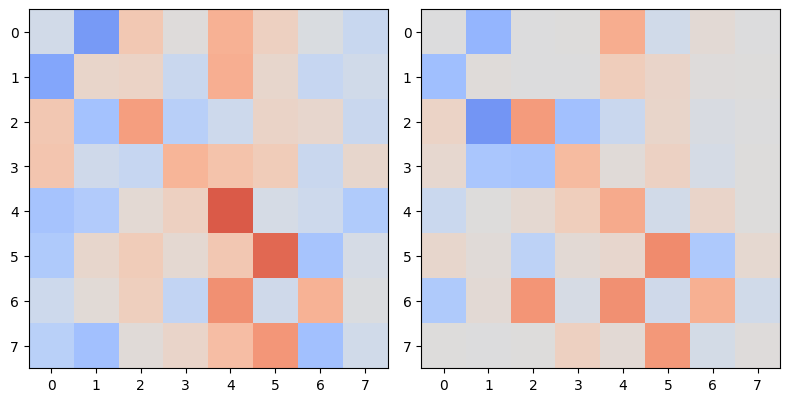

cosine_similarity measure: 0.78
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8302  1.5499
      2        0.7441  1.5620
      3        0.6715  1.5316
      4        0.6096  1.5442
      5        0.5552  1.4629
      6        0.5083  1.4830
      7        0.4726  1.4929
      8        0.4533  1.4913
      9        0.4440  1.5731
     10        0.4252  1.6415
     11        0.4006  1.6082
     12        0.3819  1.5482
     13        0.3699  1.4710
     14        0.3605  1.5625
     15        0.3506  1.5440
     16        0.3390  1.5218
     17        0.3269  1.5398
     18        0.3177  1.5423
     19        0.3152  1.5465
     20        0.3122  1.5976
     21        0.3038  1.5859
     22        0.2995  1.6769
     23        0.2988  1.5270
     24        0.2977  1.5331
     25        0.2941  1.6707
     26        0.2900  1.6176
     27        0.2888  1.6599
     28        0.2887  1.5091
     29        0.2851  1.4695
     30        0.28

    234        0.0854  1.5714
    235        0.0897  1.5575
    236        0.0892  1.4926
    237        0.1110  1.5584
    238        0.1030  1.5350
    239        0.1004  1.5849
    240        0.0872  1.5289
    241        0.0993  1.4756
    242        0.0914  1.5194
    243        0.0901  1.5661
    244        0.0956  1.5693
    245        0.0915  1.5076
    246        0.0877  1.5226
    247        0.0998  1.4540
    248        0.0902  1.6037
    249        0.0905  1.5238
    250        0.0890  1.5948
    251        0.0891  1.5844
    252        0.0867  1.5216
    253        0.0890  1.5208
    254        0.0923  1.4854
    255        0.1076  1.7476
    256        0.1027  1.6229
    257        0.0858  1.6396
    258        0.1038  1.5998
    259        0.0903  1.6041
    260        0.0955  1.4477
    261        0.0917  1.6072
    262        0.0904  1.5212
    263        0.0866  1.5672
    264        0.0905  1.4487
    265        0.0854  1.5535
    266        0.0901  1.5452
    267   

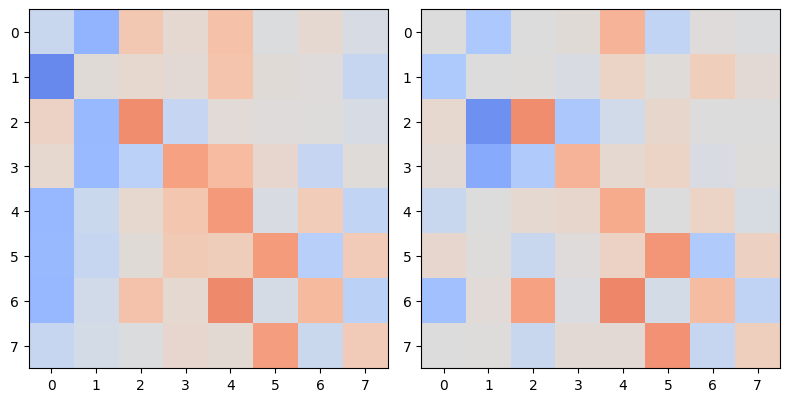

cosine_similarity measure: 0.847
MSE output:
0.00013575093816709937
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8961  1.8160
      2        0.8185  1.6052
      3        0.7543  1.6511
      4        0.7011  1.5256
      5        0.6577  1.5096
      6        0.6224  1.5270
      7        0.5936  1.6219
      8        0.5693  1.5568
      9        0.5470  1.5422
     10        0.5235  1.5128
     11        0.4995  1.5964
     12        0.4766  1.5832
     13        0.4549  1.5589
     14        0.4339  1.6277
     15        0.4135  1.5576
     16        0.3936  1.5541
     17        0.3755  1.5069
     18        0.3603  1.5844
     19        0.3458  1.5189
     20        0.3317  1.5867
     21        0.3211  1.5183
     22        0.3124  1.5588
     23        0.3036  1.5386
     24        0.2977  1.5621
     25        0.2933  1.5056
     26        0.2884  1.6495
     27        0.2856  1.5031
     28        0.2813  1.4798
     29      

    241        0.0917  1.4619
    242        0.0952  1.6436
    243        0.0917  1.6305
    244        0.0916  1.5675
    245        0.0919  1.5935
    246        0.0902  1.5536
    247        0.0930  1.5513
    248        0.0957  1.5456
    249        0.1042  1.5069
    250        0.1034  1.5365
    251        0.0909  1.5020
    252        0.0945  1.5243
    253        0.0933  1.5730
    254        0.0963  1.5189
    255        0.0945  1.5440
    256        0.0962  1.5248
    257        0.0934  1.6185
    258        0.0893  1.5437
    259        0.0906  1.5532
    260        0.0904  1.6757
    261        0.0925  1.4632
    262        0.0955  1.5310
    263        0.0920  1.5252
    264        0.0988  1.5853
    265        0.0956  1.6037
    266        0.0997  1.4820
    267        0.0885  1.5676
    268        0.0991  1.4652
    269        0.0976  1.5283
    270        0.0900  1.4959
    271        0.0963  1.5042
    272        0.0945  1.5848
    273        0.0907  1.5313
    274   

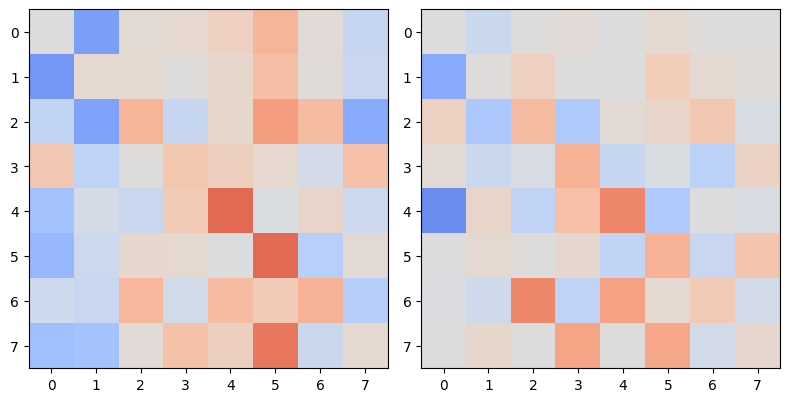

cosine_similarity measure: 0.722
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8837  1.6175
      2        0.8001  1.6862
      3        0.7268  1.5272
      4        0.6623  1.5728
      5        0.6054  1.5635
      6        0.5565  1.5105
      7        0.5183  1.4736
      8        0.4926  1.5069
      9        0.4748  1.5726
     10        0.4560  1.5391
     11        0.4323  1.5201
     12        0.4115  1.5646
     13        0.3982  1.5334
     14        0.3894  1.5434
     15        0.3820  1.5540
     16        0.3740  1.5315
     17        0.3668  1.5543
     18        0.3623  1.5191
     19        0.3551  1.5332
     20        0.3472  1.5590
     21        0.3419  1.6274
     22        0.3382  1.5680
     23        0.3341  1.5385
     24        0.3299  1.5534
     25        0.3266  1.5439
     26        0.3241  1.5823
     27        0.3209  1.5046
     28        0.3181  1.6179
     29        0.3165  1.6639
     30        0.3

    238        0.0936  1.5856
    239        0.0967  1.6241
    240        0.0952  1.5757
    241        0.0938  1.5589
    242        0.0920  1.6079
    243        0.0942  1.6789
    244        0.0962  1.5263
    245        0.0920  1.5215
    246        0.0931  1.5629
    247        0.0978  1.5812
    248        0.0949  1.5771
    249        0.0925  1.5139
    250        0.0908  1.5639
    251        0.0930  1.5012
    252        0.0931  1.5575
    253        0.0910  1.5526
    254        0.0907  1.6154
    255        0.0913  1.5408
    256        0.0936  1.5574
    257        0.0943  1.5597
    258        0.0891  1.6297
    259        0.0902  1.6143
    260        0.0919  1.6019
    261        0.0928  1.5715
    262        0.0925  1.5040
    263        0.0891  1.5395
    264        0.0912  1.5430
    265        0.0935  1.5919
    266        0.0937  2.2068
    267        0.0920  1.6155
    268        0.0883  1.6178
    269        0.0887  1.5163
    270        0.0877  1.4914
    271   

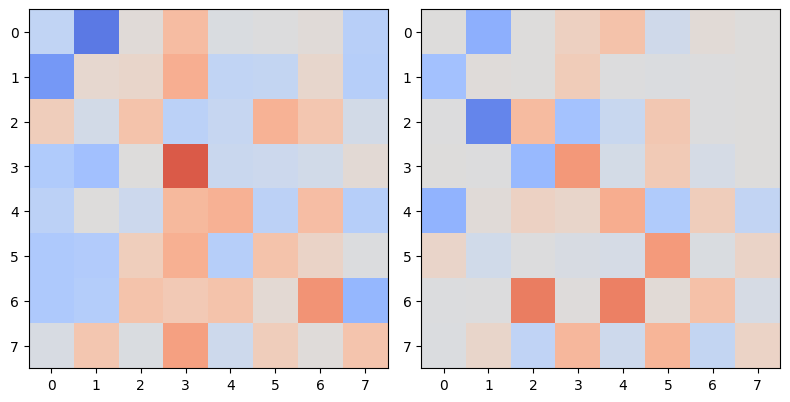

cosine_similarity measure: 0.626
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.9545  1.5008
      2        0.8802  1.4898
      3        0.8184  1.4929
      4        0.7656  1.6458
      5        0.7192  1.5532
      6        0.6782  1.5969
      7        0.6412  1.6203
      8        0.6094  1.5314
      9        0.5821  1.5311
     10        0.5565  1.5587
     11        0.5297  1.6078
     12        0.5032  1.5413
     13        0.4791  1.4966
     14        0.4579  1.6219
     15        0.4390  1.5283
     16        0.4215  1.6018
     17        0.4050  1.6079
     18        0.3895  1.5185
     19        0.3762  1.5717
     20        0.3630  1.5000
     21        0.3498  1.5416
     22        0.3396  1.5205
     23        0.3310  1.5224
     24        0.3236  1.5832
     25        0.3186  1.5579
     26        0.3147  1.4974
     27        0.3109  1.5441
     28        0.3085  1.5034
     29        0.3061  1.5625
     30        0.3

    237        0.0960  1.5404
    238        0.0920  1.5480
    239        0.0890  1.5482
    240        0.0902  1.5681
    241        0.0870  1.6101
    242        0.0929  1.5373
    243        0.0906  1.5408
    244        0.0972  1.5514
    245        0.0994  1.4671
    246        0.1033  1.4985
    247        0.0882  1.4897
    248        0.0912  1.5336
    249        0.0948  1.4769
    250        0.0878  1.4911
    251        0.0938  1.5074
    252        0.0927  1.5595
    253        0.0935  1.4723
    254        0.0886  1.5035
    255        0.0887  1.4723
    256        0.0884  1.4811
    257        0.0863  1.5329
    258        0.0870  1.5386
    259        0.0868  1.4822
    260        0.0877  1.5071
    261        0.0869  1.4927
    262        0.0844  1.5165
    263        0.0880  1.5714
    264        0.0918  1.5269
    265        0.0897  1.5984
    266        0.0927  1.4732
    267        0.1034  1.5705
    268        0.0895  1.5317
    269        0.0897  1.5137
    270   

cosine_similarity measure: 0.725
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7443  1.5129
      2        0.6730  1.4877
      3        0.6073  1.5286
      4        0.5474  1.5371
      5        0.4954  1.5140
      6        0.4577  1.5056
      7        0.4409  1.5444
      8        0.4263  1.6332
      9        0.4011  1.7032
     10        0.3807  1.5464
     11        0.3700  1.6071
     12        0.3638  1.5936
     13        0.3566  1.5579
     14        0.3473  1.5886
     15        0.3374  1.5279
     16        0.3305  1.4312
     17        0.3286  1.5514
     18        0.3220  1.6374
     19        0.3138  1.5567
     20        0.3103  1.6645
     21        0.3087  1.5543
     22        0.3063  1.4799
     23        0.3026  1.5212
     24        0.2989  1.5251
     25        0.2963  1.6214
     26        0.2936  1.6412
     27        0.2889  1.5520
     28        0.2846  1.5727
     29        0.2824  1.5119
     30        0.2

    236        0.0956  1.5015
    237        0.0961  1.5495
    238        0.0902  1.5558
    239        0.1021  1.5276
    240        0.0856  1.6174
    241        0.0974  1.5882
    242        0.0912  1.5912
    243        0.0920  1.5624
    244        0.0890  1.5090
    245        0.0896  1.5437
    246        0.0891  1.5139
    247        0.0885  1.4912
    248        0.0886  1.4522
    249        0.0867  1.6394
    250        0.0877  1.5265
    251        0.0869  1.5932
    252        0.0891  1.5582
    253        0.0837  1.5291
    254        0.0923  1.5729
    255        0.0990  1.5023
    256        0.1016  1.5868
    257        0.0939  1.6210
    258        0.0902  1.5486
    259        0.0892  1.6157
    260        0.0924  1.5681
    261        0.0889  1.5849
    262        0.0907  1.4963
    263        0.0848  1.5317
    264        0.0869  1.5506
    265        0.0858  1.5422
    266        0.1002  1.4747
    267        0.1157  1.5586
    268        0.0908  1.4877
    269   

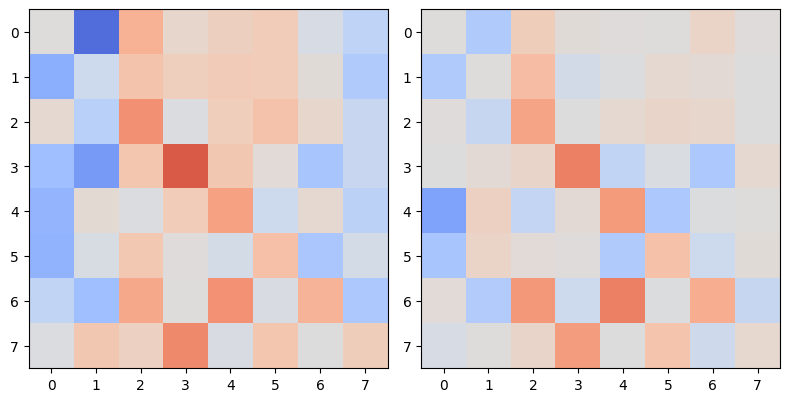

cosine_similarity measure: 0.784
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7397  1.5850
      2        0.6744  1.5958
      3        0.6164  1.6406
      4        0.5659  1.5371
      5        0.5238  1.5524
      6        0.4907  1.6055
      7        0.4684  1.5290
      8        0.4481  1.6929
      9        0.4228  1.5551
     10        0.3981  1.5104
     11        0.3776  1.4511
     12        0.3612  1.5656
     13        0.3469  1.5354
     14        0.3352  1.5738
     15        0.3290  1.5554
     16        0.3234  1.6251
     17        0.3165  1.5192
     18        0.3138  1.5411
     19        0.3120  1.5473
     20        0.3087  1.4543
     21        0.3055  1.5489
     22        0.3035  1.5128
     23        0.2985  1.6172
     24        0.2943  1.5349
     25        0.2913  1.5425
     26        0.2881  1.5429
     27        0.2853  1.5905
     28        0.2834  1.5631
     29        0.2802  1.5111
     30        0.2

    234        0.1007  1.6121
    235        0.1011  1.6549
    236        0.1192  1.4769
    237        0.0998  1.5347
    238        0.0930  1.5326
    239        0.0931  1.5676
    240        0.0933  1.5368
    241        0.0930  1.5976
    242        0.0924  1.5222
    243        0.0914  1.5598
    244        0.0910  1.6377
    245        0.0919  1.6220
    246        0.0907  1.4701
    247        0.0926  1.5299
    248        0.1013  1.4740
    249        0.1169  1.4952
    250        0.1199  1.5989
    251        0.0928  1.5331
    252        0.1093  1.4595
    253        0.0964  1.4768
    254        0.1048  1.5123
    255        0.0944  1.5596
    256        0.0991  1.4948
    257        0.0972  1.6570
    258        0.1058  1.6176
    259        0.1052  1.5104
    260        0.1027  1.5628
    261        0.0966  1.5554
    262        0.0934  1.4823
    263        0.0995  1.6002
    264        0.0944  1.5660
    265        0.0973  1.5664
    266        0.0946  1.6556
    267   

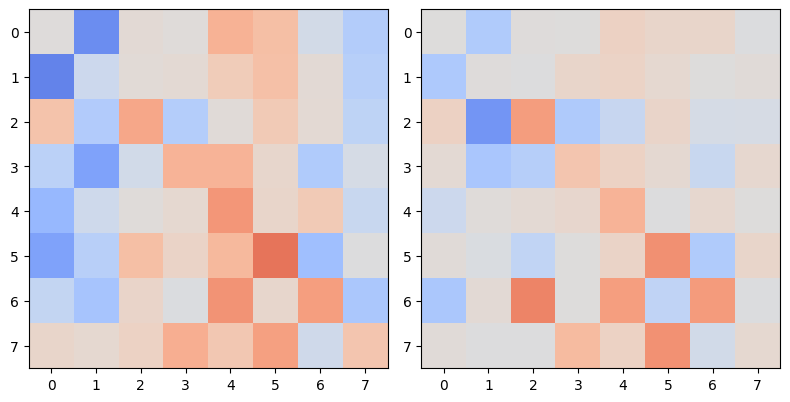

cosine_similarity measure: 0.72
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8140  1.5510
      2        0.7383  1.5797
      3        0.6659  1.5177
      4        0.5986  1.5453
      5        0.5380  1.5186
      6        0.4851  1.5099
      7        0.4442  1.5198
      8        0.4225  1.5513
      9        0.4196  1.6054
     10        0.4102  1.5953
     11        0.3913  1.5991
     12        0.3763  1.5696
     13        0.3678  1.5419
     14        0.3632  1.6000
     15        0.3582  1.5106
     16        0.3517  1.6313
     17        0.3428  1.5727
     18        0.3335  1.5999
     19        0.3259  1.6659
     20        0.3221  1.5626
     21        0.3214  1.5000
     22        0.3159  1.6342
     23        0.3080  1.5044
     24        0.3034  1.4856
     25        0.3016  1.5104
     26        0.2995  1.6277
     27        0.2957  1.5495
     28        0.2916  1.5648
     29        0.2891  1.5762
     30        0.28

    231        0.0938  1.5472
    232        0.1004  1.5856
    233        0.0936  1.5612
    234        0.0971  1.5511
    235        0.0900  1.4789
    236        0.0937  1.5233
    237        0.0967  1.5905
    238        0.0965  1.5903
    239        0.1136  1.4417
    240        0.1222  1.5171
    241        0.1067  1.5300
    242        0.1080  1.5791
    243        0.1075  1.4680
    244        0.1073  1.5029
    245        0.1038  1.5390
    246        0.1085  1.5533
    247        0.0942  1.5792
    248        0.1099  1.5513
    249        0.0945  1.5553
    250        0.1002  1.4924
    251        0.0951  1.5466
    252        0.1002  1.6183
    253        0.0904  1.4704
    254        0.0937  1.5293
    255        0.0942  1.5474
    256        0.0878  1.4877
    257        0.0955  1.5307
    258        0.0874  1.4753
    259        0.0974  1.5132
    260        0.0896  1.5526
    261        0.1029  1.4616
    262        0.1193  1.6253
    263        0.0858  1.6361
    264   

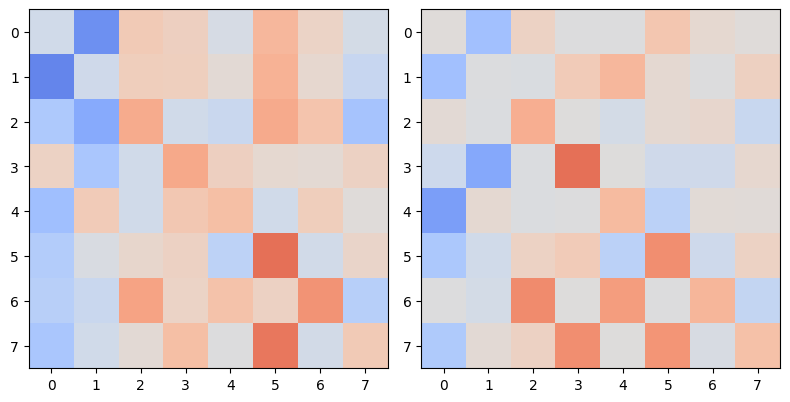

cosine_similarity measure: 0.792
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8206  1.5856
      2        0.7349  1.6283
      3        0.6567  1.6063
      4        0.5897  1.4588
      5        0.5343  1.5895
      6        0.4903  1.4990
      7        0.4575  1.5934
      8        0.4370  1.5440
      9        0.4298  1.5261
     10        0.4222  1.6400
     11        0.4061  1.6272
     12        0.3880  1.6517
     13        0.3749  1.5885
     14        0.3667  1.5801
     15        0.3605  1.5748
     16        0.3540  1.5988
     17        0.3460  1.5748
     18        0.3378  1.6205
     19        0.3302  1.5671
     20        0.3250  1.5100
     21        0.3194  1.5530
     22        0.3112  1.5596
     23        0.3036  1.6083
     24        0.2984  1.6542
     25        0.2945  1.5686
     26        0.2900  1.5328
     27        0.2853  1.5016
     28        0.2816  1.5735
     29        0.2800  1.5303
     30        0.2

    236        0.0785  1.6506
    237        0.0796  1.6373
    238        0.0771  1.5257
    239        0.0797  1.5036
    240        0.0772  1.5429
    241        0.0787  1.5409
    242        0.0826  1.4967
    243        0.0796  1.5138
    244        0.0761  1.5779
    245        0.0801  1.5059
    246        0.0766  1.5058
    247        0.0795  1.5088
    248        0.0790  1.5754
    249        0.0774  1.5299
    250        0.0794  1.5065
    251        0.0781  1.5209
    252        0.0772  1.5625
    253        0.0780  1.5678
    254        0.0772  1.5967
    255        0.0756  1.5997
    256        0.0765  1.5536
    257        0.0762  1.6114
    258        0.0781  1.4927
    259        0.0795  1.5776
    260        0.0763  1.5560
    261        0.0766  1.4996
    262        0.0783  1.5029
    263        0.0771  1.5576
    264        0.0788  1.4668
    265        0.0782  1.5502
    266        0.0756  1.5971
    267        0.0753  1.6506
    268        0.0757  1.6014
    269   

cosine_similarity measure: 0.642
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8456  1.5328
      2        0.7708  1.5496
      3        0.7060  1.5051
      4        0.6473  1.5667
      5        0.5918  1.5281
      6        0.5403  1.5523
      7        0.4952  1.5522
      8        0.4631  1.7286
      9        0.4511  1.5474
     10        0.4398  1.5200
     11        0.4177  1.5567
     12        0.3964  1.4881
     13        0.3828  1.5534
     14        0.3736  1.5020
     15        0.3661  1.5311
     16        0.3575  1.5241
     17        0.3478  1.5599
     18        0.3364  1.5577
     19        0.3259  1.5208
     20        0.3195  1.4903
     21        0.3182  1.6087
     22        0.3095  1.5319
     23        0.2991  1.4856
     24        0.2959  1.5034
     25        0.2944  1.5321
     26        0.2907  1.6365
     27        0.2847  1.5766
     28        0.2818  1.5238
     29        0.2831  1.5041
     30        0.2

    234        0.0876  1.5584
    235        0.0871  1.6281
    236        0.0859  1.5598
    237        0.0887  1.6368
    238        0.0909  1.6309
    239        0.0876  1.5455
    240        0.0942  1.5866
    241        0.1039  1.5845
    242        0.0934  1.6014
    243        0.0889  1.7000
    244        0.0952  1.5719
    245        0.0869  1.5059
    246        0.0911  1.5498
    247        0.0870  1.5011
    248        0.0888  1.5406
    249        0.0934  1.5564
    250        0.0864  1.5447
    251        0.0904  1.4532
    252        0.0912  1.5625
    253        0.0874  1.6300
    254        0.0918  1.5598
    255        0.0881  1.6262
    256        0.0914  1.5615
    257        0.0876  1.5395
    258        0.0866  1.4848
    259        0.0870  1.5887
    260        0.0914  1.5329
    261        0.0976  1.4735
    262        0.0945  1.5695
    263        0.0873  1.4742
    264        0.0846  1.5730
    265        0.0918  1.5557
    266        0.0894  1.5024
    267   

cosine_similarity measure: 0.732
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8523  1.4838
      2        0.7678  1.5082
      3        0.6901  1.5497
      4        0.6209  1.5016
      5        0.5613  1.4857
      6        0.5119  1.4945
      7        0.4743  1.4877
      8        0.4512  1.5103
      9        0.4401  1.4809
     10        0.4284  1.5233
     11        0.4104  1.5572
     12        0.3912  1.5088
     13        0.3765  1.6404
     14        0.3656  1.5934
     15        0.3574  1.5340
     16        0.3489  1.5569
     17        0.3404  1.5977
     18        0.3334  1.5876
     19        0.3294  1.8833
     20        0.3241  1.5922
     21        0.3164  1.5533
     22        0.3109  1.4863
     23        0.3075  1.5203
     24        0.3040  1.5493
     25        0.3000  1.6392
     26        0.2971  1.5602
     27        0.2961  1.4794
     28        0.2936  1.5043
     29        0.2910  1.5717
     30        0.2

    234        0.0980  1.5757
    235        0.1066  1.5813
    236        0.0988  1.4596
    237        0.0996  1.4952
    238        0.0985  1.5010
    239        0.0969  1.5133
    240        0.0991  1.5668
    241        0.1156  1.5178
    242        0.1028  1.4822
    243        0.0966  1.5583
    244        0.0946  1.5284
    245        0.0994  1.5878
    246        0.0997  1.5787
    247        0.0925  1.6415
    248        0.0920  1.5711
    249        0.0955  1.7124
    250        0.0974  1.5462
    251        0.1016  1.5441
    252        0.0909  1.5866
    253        0.0994  1.6349
    254        0.0980  1.4707
    255        0.0926  1.5524
    256        0.1068  1.4999
    257        0.1044  1.5174
    258        0.0954  1.5241
    259        0.1001  1.5900
    260        0.1080  1.4544
    261        0.0939  1.4919
    262        0.1058  1.5384
    263        0.0935  1.4762
    264        0.1022  1.4760
    265        0.0980  1.4927
    266        0.0915  1.5152
    267   

cosine_similarity measure: 0.609
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8311  1.5195
      2        0.7533  1.5052
      3        0.6848  1.5849
      4        0.6239  1.5275
      5        0.5701  1.5875
      6        0.5231  1.5042
      7        0.4870  1.5219
      8        0.4673  1.4783
      9        0.4562  1.5684
     10        0.4344  1.5862
     11        0.4104  1.5337
     12        0.3932  1.5013
     13        0.3830  1.6720
     14        0.3759  1.5849
     15        0.3687  1.6341
     16        0.3607  1.5811
     17        0.3531  1.6189
     18        0.3491  1.6647
     19        0.3472  1.5845
     20        0.3399  1.4774
     21        0.3329  1.5240
     22        0.3293  1.6577
     23        0.3271  1.5026
     24        0.3243  1.5262
     25        0.3200  1.5128
     26        0.3162  1.4541
     27        0.3133  1.6294
     28        0.3111  1.5428
     29        0.3071  1.5234
     30        0.3

    236        0.0787  1.4223
    237        0.0865  1.5081
    238        0.0792  1.5081
    239        0.0838  1.5545
    240        0.0772  1.5599
    241        0.0815  1.5287
    242        0.0765  1.5186
    243        0.0839  1.5950
    244        0.0775  1.5034
    245        0.0815  1.5288
    246        0.0778  1.5279
    247        0.0766  1.5985
    248        0.0801  1.4891
    249        0.0750  1.5495
    250        0.0780  1.5267
    251        0.0777  1.5078
    252        0.0782  1.5731
    253        0.0795  1.5185
    254        0.0764  1.5127
    255        0.0768  1.5268
    256        0.0763  1.6118
    257        0.0755  1.5496
    258        0.0780  1.5423
    259        0.0760  1.6552
    260        0.0742  1.4539
    261        0.0757  1.5310
    262        0.0764  1.5744
    263        0.0753  1.5371
    264        0.0753  1.5356
    265        0.0806  1.5320
    266        0.0780  1.5931
    267        0.0745  1.6366
    268        0.0841  1.5793
    269   

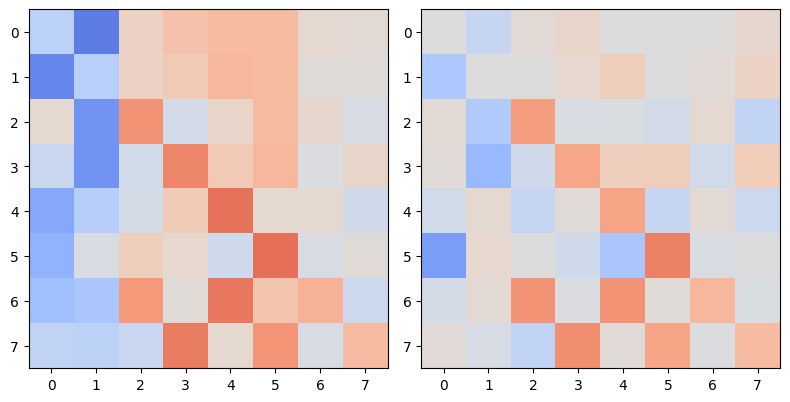

cosine_similarity measure: 0.816
MSE output:
1.2714164155805659e-05
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7963  1.8543
      2        0.7288  1.5590
      3        0.6714  1.5930
      4        0.6218  1.5399
      5        0.5785  1.5378
      6        0.5418  1.5846
      7        0.5132  1.5654
      8        0.4884  1.5873
      9        0.4639  1.5139
     10        0.4388  1.5249
     11        0.4160  1.5806
     12        0.3960  1.5243
     13        0.3791  1.5621
     14        0.3650  1.5856
     15        0.3553  1.5288
     16        0.3454  1.5832
     17        0.3383  1.5658
     18        0.3330  1.5486
     19        0.3268  1.5663
     20        0.3220  1.5703
     21        0.3160  1.5071
     22        0.3098  1.5847
     23        0.3047  1.4878
     24        0.2997  1.5112
     25        0.2958  1.4739
     26        0.2926  1.6344
     27        0.2887  1.5629
     28        0.2851  1.5314
     29      

    232        0.0893  1.4901
    233        0.0917  1.5801
    234        0.0881  1.5004
    235        0.0857  1.5798
    236        0.0866  1.4968
    237        0.0847  1.5125
    238        0.0849  1.6170
    239        0.0893  1.5586
    240        0.0922  1.4974
    241        0.0863  1.6067
    242        0.0842  1.5499
    243        0.0870  1.5110
    244        0.0863  1.5290
    245        0.0852  1.5478
    246        0.0854  1.5514
    247        0.0845  1.4693
    248        0.0855  1.5632
    249        0.0842  1.5554
    250        0.0825  1.6032
    251        0.0855  1.4665
    252        0.0884  1.5634
    253        0.0881  1.6817
    254        0.0847  1.4917
    255        0.0844  1.5619
    256        0.0857  1.5328
    257        0.0869  1.6138
    258        0.0825  1.5740
    259        0.0820  1.4864
    260        0.0849  1.5588
    261        0.0877  1.5206
    262        0.0871  1.5221
    263        0.0833  1.7302
    264        0.0819  1.6276
    265   

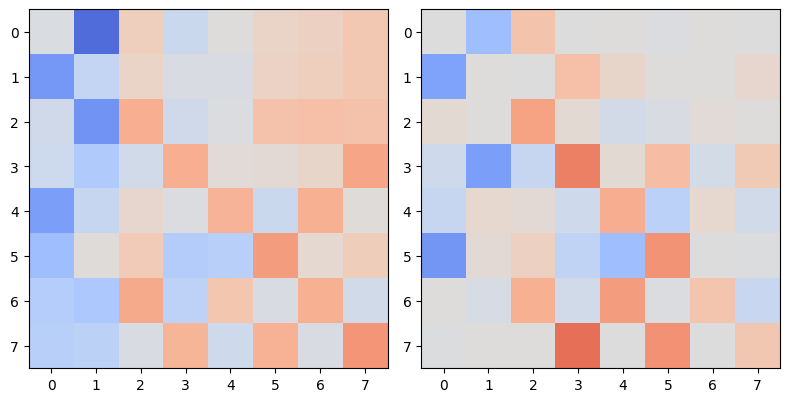

cosine_similarity measure: 0.721
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.7828  1.5708
      2        0.7090  1.5552
      3        0.6439  1.5265
      4        0.5841  1.4888
      5        0.5291  1.4778
      6        0.4809  1.5335
      7        0.4467  1.5421
      8        0.4298  1.5443
      9        0.4081  1.6660
     10        0.3815  1.5209
     11        0.3641  1.5007
     12        0.3558  1.5367
     13        0.3491  1.5626
     14        0.3405  1.5075
     15        0.3297  1.5843
     16        0.3208  1.4967
     17        0.3201  1.6169
     18        0.3131  1.5664
     19        0.3045  1.5663
     20        0.3023  1.4756
     21        0.3017  1.5691
     22        0.2993  1.4801
     23        0.2953  1.6036
     24        0.2932  1.6074
     25        0.2931  1.4785
     26        0.2909  1.5094
     27        0.2879  1.5533
     28        0.2869  1.5752
     29        0.2856  1.6213
     30        0.2

    233        0.0797  1.5736
    234        0.0793  1.6011
    235        0.0783  1.4385
    236        0.0792  1.6055
    237        0.0797  1.5307
    238        0.0756  1.5515
    239        0.0775  1.4598
    240        0.0778  1.5088
    241        0.0750  1.5698
    242        0.0797  1.5175
    243        0.0760  1.5460
    244        0.0759  1.5232
    245        0.0840  1.5348
    246        0.0775  1.5214
    247        0.0761  1.5889
    248        0.0792  1.5428
    249        0.0745  1.5540
    250        0.0772  1.4967
    251        0.0749  1.4784
    252        0.0772  1.5246
    253        0.0764  1.4967
    254        0.0744  1.5368
    255        0.0752  1.5992
    256        0.0759  1.6068
    257        0.0764  1.5750
    258        0.0794  1.4841
    259        0.0776  1.5745
    260        0.0750  1.5393
    261        0.0741  1.5920
    262        0.0778  1.4992
    263        0.0802  1.6530
    264        0.0748  1.5140
    265        0.0815  1.6016
    266   

cosine_similarity measure: 0.762
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8201  1.4845
      2        0.7370  1.5406
      3        0.6624  1.4916
      4        0.5957  1.5171
      5        0.5375  1.5720
      6        0.4889  1.6039
      7        0.4522  1.5858
      8        0.4308  1.4693
      9        0.4244  1.5239
     10        0.4139  1.5288
     11        0.3934  1.5247
     12        0.3758  1.4789
     13        0.3646  1.5287
     14        0.3572  1.5774
     15        0.3500  1.6405
     16        0.3411  1.5537
     17        0.3310  1.5322
     18        0.3206  1.5106
     19        0.3128  1.4702
     20        0.3096  1.6010
     21        0.3043  1.6561
     22        0.2948  1.5459
     23        0.2890  1.5356
     24        0.2866  1.5784
     25        0.2847  1.5709
     26        0.2804  1.5636
     27        0.2758  1.5210
     28        0.2726  1.6132
     29        0.2718  1.6197
     30        0.2

    236        0.1460  1.5082
    237        0.1365  1.5483
    238        0.1385  1.6287
    239        0.1465  1.5575
    240        0.1285  1.5700
    241        0.1348  1.4938
    242        0.1281  1.5584
    243        0.1243  1.5109
    244        0.1321  1.4793
    245        0.1324  1.5287
    246        0.1555  1.4877
    247        0.1300  1.5178
    248        0.1314  1.5090
    249        0.1297  1.5227
    250        0.1285  1.5332
    251        0.1340  1.5465
    252        0.1267  1.5662
    253        0.1242  1.5346
    254        0.1245  1.5096
    255        0.1230  1.5377
    256        0.1262  1.5208
    257        0.1174  1.5384
    258        0.1203  1.4705
    259        0.1152  1.5836
    260        0.1192  1.5662
    261        0.1157  1.6011
    262        0.1127  1.4776
    263        0.1141  1.4960
    264        0.1133  1.4748
    265        0.1153  1.5483
    266        0.1176  1.6352
    267        0.1445  1.5201
    268        0.1239  1.6640
    269   

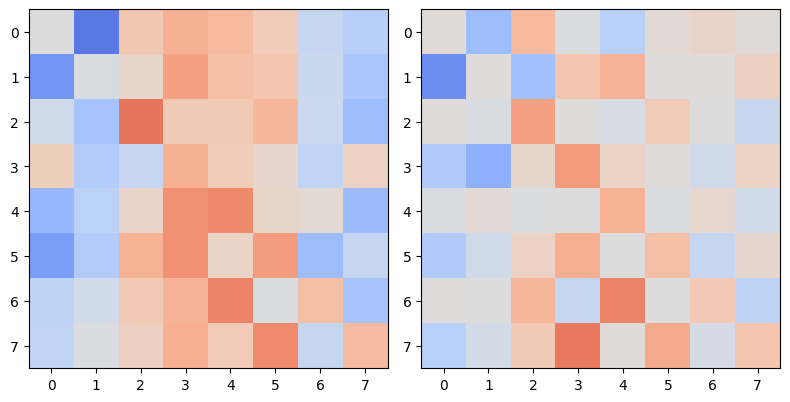

cosine_similarity measure: 0.692
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8280  1.5282
      2        0.7508  1.5152
      3        0.6837  1.5770
      4        0.6243  1.5904
      5        0.5729  1.5364
      6        0.5310  1.5592
      7        0.4999  1.4500
      8        0.4775  1.5866
      9        0.4533  1.5630
     10        0.4263  1.5947
     11        0.4038  1.5323
     12        0.3877  1.5363
     13        0.3737  1.5532
     14        0.3595  1.4940
     15        0.3465  1.6069
     16        0.3372  1.5265
     17        0.3278  1.5801
     18        0.3192  1.5359
     19        0.3148  1.5596
     20        0.3119  1.5554
     21        0.3084  1.6892
     22        0.3056  1.5374
     23        0.3035  1.5523
     24        0.2995  1.4980
     25        0.2964  1.5597
     26        0.2933  1.4951
     27        0.2896  1.5831
     28        0.2862  1.5273
     29        0.2837  1.5537
     30        0.2

    240        0.0960  1.4948
    241        0.0957  1.5795
    242        0.0929  1.4908
    243        0.0990  1.5308
    244        0.0959  1.5225
    245        0.1094  1.5530
    246        0.0971  1.4737
    247        0.0935  1.5556
    248        0.1033  1.5679
    249        0.0929  1.4694
    250        0.0988  1.6060
    251        0.1014  1.5570
    252        0.0962  1.5133
    253        0.1001  1.5322
    254        0.0924  1.4831
    255        0.0969  1.5724
    256        0.0948  1.5026
    257        0.0979  1.6095
    258        0.0941  1.6206
    259        0.0972  1.5073
    260        0.0920  1.4949
    261        0.0939  1.5503
    262        0.0927  1.4908
    263        0.0921  1.5854
    264        0.0979  1.5593
    265        0.0980  1.5648
    266        0.0901  1.5905
    267        0.0973  1.5278
    268        0.0994  1.5202
    269        0.0964  1.5148
    270        0.0996  1.6509
    271        0.0932  1.6175
    272        0.0953  1.6855
    273   

cosine_similarity measure: 0.698
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8087  1.4882
      2        0.7330  1.5041
      3        0.6686  1.5201
      4        0.6116  1.4821
      5        0.5602  1.5510
      6        0.5158  1.6624
      7        0.4829  1.4842
      8        0.4628  1.4930
      9        0.4424  1.4940
     10        0.4179  1.4869
     11        0.3962  1.5505
     12        0.3817  1.5235
     13        0.3709  1.6028
     14        0.3607  1.5311
     15        0.3493  1.4646
     16        0.3398  1.5998
     17        0.3354  1.5803
     18        0.3295  1.5792
     19        0.3208  1.5408
     20        0.3162  1.5955
     21        0.3129  1.4444
     22        0.3081  1.5830
     23        0.3033  1.4837
     24        0.3015  1.5871
     25        0.2998  1.4782
     26        0.2957  1.5186
     27        0.2938  1.5724
     28        0.2923  1.4791
     29        0.2895  1.4957
     30        0.2

    238        0.0950  1.5542
    239        0.0947  1.5140
    240        0.1006  1.5365
    241        0.0956  1.5716
    242        0.0887  1.7173
    243        0.0937  1.6606
    244        0.0904  1.5545
    245        0.0896  1.5332
    246        0.0915  1.5534
    247        0.0914  1.6402
    248        0.0894  1.4950
    249        0.0907  1.4872
    250        0.0968  1.5973
    251        0.0973  1.5126
    252        0.0914  1.5455
    253        0.0978  1.4766
    254        0.0906  1.4517
    255        0.0957  1.5009
    256        0.0979  1.5489
    257        0.1061  1.4758
    258        0.1034  1.4922
    259        0.0907  1.4733
    260        0.0987  1.5891
    261        0.0983  1.5267
    262        0.0946  1.4964
    263        0.0962  1.5697
    264        0.0943  1.4526
    265        0.0946  1.6007
    266        0.0946  1.6241
    267        0.0898  1.5112
    268        0.0953  1.5772
    269        0.0903  1.5658
    270        0.0942  1.5466
    271   

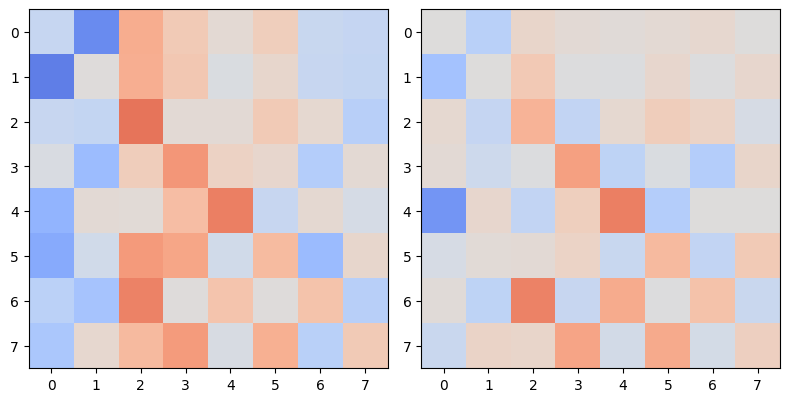

cosine_similarity measure: 0.786
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.9320  1.5195
      2        0.8402  1.4795
      3        0.7603  1.5334
      4        0.6921  1.5975
      5        0.6351  1.5867
      6        0.5874  1.5119
      7        0.5484  1.5364
      8        0.5171  1.5156
      9        0.4948  1.5811
     10        0.4819  1.4734
     11        0.4754  1.5369
     12        0.4650  1.5599
     13        0.4491  1.4805
     14        0.4323  1.4730
     15        0.4186  1.5868
     16        0.4085  1.4988
     17        0.4004  1.5085
     18        0.3923  1.6260
     19        0.3835  1.4708
     20        0.3732  1.5958
     21        0.3620  1.5093
     22        0.3517  1.6083
     23        0.3446  1.6080
     24        0.3398  1.5071
     25        0.3321  1.5287
     26        0.3216  1.5404
     27        0.3145  1.4563
     28        0.3100  1.4910
     29        0.3054  1.5486
     30        0.2

    236        0.0847  1.6109
    237        0.0851  1.5836
    238        0.0873  1.5232
    239        0.0878  1.5865
    240        0.0814  1.5355
    241        0.0866  1.4873
    242        0.0869  1.6104
    243        0.0863  1.4700
    244        0.0789  1.5400
    245        0.0855  1.5840
    246        0.0834  1.7081
    247        0.0833  1.6612
    248        0.0800  1.5982
    249        0.0823  1.6055
    250        0.0802  1.4955
    251        0.0809  1.6194
    252        0.0807  1.5124
    253        0.0784  1.6292
    254        0.0822  1.6717
    255        0.0834  1.5679
    256        0.0804  1.5980
    257        0.0807  1.4633
    258        0.0788  1.6245
    259        0.0830  1.5721
    260        0.0813  1.5109
    261        0.0784  1.5586
    262        0.0864  1.5041
    263        0.0810  1.5601
    264        0.0775  1.5502
    265        0.0792  1.5641
    266        0.0787  1.4994
    267        0.0780  1.5811
    268        0.0766  1.5674
    269   

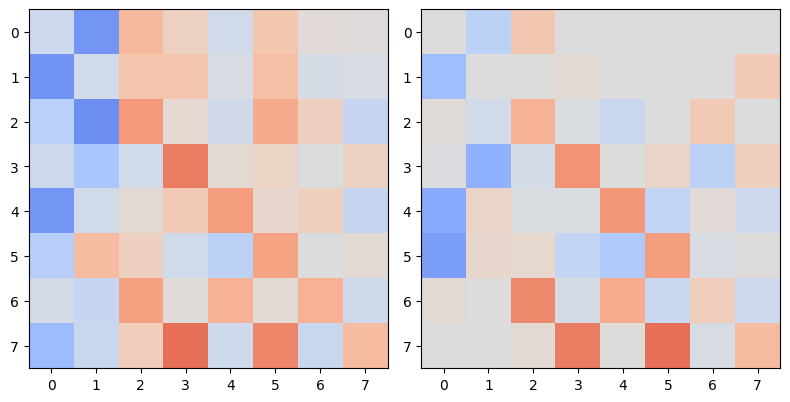

cosine_similarity measure: 0.794
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.6994  1.5218
      2        0.6298  1.6049
      3        0.5686  1.5453
      4        0.5138  1.4710
      5        0.4648  1.5504
      6        0.4255  1.4535
      7        0.4051  1.5109
      8        0.3986  1.4960
      9        0.3810  1.7073
     10        0.3612  1.5504
     11        0.3506  1.5485
     12        0.3459  1.5296
     13        0.3414  1.6529
     14        0.3342  1.6380
     15        0.3248  1.5722
     16        0.3164  1.6448
     17        0.3127  1.5604
     18        0.3093  1.6771
     19        0.3012  1.6392
     20        0.2940  1.5451
     21        0.2904  1.5791
     22        0.2880  1.4723
     23        0.2856  1.5183
     24        0.2821  1.5313
     25        0.2785  1.5878
     26        0.2761  1.5085
     27        0.2740  1.5537
     28        0.2699  1.5745
     29        0.2661  1.5728
     30        0.2

    237        0.0931  1.5505
    238        0.0926  1.6152
    239        0.0918  1.6307
    240        0.0867  1.5992
    241        0.0937  1.5171
    242        0.0874  1.6421
    243        0.0928  1.7048
    244        0.0895  1.6227
    245        0.0890  1.6076
    246        0.0945  1.6274
    247        0.0947  1.5757
    248        0.0843  1.4727
    249        0.0938  1.5447
    250        0.0954  1.5646
    251        0.0838  1.5216
    252        0.0958  1.5798
    253        0.0980  1.5899
    254        0.0827  1.4718
    255        0.1041  1.5204
    256        0.1110  1.6350
    257        0.0927  1.5749
    258        0.1177  1.5023
    259        0.0869  1.5618
    260        0.1035  1.6035
    261        0.0914  1.5739
    262        0.0978  1.5521
    263        0.0917  1.4731
    264        0.0960  1.6456
    265        0.0896  1.4711
    266        0.0925  1.5621
    267        0.0867  1.4979
    268        0.0891  1.4786
    269        0.0916  1.5057
    270   

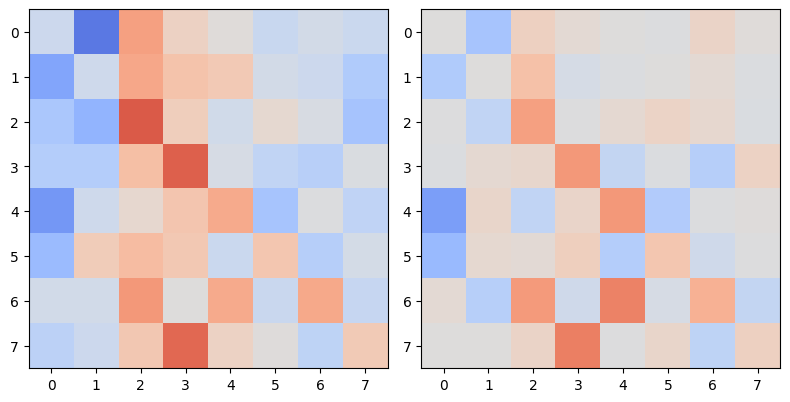

cosine_similarity measure: 0.822
MSE output:
0.0004711652959363641
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8176  1.7738
      2        0.7372  1.5168
      3        0.6612  1.5328
      4        0.5912  1.5858
      5        0.5299  1.5515
      6        0.4805  1.5426
      7        0.4495  1.4883
      8        0.4426  1.5403
      9        0.4300  1.5293
     10        0.4052  1.6400
     11        0.3867  1.5998
     12        0.3777  1.7083
     13        0.3720  1.6612
     14        0.3656  1.5507
     15        0.3565  1.5987
     16        0.3462  1.6182
     17        0.3370  1.6024
     18        0.3327  1.6285
     19        0.3330  1.5725
     20        0.3279  1.5962
     21        0.3218  1.4871
     22        0.3200  1.5055
     23        0.3197  1.5821
     24        0.3183  1.5641
     25        0.3145  1.6383
     26        0.3102  1.4832
     27        0.3071  1.5362
     28        0.3058  1.6022
     29       

    227        0.0903  1.5454
    228        0.0946  1.6034
    229        0.0989  1.5038
    230        0.1019  1.5677
    231        0.0939  1.5972
    232        0.0919  1.5839
    233        0.0965  1.6833
    234        0.0890  1.6659
    235        0.0958  1.5326
    236        0.0906  1.5228
    237        0.0905  1.5813
    238        0.0934  1.5722
    239        0.0880  1.5220
    240        0.0908  1.6166
    241        0.0994  1.6305
    242        0.0942  1.6014
    243        0.0951  1.5662
    244        0.0906  1.5642
    245        0.0902  1.6515
    246        0.0973  1.6360
    247        0.0952  1.6236
    248        0.0892  1.5322
    249        0.0882  1.6219
    250        0.0899  1.5458
    251        0.0927  1.5876
    252        0.0853  1.5570
    253        0.0878  1.5822
    254        0.0930  1.5815
    255        0.0940  1.6255
    256        0.1086  1.5294
    257        0.0863  1.5705
    258        0.1022  1.5720
    259        0.0923  1.6208
    260   

cosine_similarity measure: 0.687
Using random seed!
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8377  1.5766
      2        0.7515  1.6082
      3        0.6705  1.5512
      4        0.5973  1.5370
      5        0.5351  1.5207
      6        0.4845  1.5463
      7        0.4474  1.5471
      8        0.4281  1.5552
      9        0.4219  1.5741
     10        0.4113  1.4977
     11        0.3940  1.5536
     12        0.3803  1.4916
     13        0.3724  1.5392
     14        0.3681  1.5171
     15        0.3642  1.5648
     16        0.3579  1.5480
     17        0.3501  1.9651
     18        0.3410  1.5001
     19        0.3322  1.5648
     20        0.3272  1.5389
     21        0.3250  1.5891
     22        0.3187  1.5594
     23        0.3102  1.5864
     24        0.3048  1.5249
     25        0.3018  1.5606
     26        0.2988  1.5427
     27        0.2942  1.5126
     28        0.2891  1.5001
     29        0.2856  1.5222
     30        0.2

    233        0.0858  1.5086
    234        0.0808  1.5434
    235        0.0877  1.5161
    236        0.0830  1.5013
    237        0.0841  1.5725
    238        0.0849  1.5748
    239        0.0807  1.5452
    240        0.0848  1.4968
    241        0.0814  1.5289
    242        0.0820  1.6181
    243        0.0854  1.5216
    244        0.0792  1.5217
    245        0.0838  1.6399
    246        0.0792  1.6331
    247        0.0829  1.5429
    248        0.0802  1.7880
    249        0.0885  1.5788
    250        0.1015  1.5173
    251        0.0809  1.5169
    252        0.0837  1.6081
    253        0.0943  1.5739
    254        0.0810  1.6246
    255        0.0901  1.5657
    256        0.0827  1.5511
    257        0.0872  1.6108
    258        0.0820  1.5814
    259        0.0886  1.5114
    260        0.0820  1.5428
    261        0.0816  1.5313
    262        0.0834  1.5753
    263        0.0789  1.4955
    264        0.0843  1.4781
    265        0.0803  1.5707
    266   

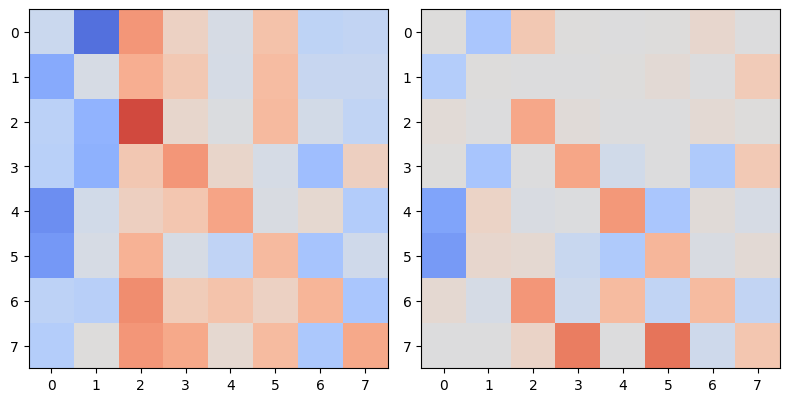

cosine_similarity measure: 0.733


In [5]:
def cosine_sim(A, B):
    v1 = A.flatten()/np.linalg.norm(A.flatten())
    v2 = B.flatten()/np.linalg.norm(B.flatten())
    return np.round(np.dot(v1, v2),3)

# "data_20102022_num_outputs=2_N=100_Nsteps=750_srec=0.03_sinp=0.03_date=2022-10-21_SGE_TASK_ID=1_MSEout=0.0158321.pkl",
#          "data_20102022_num_outputs=2_N=100_Nsteps=750_srec=0.03_sinp=0.03_date=2022-10-21_SGE_TASK_ID=2_MSEout=0.0184833.pkl",
#          "data_20102022_num_outputs=2_N=100_Nsteps=750_srec=0.03_sinp=0.03_date=2022-10-21_SGE_TASK_ID=3_MSEout=0.0171937.pkl",
# "data_20102022_num_outputs=2_N=100_Nsteps=750_srec=0.03_sinp=0.03_date=2022-10-21_SGE_TASK_ID=4_MSEout=0.0189526.pkl",
#         "data_20102022_num_outputs=2_N=100_Nsteps=750_srec=0.03_sinp=0.03_date=2022-10-21_SGE_TASK_ID=5_MSEout=0.0196804.pkl",
#         "data_20102022_num_outputs=2_N=100_Nsteps=750_srec=0.05_sinp=0.05_date=2022-10-21_SGE_TASK_ID=101_MSEout=0.0345344.pkl",

files = ["data_20102022_num_outputs=2_N=100_Nsteps=750_srec=0.05_sinp=0.05_date=2022-10-21_SGE_TASK_ID=102_MSEout=0.0329666.pkl",
        "data_20102022_num_outputs=2_N=100_Nsteps=750_srec=0.05_sinp=0.05_date=2022-10-21_SGE_TASK_ID=103_MSEout=0.0313018.pkl",
        "data_20102022_num_outputs=2_N=100_Nsteps=750_srec=0.05_sinp=0.05_date=2022-10-21_SGE_TASK_ID=104_MSEout=0.0307818.pkl",
                "data_20102022_num_outputs=2_N=100_Nsteps=750_srec=0.05_sinp=0.05_date=2022-10-21_SGE_TASK_ID=105_MSEout=0.0309906.pkl"]

for file in files:

    RNN_file_name = os.path.join("./data", "RNNs",file)
    RNN_tag = float(RNN_file_name.split(".pkl")[0].split("=")[-1])
    RNN_data = pickle.load(open(RNN_file_name, "rb+"))
    n_steps = RNN_data["n_steps"]
    bias_rec = RNN_data["bias_rec"]
    bias_out = RNN_data["bias_out"]
    W_rec = RNN_data["W_rec"]
    W_inp = RNN_data["W_inp"]
    W_out = RNN_data["W_out"]
    y_init = RNN_data["y_init"]
    dt = RNN_data["dt"]
    tau = RNN_data["tau"]
    N = RNN_data["N"]
    num_outputs = W_out.shape[0]
    w_noise = RNN_data["w_noise"]
    sigma_rec = RNN_data["sigma_rec"]
    sigma_inp = RNN_data["sigma_inp"] 
    alpha = (dt/tau)
    train_mask = RNN_data["train_mask"]
    protocol_dict = RNN_data["protocol_dict"]
    coherences = RNN_data["coherences_train"]

    RNN = RNN_numpy(N=N, dt=dt, tau=tau, W_inp=W_inp, W_rec=W_rec, W_out=W_out)

    # Run multiple trajectories:
    inp_traj_RNN_tuples = []
    for ctx in ["motion", "color"]:
        for c1 in coherences:
            for c2 in coherences:
                relevant_coh = c1 if ctx == 'motion' else c2
                irrelevant_coh = c2 if ctx == 'motion' else c1
                coh_pair = (relevant_coh, irrelevant_coh)
                input_stream, target_stream = generate_input_target_stream(ctx,
                                                                           coh_pair[0], coh_pair[1],
                                                                           n_steps=n_steps, 
                                                                           protocol_dict=protocol_dict,
                                                                           num_outputs=2)
                inp_vect = input_stream[-1, :]
                RNN.clear_history()
                RNN.y = np.zeros(RNN.N)

                RNN.run(num_steps=n_steps, Inputs = input_stream, sigma_rec= 0.0, sigma_inp=0.0, save_history=True)

                trajectory = deepcopy(RNN.get_history())
                output = deepcopy(RNN.get_output())
                print(input_stream[-1, :])
                inp_traj_RNN_tuples.append((input_stream, trajectory, output))

    lr = 0.02 
    lmbd_w = 0.2
    weight_decay = 0.05
    sigma_rec = 0.03
    sigma_inp = 0.03
    max_epochs = 300

    num_outputs = 2
    n = 8
    input_mask = torch.zeros(n, 6)
    input_mask[:6, :6] = torch.eye(6)
    recurrent_mask = torch.ones(n, n)# - torch.eye(n)
    output_mask = torch.zeros(num_outputs, n)
    output_mask[0, 6] = 1
    output_mask[1, 7] = 1

    Tr_RNN_array = np.vstack([inp_traj_RNN_tuples[i][1] for i in range(len(inp_traj_RNN_tuples))]).T
    K = 16
    U, sigma, V = scipy.sparse.linalg.svds(Tr_RNN_array, k=K)
    U = U[:, ::-1]
    sigma = sigma[::-1]
    V = V[::-1, :]
    print(sigma/(np.sum(sigma)))
    print(U.shape)
    fig_svd = plt.figure()
    plt.plot(sigma/(np.sum(sigma)))
    plt.show()

    # Run multiple trajectories:
    inp_trajPCA_tuples = []
    i = 0
    for ctx in ["motion", "color"]:
        for c1 in coherences:
            for c2 in coherences:
                inp, trajectory, output = inp_traj_RNN_tuples[i]
                trajectory_PCA = trajectory @ U
                inp_trajPCA_tuples.append((inp, trajectory_PCA, output))
                i+=1

    inputs = torch.from_numpy(np.stack([inp_trajPCA_tuples[i][0] for i in range(len(inp_trajPCA_tuples))]).astype("float32")).detach().cpu()
    traces = torch.from_numpy(np.stack([inp_trajPCA_tuples[i][1] for i in range(len(inp_trajPCA_tuples))]).astype("float32")).detach().cpu()
    outputs = torch.from_numpy(np.stack([inp_trajPCA_tuples[i][2] for i in range(len(inp_trajPCA_tuples))]).astype("float32")).detach().cpu()
    labels = torch.cat((traces, outputs), dim=2)


    for i in range(30):
        Module = LatentModule(input_mask=input_mask.to(device=device),
                              output_mask=output_mask.to(device=device),
                              recurrent_mask = recurrent_mask.to(device=device),
                              n=n,
                              N=K,
                              num_outputs=W_out.shape[0],
                              alpha=0.1,
                              sigma_rec=sigma_rec,
                              weight_decay=weight_decay,
                              lambda_w=lmbd_w)

        W_inp_vals = np.zeros((n, 6))
        W_inp_vals[:6, :6] = np.eye(6)
        Module.input_layer.weight.data = torch.from_numpy(W_inp_vals.astype("float32"))
        if num_outputs == 1:
            Module.output_layer.weight.data = torch.from_numpy(np.array([0,0,0,0,0,0,1,-1]).reshape(1, -1).astype("float32"))
        elif num_outputs == 2:
            Module.output_layer.weight.data = torch.from_numpy(np.array([[0,0,0,0,0,0,1,0], [0,0,0,0,0,0,0,1]]).astype("float32"))

        latent_net = LatentNet(
            module=Module,
            warm_start=True,
            lr=lr,
            train_split=None,
            batch_size=inputs.shape[0],
            max_epochs=max_epochs,
            constrained=True,
            optimizer=torch.optim.Adam,
            device=device,
            callbacks=[EpochScoring(rsquared, on_train=False),
                       EpochScoring(output_MSE, on_train=False),
                       EpochScoring(traces_MSE, on_train=False)]
        )
        latent_net.initialize()

        latent_net.fit(torch.Tensor(inputs).to(device=device), torch.tensor(labels).to(device=device))
        plt.style.use("default")

        w_rec = deepcopy(latent_net.module_.recurrent_layer.weight.data.detach().numpy())
        w_out = deepcopy(latent_net.module_.output_layer.weight.data.detach().numpy())
        w_inp = deepcopy(latent_net.module_.input_layer.weight.data.detach().numpy())
        R = deepcopy(latent_net.module_.R.detach().numpy())
        print(R.shape)
        Q = U @ R.T  # N x 8

        w_rec_bar = Q.T @ W_rec @ Q
        fig_w_rec_comparison, axes = plt.subplots(1, 2, figsize=(8,4))
        axes[0].imshow(w_rec_bar, 'coolwarm', vmin = -1.2, vmax=1.2)
        axes[1].imshow(w_rec, 'coolwarm', vmin = -1.2, vmax=1.2)
        plt.tight_layout()
        plt.show()

        print(f"cosine_similarity measure: {cosine_sim(w_rec_bar, w_rec)}")
        if cosine_sim(w_rec_bar, w_rec) >= 0.8:
            lc = RNN_numpy(N=8, dt=dt, tau=tau, W_inp=w_inp, W_rec=w_rec, W_out=w_out)# Run multiple trajectories on the distilled lc:
            inp_traj_lc_tuples = []
            for ctx in ["motion", "color"]:
                for c1 in coherences:
                    for c2 in coherences:
                        relevant_coh = c1 if ctx == 'motion' else c2
                        irrelevant_coh = c2 if ctx == 'motion' else c1
                        coh_pair = (relevant_coh, irrelevant_coh)
                        input_stream, target_stream = generate_input_target_stream(ctx,
                                                                                   coh_pair[0], coh_pair[1],
                                                                                   n_steps, 
                                                                                   protocol_dict,
                                                                                   num_outputs=2)
                        inp_vect = input_stream[-1, :]
                        lc.clear_history()
                        lc.y = np.zeros(8)
                        lc.run(num_steps=n_steps, Inputs = input_stream, sigma_rec = 0, sigma_inp = 0, save_history=True)

                        trajectory_lc = deepcopy(lc.get_history())
                        output_lc = deepcopy(lc.get_output())
                        inp_traj_lc_tuples.append((input_stream, trajectory_lc, output_lc, target_stream))

            Tr_lc_array = np.vstack([inp_traj_lc_tuples[i][1] for i in range(len(inp_traj_lc_tuples))])
            Tr_RNN_array = np.vstack([inp_traj_RNN_tuples[i][1] for i in range(len(inp_traj_RNN_tuples))])
            Tr_PCA_array = np.vstack([inp_trajPCA_tuples[i][1] for i in range(len(inp_trajPCA_tuples))])
            Out_lc_array = np.vstack([inp_traj_lc_tuples[i][2] for i in range(len(inp_traj_lc_tuples))])
            Out_RNN_array = np.vstack([inp_traj_RNN_tuples[i][2] for i in range(len(inp_traj_RNN_tuples))])
            Out_PCA_array = np.vstack([inp_trajPCA_tuples[i][2] for i in range(len(inp_trajPCA_tuples))])
            print("MSE output:")
            score = np.mean(Tr_lc_array @ w_out.T - Tr_RNN_array @ W_out.T)**2
            print(score)

            lc_data = {}
            lc_data["W_out"] = deepcopy(lc.W_out)
            lc_data["W_rec"] = deepcopy(lc.W_rec)
            lc_data["W_inp"] = deepcopy(lc.W_inp)
            lc_data["b_rec"] = deepcopy(np.zeros(lc.N))
            lc_data["b_out"] = deepcopy(0)
            lc_data["Q"] = deepcopy(Q)
            lc_data["N"] = lc.N
            lc_data["tau"] = lc.tau
            lc_data["dt"] = lc.dt
            lc_data["RNN_data"] = deepcopy(RNN_data)

            pickle.dump(lc_data, open(os.path.join("./", "data", "LCs", f"LC_{RNN_tag}_{np.round(score, 8)}.pkl"), "wb+"))
